In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
import scipy
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from google.colab import files

In [ ]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [ ]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    # V = jnp.pi / 2 * (2 * random.uniform(key, shape = (num_datasets, dataset_size)) - 1)
    # W = - jnp.log(random.uniform(key1, shape = (num_datasets, dataset_size)))

    V = jnp.pi / 2 * (2 * jnp.array(np.random.rand(num_datasets, dataset_size)) - 1)
    W = - jnp.log(jnp.array(np.random.rand(num_datasets, dataset_size)))

    const = beta * jnp.tan(jnp.pi * alpha / 2)
    r1 = gamma * (((1 + const * const)**(1 / (2 * alpha))) * jnp.sin(alpha * V + jnp.arctan(const)) / ((jnp.cos(V)) ** (1/alpha)) * (( jnp.cos( (1-alpha) * V - jnp.arctan(const)) / W )**((1-alpha)/alpha))) + delta

    r_immi = 2 / jnp.pi * ((jnp.pi / 2 + beta * V) * jnp.tan(V) - beta * jnp.log( (jnp.pi / 2 * W * jnp.cos(V) ) / (jnp.pi / 2 + beta * V) ))
    r2 = gamma * r_immi + (2 / jnp.pi) * beta * gamma * jnp.log(gamma) + delta
    return jnp.where(alpha !=1, r1, r2)

In [ ]:
true_theta = jnp.array([1.8, 0.5, 1, 0])

In [ ]:
actual_data = alpha_stable(true_theta[0], true_theta[1], true_theta[2], true_theta[3], 200, 1)
actual_data

Array([[-0.9994848 , -2.8999217 ,  0.31997016,  1.4593827 , -1.1671073 ,
        -0.33297178, -2.5015786 ,  0.23129147, -1.4423249 , -0.7351586 ,
         0.7737031 ,  0.7600781 , -1.9006582 , -0.2567277 , -0.2559021 ,
         3.5897994 , -0.12205172, -1.008141  , -2.4296215 , -0.60396194,
        -0.18045366,  0.2887079 ,  1.94673   , -0.10907705, -0.181604  ,
         0.41824916,  0.5413587 , -1.070129  ,  0.8022436 ,  0.30826032,
         1.033443  , -0.29956868, -0.23277798, -1.5358688 ,  1.4659512 ,
         0.24421266, -2.49694   , -3.0870469 ,  1.2492282 , -1.9415506 ,
        -2.0473053 , -0.16608885,  0.23990147,  1.9343686 , -0.18304466,
        -0.63450557, -1.0364103 ,  5.0438914 ,  1.3461846 , -1.6109391 ,
        -2.363191  ,  0.09952114, -3.7264082 , -0.11215819, -1.8467627 ,
        -2.310048  , -0.6970817 , -0.11911908, -0.7731697 ,  0.26813498,
        -3.7978916 ,  0.25855464, -0.5556254 ,  0.60402155, -1.1212634 ,
         0.81208384,  1.2323376 , -1.7410207 , -0.6

In [ ]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data):
  # Compute quantile statistics
  v_stability = (jnp.percentile(data, 95) - jnp.percentile(data, 5)) / (jnp.percentile(data, 75) - jnp.percentile(data, 25))
  v_skewness = (jnp.percentile(data, 95) + jnp.percentile(data, 5) - 2 * jnp.percentile(data, 50)) / (jnp.percentile(data, 95) - jnp.percentile(data, 5))
  v_scale = (jnp.percentile(data, 75) - jnp.percentile(data, 25)) / 1
  v_loc = jnp.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = jnp.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = jnp.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = jnp.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = jnp.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = jnp.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = jnp.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = jnp.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = jnp.array([[0.0,    0.0,    0.0,    0.0,  0.0],
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_stability <= v_stability, size=len(tv_stability), fill_value=0)))
  tv_stability_i2 = jnp.min(jnp.append(14, jnp.argwhere(tv_stability >= v_stability, size=len(tv_stability), fill_value=14)))
  tv_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(tv_skewness <= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=0)))
  tv_skewness_i2 = jnp.min(jnp.append(6, jnp.argwhere(tv_skewness >= jnp.abs(v_skewness), size=len(tv_skewness), fill_value=6)))

  dist_stability_tv = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]

  dist_stability = jnp.where(dist_stability_tv != 0, (v_stability - tv_stability[tv_stability_i1]) / dist_stability_tv, dist_stability_tv)

  dist_skewness_tv = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_tv != 0, (jnp.abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness_tv, dist_skewness_tv)

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = jnp.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_stability >= alpha, size=len(t_stability), fill_value=0)))
  t_stability_i2 = jnp.min(jnp.append(15, jnp.argwhere(t_stability <= alpha, size=len(t_stability), fill_value=15)))
  t_skewness_i1 = jnp.max(jnp.append(0, jnp.argwhere(t_skewness <= jnp.abs(beta),size=len(t_skewness), fill_value=0)))
  t_skewness_i2 = jnp.min(jnp.append(4, jnp.argwhere(t_skewness >= jnp.abs(beta),size=len(t_skewness), fill_value=4)))

  dist_stability_t = t_stability[t_stability_i2] - t_stability[t_stability_i1]

  dist_stability = jnp.where(dist_stability_t != 0, (alpha - t_stability[t_stability_i1]) / dist_stability_t, dist_stability_t)

  dist_skewness_t = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]

  dist_skewness = jnp.where(dist_skewness_t != 0, (jnp.abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness, dist_skewness_t)

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = jnp.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + jnp.percentile(data, 50)

  mu = jnp.where(jnp.abs(alpha-1) < 0.05, zeta, zeta - beta * sigma * jnp.tan(0.5 * jnp.pi *alpha))

  return jnp.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

In [ ]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics =  jnp.array([2.        , -0.6959737 ,  1.103275  ,  0.20693694])

In [ ]:
num_coeffs = len(true_theta)
num_latent = len(true_theta)
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)
eps_precision = 1000

tau = 0.01
sigma_theta = 10
sigma_latent = 1

In [ ]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [ ]:
len_ss = jnp.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 12
# To optimize F
tau = 0.01
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 100
Patience_f = 101
batch_size = 5
# To optimize LB
stop = 5000
Patience = 20
t_w = 50

In [ ]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.8, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = jnp.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])
val_n_summary_statistics = jnp.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_val_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [ ]:
scaler_mean = jnp.mean(original_n_summary_statistics, axis=0)
scaler_std = jnp.std(original_n_summary_statistics, axis=0)
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [ ]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        # beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x
def kl(x):
    return 1/2 * x.T @ x
def lb(x):
    return -1/2 * x.T @ x
def f_with_Lambda_(Lambda, x):
    T_x, log_Jacobian = radial_flow(Lambda, x)
    diff = x - T_x
    f = - log_Jacobian + 1/2 * T_x.T @ T_x + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    return f
def mean_f(Lambda, x):
    mean_f = jnp.mean(f_with_Lambda_batched(Lambda, x))
    return mean_f

In [ ]:
transform_auto = vmap(radial_flow, in_axes=(None, 0))
f_with_Lambda_batched = vmap(f_with_Lambda_, in_axes=(None, 0))
kl_auto = vmap(kl)
LB_all = []
LB_Smoothed = []
Lambda_list = []
patience = 0
Lambda = random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
# Pre-compute random permutations outside the loop for efficiency
random_permutations = [random.permutation(subkey, wass_num_datasets) for subkey in subkeys1]

for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random_permutations[t][:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(mean_f, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = mean_f(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    lb_k = -kl_k
    LB_all.append(lb_k)
    if k < t_w:
        print('>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<<', lb_k)
    if k >= t_w:
        LB_smoothed = jnp.mean(jnp.array(LB_all[k - t_w + 1 : k]))
        print('>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<<', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
            patience = 0
            transformed_n_summary_statistics = wass_n_summary_statistics
        else:
            patience += 1
            if patience > Patience:
                print("Stop at", t)
                break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 702.3214
F Smoothed 686.7793
F Smoothed 671.97174
F Smoothed 657.0065
F Smoothed 642.8744
F Smoothed 628.30597
F Smoothed 613.9912
F Smoothed 599.73895
F Smoothed 586.14435
F Smoothed 572.4514
F Smoothed 559.07916
F Smoothed 546.13525
F Smoothed 533.46356
F Smoothed 521.2066
F Smoothed 507.50635
F Smoothed 496.09225
F Smoothed 484.1993
F Smoothed 472.81335
F Smoothed 461.71725
F Smoothed 450.54498
F Smoothed 439.7267
F Smoothed 429.11923
F Smoothed 418.69516
F Smoothed 408.3016
F Smoothed 398.30365
F Smoothed 388.3388
F Smoothed 378.4184
F Smoothed 368.51587
F Smoothed 359.07565
F Smoothed 349.75754
F Smoothed 340.6856
F Smoothed 331.6789
F Smoothed 322.94824
F Smoothed 314.40088
F Smoothed 305.96893
F Smoothed 297.72113
F Smoothed 289.67905
F Smoothed 281.70605
F Smoothed 274.03848
F Smoothed 266.24057
F Smoothed 258.8342
F Smoothed 251.4194
F Smoothed 244.33118
F Smoothed 237.44026
F Smoothed 230.57228
F Smoothed 223.84792
F Smoothed 217.15916
F Smoothed 210.63269
F Smooth

  0%|          | 1/5000 [05:42<475:53:52, 342.72s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5648155
F Smoothed 2.130349
F Smoothed 2.1388347
F Smoothed 2.1444473
F Smoothed 2.1407154
F Smoothed 2.1273403
F Smoothed 2.129328
F Smoothed 2.129258
F Smoothed 2.1277027
F Smoothed 2.1292894
F Smoothed 2.1179419
F Smoothed 2.1395683
F Smoothed 2.1258864
F Smoothed 2.103559
F Smoothed 2.108936
F Smoothed 1.9458082
F Smoothed 1.9631549
F Smoothed 1.9607359
F Smoothed 1.9432893
F Smoothed 1.9553723
F Smoothed 1.9578248
F Smoothed 1.9618782
F Smoothed 1.9666102
F Smoothed 1.9657036
F Smoothed 1.9586654
F Smoothed 1.9551866
F Smoothed 1.9554065
F Smoothed 1.9523078
F Smoothed 1.9404075
F Smoothed 1.9463948
F Smoothed 1.9380604
F Smoothed 1.9439223
F Smoothed 1.9627874
F Smoothed 1.9629498
F Smoothed 1.9522711
F Smoothed 1.9475057
F Smoothed 1.9622326
F Smoothed 1.9589893
F Smoothed 1.969381
F Smoothed 1.9654609
F Smoothed 1.9634147
F Smoothed 1.9652704
F Smoothed 1.9590095
F Smoothed 1.9454567
F Smoothed 1.9803121
F Smoothed 1.9929389


  0%|          | 2/5000 [08:34<336:02:00, 242.04s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6412215
F Smoothed 2.2874067
F Smoothed 2.296871
F Smoothed 2.3037791
F Smoothed 2.301495
F Smoothed 2.287341
F Smoothed 2.289689
F Smoothed 2.2884052
F Smoothed 2.2856674
F Smoothed 2.2886736
F Smoothed 2.2758853
F Smoothed 2.2976959
F Smoothed 2.2835069
F Smoothed 2.2602174
F Smoothed 2.267171
F Smoothed 2.1194856
F Smoothed 2.134734
F Smoothed 2.1329637
F Smoothed 2.115913
F Smoothed 2.1290627
F Smoothed 2.1337688
F Smoothed 2.1380775
F Smoothed 2.1421928
F Smoothed 2.1413248
F Smoothed 2.1340613
F Smoothed 2.129951
F Smoothed 2.129766
F Smoothed 2.1269298
F Smoothed 2.1158655
F Smoothed 2.1224444
F Smoothed 2.1140819
F Smoothed 2.1207936
F Smoothed 2.1412652
F Smoothed 2.1402917
F Smoothed 2.1296105
F Smoothed 2.1253343
F Smoothed 2.1389306
F Smoothed 2.1361096
F Smoothed 2.1472554
F Smoothed 2.1426141
F Smoothed 2.1421275
F Smoothed 2.143537
F Smoothed 2.137101
F Smoothed 2.1252546
F Smoothed 2.1589448
F Smoothed 2.1723335
F Smo

  0%|          | 3/5000 [11:26<291:39:46, 210.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.665767
F Smoothed 2.490964
F Smoothed 2.5012481
F Smoothed 2.5082607
F Smoothed 2.506199
F Smoothed 2.4910965
F Smoothed 2.4938548
F Smoothed 2.4911914
F Smoothed 2.487965
F Smoothed 2.4901667
F Smoothed 2.4761746
F Smoothed 2.499135
F Smoothed 2.4834647
F Smoothed 2.4585228
F Smoothed 2.4662669
F Smoothed 2.3292022
F Smoothed 2.3443062
F Smoothed 2.3438697
F Smoothed 2.3263772
F Smoothed 2.340452
F Smoothed 2.3463447
F Smoothed 2.3510118
F Smoothed 2.3549101
F Smoothed 2.35399
F Smoothed 2.3471925
F Smoothed 2.3424098
F Smoothed 2.3421538
F Smoothed 2.3380291
F Smoothed 2.3281794
F Smoothed 2.3344958
F Smoothed 2.3253226
F Smoothed 2.3325832
F Smoothed 2.3545578
F Smoothed 2.3525305
F Smoothed 2.3413708
F Smoothed 2.3369563
F Smoothed 2.3502748
F Smoothed 2.3473005
F Smoothed 2.3595653
F Smoothed 2.3548605
F Smoothed 2.3550153
F Smoothed 2.355669
F Smoothed 2.3487399
F Smoothed 2.3385358
F Smoothed 2.3705873
F Smoothed 2.3842628
F S

  0%|          | 4/5000 [14:16<269:53:47, 194.48s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6456804
F Smoothed 2.6780636
F Smoothed 2.689272
F Smoothed 2.6966028
F Smoothed 2.6949592
F Smoothed 2.678568
F Smoothed 2.6822324
F Smoothed 2.67911
F Smoothed 2.6757379
F Smoothed 2.6756332
F Smoothed 2.6603692
F Smoothed 2.6846147
F Smoothed 2.667473
F Smoothed 2.641093
F Smoothed 2.6493666
F Smoothed 2.5209372
F Smoothed 2.5361326
F Smoothed 2.5366673
F Smoothed 2.5186164
F Smoothed 2.5335274
F Smoothed 2.5405524
F Smoothed 2.54597
F Smoothed 2.54975
F Smoothed 2.5488691
F Smoothed 2.5435061
F Smoothed 2.5373764
F Smoothed 2.5370126
F Smoothed 2.53145
F Smoothed 2.522775
F Smoothed 2.528724
F Smoothed 2.5184333
F Smoothed 2.5263228
F Smoothed 2.549788
F Smoothed 2.5470998
F Smoothed 2.5354328
F Smoothed 2.5306807
F Smoothed 2.5445263
F Smoothed 2.5415156
F Smoothed 2.554994
F Smoothed 2.5500395
F Smoothed 2.5506902
F Smoothed 2.5508509
F Smoothed 2.5433156
F Smoothed 2.5342965
F Smoothed 2.5651698
F Smoothed 2.5790212
F Smoothed

  0%|          | 5/5000 [17:06<257:34:52, 185.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6024523
F Smoothed 2.8402066
F Smoothed 2.8519516
F Smoothed 2.859582
F Smoothed 2.858007
F Smoothed 2.840189
F Smoothed 2.8445952
F Smoothed 2.8413715
F Smoothed 2.8378367
F Smoothed 2.8356915
F Smoothed 2.8191416
F Smoothed 2.8444073
F Smoothed 2.8262978
F Smoothed 2.798912
F Smoothed 2.8073907
F Smoothed 2.6861522
F Smoothed 2.701271
F Smoothed 2.7025018
F Smoothed 2.6837769
F Smoothed 2.6999967
F Smoothed 2.7081697
F Smoothed 2.7145925
F Smoothed 2.7180283
F Smoothed 2.7174869
F Smoothed 2.7132876
F Smoothed 2.7061212
F Smoothed 2.7056866
F Smoothed 2.6993659
F Smoothed 2.6918051
F Smoothed 2.6975055
F Smoothed 2.6862364
F Smoothed 2.6945148
F Smoothed 2.7192888
F Smoothed 2.7161033
F Smoothed 2.7039406
F Smoothed 2.6989505
F Smoothed 2.7131014
F Smoothed 2.710183
F Smoothed 2.724784
F Smoothed 2.719255
F Smoothed 2.7205157
F Smoothed 2.720522
F Smoothed 2.7122586
F Smoothed 2.7039962
F Smoothed 2.7338362
F Smoothed 2.7477772
F S

  0%|          | 6/5000 [19:01<224:03:51, 161.52s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6466217
F Smoothed 2.7039597
F Smoothed 2.7161348
F Smoothed 2.7230976
F Smoothed 2.7210083
F Smoothed 2.7048352
F Smoothed 2.7080665
F Smoothed 2.7033937
F Smoothed 2.6996124
F Smoothed 2.6949391
F Smoothed 2.678271
F Smoothed 2.7021577
F Smoothed 2.6847236
F Smoothed 2.6579928
F Smoothed 2.6663158
F Smoothed 2.555822
F Smoothed 2.57109
F Smoothed 2.5734503
F Smoothed 2.555376
F Smoothed 2.57239
F Smoothed 2.5812492
F Smoothed 2.5875928
F Smoothed 2.5911717
F Smoothed 2.590779
F Smoothed 2.587115
F Smoothed 2.5825515
F Smoothed 2.5820181
F Smoothed 2.5773697
F Smoothed 2.5706198
F Smoothed 2.576453
F Smoothed 2.5650778
F Smoothed 2.5720057
F Smoothed 2.595917
F Smoothed 2.5925934
F Smoothed 2.5809789
F Smoothed 2.576173
F Smoothed 2.588144
F Smoothed 2.5858538
F Smoothed 2.599506
F Smoothed 2.5932298
F Smoothed 2.5947878
F Smoothed 2.5964174
F Smoothed 2.5874727
F Smoothed 2.5798354
F Smoothed 2.607159
F Smoothed 2.621095
F Smoothed

  0%|          | 7/5000 [21:05<207:04:26, 149.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.65657
F Smoothed 2.633985
F Smoothed 2.6464655
F Smoothed 2.65346
F Smoothed 2.6528728
F Smoothed 2.6375308
F Smoothed 2.6414165
F Smoothed 2.637252
F Smoothed 2.6342287
F Smoothed 2.6291947
F Smoothed 2.612007
F Smoothed 2.6357355
F Smoothed 2.6180575
F Smoothed 2.590994
F Smoothed 2.5988061
F Smoothed 2.4982567
F Smoothed 2.5128262
F Smoothed 2.5155075
F Smoothed 2.498404
F Smoothed 2.5156
F Smoothed 2.524158
F Smoothed 2.5302815
F Smoothed 2.5337405
F Smoothed 2.5335839
F Smoothed 2.5298378
F Smoothed 2.5259807
F Smoothed 2.525398
F Smoothed 2.5221035
F Smoothed 2.515867
F Smoothed 2.521945
F Smoothed 2.5107627
F Smoothed 2.5169332
F Smoothed 2.5401826
F Smoothed 2.5367138
F Smoothed 2.525585
F Smoothed 2.5207624
F Smoothed 2.5308614
F Smoothed 2.5290852
F Smoothed 2.5420227
F Smoothed 2.5349813
F Smoothed 2.5368934
F Smoothed 2.5400472
F Smoothed 2.5306194
F Smoothed 2.523306
F Smoothed 2.5488458
F Smoothed 2.562886
F Smoothed 2.

  0%|          | 8/5000 [24:16<225:20:37, 162.51s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.58828
F Smoothed 2.794796
F Smoothed 2.8081741
F Smoothed 2.8162146
F Smoothed 2.8165178
F Smoothed 2.7960198
F Smoothed 2.8002696
F Smoothed 2.7963877
F Smoothed 2.7931821
F Smoothed 2.7892663
F Smoothed 2.7713704
F Smoothed 2.7958672
F Smoothed 2.7771893
F Smoothed 2.7487648
F Smoothed 2.7554603
F Smoothed 2.6604652
F Smoothed 2.6719298
F Smoothed 2.6744065
F Smoothed 2.6569486
F Smoothed 2.6751301
F Smoothed 2.6840007
F Smoothed 2.690413
F Smoothed 2.69252
F Smoothed 2.6934192
F Smoothed 2.6888428
F Smoothed 2.6818008
F Smoothed 2.6812162
F Smoothed 2.6771135
F Smoothed 2.6712897
F Smoothed 2.6770198
F Smoothed 2.6657639
F Smoothed 2.6730323
F Smoothed 2.6969416
F Smoothed 2.6930318
F Smoothed 2.6814923
F Smoothed 2.6763475
F Smoothed 2.686177
F Smoothed 2.684627
F Smoothed 2.6983907
F Smoothed 2.6906812
F Smoothed 2.6934814
F Smoothed 2.6965487
F Smoothed 2.6879802
F Smoothed 2.6811256
F Smoothed 2.706263
F Smoothed 2.7201457
F S

  0%|          | 9/5000 [27:17<233:21:58, 168.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.528896
F Smoothed 2.9063118
F Smoothed 2.920404
F Smoothed 2.9288807
F Smoothed 2.9287972
F Smoothed 2.9080725
F Smoothed 2.9126341
F Smoothed 2.908428
F Smoothed 2.9047642
F Smoothed 2.9018173
F Smoothed 2.8842762
F Smoothed 2.9092932
F Smoothed 2.8893661
F Smoothed 2.8595526
F Smoothed 2.866652
F Smoothed 2.775113
F Smoothed 2.785478
F Smoothed 2.787949
F Smoothed 2.7702482
F Smoothed 2.7897189
F Smoothed 2.7985916
F Smoothed 2.8054883
F Smoothed 2.8071933
F Smoothed 2.808806
F Smoothed 2.803348
F Smoothed 2.7950337
F Smoothed 2.794639
F Smoothed 2.79
F Smoothed 2.7843888
F Smoothed 2.789843
F Smoothed 2.778521
F Smoothed 2.7866936
F Smoothed 2.8110511
F Smoothed 2.8068335
F Smoothed 2.7947128
F Smoothed 2.7895658
F Smoothed 2.7992547
F Smoothed 2.7980187
F Smoothed 2.8124716
F Smoothed 2.8040574
F Smoothed 2.8074586
F Smoothed 2.8103743
F Smoothed 2.8029742
F Smoothed 2.7966297
F Smoothed 2.8217015
F Smoothed 2.8356218
F Smoothed 

  0%|          | 10/5000 [30:08<234:36:15, 169.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4893684
F Smoothed 2.9810166
F Smoothed 2.995519
F Smoothed 3.0047367
F Smoothed 3.0031898
F Smoothed 2.9824464
F Smoothed 2.9871635
F Smoothed 2.9825532
F Smoothed 2.978645
F Smoothed 2.9767487
F Smoothed 2.9604173
F Smoothed 2.98581
F Smoothed 2.9649134
F Smoothed 2.9340231
F Smoothed 2.9413524
F Smoothed 2.8525267
F Smoothed 2.8622134
F Smoothed 2.864223
F Smoothed 2.8463566
F Smoothed 2.8671389
F Smoothed 2.8756454
F Smoothed 2.8829713
F Smoothed 2.8841984
F Smoothed 2.8867347
F Smoothed 2.880857
F Smoothed 2.872299
F Smoothed 2.8719523
F Smoothed 2.867073
F Smoothed 2.8613179
F Smoothed 2.8665094
F Smoothed 2.8553267
F Smoothed 2.8642287
F Smoothed 2.8885677
F Smoothed 2.8842225
F Smoothed 2.871727
F Smoothed 2.8666542
F Smoothed 2.876251
F Smoothed 2.8753965
F Smoothed 2.89031
F Smoothed 2.8813035
F Smoothed 2.884899
F Smoothed 2.8876336
F Smoothed 2.8807023
F Smoothed 2.8745062
F Smoothed 2.8995814
F Smoothed 2.9136753
F Smoot

  0%|          | 11/5000 [32:59<235:16:35, 169.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4729857
F Smoothed 3.0258505
F Smoothed 3.0403244
F Smoothed 3.050298
F Smoothed 3.0474987
F Smoothed 3.0273123
F Smoothed 3.0323005
F Smoothed 3.0274494
F Smoothed 3.0236294
F Smoothed 3.0227728
F Smoothed 3.007762
F Smoothed 3.033399
F Smoothed 3.0117016
F Smoothed 2.979972
F Smoothed 2.9875007
F Smoothed 2.9010115
F Smoothed 2.9105558
F Smoothed 2.9121287
F Smoothed 2.8942895
F Smoothed 2.91639
F Smoothed 2.924445
F Smoothed 2.9319649
F Smoothed 2.9325938
F Smoothed 2.936153
F Smoothed 2.9298918
F Smoothed 2.9215791
F Smoothed 2.9211864
F Smoothed 2.916444
F Smoothed 2.9104342
F Smoothed 2.9153862
F Smoothed 2.9044445
F Smoothed 2.9141142
F Smoothed 2.9380002
F Smoothed 2.9334784
F Smoothed 2.9207911
F Smoothed 2.915848
F Smoothed 2.9251678
F Smoothed 2.9244905
F Smoothed 2.9398234
F Smoothed 2.9302623
F Smoothed 2.9342356
F Smoothed 2.936958
F Smoothed 2.9301708
F Smoothed 2.923941
F Smoothed 2.9488337
F Smoothed 2.9631498
F Smoo

  0%|          | 12/5000 [35:50<235:45:49, 170.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4708467
F Smoothed 3.0586305
F Smoothed 3.0728626
F Smoothed 3.0834885
F Smoothed 3.0796258
F Smoothed 3.06049
F Smoothed 3.0658724
F Smoothed 3.0610297
F Smoothed 3.0574327
F Smoothed 3.0577645
F Smoothed 3.0432792
F Smoothed 3.0691516
F Smoothed 3.046687
F Smoothed 3.0143156
F Smoothed 3.021957
F Smoothed 2.937757
F Smoothed 2.9471843
F Smoothed 2.9482267
F Smoothed 2.9304075
F Smoothed 2.9532366
F Smoothed 2.9606578
F Smoothed 2.9681742
F Smoothed 2.9684381
F Smoothed 2.9727795
F Smoothed 2.9659405
F Smoothed 2.9582763
F Smoothed 2.9576988
F Smoothed 2.953311
F Smoothed 2.947008
F Smoothed 2.9515536
F Smoothed 2.940874
F Smoothed 2.9514961
F Smoothed 2.9747956
F Smoothed 2.9698486
F Smoothed 2.9571662
F Smoothed 2.9523308
F Smoothed 2.9612136
F Smoothed 2.9603746
F Smoothed 2.9759662
F Smoothed 2.9660034
F Smoothed 2.9706051
F Smoothed 2.973494
F Smoothed 2.9668117
F Smoothed 2.9604146
F Smoothed 2.9849927
F Smoothed 2.9995794
F S

  0%|          | 13/5000 [38:41<235:59:51, 170.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.4762826
F Smoothed 3.082183
F Smoothed 3.0961344
F Smoothed 3.107301
F Smoothed 3.102513
F Smoothed 3.0847242
F Smoothed 3.0904405
F Smoothed 3.0857177
F Smoothed 3.082292
F Smoothed 3.0838938
F Smoothed 3.0695276
F Smoothed 3.0956156
F Smoothed 3.0726128
F Smoothed 3.039756
F Smoothed 3.0473497
F Smoothed 2.965551
F Smoothed 2.9747322
F Smoothed 2.9750652
F Smoothed 2.9572713
F Smoothed 2.9804235
F Smoothed 2.9870315
F Smoothed 2.9944384
F Smoothed 2.9945657
F Smoothed 2.9994445
F Smoothed 2.991894
F Smoothed 2.985198
F Smoothed 2.984401
F Smoothed 2.9803712
F Smoothed 2.973721
F Smoothed 2.9777043
F Smoothed 2.9673316
F Smoothed 2.9789827
F Smoothed 3.0016408
F Smoothed 2.9961684
F Smoothed 2.9836328
F Smoothed 2.9788935
F Smoothed 2.9872122
F Smoothed 2.9859438
F Smoothed 3.001587
F Smoothed 2.9914274
F Smoothed 2.9967105
F Smoothed 2.9998558
F Smoothed 2.9933317
F Smoothed 2.9866803
F Smoothed 3.010865
F Smoothed 3.0257537
F Smoo

  0%|          | 14/5000 [41:31<235:35:08, 170.10s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.484135
F Smoothed 3.0974152
F Smoothed 3.1110187
F Smoothed 3.1225727
F Smoothed 3.1171443
F Smoothed 3.1008277
F Smoothed 3.10684
F Smoothed 3.1022615
F Smoothed 3.0989034
F Smoothed 3.1016407
F Smoothed 3.0874424
F Smoothed 3.1136992
F Smoothed 3.0903234
F Smoothed 3.057172
F Smoothed 3.0646787
F Smoothed 2.9851573
F Smoothed 2.9940794
F Smoothed 2.9936197
F Smoothed 2.9759436
F Smoothed 2.9992454
F Smoothed 3.0049765
F Smoothed 3.0122042
F Smoothed 3.0123458
F Smoothed 3.017535
F Smoothed 3.0093489
F Smoothed 3.0037718
F Smoothed 3.0028188
F Smoothed 2.9990005
F Smoothed 2.9919853
F Smoothed 2.9953258
F Smoothed 2.9853435
F Smoothed 2.9979765
F Smoothed 3.019943
F Smoothed 3.0140815
F Smoothed 3.001794
F Smoothed 2.997138
F Smoothed 3.004869
F Smoothed 3.003082
F Smoothed 3.01862
F Smoothed 3.008452
F Smoothed 3.0143642
F Smoothed 3.0177405
F Smoothed 3.0114124
F Smoothed 3.00445
F Smoothed 3.0281816
F Smoothed 3.043354
F Smoothed

  0%|          | 15/5000 [44:22<235:49:46, 170.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.49281
F Smoothed 3.104061
F Smoothed 3.1173236
F Smoothed 3.1291862
F Smoothed 3.1234267
F Smoothed 3.108632
F Smoothed 3.1149619
F Smoothed 3.1105218
F Smoothed 3.107205
F Smoothed 3.110763
F Smoothed 3.09679
F Smoothed 3.1231184
F Smoothed 3.0994897
F Smoothed 3.0662808
F Smoothed 3.0736904
F Smoothed 2.9958873
F Smoothed 3.004561
F Smoothed 3.003378
F Smoothed 2.985967
F Smoothed 3.0092773
F Smoothed 3.0141497
F Smoothed 3.0211642
F Smoothed 3.0213866
F Smoothed 3.0266945
F Smoothed 3.0182533
F Smoothed 3.01373
F Smoothed 3.0126698
F Smoothed 3.0088525
F Smoothed 3.0014536
F Smoothed 3.004145
F Smoothed 2.9946163
F Smoothed 3.0081513
F Smoothed 3.0293715
F Smoothed 3.0233133
F Smoothed 3.0113475
F Smoothed 3.0068161
F Smoothed 3.0140004
F Smoothed 3.011662
F Smoothed 3.0269825
F Smoothed 3.0169837
F Smoothed 3.0234382
F Smoothed 3.0269806
F Smoothed 3.0208468
F Smoothed 3.0135295
F Smoothed 3.036776
F Smoothed 3.052183
F Smoothed 

  0%|          | 16/5000 [47:11<235:24:09, 170.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5013804
F Smoothed 3.1044292
F Smoothed 3.1173959
F Smoothed 3.129516
F Smoothed 3.1236906
F Smoothed 3.1103935
F Smoothed 3.1170728
F Smoothed 3.1127522
F Smoothed 3.1094973
F Smoothed 3.113579
F Smoothed 3.0999
F Smoothed 3.126204
F Smoothed 3.1024237
F Smoothed 3.0693655
F Smoothed 3.0766644
F Smoothed 3.0000913
F Smoothed 3.0085092
F Smoothed 3.0067515
F Smoothed 2.9897027
F Smoothed 3.0128882
F Smoothed 3.0169654
F Smoothed 3.0237002
F Smoothed 3.024017
F Smoothed 3.0293424
F Smoothed 3.0210836
F Smoothed 3.0174031
F Smoothed 3.016284
F Smoothed 3.0122814
F Smoothed 3.0044913
F Smoothed 3.0065706
F Smoothed 2.9975166
F Smoothed 3.0118647
F Smoothed 3.0323052
F Smoothed 3.026181
F Smoothed 3.0145695
F Smoothed 3.0102298
F Smoothed 3.0169394
F Smoothed 3.0140235
F Smoothed 3.0290568
F Smoothed 3.0194001
F Smoothed 3.0263007
F Smoothed 3.0299428
F Smoothed 3.023997
F Smoothed 3.0162945
F Smoothed 3.039052
F Smoothed 3.0546317
F Smo

  0%|          | 17/5000 [50:01<235:12:58, 169.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5093684
F Smoothed 3.1012404
F Smoothed 3.1139588
F Smoothed 3.1262975
F Smoothed 3.1205413
F Smoothed 3.1086955
F Smoothed 3.1157312
F Smoothed 3.1115046
F Smoothed 3.1083455
F Smoothed 3.1127625
F Smoothed 3.0994508
F Smoothed 3.1256704
F Smoothed 3.101837
F Smoothed 3.0690804
F Smoothed 3.0762458
F Smoothed 3.0006886
F Smoothed 3.0088556
F Smoothed 3.0066862
F Smoothed 2.99004
F Smoothed 3.0130718
F Smoothed 3.0164356
F Smoothed 3.022827
F Smoothed 3.0232427
F Smoothed 3.0285347
F Smoothed 3.0207787
F Smoothed 3.017675
F Smoothed 3.016552
F Smoothed 3.0122428
F Smoothed 3.0040722
F Smoothed 3.0055807
F Smoothed 2.9970012
F Smoothed 3.0120738
F Smoothed 3.031739
F Smoothed 3.025616
F Smoothed 3.0143573
F Smoothed 3.0102646
F Smoothed 3.0166023
F Smoothed 3.0130844
F Smoothed 3.0277877
F Smoothed 3.0186338
F Smoothed 3.025885
F Smoothed 3.029567
F Smoothed 3.0238283
F Smoothed 3.0157285
F Smoothed 3.0379953
F Smoothed 3.0536819
F Sm

  0%|          | 18/5000 [52:51<235:20:21, 170.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.516805
F Smoothed 3.0963104
F Smoothed 3.1088145
F Smoothed 3.1213462
F Smoothed 3.1156757
F Smoothed 3.105196
F Smoothed 3.1125762
F Smoothed 3.1083941
F Smoothed 3.105346
F Smoothed 3.1099873
F Smoothed 3.0970724
F Smoothed 3.123197
F Smoothed 3.099402
F Smoothed 3.0670443
F Smoothed 3.0740538
F Smoothed 2.9994278
F Smoothed 3.0073507
F Smoothed 3.0049183
F Smoothed 2.9886703
F Smoothed 3.0115864
F Smoothed 3.0143194
F Smoothed 3.0203328
F Smoothed 3.0208554
F Smoothed 3.0260632
F Smoothed 3.018982
F Smoothed 3.016231
F Smoothed 3.0151405
F Smoothed 3.0104423
F Smoothed 3.0019166
F Smoothed 3.0028694
F Smoothed 2.9947383
F Smoothed 3.0104795
F Smoothed 3.0294166
F Smoothed 3.0233283
F Smoothed 3.0124178
F Smoothed 3.0086052
F Smoothed 3.014675
F Smoothed 3.0105424
F Smoothed 3.0248833
F Smoothed 3.0163713
F Smoothed 3.023896
F Smoothed 3.0275595
F Smoothed 3.0220652
F Smoothed 3.0135906
F Smoothed 3.0353658
F Smoothed 3.0510967
F S

  0%|          | 19/5000 [55:42<235:34:25, 170.26s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5239587
F Smoothed 3.0906174
F Smoothed 3.1029434
F Smoothed 3.1156356
F Smoothed 3.1100118
F Smoothed 3.100788
F Smoothed 3.1084871
F Smoothed 3.1042976
F Smoothed 3.1013577
F Smoothed 3.106149
F Smoothed 3.0936193
F Smoothed 3.1196575
F Smoothed 3.09598
F Smoothed 3.0640783
F Smoothed 3.0709248
F Smoothed 2.997185
F Smoothed 3.0048637
F Smoothed 3.0022864
F Smoothed 2.9863951
F Smoothed 3.009172
F Smoothed 3.0113618
F Smoothed 3.0169842
F Smoothed 3.0176167
F Smoothed 3.0226774
F Smoothed 3.0163229
F Smoothed 3.0137901
F Smoothed 3.0127525
F Smoothed 3.0076122
F Smoothed 2.998773
F Smoothed 2.999174
F Smoothed 2.991455
F Smoothed 3.0078297
F Smoothed 3.026125
F Smoothed 3.0200946
F Smoothed 3.009531
F Smoothed 3.006009
F Smoothed 3.0118902
F Smoothed 3.0071602
F Smoothed 3.0211244
F Smoothed 3.0133605
F Smoothed 3.021095
F Smoothed 3.0247037
F Smoothed 3.0194917
F Smoothed 3.0106866
F Smoothed 3.0319731
F Smoothed 3.047707
F Smooth

  0%|          | 20/5000 [58:32<235:41:25, 170.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.531001
F Smoothed 3.0846422
F Smoothed 3.0968246
F Smoothed 3.10964
F Smoothed 3.104018
F Smoothed 3.0959344
F Smoothed 3.1039157
F Smoothed 3.0996754
F Smoothed 3.0968387
F Smoothed 3.1017323
F Smoothed 3.0895503
F Smoothed 3.1155088
F Smoothed 3.092013
F Smoothed 3.0606012
F Smoothed 3.0672848
F Smoothed 2.9943876
F Smoothed 3.0018153
F Smoothed 2.9991722
F Smoothed 2.9835749
F Smoothed 3.006076
F Smoothed 3.007814
F Smoothed 3.0130408
F Smoothed 3.0137677
F Smoothed 3.0186207
F Smoothed 3.0129752
F Smoothed 3.010602
F Smoothed 3.009628
F Smoothed 3.0040228
F Smoothed 2.9949148
F Smoothed 2.994777
F Smoothed 2.9874313
F Smoothed 3.0044131
F Smoothed 3.0221663
F Smoothed 3.0162108
F Smoothed 3.0059943
F Smoothed 3.0027542
F Smoothed 3.008498
F Smoothed 3.0032172
F Smoothed 3.016805
F Smoothed 3.009856
F Smoothed 3.0177379
F Smoothed 3.021284
F Smoothed 3.0163846
F Smoothed 3.0073023
F Smoothed 3.0281026
F Smoothed 3.0438173
F Smooth

  0%|          | 21/5000 [1:01:25<236:37:12, 171.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.537887
F Smoothed 3.078681
F Smoothed 3.0907428
F Smoothed 3.1036475
F Smoothed 3.0979948
F Smoothed 3.0909412
F Smoothed 3.0991716
F Smoothed 3.094852
F Smoothed 3.0921206
F Smoothed 3.0970871
F Smoothed 3.0852063
F Smoothed 3.1110833
F Smoothed 3.0878155
F Smoothed 3.056914
F Smoothed 3.063437
F Smoothed 2.9913213
F Smoothed 2.9984987
F Smoothed 2.9958377
F Smoothed 2.9804633
F Smoothed 3.0025675
F Smoothed 3.0039432
F Smoothed 3.008773
F Smoothed 3.0095558
F Smoothed 3.014157
F Smoothed 3.0091753
F Smoothed 3.0069408
F Smoothed 3.0060391
F Smoothed 2.9999685
F Smoothed 2.9906304
F Smoothed 2.9899752
F Smoothed 2.9829638
F Smoothed 3.000523
F Smoothed 3.017819
F Smoothed 3.0119483
F Smoothed 3.0020764
F Smoothed 2.999095
F Smoothed 3.0047405
F Smoothed 2.99897
F Smoothed 3.012191
F Smoothed 3.0060844
F Smoothed 3.0140505
F Smoothed 3.017549
F Smoothed 3.0129824
F Smoothed 3.003672
F Smoothed 3.0239868
F Smoothed 3.0396752
F Smoothe

  0%|          | 22/5000 [1:04:18<237:20:36, 171.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5443797
F Smoothed 3.073204
F Smoothed 3.0851612
F Smoothed 3.0981326
F Smoothed 3.0924184
F Smoothed 3.0863018
F Smoothed 3.094755
F Smoothed 3.0903437
F Smoothed 3.0877235
F Smoothed 3.0927415
F Smoothed 3.0811155
F Smoothed 3.1069033
F Smoothed 3.0838919
F Smoothed 3.0535114
F Smoothed 3.0598733
F Smoothed 2.9884527
F Smoothed 2.9953952
F Smoothed 2.992745
F Smoothed 2.97752
F Smoothed 2.999201
F Smoothed 3.0002997
F Smoothed 3.0047467
F Smoothed 3.0055444
F Smoothed 3.0098627
F Smoothed 3.0054975
F Smoothed 3.003395
F Smoothed 3.002572
F Smoothed 2.9960456
F Smoothed 2.98651
F Smoothed 2.9853601
F Smoothed 2.9786432
F Smoothed 2.9967449
F Smoothed 3.013651
F Smoothed 3.0078685
F Smoothed 2.9983296
F Smoothed 2.9955783
F Smoothed 3.0011628
F Smoothed 2.9949632
F Smoothed 3.0078387
F Smoothed 3.0025747
F Smoothed 3.0105605
F Smoothed 3.014037
F Smoothed 3.0098102
F Smoothed 3.0003102
F Smoothed 3.020133
F Smoothed 3.035803
F Smooth

  0%|          | 23/5000 [1:07:10<237:28:53, 171.78s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5501304
F Smoothed 3.06882
F Smoothed 3.0806818
F Smoothed 3.0937142
F Smoothed 3.087933
F Smoothed 3.0826614
F Smoothed 3.0913405
F Smoothed 3.0868418
F Smoothed 3.0843475
F Smoothed 3.089409
F Smoothed 3.0779967
F Smoothed 3.1036947
F Smoothed 3.0809388
F Smoothed 3.051081
F Smoothed 3.0572796
F Smoothed 2.9864376
F Smoothed 2.9931872
F Smoothed 2.9905713
F Smoothed 2.9754272
F Smoothed 2.9967303
F Smoothed 2.997625
F Smoothed 3.001709
F Smoothed 3.0024877
F Smoothed 3.0065098
F Smoothed 3.002719
F Smoothed 3.000759
F Smoothed 3.0000284
F Smoothed 2.9930673
F Smoothed 2.9833543
F Smoothed 2.981735
F Smoothed 2.9752743
F Smoothed 2.9938817
F Smoothed 3.010452
F Smoothed 3.0047576
F Smoothed 2.9955316
F Smoothed 2.992982
F Smoothed 2.9985354
F Smoothed 2.9919562
F Smoothed 3.0045185
F Smoothed 3.000079
F Smoothed 3.008029
F Smoothed 3.0115101
F Smoothed 3.0076168
F Smoothed 2.9979486
F Smoothed 3.0172727
F Smoothed 3.032945
F Smoothe

  0%|          | 24/5000 [1:10:03<237:50:20, 172.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5547967
F Smoothed 3.066281
F Smoothed 3.0780554
F Smoothed 3.0911655
F Smoothed 3.0853043
F Smoothed 3.0808
F Smoothed 3.089729
F Smoothed 3.0851533
F Smoothed 3.0828001
F Smoothed 3.0879087
F Smoothed 3.0766675
F Smoothed 3.1022809
F Smoothed 3.079758
F Smoothed 3.0504138
F Smoothed 3.056446
F Smoothed 2.98604
F Smoothed 2.9926581
F Smoothed 2.990105
F Smoothed 2.9749713
F Smoothed 2.9959853
F Smoothed 2.996742
F Smoothed 3.0004818
F Smoothed 3.001209
F Smoothed 3.0049334
F Smoothed 3.0016818
F Smoothed 2.9998758
F Smoothed 2.9992573
F Smoothed 2.9918873
F Smoothed 2.9820075
F Smoothed 2.9799438
F Smoothed 2.9737036
F Smoothed 2.9927874
F Smoothed 3.0090725
F Smoothed 3.0034635
F Smoothed 2.9945204
F Smoothed 2.9921432
F Smoothed 2.9976926
F Smoothed 2.9907725
F Smoothed 3.0030634
F Smoothed 2.9994202
F Smoothed 3.0072892
F Smoothed 3.0108025
F Smoothed 3.0072305
F Smoothed 2.9973989
F Smoothed 3.0162134
F Smoothed 3.031919
F Smoot

  0%|          | 25/5000 [1:12:55<237:53:56, 172.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.5844812
F Smoothed 2.9986985
F Smoothed 3.0095222
F Smoothed 3.0205495
F Smoothed 3.0161839
F Smoothed 3.0138931
F Smoothed 3.023986
F Smoothed 3.0200047
F Smoothed 3.018059
F Smoothed 3.0233061
F Smoothed 3.0118322
F Smoothed 3.0365841
F Smoothed 3.0129204
F Smoothed 2.9834363
F Smoothed 2.9908834
F Smoothed 2.9198558
F Smoothed 2.927543
F Smoothed 2.9260643
F Smoothed 2.911379
F Smoothed 2.9321187
F Smoothed 2.9326148
F Smoothed 2.935989
F Smoothed 2.9365194
F Smoothed 2.9394448
F Smoothed 2.9367182
F Smoothed 2.9355357
F Smoothed 2.9352558
F Smoothed 2.9283848
F Smoothed 2.9186687
F Smoothed 2.9163022
F Smoothed 2.9103732
F Smoothed 2.92992
F Smoothed 2.9461157
F Smoothed 2.9407237
F Smoothed 2.9324791
F Smoothed 2.9307053
F Smoothed 2.9361918
F Smoothed 2.9291475
F Smoothed 2.9411664
F Smoothed 2.9381754
F Smoothed 2.9458864
F Smoothed 2.9493341
F Smoothed 2.9459124
F Smoothed 2.9365573
F Smoothed 2.9550052
F Smoothed 2.970305
F 

  1%|          | 26/5000 [1:15:48<238:15:16, 172.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.608235
F Smoothed 2.9494376
F Smoothed 2.960083
F Smoothed 2.9710176
F Smoothed 2.9666443
F Smoothed 2.96467
F Smoothed 2.9746
F Smoothed 2.9704273
F Smoothed 2.968586
F Smoothed 2.9739356
F Smoothed 2.9627504
F Smoothed 2.9870062
F Smoothed 2.9637606
F Smoothed 2.9351099
F Smoothed 2.9422984
F Smoothed 2.8722017
F Smoothed 2.8795936
F Smoothed 2.8783193
F Smoothed 2.863721
F Smoothed 2.8842366
F Smoothed 2.8847446
F Smoothed 2.8877132
F Smoothed 2.8879871
F Smoothed 2.8905787
F Smoothed 2.8883057
F Smoothed 2.8872626
F Smoothed 2.8870933
F Smoothed 2.8800986
F Smoothed 2.870328
F Smoothed 2.8676863
F Smoothed 2.8620322
F Smoothed 2.881769
F Smoothed 2.8975732
F Smoothed 2.8924434
F Smoothed 2.8845077
F Smoothed 2.8829343
F Smoothed 2.8882408
F Smoothed 2.8811436
F Smoothed 2.8928416
F Smoothed 2.890541
F Smoothed 2.8981175
F Smoothed 2.9015384
F Smoothed 2.898353
F Smoothed 2.8890147
F Smoothed 2.9068048
F Smoothed 2.921955
F Smooth

  1%|          | 27/5000 [1:18:40<238:01:03, 172.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6271796
F Smoothed 2.9127042
F Smoothed 2.9231906
F Smoothed 2.9340827
F Smoothed 2.9296455
F Smoothed 2.9278688
F Smoothed 2.9376345
F Smoothed 2.9332373
F Smoothed 2.9314814
F Smoothed 2.9370015
F Smoothed 2.926074
F Smoothed 2.949924
F Smoothed 2.9269803
F Smoothed 2.8990698
F Smoothed 2.9060004
F Smoothed 2.836533
F Smoothed 2.843676
F Smoothed 2.842586
F Smoothed 2.8279617
F Smoothed 2.8484905
F Smoothed 2.8490503
F Smoothed 2.8516142
F Smoothed 2.8515663
F Smoothed 2.8538067
F Smoothed 2.851888
F Smoothed 2.8509736
F Smoothed 2.8509219
F Smoothed 2.8437996
F Smoothed 2.833939
F Smoothed 2.8310316
F Smoothed 2.825625
F Smoothed 2.8456273
F Smoothed 2.8611357
F Smoothed 2.8562887
F Smoothed 2.8486204
F Smoothed 2.8472092
F Smoothed 2.852359
F Smoothed 2.8452191
F Smoothed 2.856684
F Smoothed 2.8550692
F Smoothed 2.8625338
F Smoothed 2.865966
F Smoothed 2.862989
F Smoothed 2.85365
F Smoothed 2.8707774
F Smoothed 2.885826
F Smoothe

  1%|          | 28/5000 [1:21:33<237:54:07, 172.25s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6431456
F Smoothed 2.8856456
F Smoothed 2.8959782
F Smoothed 2.9068744
F Smoothed 2.902305
F Smoothed 2.900644
F Smoothed 2.9102266
F Smoothed 2.9055922
F Smoothed 2.9039023
F Smoothed 2.9096477
F Smoothed 2.898935
F Smoothed 2.9224446
F Smoothed 2.8997273
F Smoothed 2.872488
F Smoothed 2.8791313
F Smoothed 2.8100846
F Smoothed 2.8169808
F Smoothed 2.816033
F Smoothed 2.8012664
F Smoothed 2.822044
F Smoothed 2.8226757
F Smoothed 2.8248131
F Smoothed 2.8243532
F Smoothed 2.826191
F Smoothed 2.8245146
F Smoothed 2.8237088
F Smoothed 2.8237672
F Smoothed 2.8165107
F Smoothed 2.8065228
F Smoothed 2.8033574
F Smoothed 2.7981832
F Smoothed 2.8185258
F Smoothed 2.8338253
F Smoothed 2.8292992
F Smoothed 2.8218784
F Smoothed 2.8205812
F Smoothed 2.8256037
F Smoothed 2.8184428
F Smoothed 2.829751
F Smoothed 2.8288445
F Smoothed 2.8362267
F Smoothed 2.8397217
F Smoothed 2.8369265
F Smoothed 2.8275645
F Smoothed 2.8440068
F Smoothed 2.8590138
F 

  1%|          | 29/5000 [1:24:27<238:50:51, 172.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6575327
F Smoothed 2.8666122
F Smoothed 2.8767772
F Smoothed 2.8877132
F Smoothed 2.882959
F Smoothed 2.8813457
F Smoothed 2.8907387
F Smoothed 2.8858736
F Smoothed 2.8842182
F Smoothed 2.8902187
F Smoothed 2.8796744
F Smoothed 2.902898
F Smoothed 2.8803234
F Smoothed 2.8536978
F Smoothed 2.860081
F Smoothed 2.7913084
F Smoothed 2.797966
F Smoothed 2.797094
F Smoothed 2.7820828
F Smoothed 2.8033195
F Smoothed 2.804001
F Smoothed 2.8056822
F Smoothed 2.804709
F Smoothed 2.806243
F Smoothed 2.804706
F Smoothed 2.8039687
F Smoothed 2.8041284
F Smoothed 2.7967165
F Smoothed 2.786562
F Smoothed 2.7831452
F Smoothed 2.7781878
F Smoothed 2.7989256
F Smoothed 2.8140588
F Smoothed 2.8099053
F Smoothed 2.802727
F Smoothed 2.8015003
F Smoothed 2.806444
F Smoothed 2.799281
F Smoothed 2.8105073
F Smoothed 2.8103387
F Smoothed 2.8176713
F Smoothed 2.8212762
F Smoothed 2.818638
F Smoothed 2.8092253
F Smoothed 2.8249524
F Smoothed 2.839991
F Smoothe

  1%|          | 30/5000 [1:27:21<239:02:56, 173.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.670998
F Smoothed 2.8555717
F Smoothed 2.865556
F Smoothed 2.8765457
F Smoothed 2.8715858
F Smoothed 2.8699574
F Smoothed 2.8791788
F Smoothed 2.8740895
F Smoothed 2.8724198
F Smoothed 2.8786614
F Smoothed 2.8682597
F Smoothed 2.8912373
F Smoothed 2.8687072
F Smoothed 2.8426423
F Smoothed 2.8490276
F Smoothed 2.7803578
F Smoothed 2.786874
F Smoothed 2.7859874
F Smoothed 2.770615
F Smoothed 2.7924786
F Smoothed 2.7931874
F Smoothed 2.794427
F Smoothed 2.792867
F Smoothed 2.7944965
F Smoothed 2.7930698
F Smoothed 2.7922826
F Smoothed 2.7925308
F Smoothed 2.784883
F Smoothed 2.7745223
F Smoothed 2.7708528
F Smoothed 2.766102
F Smoothed 2.7872715
F Smoothed 2.802264
F Smoothed 2.798528
F Smoothed 2.7915878
F Smoothed 2.790399
F Smoothed 2.795322
F Smoothed 2.7881575
F Smoothed 2.7993793
F Smoothed 2.7999613
F Smoothed 2.8072681
F Smoothed 2.8110044
F Smoothed 2.8085082
F Smoothed 2.7990155
F Smoothed 2.8140042
F Smoothed 2.8291364
F Smoo

  1%|          | 31/5000 [1:30:14<238:58:20, 173.13s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.6840796
F Smoothed 2.8512728
F Smoothed 2.8610954
F Smoothed 2.8721738
F Smoothed 2.8670046
F Smoothed 2.8653855
F Smoothed 2.8744483
F Smoothed 2.8691783
F Smoothed 2.8674755
F Smoothed 2.8739877
F Smoothed 2.8636494
F Smoothed 2.8864167
F Smoothed 2.863815
F Smoothed 2.838239
F Smoothed 2.84493
F Smoothed 2.776183
F Smoothed 2.7826707
F Smoothed 2.7816622
F Smoothed 2.765808
F Smoothed 2.7884216
F Smoothed 2.7891555
F Smoothed 2.7899756
F Smoothed 2.7877755
F Smoothed 2.7898395
F Smoothed 2.788505
F Smoothed 2.7875032
F Smoothed 2.7878351
F Smoothed 2.779922
F Smoothed 2.7693148
F Smoothed 2.7654216
F Smoothed 2.7608962
F Smoothed 2.7825472
F Smoothed 2.7974548
F Smoothed 2.794157
F Smoothed 2.7874286
F Smoothed 2.7862668
F Smoothed 2.7911706
F Smoothed 2.7839704
F Smoothed 2.7952368
F Smoothed 2.7964964
F Smoothed 2.8037825
F Smoothed 2.8076677
F Smoothed 2.8052912
F Smoothed 2.7956655
F Smoothed 2.8099113
F Smoothed 2.825196
F Sm

  1%|          | 32/5000 [1:33:08<239:30:46, 173.56s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.696542
F Smoothed 2.8528814
F Smoothed 2.8625543
F Smoothed 2.8737307
F Smoothed 2.868367
F Smoothed 2.8667743
F Smoothed 2.8757021
F Smoothed 2.8703127
F Smoothed 2.8685694
F Smoothed 2.8753707
F Smoothed 2.865023
F Smoothed 2.887631
F Smoothed 2.8648453
F Smoothed 2.8396428
F Smoothed 2.8467162
F Smoothed 2.7777019
F Smoothed 2.7842557
F Smoothed 2.783016
F Smoothed 2.7666035
F Smoothed 2.7900298
F Smoothed 2.7907915
F Smoothed 2.7912147
F Smoothed 2.7883656
F Smoothed 2.7909536
F Smoothed 2.789676
F Smoothed 2.7883153
F Smoothed 2.7887301
F Smoothed 2.7805429
F Smoothed 2.7696552
F Smoothed 2.765596
F Smoothed 2.7613149
F Smoothed 2.783478
F Smoothed 2.7983418
F Smoothed 2.795501
F Smoothed 2.788962
F Smoothed 2.787811
F Smoothed 2.7926981
F Smoothed 2.7854311
F Smoothed 2.796788
F Smoothed 2.7986019
F Smoothed 2.8058496
F Smoothed 2.8098924
F Smoothed 2.8076138
F Smoothed 2.7977831
F Smoothed 2.811309
F Smoothed 2.8268
F Smoothed

  1%|          | 33/5000 [1:36:02<239:29:55, 173.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7076516
F Smoothed 2.8598518
F Smoothed 2.8694124
F Smoothed 2.880697
F Smoothed 2.8751655
F Smoothed 2.8736238
F Smoothed 2.8824518
F Smoothed 2.8770235
F Smoothed 2.8752465
F Smoothed 2.8823533
F Smoothed 2.8719296
F Smoothed 2.894433
F Smoothed 2.8713706
F Smoothed 2.846409
F Smoothed 2.8538334
F Smoothed 2.7844217
F Smoothed 2.7911217
F Smoothed 2.7895741
F Smoothed 2.7725527
F Smoothed 2.7968287
F Smoothed 2.7976253
F Smoothed 2.7976727
F Smoothed 2.7941604
F Smoothed 2.7972531
F Smoothed 2.7959676
F Smoothed 2.7941635
F Smoothed 2.7946687
F Smoothed 2.7861886
F Smoothed 2.7750015
F Smoothed 2.7708337
F Smoothed 2.7668018
F Smoothed 2.7895036
F Smoothed 2.8043532
F Smoothed 2.801998
F Smoothed 2.795613
F Smoothed 2.7944674
F Smoothed 2.7993152
F Smoothed 2.7919424
F Smoothed 2.8034384
F Smoothed 2.8056881
F Smoothed 2.812893
F Smoothed 2.817098
F Smoothed 2.8148975
F Smoothed 2.804773
F Smoothed 2.8176157
F Smoothed 2.83336
F Sm

  1%|          | 34/5000 [1:38:53<238:33:02, 172.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.716715
F Smoothed 2.8712099
F Smoothed 2.880707
F Smoothed 2.8921127
F Smoothed 2.8864753
F Smoothed 2.885
F Smoothed 2.8937943
F Smoothed 2.8883975
F Smoothed 2.8866072
F Smoothed 2.894017
F Smoothed 2.8834348
F Smoothed 2.9058936
F Smoothed 2.882466
F Smoothed 2.8576047
F Smoothed 2.8654218
F Smoothed 2.7955396
F Smoothed 2.8024151
F Smoothed 2.8005326
F Smoothed 2.7828455
F Smoothed 2.8080025
F Smoothed 2.808846
F Smoothed 2.8085623
F Smoothed 2.804375
F Smoothed 2.8079224
F Smoothed 2.8065786
F Smoothed 2.8043075
F Smoothed 2.804923
F Smoothed 2.7961314
F Smoothed 2.7846458
F Smoothed 2.7804248
F Smoothed 2.7766304
F Smoothed 2.7998724
F Smoothed 2.814734
F Smoothed 2.812835
F Smoothed 2.8065345
F Smoothed 2.805397
F Smoothed 2.8101585
F Smoothed 2.8026488
F Smoothed 2.8143349
F Smoothed 2.816943
F Smoothed 2.8241324
F Smoothed 2.8285038
F Smoothed 2.8263667
F Smoothed 2.8158946
F Smoothed 2.828102
F Smoothed 2.8441029
F Smoothed

  1%|          | 35/5000 [1:41:43<237:17:24, 172.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.723747
F Smoothed 2.8845327
F Smoothed 2.8940399
F Smoothed 2.9056196
F Smoothed 2.8999474
F Smoothed 2.8985424
F Smoothed 2.9074023
F Smoothed 2.9020638
F Smoothed 2.9003062
F Smoothed 2.9080293
F Smoothed 2.8971612
F Smoothed 2.919618
F Smoothed 2.8957434
F Smoothed 2.8708756
F Smoothed 2.8791633
F Smoothed 2.8088064
F Smoothed 2.8158128
F Smoothed 2.813628
F Smoothed 2.7951875
F Smoothed 2.8212266
F Smoothed 2.8221447
F Smoothed 2.8216207
F Smoothed 2.8167434
F Smoothed 2.820702
F Smoothed 2.8193445
F Smoothed 2.8166492
F Smoothed 2.8174188
F Smoothed 2.80831
F Smoothed 2.796526
F Smoothed 2.7923055
F Smoothed 2.788744
F Smoothed 2.8125165
F Smoothed 2.8274198
F Smoothed 2.8258889
F Smoothed 2.819577
F Smoothed 2.8184524
F Smoothed 2.8230624
F Smoothed 2.815431
F Smoothed 2.827344
F Smoothed 2.8303058
F Smoothed 2.8375237
F Smoothed 2.8420765
F Smoothed 2.8399923
F Smoothed 2.8292446
F Smoothed 2.8408647
F Smoothed 2.8570824
F Smo

  1%|          | 36/5000 [1:44:35<236:53:34, 171.80s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.729299
F Smoothed 2.8966823
F Smoothed 2.906247
F Smoothed 2.918023
F Smoothed 2.912323
F Smoothed 2.9108953
F Smoothed 2.9198928
F Smoothed 2.9145327
F Smoothed 2.9128306
F Smoothed 2.9208312
F Smoothed 2.9096007
F Smoothed 2.9320593
F Smoothed 2.9077425
F Smoothed 2.882823
F Smoothed 2.8914964
F Smoothed 2.82063
F Smoothed 2.8277044
F Smoothed 2.8253076
F Smoothed 2.8060303
F Smoothed 2.8329113
F Smoothed 2.8339715
F Smoothed 2.8333342
F Smoothed 2.8278096
F Smoothed 2.8321447
F Smoothed 2.8309193
F Smoothed 2.8278785
F Smoothed 2.828821
F Smoothed 2.8193836
F Smoothed 2.8072941
F Smoothed 2.8031266
F Smoothed 2.799814
F Smoothed 2.824062
F Smoothed 2.839049
F Smoothed 2.837813
F Smoothed 2.8314085
F Smoothed 2.8302772
F Smoothed 2.8347178
F Smoothed 2.8270245
F Smoothed 2.8391616
F Smoothed 2.8425515
F Smoothed 2.8498127
F Smoothed 2.854553
F Smoothed 2.852502
F Smoothed 2.8416088
F Smoothed 2.8527029
F Smoothed 2.8690827
F Smooth

  1%|          | 37/5000 [1:47:28<237:34:40, 172.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.734007
F Smoothed 2.905247
F Smoothed 2.9148705
F Smoothed 2.9268906
F Smoothed 2.921229
F Smoothed 2.9198084
F Smoothed 2.929053
F Smoothed 2.9236724
F Smoothed 2.9220757
F Smoothed 2.930376
F Smoothed 2.9186273
F Smoothed 2.9410825
F Smoothed 2.9163184
F Smoothed 2.8913002
F Smoothed 2.900237
F Smoothed 2.828988
F Smoothed 2.8360388
F Smoothed 2.83346
F Smoothed 2.813379
F Smoothed 2.8409605
F Smoothed 2.8421838
F Smoothed 2.8415287
F Smoothed 2.8354523
F Smoothed 2.8401465
F Smoothed 2.8391008
F Smoothed 2.8357956
F Smoothed 2.8369257
F Smoothed 2.8271582
F Smoothed 2.8147235
F Smoothed 2.810614
F Smoothed 2.807565
F Smoothed 2.8322613
F Smoothed 2.847351
F Smoothed 2.84638
F Smoothed 2.8398566
F Smoothed 2.8386817
F Smoothed 2.8429842
F Smoothed 2.8353093
F Smoothed 2.8476372
F Smoothed 2.85151
F Smoothed 2.8588028
F Smoothed 2.8637326
F Smoothed 2.8616905
F Smoothed 2.8506536
F Smoothed 2.8612885
F Smoothed 2.8778212
F Smoothed 

  1%|          | 38/5000 [1:50:20<237:29:13, 172.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7385116
F Smoothed 2.909782
F Smoothed 2.9194927
F Smoothed 2.9317026
F Smoothed 2.9260495
F Smoothed 2.9246259
F Smoothed 2.9340718
F Smoothed 2.928615
F Smoothed 2.9271216
F Smoothed 2.935693
F Smoothed 2.9234731
F Smoothed 2.9459388
F Smoothed 2.9208844
F Smoothed 2.8958158
F Smoothed 2.9049501
F Smoothed 2.833296
F Smoothed 2.8403122
F Smoothed 2.8376057
F Smoothed 2.8167706
F Smoothed 2.8449566
F Smoothed 2.846366
F Smoothed 2.845756
F Smoothed 2.839248
F Smoothed 2.844258
F Smoothed 2.8433955
F Smoothed 2.839922
F Smoothed 2.84123
F Smoothed 2.8311713
F Smoothed 2.8184059
F Smoothed 2.8143675
F Smoothed 2.811571
F Smoothed 2.8366323
F Smoothed 2.851841
F Smoothed 2.8511286
F Smoothed 2.8444984
F Smoothed 2.8432796
F Smoothed 2.847467
F Smoothed 2.8397868
F Smoothed 2.8522499
F Smoothed 2.8566692
F Smoothed 2.8639607
F Smoothed 2.8690836
F Smoothed 2.8670137
F Smoothed 2.855817
F Smoothed 2.866055
F Smoothed 2.8827064
F Smoothed

  1%|          | 39/5000 [1:53:11<236:55:13, 171.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.743169
F Smoothed 2.9106507
F Smoothed 2.9204698
F Smoothed 2.9327908
F Smoothed 2.92714
F Smoothed 2.92569
F Smoothed 2.935291
F Smoothed 2.9296963
F Smoothed 2.928291
F Smoothed 2.937086
F Smoothed 2.924449
F Smoothed 2.9469435
F Smoothed 2.9217336
F Smoothed 2.8966498
F Smoothed 2.9059658
F Smoothed 2.8338416
F Smoothed 2.840848
F Smoothed 2.8380823
F Smoothed 2.8165796
F Smoothed 2.8452587
F Smoothed 2.8468587
F Smoothed 2.8463478
F Smoothed 2.83953
F Smoothed 2.8447783
F Smoothed 2.8441107
F Smoothed 2.8405516
F Smoothed 2.8420045
F Smoothed 2.83171
F Smoothed 2.8186555
F Smoothed 2.8146877
F Smoothed 2.812111
F Smoothed 2.8374634
F Smoothed 2.8528078
F Smoothed 2.8523452
F Smoothed 2.8456242
F Smoothed 2.8443666
F Smoothed 2.8484645
F Smoothed 2.8407242
F Smoothed 2.8532643
F Smoothed 2.8582804
F Smoothed 2.8655434
F Smoothed 2.8708682
F Smoothed 2.8687367
F Smoothed 2.8573735
F Smoothed 2.8672738
F Smoothed 2.884049
F Smoothed

  1%|          | 40/5000 [1:56:04<237:13:25, 172.18s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.748169
F Smoothed 2.908376
F Smoothed 2.9183147
F Smoothed 2.930701
F Smoothed 2.9250753
F Smoothed 2.9236052
F Smoothed 2.93338
F Smoothed 2.927629
F Smoothed 2.9263194
F Smoothed 2.9353046
F Smoothed 2.922239
F Smoothed 2.944781
F Smoothed 2.9194782
F Smoothed 2.8943987
F Smoothed 2.9038749
F Smoothed 2.8313303
F Smoothed 2.8383272
F Smoothed 2.8355446
F Smoothed 2.8134663
F Smoothed 2.842495
F Smoothed 2.8442762
F Smoothed 2.843904
F Smoothed 2.836882
F Smoothed 2.8422985
F Smoothed 2.8418472
F Smoothed 2.8382592
F Smoothed 2.839832
F Smoothed 2.829328
F Smoothed 2.8160043
F Smoothed 2.8120742
F Smoothed 2.8096788
F Smoothed 2.8352778
F Smoothed 2.8507724
F Smoothed 2.8505473
F Smoothed 2.8437374
F Smoothed 2.8424392
F Smoothed 2.846475
F Smoothed 2.8386528
F Smoothed 2.8512132
F Smoothed 2.8568485
F Smoothed 2.8640716
F Smoothed 2.8695986
F Smoothed 2.8673966
F Smoothed 2.8558474
F Smoothed 2.8654609
F Smoothed 2.8823993
F Smooth

  1%|          | 41/5000 [1:58:57<237:33:15, 172.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7536798
F Smoothed 2.9034364
F Smoothed 2.9135082
F Smoothed 2.9259179
F Smoothed 2.9203448
F Smoothed 2.9188597
F Smoothed 2.9288392
F Smoothed 2.922922
F Smoothed 2.9217184
F Smoothed 2.9308565
F Smoothed 2.917349
F Smoothed 2.9399612
F Smoothed 2.9146023
F Smoothed 2.8895376
F Smoothed 2.8991513
F Smoothed 2.8262644
F Smoothed 2.8332393
F Smoothed 2.8304706
F Smoothed 2.807893
F Smoothed 2.837115
F Smoothed 2.839062
F Smoothed 2.8388617
F Smoothed 2.8317218
F Smoothed 2.8372395
F Smoothed 2.8370361
F Smoothed 2.8334553
F Smoothed 2.8351223
F Smoothed 2.8244274
F Smoothed 2.81085
F Smoothed 2.8069143
F Smoothed 2.8046572
F Smoothed 2.8304749
F Smoothed 2.8461318
F Smoothed 2.8461304
F Smoothed 2.8392248
F Smoothed 2.8378847
F Smoothed 2.8418677
F Smoothed 2.83395
F Smoothed 2.8464806
F Smoothed 2.8527412
F Smoothed 2.859925
F Smoothed 2.865645
F Smoothed 2.863378
F Smoothed 2.8516228
F Smoothed 2.8609958
F Smoothed 2.8781624
F Smoo

  1%|          | 42/5000 [2:01:52<238:16:58, 173.02s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7598553
F Smoothed 2.8960884
F Smoothed 2.9063208
F Smoothed 2.9187202
F Smoothed 2.9132216
F Smoothed 2.911737
F Smoothed 2.9219434
F Smoothed 2.9158652
F Smoothed 2.914782
F Smoothed 2.9240372
F Smoothed 2.9100711
F Smoothed 2.932781
F Smoothed 2.9073927
F Smoothed 2.882347
F Smoothed 2.892079
F Smoothed 2.8189406
F Smoothed 2.825878
F Smoothed 2.8231413
F Smoothed 2.8001215
F Smoothed 2.8293848
F Smoothed 2.831482
F Smoothed 2.8314738
F Smoothed 2.824276
F Smoothed 2.8298469
F Smoothed 2.8299203
F Smoothed 2.8263667
F Smoothed 2.8281
F Smoothed 2.817239
F Smoothed 2.8034222
F Smoothed 2.7994351
F Smoothed 2.7972677
F Smoothed 2.8232937
F Smoothed 2.8391292
F Smoothed 2.83934
F Smoothed 2.832327
F Smoothed 2.830945
F Smoothed 2.8348577
F Smoothed 2.8268309
F Smoothed 2.8392863
F Smoothed 2.84616
F Smoothed 2.8533134
F Smoothed 2.859215
F Smoothed 2.8568947
F Smoothed 2.8449073
F Smoothed 2.8540816
F Smoothed 2.8715715
F Smoothed 2.

  1%|          | 43/5000 [2:04:44<238:02:06, 172.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.766733
F Smoothed 2.8867743
F Smoothed 2.8971865
F Smoothed 2.9095213
F Smoothed 2.904124
F Smoothed 2.9026175
F Smoothed 2.9130821
F Smoothed 2.9068465
F Smoothed 2.90589
F Smoothed 2.915219
F Smoothed 2.9007993
F Smoothed 2.9236364
F Smoothed 2.898235
F Smoothed 2.8732097
F Smoothed 2.8830411
F Smoothed 2.8097444
F Smoothed 2.816617
F Smoothed 2.8139224
F Smoothed 2.790516
F Smoothed 2.819656
F Smoothed 2.821894
F Smoothed 2.8220954
F Smoothed 2.8149037
F Smoothed 2.8204806
F Smoothed 2.8208542
F Smoothed 2.8173277
F Smoothed 2.8191054
F Smoothed 2.8080926
F Smoothed 2.7940462
F Smoothed 2.7899616
F Smoothed 2.7878368
F Smoothed 2.8140652
F Smoothed 2.8300922
F Smoothed 2.8305023
F Smoothed 2.8233676
F Smoothed 2.821944
F Smoothed 2.8257535
F Smoothed 2.817623
F Smoothed 2.8299668
F Smoothed 2.8374288
F Smoothed 2.844571
F Smoothed 2.8506403
F Smoothed 2.84829
F Smoothed 2.836051
F Smoothed 2.8450668
F Smoothed 2.8629885
F Smoothed

  1%|          | 44/5000 [2:07:35<237:15:55, 172.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.774332
F Smoothed 2.87585
F Smoothed 2.8864808
F Smoothed 2.8987162
F Smoothed 2.8934317
F Smoothed 2.8918993
F Smoothed 2.9026477
F Smoothed 2.8962896
F Smoothed 2.8954709
F Smoothed 2.9048252
F Smoothed 2.8899577
F Smoothed 2.91295
F Smoothed 2.887546
F Smoothed 2.8625383
F Smoothed 2.8724575
F Smoothed 2.7991166
F Smoothed 2.8058927
F Smoothed 2.8032498
F Smoothed 2.779496
F Smoothed 2.8083708
F Smoothed 2.8107524
F Smoothed 2.8111684
F Smoothed 2.8040192
F Smoothed 2.8095734
F Smoothed 2.8102577
F Smoothed 2.8067522
F Smoothed 2.80855
F Smoothed 2.797397
F Smoothed 2.783135
F Smoothed 2.778909
F Smoothed 2.7767808
F Smoothed 2.8032153
F Smoothed 2.8194506
F Smoothed 2.820034
F Smoothed 2.8127556
F Smoothed 2.8112917
F Smoothed 2.8149612
F Smoothed 2.806742
F Smoothed 2.8189447
F Smoothed 2.8269506
F Smoothed 2.834112
F Smoothed 2.8403382
F Smoothed 2.8379776
F Smoothed 2.8254833
F Smoothed 2.834374
F Smoothed 2.8528628
F Smoothed

  1%|          | 45/5000 [2:10:26<236:34:30, 171.88s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.782496
F Smoothed 2.863844
F Smoothed 2.8747163
F Smoothed 2.8868036
F Smoothed 2.8816307
F Smoothed 2.8800547
F Smoothed 2.8910964
F Smoothed 2.8846457
F Smoothed 2.8839715
F Smoothed 2.8933156
F Smoothed 2.8780315
F Smoothed 2.901205
F Smoothed 2.8757904
F Smoothed 2.8507857
F Smoothed 2.8607829
F Smoothed 2.7874732
F Smoothed 2.7941222
F Smoothed 2.7915525
F Smoothed 2.7674992
F Smoothed 2.7960138
F Smoothed 2.798544
F Smoothed 2.7991734
F Smoothed 2.7921007
F Smoothed 2.7976067
F Smoothed 2.7986069
F Smoothed 2.7951105
F Smoothed 2.7969096
F Smoothed 2.7856467
F Smoothed 2.771198
F Smoothed 2.7668154
F Smoothed 2.7646558
F Smoothed 2.7912889
F Smoothed 2.807738
F Smoothed 2.808457
F Smoothed 2.8010159
F Smoothed 2.7995167
F Smoothed 2.8030193
F Smoothed 2.7947314
F Smoothed 2.8067713
F Smoothed 2.81527
F Smoothed 2.8224795
F Smoothed 2.8288493
F Smoothed 2.8264961
F Smoothed 2.8137698
F Smoothed 2.8225658
F Smoothed 2.8417506
F S

  1%|          | 46/5000 [2:13:18<236:41:08, 172.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7906404
F Smoothed 2.851467
F Smoothed 2.8626163
F Smoothed 2.8745074
F Smoothed 2.869413
F Smoothed 2.8677733
F Smoothed 2.8790944
F Smoothed 2.8725882
F Smoothed 2.8720684
F Smoothed 2.8813665
F Smoothed 2.8657227
F Smoothed 2.8890953
F Smoothed 2.8636498
F Smoothed 2.8386178
F Smoothed 2.8486962
F Smoothed 2.7754455
F Smoothed 2.7819676
F Smoothed 2.7795198
F Smoothed 2.7552261
F Smoothed 2.7833652
F Smoothed 2.7860672
F Smoothed 2.786901
F Smoothed 2.7799294
F Smoothed 2.785376
F Smoothed 2.7866821
F Smoothed 2.7831938
F Smoothed 2.7849762
F Smoothed 2.7736416
F Smoothed 2.7590535
F Smoothed 2.7545269
F Smoothed 2.7523186
F Smoothed 2.7791243
F Smoothed 2.7957816
F Smoothed 2.79659
F Smoothed 2.7889633
F Smoothed 2.7874343
F Smoothed 2.7907567
F Smoothed 2.7824159
F Smoothed 2.7942796
F Smoothed 2.8032036
F Smoothed 2.81049
F Smoothed 2.8169858
F Smoothed 2.8146508
F Smoothed 2.8017325
F Smoothed 2.8104556
F Smoothed 2.8304482
F 

  1%|          | 47/5000 [2:16:10<236:30:25, 171.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.7979155
F Smoothed 2.8397193
F Smoothed 2.8511796
F Smoothed 2.8628235
F Smoothed 2.857747
F Smoothed 2.8560278
F Smoothed 2.8675802
F Smoothed 2.8610432
F Smoothed 2.860686
F Smoothed 2.8699036
F Smoothed 2.8539755
F Smoothed 2.8775659
F Smoothed 2.85205
F Smoothed 2.8269339
F Smoothed 2.8370996
F Smoothed 2.7638686
F Smoothed 2.770291
F Smoothed 2.7680178
F Smoothed 2.7435544
F Smoothed 2.771356
F Smoothed 2.7742574
F Smoothed 2.7752872
F Smoothed 2.768443
F Smoothed 2.7738276
F Smoothed 2.775417
F Smoothed 2.7719579
F Smoothed 2.7737072
F Smoothed 2.7623498
F Smoothed 2.7476835
F Smoothed 2.7430532
F Smoothed 2.7407901
F Smoothed 2.7677252
F Smoothed 2.784571
F Smoothed 2.7854176
F Smoothed 2.777586
F Smoothed 2.776038
F Smoothed 2.7791762
F Smoothed 2.7707815
F Smoothed 2.782464
F Smoothed 2.7917151
F Smoothed 2.7991056
F Smoothed 2.8057005
F Smoothed 2.8033855
F Smoothed 2.7903233
F Smoothed 2.7989948
F Smoothed 2.8198502
F Smoo

  1%|          | 48/5000 [2:19:00<235:37:35, 171.30s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.8034844
F Smoothed 2.8296278
F Smoothed 2.8413882
F Smoothed 2.8527758
F Smoothed 2.8476858
F Smoothed 2.8458683
F Smoothed 2.8576217
F Smoothed 2.8510551
F Smoothed 2.8508532
F Smoothed 2.8599873
F Smoothed 2.8438323
F Smoothed 2.8676465
F Smoothed 2.842046
F Smoothed 2.8168106
F Smoothed 2.8270493
F Smoothed 2.7538927
F Smoothed 2.7602057
F Smoothed 2.7581127
F Smoothed 2.7335427
F Smoothed 2.7610302
F Smoothed 2.764135
F Smoothed 2.76534
F Smoothed 2.7586498
F Smoothed 2.763978
F Smoothed 2.765805
F Smoothed 2.762405
F Smoothed 2.7641158
F Smoothed 2.7527547
F Smoothed 2.7380483
F Smoothed 2.733348
F Smoothed 2.7310414
F Smoothed 2.758091
F Smoothed 2.7750957
F Smoothed 2.775945
F Smoothed 2.767903
F Smoothed 2.7663364
F Smoothed 2.7692893
F Smoothed 2.7608545
F Smoothed 2.7723596
F Smoothed 2.781757
F Smoothed 2.7892747
F Smoothed 2.7959356
F Smoothed 2.7936413
F Smoothed 2.7804832
F Smoothed 2.7891207
F Smoothed 2.8108227
F Smoo

  1%|          | 49/5000 [2:21:53<236:08:21, 171.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.806799
F Smoothed 2.8217595
F Smoothed 2.8338006
F Smoothed 2.8450003
F Smoothed 2.8398943
F Smoothed 2.8380225
F Smoothed 2.849983
F Smoothed 2.8434098
F Smoothed 2.843362
F Smoothed 2.8524435
F Smoothed 2.8360467
F Smoothed 2.8600914
F Smoothed 2.8343961
F Smoothed 2.809033
F Smoothed 2.8193052
F Smoothed 2.746394
F Smoothed 2.7525477
F Smoothed 2.7505965
F Smoothed 2.725952
F Smoothed 2.7531493
F Smoothed 2.7564306
F Smoothed 2.7577937
F Smoothed 2.751251
F Smoothed 2.7565465
F Smoothed 2.7585716
F Smoothed 2.755255
F Smoothed 2.756929
F Smoothed 2.745555
F Smoothed 2.7308233
F Smoothed 2.7260587
F Smoothed 2.7237303
F Smoothed 2.7509048
F Smoothed 2.7680473
F Smoothed 2.768875
F Smoothed 2.760622
F Smoothed 2.7590425
F Smoothed 2.7618105
F Smoothed 2.7533576
F Smoothed 2.764696
F Smoothed 2.773916
F Smoothed 2.7815804
F Smoothed 2.7882783
F Smoothed 2.7860014
F Smoothed 2.772788
F Smoothed 2.7813962
F Smoothed 2.8038793
F Smoothe

  1%|          | 50/5000 [2:24:46<236:55:15, 172.31s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB <<<<<<<<<<<<<<<<<<<<<<< 4.8077226
F Smoothed 2.8164766
F Smoothed 2.8287704
F Smoothed 2.8398342
F Smoothed 2.834705
F Smoothed 2.8327973
F Smoothed 2.8449504
F Smoothed 2.8383768
F Smoothed 2.8384736
F Smoothed 2.847524
F Smoothed 2.830904
F Smoothed 2.8551817
F Smoothed 2.829388
F Smoothed 2.803899
F Smoothed 2.8141856
F Smoothed 2.7416298
F Smoothed 2.7476115
F Smoothed 2.745777
F Smoothed 2.7210915
F Smoothed 2.748043
F Smoothed 2.7514777
F Smoothed 2.7529936
F Smoothed 2.7465916
F Smoothed 2.751868
F Smoothed 2.754056
F Smoothed 2.750839
F Smoothed 2.7524753
F Smoothed 2.7410822
F Smoothed 2.7263405
F Smoothed 2.721525
F Smoothed 2.719193
F Smoothed 2.7464771
F Smoothed 2.7637298
F Smoothed 2.7645264
F Smoothed 2.7560964
F Smoothed 2.754522
F Smoothed 2.7571092
F Smoothed 2.748651
F Smoothed 2.7598364
F Smoothed 2.7685483
F Smoothed 2.7763746
F Smoothed 2.7830791
F Smoothed 2.7808099
F Smoothed 2.7675898
F Smoothed 2.7761734
F Smoothed 2.79928
F Smoothed

  1%|          | 51/5000 [2:27:36<235:52:28, 171.58s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6426277
F Smoothed 2.813109
F Smoothed 2.8256235
F Smoothed 2.8365982
F Smoothed 2.8314447
F Smoothed 2.829508
F Smoothed 2.8418157
F Smoothed 2.8352356
F Smoothed 2.8354576
F Smoothed 2.844481
F Smoothed 2.827681
F Smoothed 2.8521833
F Smoothed 2.8263006
F Smoothed 2.8007047
F Smoothed 2.8109996
F Smoothed 2.738881
F Smoothed 2.7447011
F Smoothed 2.7429545
F Smoothed 2.7182543
F Smoothed 2.744987
F Smoothed 2.748548
F Smoothed 2.7502115
F Smoothed 2.7439344
F Smoothed 2.7491906
F Smoothed 2.7515213
F Smoothed 2.748404
F Smoothed 2.749999
F Smoothed 2.7385864
F Smoothed 2.7238529
F Smoothed 2.719004
F Smoothed 2.7166793
F Smoothed 2.7440407
F Smoothed 2.7613726
F Smoothed 2.7621396
F Smoothed 2.7536201
F Smoothed 2.7520797
F Smoothed 2.754484
F Smoothed 2.746029
F Smoothed 2.7570746
F Smoothed 2.7654243
F Smoothed 2.773424
F Smoothed 2.7800958
F Smoothed 2.7778196
F Smoothed 2.7646725
F Smoothed 2.7732346
F Smoothed 2.796705

  1%|          | 52/5000 [2:30:26<235:07:37, 171.07s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.646006
F Smoothed 2.8107965
F Smoothed 2.8235078
F Smoothed 2.8344464
F Smoothed 2.8292794
F Smoothed 2.8273253
F Smoothed 2.8397355
F Smoothed 2.8331354
F Smoothed 2.833456
F Smoothed 2.8424597
F Smoothed 2.8255298
F Smoothed 2.8502314
F Smoothed 2.824265
F Smoothed 2.7985847
F Smoothed 2.8089032
F Smoothed 2.737309
F Smoothed 2.742981
F Smoothed 2.7412891
F Smoothed 2.7165718
F Smoothed 2.7431092
F Smoothed 2.746761
F Smoothed 2.748553
F Smoothed 2.7423608
F Smoothed 2.7475784
F Smoothed 2.7500417
F Smoothed 2.7470047
F Smoothed 2.7485566
F Smoothed 2.7371352
F Smoothed 2.722435
F Smoothed 2.7175686
F Smoothed 2.7152538
F Smoothed 2.7426746
F Smoothed 2.760053
F Smoothed 2.7608025
F Smoothed 2.7523227
F Smoothed 2.750847
F Smoothed 2.7530568
F Smoothed 2.7446103
F Smoothed 2.75553
F Smoothed 2.764222
F Smoothed 2.7724042
F Smoothed 2.7790093
F Smoothed 2.776711
F Smoothed 2.76372
F Smoothed 2.7722664
F Smoothed 2.7958868
F

  1%|          | 53/5000 [2:33:17<234:59:49, 171.01s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.648842
F Smoothed 2.8097606
F Smoothed 2.8226295
F Smoothed 2.833551
F Smoothed 2.8283966
F Smoothed 2.8263938
F Smoothed 2.8388631
F Smoothed 2.8322256
F Smoothed 2.8326113
F Smoothed 2.8416026
F Smoothed 2.824601
F Smoothed 2.8494627
F Smoothed 2.823413
F Smoothed 2.797684
F Smoothed 2.8080573
F Smoothed 2.7370648
F Smoothed 2.7426062
F Smoothed 2.7409246
F Smoothed 2.7161727
F Smoothed 2.742521
F Smoothed 2.7462347
F Smoothed 2.7481341
F Smoothed 2.7419927
F Smoothed 2.7471325
F Smoothed 2.749717
F Smoothed 2.7467287
F Smoothed 2.7482362
F Smoothed 2.7367966
F Smoothed 2.7221494
F Smoothed 2.7172704
F Smoothed 2.714967
F Smoothed 2.7424526
F Smoothed 2.7598448
F Smoothed 2.7606008
F Smoothed 2.752247
F Smoothed 2.7508552
F Smoothed 2.7528603
F Smoothed 2.7444377
F Smoothed 2.7552557
F Smoothed 2.764601
F Smoothed 2.7729664
F Smoothed 2.7794886
F Smoothed 2.7771652
F Smoothed 2.7643461
F Smoothed 2.7728906
F Smoothed 2.796

  1%|          | 54/5000 [2:36:07<234:23:41, 170.61s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.652035
F Smoothed 2.8099716
F Smoothed 2.8229685
F Smoothed 2.8338847
F Smoothed 2.82877
F Smoothed 2.826691
F Smoothed 2.8391895
F Smoothed 2.8325078
F Smoothed 2.83294
F Smoothed 2.841924
F Smoothed 2.8248925
F Smoothed 2.8498738
F Smoothed 2.8237283
F Smoothed 2.7979906
F Smoothed 2.808453
F Smoothed 2.7381089
F Smoothed 2.7435322
F Smoothed 2.7418146
F Smoothed 2.716988
F Smoothed 2.7431474
F Smoothed 2.746902
F Smoothed 2.748889
F Smoothed 2.7427547
F Smoothed 2.74777
F Smoothed 2.750479
F Smoothed 2.747503
F Smoothed 2.748957
F Smoothed 2.7374854
F Smoothed 2.7229066
F Smoothed 2.7180078
F Smoothed 2.715715
F Smoothed 2.7432842
F Smoothed 2.7606676
F Smoothed 2.7614546
F Smoothed 2.7532601
F Smoothed 2.7519686
F Smoothed 2.7537665
F Smoothed 2.7453904
F Smoothed 2.7561362
F Smoothed 2.7660775
F Smoothed 2.774618
F Smoothed 2.7810497
F Smoothed 2.7787037
F Smoothed 2.7660553
F Smoothed 2.77461
F Smoothed 2.798378
F Smoo

  1%|          | 55/5000 [2:38:57<234:15:33, 170.54s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.656056
F Smoothed 2.8113918
F Smoothed 2.8244894
F Smoothed 2.835404
F Smoothed 2.8303452
F Smoothed 2.828165
F Smoothed 2.8406744
F Smoothed 2.8339424
F Smoothed 2.8344114
F Smoothed 2.8433957
F Smoothed 2.826367
F Smoothed 2.8514266
F Smoothed 2.8251626
F Smoothed 2.7994533
F Smoothed 2.8100379
F Smoothed 2.7403502
F Smoothed 2.745662
F Smoothed 2.7438688
F Smoothed 2.718913
F Smoothed 2.7448964
F Smoothed 2.74868
F Smoothed 2.7507386
F Smoothed 2.7445638
F Smoothed 2.749414
F Smoothed 2.7522607
F Smoothed 2.749256
F Smoothed 2.750645
F Smoothed 2.7391202
F Smoothed 2.7246249
F Smoothed 2.7196918
F Smoothed 2.717404
F Smoothed 2.745079
F Smoothed 2.7624445
F Smoothed 2.7632828
F Smoothed 2.7552605
F Smoothed 2.7540855
F Smoothed 2.7556834
F Smoothed 2.747389
F Smoothed 2.7580986
F Smoothed 2.768537
F Smoothed 2.7772415
F Smoothed 2.7835722
F Smoothed 2.7812057
F Smoothed 2.7687292
F Smoothed 2.7772982
F Smoothed 2.8011706


  1%|          | 56/5000 [2:41:49<234:57:37, 171.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6591215
F Smoothed 2.8141818
F Smoothed 2.8273525
F Smoothed 2.8382623
F Smoothed 2.8332636
F Smoothed 2.8309524
F Smoothed 2.8434658
F Smoothed 2.836671
F Smoothed 2.837178
F Smoothed 2.8461766
F Smoothed 2.82917
F Smoothed 2.854269
F Smoothed 2.8278513
F Smoothed 2.8021991
F Smoothed 2.8129375
F Smoothed 2.7438793
F Smoothed 2.7490857
F Smoothed 2.7471764
F Smoothed 2.7220287
F Smoothed 2.7478669
F Smoothed 2.7516725
F Smoothed 2.7537909
F Smoothed 2.7475283
F Smoothed 2.7521856
F Smoothed 2.7551856
F Smoothed 2.7521067
F Smoothed 2.7534173
F Smoothed 2.7418175
F Smoothed 2.7274158
F Smoothed 2.7224257
F Smoothed 2.720133
F Smoothed 2.747936
F Smoothed 2.7652872
F Smoothed 2.7661953
F Smoothed 2.7583501
F Smoothed 2.7573075
F Smoothed 2.7587178
F Smoothed 2.750558
F Smoothed 2.7612705
F Smoothed 2.7721243
F Smoothed 2.780974
F Smoothed 2.7871902
F Smoothed 2.7848027
F Smoothed 2.772496
F Smoothed 2.7810814
F Smoothed 2.805

  1%|          | 57/5000 [2:44:41<235:14:32, 171.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6619368
F Smoothed 2.8184438
F Smoothed 2.8316522
F Smoothed 2.8425546
F Smoothed 2.8376045
F Smoothed 2.8351238
F Smoothed 2.8476405
F Smoothed 2.840758
F Smoothed 2.8413117
F Smoothed 2.8503492
F Smoothed 2.8333778
F Smoothed 2.8584719
F Smoothed 2.8318548
F Smoothed 2.8062916
F Smoothed 2.8172152
F Smoothed 2.7487411
F Smoothed 2.7538502
F Smoothed 2.7517767
F Smoothed 2.7263646
F Smoothed 2.752114
F Smoothed 2.7559345
F Smoothed 2.7580986
F Smoothed 2.751705
F Smoothed 2.7561553
F Smoothed 2.7593212
F Smoothed 2.7561266
F Smoothed 2.7573433
F Smoothed 2.7456462
F Smoothed 2.7313435
F Smoothed 2.726268
F Smoothed 2.7239544
F Smoothed 2.7519019
F Smoothed 2.7692566
F Smoothed 2.7702482
F Smoothed 2.7625825
F Smoothed 2.7616916
F Smoothed 2.7629282
F Smoothed 2.75497
F Smoothed 2.7657304
F Smoothed 2.776927
F Smoothed 2.7858942
F Smoothed 2.791981
F Smoothed 2.7895665
F Smoothed 2.7774267
F Smoothed 2.7860236
F Smoothed 2.8

  1%|          | 58/5000 [2:47:33<235:31:30, 171.57s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.666105
F Smoothed 2.824147
F Smoothed 2.837351
F Smoothed 2.8482475
F Smoothed 2.843322
F Smoothed 2.8406298
F Smoothed 2.8531494
F Smoothed 2.8461401
F Smoothed 2.846763
F Smoothed 2.8558757
F Smoothed 2.8389406
F Smoothed 2.863985
F Smoothed 2.83712
F Smoothed 2.8116739
F Smoothed 2.82282
F Smoothed 2.7548738
F Smoothed 2.759895
F Smoothed 2.7576084
F Smoothed 2.7318487
F Smoothed 2.757589
F Smoothed 2.761419
F Smoothed 2.7636151
F Smoothed 2.7570498
F Smoothed 2.7612982
F Smoothed 2.7646465
F Smoothed 2.7612936
F Smoothed 2.7623985
F Smoothed 2.7505915
F Smoothed 2.7363951
F Smoothed 2.7312214
F Smoothed 2.7288651
F Smoothed 2.7569666
F Smoothed 2.7743573
F Smoothed 2.7754462
F Smoothed 2.767957
F Smoothed 2.7672427
F Smoothed 2.7683148
F Smoothed 2.7606416
F Smoothed 2.7714968
F Smoothed 2.7829707
F Smoothed 2.7920268
F Smoothed 2.7979696
F Smoothed 2.7955081
F Smoothed 2.7835283
F Smoothed 2.7921267
F Smoothed 2.8166528

  1%|          | 59/5000 [2:50:25<235:39:58, 171.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6714525
F Smoothed 2.830998
F Smoothed 2.8441527
F Smoothed 2.855052
F Smoothed 2.8501241
F Smoothed 2.8471646
F Smoothed 2.8596857
F Smoothed 2.8525026
F Smoothed 2.853226
F Smoothed 2.8624563
F Smoothed 2.8455539
F Smoothed 2.8705094
F Smoothed 2.8433566
F Smoothed 2.8180566
F Smoothed 2.829465
F Smoothed 2.7620027
F Smoothed 2.766946
F Smoothed 2.7644148
F Smoothed 2.7382188
F Smoothed 2.7640357
F Smoothed 2.767874
F Smoothed 2.7700849
F Smoothed 2.7633173
F Smoothed 2.7673817
F Smoothed 2.7709234
F Smoothed 2.7673705
F Smoothed 2.7683492
F Smoothed 2.7564378
F Smoothed 2.742354
F Smoothed 2.7371404
F Smoothed 2.7347202
F Smoothed 2.762982
F Smoothed 2.780464
F Smoothed 2.7816665
F Smoothed 2.7743607
F Smoothed 2.773843
F Smoothed 2.7747495
F Smoothed 2.7674549
F Smoothed 2.7784433
F Smoothed 2.7901487
F Smoothed 2.7992818
F Smoothed 2.8050678
F Smoothed 2.8025272
F Smoothed 2.790698
F Smoothed 2.79929
F Smoothed 2.824150

  1%|          | 60/5000 [2:53:17<235:32:02, 171.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.677586
F Smoothed 2.8385189
F Smoothed 2.851581
F Smoothed 2.8624973
F Smoothed 2.8575454
F Smoothed 2.8542502
F Smoothed 2.8667634
F Smoothed 2.859359
F Smoothed 2.860198
F Smoothed 2.8695834
F Smoothed 2.8527055
F Smoothed 2.8775425
F Smoothed 2.85009
F Smoothed 2.8249679
F Smoothed 2.836675
F Smoothed 2.7696826
F Smoothed 2.7745636
F Smoothed 2.7717843
F Smoothed 2.7450747
F Smoothed 2.7710476
F Smoothed 2.7748973
F Smoothed 2.777108
F Smoothed 2.770116
F Smoothed 2.7740219
F Smoothed 2.7777605
F Smoothed 2.7739727
F Smoothed 2.7748191
F Smoothed 2.7628279
F Smoothed 2.7488656
F Smoothed 2.7437074
F Smoothed 2.7412024
F Smoothed 2.7696304
F Smoothed 2.7872758
F Smoothed 2.7886102
F Smoothed 2.781507
F Smoothed 2.7812002
F Smoothed 2.7819245
F Smoothed 2.775084
F Smoothed 2.7862349
F Smoothed 2.798136
F Smoothed 2.8073637
F Smoothed 2.812984
F Smoothed 2.8103218
F Smoothed 2.79864
F Smoothed 2.807228
F Smoothed 2.8324552
F

  1%|          | 61/5000 [2:56:08<235:20:03, 171.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6840453
F Smoothed 2.8462439
F Smoothed 2.859166
F Smoothed 2.8701046
F Smoothed 2.865111
F Smoothed 2.8614182
F Smoothed 2.8739111
F Smoothed 2.8662436
F Smoothed 2.8671253
F Smoothed 2.876692
F Smoothed 2.8598275
F Smoothed 2.8845236
F Smoothed 2.8567834
F Smoothed 2.8318727
F Smoothed 2.843909
F Smoothed 2.7773962
F Smoothed 2.7822275
F Smoothed 2.7792232
F Smoothed 2.7519531
F Smoothed 2.7781396
F Smoothed 2.7820044
F Smoothed 2.7842095
F Smoothed 2.7769969
F Smoothed 2.7807746
F Smoothed 2.7847118
F Smoothed 2.7806606
F Smoothed 2.7813773
F Smoothed 2.7693458
F Smoothed 2.755513
F Smoothed 2.7504966
F Smoothed 2.7478995
F Smoothed 2.7764904
F Smoothed 2.7943714
F Smoothed 2.7958498
F Smoothed 2.788989
F Smoothed 2.7888913
F Smoothed 2.7894237
F Smoothed 2.7830908
F Smoothed 2.7944221
F Smoothed 2.8064961
F Smoothed 2.8158422
F Smoothed 2.821293
F Smoothed 2.8184717
F Smoothed 2.806942
F Smoothed 2.8155463
F Smoothed 2.8

  1%|          | 62/5000 [2:59:01<235:47:18, 171.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6905484
F Smoothed 2.853799
F Smoothed 2.8665373
F Smoothed 2.8775024
F Smoothed 2.8724759
F Smoothed 2.8683293
F Smoothed 2.8807945
F Smoothed 2.8728497
F Smoothed 2.8736405
F Smoothed 2.883407
F Smoothed 2.8665438
F Smoothed 2.8910782
F Smoothed 2.8630862
F Smoothed 2.838431
F Smoothed 2.8508167
F Smoothed 2.7848334
F Smoothed 2.7896338
F Smoothed 2.786435
F Smoothed 2.7586079
F Smoothed 2.7850404
F Smoothed 2.7889192
F Smoothed 2.7911243
F Smoothed 2.7837253
F Smoothed 2.7873948
F Smoothed 2.791489
F Smoothed 2.787159
F Smoothed 2.7877524
F Smoothed 2.7757096
F Smoothed 2.7620058
F Smoothed 2.757182
F Smoothed 2.7544944
F Smoothed 2.783234
F Smoothed 2.8013997
F Smoothed 2.8030248
F Smoothed 2.7964563
F Smoothed 2.7965508
F Smoothed 2.7968965
F Smoothed 2.7910988
F Smoothed 2.8026235
F Smoothed 2.8148675
F Smoothed 2.8243494
F Smoothed 2.8296328
F Smoothed 2.8266246
F Smoothed 2.8152547
F Smoothed 2.8239093
F Smoothed 2.8

  1%|▏         | 63/5000 [3:01:55<236:29:56, 172.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.6969457
F Smoothed 2.860577
F Smoothed 2.8730986
F Smoothed 2.8841078
F Smoothed 2.8790638
F Smoothed 2.8744519
F Smoothed 2.8868828
F Smoothed 2.8786688
F Smoothed 2.8793132
F Smoothed 2.8892875
F Smoothed 2.8724067
F Smoothed 2.896756
F Smoothed 2.8685608
F Smoothed 2.8442085
F Smoothed 2.8569365
F Smoothed 2.791565
F Smoothed 2.796337
F Smoothed 2.7929802
F Smoothed 2.764636
F Smoothed 2.7913084
F Smoothed 2.7951944
F Smoothed 2.797417
F Smoothed 2.7898626
F Smoothed 2.7934415
F Smoothed 2.7975783
F Smoothed 2.7929645
F Smoothed 2.7934403
F Smoothed 2.7814093
F Smoothed 2.767832
F Smoothed 2.7632186
F Smoothed 2.76045
F Smoothed 2.7893085
F Smoothed 2.8077688
F Smoothed 2.8095272
F Smoothed 2.8032782
F Smoothed 2.8035426
F Smoothed 2.8037276
F Smoothed 2.7984703
F Smoothed 2.8101873
F Smoothed 2.8226233
F Smoothed 2.8322446
F Smoothed 2.8373623
F Smoothed 2.8341503
F Smoothed 2.822954
F Smoothed 2.8316894
F Smoothed 2.857

  1%|▏         | 64/5000 [3:04:48<236:38:47, 172.59s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.703194
F Smoothed 2.8661742
F Smoothed 2.878444
F Smoothed 2.8895087
F Smoothed 2.8844519
F Smoothed 2.8793807
F Smoothed 2.8917496
F Smoothed 2.883286
F Smoothed 2.8837712
F Smoothed 2.8939514
F Smoothed 2.8770626
F Smoothed 2.901201
F Smoothed 2.8728688
F Smoothed 2.848856
F Smoothed 2.8619058
F Smoothed 2.7972271
F Smoothed 2.8019774
F Smoothed 2.798508
F Smoothed 2.7697124
F Smoothed 2.79661
F Smoothed 2.8004951
F Smoothed 2.8027546
F Smoothed 2.7950804
F Smoothed 2.7985847
F Smoothed 2.802494
F Smoothed 2.7976065
F Smoothed 2.7979736
F Smoothed 2.785983
F Smoothed 2.772534
F Smoothed 2.7681313
F Smoothed 2.7652943
F Smoothed 2.7942276
F Smoothed 2.8129482
F Smoothed 2.8148234
F Smoothed 2.8089018
F Smoothed 2.809309
F Smoothed 2.809376
F Smoothed 2.8046432
F Smoothed 2.8165355
F Smoothed 2.829226
F Smoothed 2.8389711
F Smoothed 2.8439233
F Smoothed 2.8405
F Smoothed 2.829497
F Smoothed 2.8383338
F Smoothed 2.8648093
F S

  1%|▏         | 65/5000 [3:07:39<236:00:20, 172.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.709282
F Smoothed 2.870619
F Smoothed 2.8826113
F Smoothed 2.8937254
F Smoothed 2.8886645
F Smoothed 2.8831503
F Smoothed 2.8954258
F Smoothed 2.8867416
F Smoothed 2.8870747
F Smoothed 2.8974423
F Smoothed 2.8805714
F Smoothed 2.9044697
F Smoothed 2.8760667
F Smoothed 2.8524132
F Smoothed 2.8657534
F Smoothed 2.8018417
F Smoothed 2.8065758
F Smoothed 2.8030367
F Smoothed 2.7738671
F Smoothed 2.8009715
F Smoothed 2.8048446
F Smoothed 2.807164
F Smoothed 2.7994094
F Smoothed 2.8028452
F Smoothed 2.806351
F Smoothed 2.8012092
F Smoothed 2.801477
F Smoothed 2.789555
F Smoothed 2.7762318
F Smoothed 2.7720234
F Smoothed 2.7691464
F Smoothed 2.798107
F Smoothed 2.8170307
F Smoothed 2.8190126
F Smoothed 2.8134131
F Smoothed 2.8139215
F Smoothed 2.8139231
F Smoothed 2.8096812
F Smoothed 2.821725
F Smoothed 2.8346968
F Smoothed 2.8445446
F Smoothed 2.849336
F Smoothed 2.8457098
F Smoothed 2.8349154
F Smoothed 2.8438616
F Smoothed 2.87

  1%|▏         | 66/5000 [3:10:37<238:17:38, 173.87s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7152143
F Smoothed 2.8737297
F Smoothed 2.8854408
F Smoothed 2.8966115
F Smoothed 2.8915424
F Smoothed 2.8856232
F Smoothed 2.897768
F Smoothed 2.888907
F Smoothed 2.8890936
F Smoothed 2.899617
F Smoothed 2.882776
F Smoothed 2.9064016
F Smoothed 2.8780062
F Smoothed 2.854734
F Smoothed 2.868325
F Smoothed 2.8052714
F Smoothed 2.8099947
F Smoothed 2.8064551
F Smoothed 2.7769978
F Smoothed 2.804275
F Smoothed 2.8081346
F Smoothed 2.810533
F Smoothed 2.8027341
F Smoothed 2.8061156
F Smoothed 2.8091903
F Smoothed 2.8038163
F Smoothed 2.803997
F Smoothed 2.7921617
F Smoothed 2.7789779
F Smoothed 2.7749405
F Smoothed 2.7720108
F Smoothed 2.8009493
F Smoothed 2.8200312
F Smoothed 2.82206
F Smoothed 2.8167665
F Smoothed 2.8173368
F Smoothed 2.81733
F Smoothed 2.8135357
F Smoothed 2.8257034
F Smoothed 2.8389702
F Smoothed 2.8489072
F Smoothed 2.853542
F Smoothed 2.8497179
F Smoothed 2.8391473
F Smoothed 2.8482049
F Smoothed 2.8748288

  1%|▏         | 67/5000 [3:13:41<242:25:35, 176.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7210064
F Smoothed 2.8765783
F Smoothed 2.8879933
F Smoothed 2.899189
F Smoothed 2.8941164
F Smoothed 2.8878217
F Smoothed 2.8998027
F Smoothed 2.890797
F Smoothed 2.8908474
F Smoothed 2.90149
F Smoothed 2.8847232
F Smoothed 2.9080682
F Smoothed 2.8797379
F Smoothed 2.8568532
F Smoothed 2.8706574
F Smoothed 2.8084822
F Smoothed 2.8132138
F Smoothed 2.8096955
F Smoothed 2.780045
F Smoothed 2.8074572
F Smoothed 2.8112898
F Smoothed 2.813804
F Smoothed 2.8060017
F Smoothed 2.809325
F Smoothed 2.8120444
F Smoothed 2.8064651
F Smoothed 2.8065681
F Smoothed 2.794844
F Smoothed 2.7817929
F Smoothed 2.7778993
F Smoothed 2.7749372
F Smoothed 2.8038151
F Smoothed 2.8229907
F Smoothed 2.8250546
F Smoothed 2.820045
F Smoothed 2.8206418
F Smoothed 2.820671
F Smoothed 2.8172626
F Smoothed 2.8295255
F Smoothed 2.8430483
F Smoothed 2.8530612
F Smoothed 2.8575354
F Smoothed 2.853537
F Smoothed 2.8431947
F Smoothed 2.8523633
F Smoothed 2.8789

  1%|▏         | 68/5000 [3:16:48<246:43:18, 180.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7266684
F Smoothed 2.8789654
F Smoothed 2.8900795
F Smoothed 2.9012692
F Smoothed 2.8962014
F Smoothed 2.8895612
F Smoothed 2.9013588
F Smoothed 2.8922536
F Smoothed 2.8921835
F Smoothed 2.9029107
F Smoothed 2.886257
F Smoothed 2.9093142
F Smoothed 2.8811004
F Smoothed 2.8585923
F Smoothed 2.8725731
F Smoothed 2.8113225
F Smoothed 2.8160646
F Smoothed 2.8126233
F Smoothed 2.7828772
F Smoothed 2.810384
F Smoothed 2.8141732
F Smoothed 2.8168254
F Smoothed 2.8090556
F Smoothed 2.8123193
F Smoothed 2.814717
F Smoothed 2.808957
F Smoothed 2.8089945
F Smoothed 2.7974021
F Smoothed 2.7844903
F Smoothed 2.7807112
F Smoothed 2.7777026
F Smoothed 2.806494
F Smoothed 2.8257046
F Smoothed 2.8277512
F Smoothed 2.8230035
F Smoothed 2.8235881
F Smoothed 2.8236947
F Smoothed 2.8206177
F Smoothed 2.8329444
F Smoothed 2.846691
F Smoothed 2.856765
F Smoothed 2.8610778
F Smoothed 2.8569274
F Smoothed 2.8468146
F Smoothed 2.8560927
F Smoothed 2.

  1%|▏         | 69/5000 [3:19:51<247:49:08, 180.93s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.732208
F Smoothed 2.9051924
F Smoothed 2.9162962
F Smoothed 2.9286928
F Smoothed 2.924143
F Smoothed 2.9166112
F Smoothed 2.9286554
F Smoothed 2.9191308
F Smoothed 2.9188988
F Smoothed 2.929657
F Smoothed 2.9132957
F Smoothed 2.9364002
F Smoothed 2.9092064
F Smoothed 2.8874333
F Smoothed 2.9008849
F Smoothed 2.8412147
F Smoothed 2.845426
F Smoothed 2.8417351
F Smoothed 2.8120441
F Smoothed 2.839483
F Smoothed 2.8432143
F Smoothed 2.8461683
F Smoothed 2.8384871
F Smoothed 2.841814
F Smoothed 2.844044
F Smoothed 2.8379261
F Smoothed 2.8378794
F Smoothed 2.826096
F Smoothed 2.8132696
F Smoothed 2.8096874
F Smoothed 2.8066351
F Smoothed 2.8348432
F Smoothed 2.8538985
F Smoothed 2.8558164
F Smoothed 2.850935
F Smoothed 2.8514142
F Smoothed 2.8515496
F Smoothed 2.8487308
F Smoothed 2.8611653
F Smoothed 2.8751419
F Smoothed 2.8852267
F Smoothed 2.8893952
F Smoothed 2.885157
F Smoothed 2.874974
F Smoothed 2.884227
F Smoothed 2.91056

  1%|▏         | 70/5000 [3:22:49<246:38:41, 180.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7374306
F Smoothed 2.9269717
F Smoothed 2.937883
F Smoothed 2.9502823
F Smoothed 2.9457216
F Smoothed 2.9380302
F Smoothed 2.950022
F Smoothed 2.9404247
F Smoothed 2.9401193
F Smoothed 2.950907
F Smoothed 2.9346418
F Smoothed 2.9575844
F Smoothed 2.9304476
F Smoothed 2.9089553
F Smoothed 2.9225938
F Smoothed 2.863537
F Smoothed 2.8677917
F Smoothed 2.8641407
F Smoothed 2.834284
F Smoothed 2.861693
F Smoothed 2.8654134
F Smoothed 2.86856
F Smoothed 2.861002
F Smoothed 2.8642123
F Smoothed 2.8662574
F Smoothed 2.8600328
F Smoothed 2.8599434
F Smoothed 2.848176
F Smoothed 2.8354523
F Smoothed 2.8319302
F Smoothed 2.8287015
F Smoothed 2.8568819
F Smoothed 2.8760116
F Smoothed 2.8779507
F Smoothed 2.8732731
F Smoothed 2.873629
F Smoothed 2.8739512
F Smoothed 2.8713088
F Smoothed 2.883773
F Smoothed 2.8980556
F Smoothed 2.9081705
F Smoothed 2.9122617
F Smoothed 2.9079335
F Smoothed 2.8979115
F Smoothed 2.907255
F Smoothed 2.933399

  1%|▏         | 71/5000 [3:25:47<245:35:24, 179.37s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7423725
F Smoothed 2.9438794
F Smoothed 2.9544938
F Smoothed 2.966601
F Smoothed 2.9619985
F Smoothed 2.9544551
F Smoothed 2.966401
F Smoothed 2.9568162
F Smoothed 2.9564095
F Smoothed 2.9672449
F Smoothed 2.9509933
F Smoothed 2.97377
F Smoothed 2.946573
F Smoothed 2.9253235
F Smoothed 2.9392354
F Smoothed 2.8808498
F Smoothed 2.8851504
F Smoothed 2.8814611
F Smoothed 2.8514485
F Smoothed 2.8787286
F Smoothed 2.882427
F Smoothed 2.8857477
F Smoothed 2.8783703
F Smoothed 2.8814127
F Smoothed 2.8832946
F Smoothed 2.876985
F Smoothed 2.876794
F Smoothed 2.8649917
F Smoothed 2.8523157
F Smoothed 2.8487592
F Smoothed 2.845668
F Smoothed 2.874031
F Smoothed 2.8933
F Smoothed 2.8956497
F Smoothed 2.891267
F Smoothed 2.8914678
F Smoothed 2.892025
F Smoothed 2.8895614
F Smoothed 2.902033
F Smoothed 2.916607
F Smoothed 2.9267333
F Smoothed 2.9307768
F Smoothed 2.9263823
F Smoothed 2.9165237
F Smoothed 2.9259474
F Smoothed 2.9518383
F 

  1%|▏         | 72/5000 [3:28:41<243:18:43, 177.74s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7470775
F Smoothed 2.9565663
F Smoothed 2.9667945
F Smoothed 2.978542
F Smoothed 2.9738097
F Smoothed 2.9663444
F Smoothed 2.9782212
F Smoothed 2.9687192
F Smoothed 2.968263
F Smoothed 2.979084
F Smoothed 2.9628463
F Smoothed 2.9854577
F Smoothed 2.9581528
F Smoothed 2.937112
F Smoothed 2.9513226
F Smoothed 2.8935287
F Smoothed 2.8979757
F Smoothed 2.8942735
F Smoothed 2.8641262
F Smoothed 2.8912945
F Smoothed 2.8949332
F Smoothed 2.8984063
F Smoothed 2.8911862
F Smoothed 2.8940318
F Smoothed 2.8957593
F Smoothed 2.8894467
F Smoothed 2.8891478
F Smoothed 2.877392
F Smoothed 2.8648157
F Smoothed 2.8611777
F Smoothed 2.8583522
F Smoothed 2.8869052
F Smoothed 2.9063237
F Smoothed 2.908964
F Smoothed 2.9049006
F Smoothed 2.904988
F Smoothed 2.905779
F Smoothed 2.9034147
F Smoothed 2.915861
F Smoothed 2.9306726
F Smoothed 2.9407794
F Smoothed 2.9447823
F Smoothed 2.940334
F Smoothed 2.9306796
F Smoothed 2.9401932
F Smoothed 2.965

  1%|▏         | 73/5000 [3:31:33<241:01:26, 176.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7515974
F Smoothed 2.965163
F Smoothed 2.975163
F Smoothed 2.9868581
F Smoothed 2.9821312
F Smoothed 2.9744802
F Smoothed 2.9862795
F Smoothed 2.9768147
F Smoothed 2.9763727
F Smoothed 2.9871314
F Smoothed 2.9711185
F Smoothed 2.9936078
F Smoothed 2.966483
F Smoothed 2.9457765
F Smoothed 2.9600694
F Smoothed 2.9029186
F Smoothed 2.9074485
F Smoothed 2.903677
F Smoothed 2.873529
F Smoothed 2.9006083
F Smoothed 2.904181
F Smoothed 2.907873
F Smoothed 2.9008155
F Smoothed 2.903478
F Smoothed 2.9050817
F Smoothed 2.8987617
F Smoothed 2.8983788
F Smoothed 2.886725
F Smoothed 2.874299
F Smoothed 2.8706696
F Smoothed 2.8680482
F Smoothed 2.8965135
F Smoothed 2.9159305
F Smoothed 2.9187603
F Smoothed 2.9149172
F Smoothed 2.9149356
F Smoothed 2.91593
F Smoothed 2.913606
F Smoothed 2.926013
F Smoothed 2.9410336
F Smoothed 2.9510632
F Smoothed 2.9549887
F Smoothed 2.9505322
F Smoothed 2.9410305
F Smoothed 2.9506152
F Smoothed 2.9759276

  1%|▏         | 74/5000 [3:34:24<238:42:26, 174.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7559843
F Smoothed 2.9710252
F Smoothed 2.9808016
F Smoothed 2.9924266
F Smoothed 2.987709
F Smoothed 2.979865
F Smoothed 2.991598
F Smoothed 2.9821968
F Smoothed 2.981796
F Smoothed 2.9924803
F Smoothed 2.9766865
F Smoothed 2.9991117
F Smoothed 2.9721487
F Smoothed 2.9517584
F Smoothed 2.9661348
F Smoothed 2.9095366
F Smoothed 2.9141617
F Smoothed 2.9103177
F Smoothed 2.8801563
F Smoothed 2.9071822
F Smoothed 2.9106727
F Smoothed 2.9145865
F Smoothed 2.9076836
F Smoothed 2.9101555
F Smoothed 2.9116578
F Smoothed 2.9053547
F Smoothed 2.9048831
F Smoothed 2.8933372
F Smoothed 2.8810265
F Smoothed 2.8774014
F Smoothed 2.874925
F Smoothed 2.9033165
F Smoothed 2.9227116
F Smoothed 2.9256825
F Smoothed 2.922062
F Smoothed 2.922032
F Smoothed 2.9232454
F Smoothed 2.9209304
F Smoothed 2.9332917
F Smoothed 2.9485123
F Smoothed 2.9584312
F Smoothed 2.9622796
F Smoothed 2.957829
F Smoothed 2.9484751
F Smoothed 2.9581418
F Smoothed 2.9

  2%|▏         | 75/5000 [3:37:14<236:46:53, 173.08s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.759753
F Smoothed 2.9747827
F Smoothed 2.9843352
F Smoothed 2.995881
F Smoothed 2.9911733
F Smoothed 2.9831235
F Smoothed 2.994793
F Smoothed 2.9854782
F Smoothed 2.9851246
F Smoothed 2.9957087
F Smoothed 2.980117
F Smoothed 3.002549
F Smoothed 2.9757526
F Smoothed 2.955654
F Smoothed 2.9701083
F Smoothed 2.9139607
F Smoothed 2.918718
F Smoothed 2.9148097
F Smoothed 2.8846297
F Smoothed 2.9116592
F Smoothed 2.9150507
F Smoothed 2.9191883
F Smoothed 2.912429
F Smoothed 2.9147096
F Smoothed 2.916123
F Smoothed 2.9098535
F Smoothed 2.9092877
F Smoothed 2.897861
F Smoothed 2.8855624
F Smoothed 2.881946
F Smoothed 2.8795671
F Smoothed 2.9078898
F Smoothed 2.927229
F Smoothed 2.930301
F Smoothed 2.9268818
F Smoothed 2.926817
F Smoothed 2.928263
F Smoothed 2.9259331
F Smoothed 2.9382417
F Smoothed 2.953649
F Smoothed 2.9634302
F Smoothed 2.967195
F Smoothed 2.96275
F Smoothed 2.9535344
F Smoothed 2.9633012
F Smoothed 2.9880507
F Sm

  2%|▏         | 76/5000 [3:40:03<235:22:52, 172.09s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.763046
F Smoothed 2.9767911
F Smoothed 2.9861283
F Smoothed 2.9975955
F Smoothed 2.9928916
F Smoothed 2.984635
F Smoothed 2.9962418
F Smoothed 2.9870374
F Smoothed 2.9867375
F Smoothed 2.997206
F Smoothed 2.9818075
F Smoothed 3.0042968
F Smoothed 2.9776714
F Smoothed 2.9578414
F Smoothed 2.9723616
F Smoothed 2.9165742
F Smoothed 2.9214847
F Smoothed 2.917507
F Smoothed 2.8873026
F Smoothed 2.914401
F Smoothed 2.9176881
F Smoothed 2.922052
F Smoothed 2.9154224
F Smoothed 2.9175112
F Smoothed 2.9188368
F Smoothed 2.9126093
F Smoothed 2.9119434
F Smoothed 2.900635
F Smoothed 2.8882933
F Smoothed 2.884693
F Smoothed 2.8823926
F Smoothed 2.9106538
F Smoothed 2.9299316
F Smoothed 2.9330835
F Smoothed 2.9298403
F Smoothed 2.9297462
F Smoothed 2.9314415
F Smoothed 2.9290738
F Smoothed 2.9413302
F Smoothed 2.9569147
F Smoothed 2.9665282
F Smoothed 2.9702036
F Smoothed 2.9657664
F Smoothed 2.9566767
F Smoothed 2.9665577
F Smoothed 2.9

  2%|▏         | 77/5000 [3:42:03<213:36:52, 156.21s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.765976
F Smoothed 2.7167537
F Smoothed 2.72575
F Smoothed 2.7373729
F Smoothed 2.7325957
F Smoothed 2.722346
F Smoothed 2.7317455
F Smoothed 2.7208233
F Smoothed 2.71913
F Smoothed 2.7276347
F Smoothed 2.712215
F Smoothed 2.7339406
F Smoothed 2.708576
F Smoothed 2.6896787
F Smoothed 2.7023277
F Smoothed 2.6507566
F Smoothed 2.6544466
F Smoothed 2.6499026
F Smoothed 2.6215622
F Smoothed 2.6464746
F Smoothed 2.6487942
F Smoothed 2.6527538
F Smoothed 2.6466908
F Smoothed 2.6481094
F Smoothed 2.649197
F Smoothed 2.6438704
F Smoothed 2.6428883
F Smoothed 2.6328654
F Smoothed 2.6211345
F Smoothed 2.6175704
F Smoothed 2.615291
F Smoothed 2.6415606
F Smoothed 2.659402
F Smoothed 2.6620283
F Smoothed 2.6594133
F Smoothed 2.6594238
F Smoothed 2.6612136
F Smoothed 2.6588016
F Smoothed 2.670082
F Smoothed 2.6840389
F Smoothed 2.6925068
F Smoothed 2.6958416
F Smoothed 2.6913621
F Smoothed 2.6832957
F Smoothed 2.6931953
F Smoothed 2.71580

  2%|▏         | 78/5000 [3:44:52<219:04:31, 160.23s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.77074
F Smoothed 2.7318769
F Smoothed 2.7402782
F Smoothed 2.7507663
F Smoothed 2.7466831
F Smoothed 2.7385767
F Smoothed 2.7491665
F Smoothed 2.7409582
F Smoothed 2.7409844
F Smoothed 2.7503514
F Smoothed 2.7361648
F Smoothed 2.7576072
F Smoothed 2.7329144
F Smoothed 2.7144058
F Smoothed 2.7276618
F Smoothed 2.6755152
F Smoothed 2.6801798
F Smoothed 2.676238
F Smoothed 2.6480446
F Smoothed 2.6744282
F Smoothed 2.677341
F Smoothed 2.6820395
F Smoothed 2.6762345
F Smoothed 2.6779447
F Smoothed 2.679042
F Smoothed 2.6736357
F Smoothed 2.6726592
F Smoothed 2.6624763
F Smoothed 2.6507285
F Smoothed 2.6476426
F Smoothed 2.645659
F Smoothed 2.6713479
F Smoothed 2.6891172
F Smoothed 2.6920946
F Smoothed 2.6892078
F Smoothed 2.6891088
F Smoothed 2.6910665
F Smoothed 2.6886573
F Smoothed 2.6999788
F Smoothed 2.7143674
F Smoothed 2.7227328
F Smoothed 2.7261107
F Smoothed 2.721809
F Smoothed 2.7134109
F Smoothed 2.7232
F Smoothed 2.745

  2%|▏         | 79/5000 [3:47:42<222:50:58, 163.03s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.775068
F Smoothed 2.7565868
F Smoothed 2.7648747
F Smoothed 2.775384
F Smoothed 2.7712328
F Smoothed 2.7629008
F Smoothed 2.7734966
F Smoothed 2.7654173
F Smoothed 2.7654889
F Smoothed 2.7747705
F Smoothed 2.7606602
F Smoothed 2.7824478
F Smoothed 2.7577581
F Smoothed 2.7393148
F Smoothed 2.7527163
F Smoothed 2.7003686
F Smoothed 2.7052732
F Smoothed 2.7012644
F Smoothed 2.672827
F Smoothed 2.699625
F Smoothed 2.7024481
F Smoothed 2.7074246
F Smoothed 2.701643
F Smoothed 2.7031786
F Smoothed 2.7041793
F Smoothed 2.6987581
F Smoothed 2.6976771
F Smoothed 2.687502
F Smoothed 2.675637
F Smoothed 2.6726036
F Smoothed 2.670649
F Smoothed 2.6964676
F Smoothed 2.7143228
F Smoothed 2.71736
F Smoothed 2.7145262
F Smoothed 2.714398
F Smoothed 2.7166803
F Smoothed 2.7141483
F Smoothed 2.7255204
F Smoothed 2.7401857
F Smoothed 2.7483492
F Smoothed 2.7516418
F Smoothed 2.747341
F Smoothed 2.738994
F Smoothed 2.7489722
F Smoothed 2.771616

  2%|▏         | 80/5000 [3:50:32<225:40:45, 165.13s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7789907
F Smoothed 2.7776034
F Smoothed 2.7857916
F Smoothed 2.796306
F Smoothed 2.7920747
F Smoothed 2.7835553
F Smoothed 2.794144
F Smoothed 2.786233
F Smoothed 2.7863529
F Smoothed 2.795523
F Smoothed 2.7814984
F Smoothed 2.8036492
F Smoothed 2.7789981
F Smoothed 2.7606356
F Smoothed 2.7741385
F Smoothed 2.7215705
F Smoothed 2.7267306
F Smoothed 2.7226343
F Smoothed 2.6939867
F Smoothed 2.7210932
F Smoothed 2.7238166
F Smoothed 2.7290936
F Smoothed 2.7233675
F Smoothed 2.724705
F Smoothed 2.725612
F Smoothed 2.7202072
F Smoothed 2.7190225
F Smoothed 2.708861
F Smoothed 2.6968975
F Smoothed 2.693918
F Smoothed 2.691985
F Smoothed 2.7178977
F Smoothed 2.7358258
F Smoothed 2.7389019
F Smoothed 2.7361083
F Smoothed 2.7359507
F Smoothed 2.7385635
F Smoothed 2.7358735
F Smoothed 2.7472892
F Smoothed 2.7622292
F Smoothed 2.7701478
F Smoothed 2.7733636
F Smoothed 2.7690885
F Smoothed 2.7607815
F Smoothed 2.7709312
F Smoothed 2.79

  2%|▏         | 81/5000 [3:52:32<207:02:51, 151.53s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.782526
F Smoothed 2.5401633
F Smoothed 2.5481627
F Smoothed 2.5590386
F Smoothed 2.5547876
F Smoothed 2.5445442
F Smoothed 2.5533357
F Smoothed 2.5441804
F Smoothed 2.5434072
F Smoothed 2.5508437
F Smoothed 2.537066
F Smoothed 2.5588276
F Smoothed 2.5354464
F Smoothed 2.5176558
F Smoothed 2.5290318
F Smoothed 2.4804835
F Smoothed 2.4842544
F Smoothed 2.4797459
F Smoothed 2.4528165
F Smoothed 2.4784408
F Smoothed 2.4804277
F Smoothed 2.4853861
F Smoothed 2.4801896
F Smoothed 2.481088
F Smoothed 2.4819467
F Smoothed 2.4773436
F Smoothed 2.4756756
F Smoothed 2.4664524
F Smoothed 2.4549649
F Smoothed 2.4520824
F Smoothed 2.450044
F Smoothed 2.4739313
F Smoothed 2.4904718
F Smoothed 2.4930322
F Smoothed 2.4906802
F Smoothed 2.49067
F Smoothed 2.4933379
F Smoothed 2.4906168
F Smoothed 2.501186
F Smoothed 2.5143836
F Smoothed 2.5211368
F Smoothed 2.5241184
F Smoothed 2.5197964
F Smoothed 2.5123398
F Smoothed 2.5225322
F Smoothed 2.

  2%|▏         | 82/5000 [3:55:22<214:55:24, 157.33s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.787497
F Smoothed 2.570899
F Smoothed 2.5784156
F Smoothed 2.5881028
F Smoothed 2.5844114
F Smoothed 2.57618
F Smoothed 2.5859492
F Smoothed 2.5790534
F Smoothed 2.579516
F Smoothed 2.5876172
F Smoothed 2.5745609
F Smoothed 2.5961354
F Smoothed 2.5730214
F Smoothed 2.5555265
F Smoothed 2.5678608
F Smoothed 2.5180063
F Smoothed 2.5229902
F Smoothed 2.5190318
F Smoothed 2.4920478
F Smoothed 2.5185997
F Smoothed 2.5209866
F Smoothed 2.5266223
F Smoothed 2.5215435
F Smoothed 2.5225232
F Smoothed 2.5232615
F Smoothed 2.518727
F Smoothed 2.5172055
F Smoothed 2.5079713
F Smoothed 2.4966066
F Smoothed 2.4942548
F Smoothed 2.4925137
F Smoothed 2.516083
F Smoothed 2.5327415
F Smoothed 2.5355432
F Smoothed 2.5328536
F Smoothed 2.5327368
F Smoothed 2.5356028
F Smoothed 2.5326657
F Smoothed 2.5433426
F Smoothed 2.5571496
F Smoothed 2.5637727
F Smoothed 2.5668097
F Smoothed 2.5627136
F Smoothed 2.554982
F Smoothed 2.565098
F Smoothed 2.58

  2%|▏         | 83/5000 [3:57:15<196:45:27, 144.06s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7920175
F Smoothed 2.6723735
F Smoothed 2.6803796
F Smoothed 2.689788
F Smoothed 2.6851165
F Smoothed 2.6760113
F Smoothed 2.6849704
F Smoothed 2.6773944
F Smoothed 2.6773894
F Smoothed 2.6847146
F Smoothed 2.6717622
F Smoothed 2.6942286
F Smoothed 2.6708007
F Smoothed 2.6530337
F Smoothed 2.6660953
F Smoothed 2.6133282
F Smoothed 2.6194932
F Smoothed 2.6155975
F Smoothed 2.5867555
F Smoothed 2.6137161
F Smoothed 2.6163108
F Smoothed 2.6221464
F Smoothed 2.6173089
F Smoothed 2.6183386
F Smoothed 2.618664
F Smoothed 2.6143465
F Smoothed 2.612697
F Smoothed 2.6037092
F Smoothed 2.592424
F Smoothed 2.5905747
F Smoothed 2.5886686
F Smoothed 2.6123204
F Smoothed 2.629303
F Smoothed 2.6321473
F Smoothed 2.62957
F Smoothed 2.6291955
F Smoothed 2.632412
F Smoothed 2.6288145
F Smoothed 2.6394098
F Smoothed 2.6540809
F Smoothed 2.6604066
F Smoothed 2.6637666
F Smoothed 2.6595767
F Smoothed 2.651648
F Smoothed 2.6622086
F Smoothed 2.68

  2%|▏         | 84/5000 [3:59:07<183:27:13, 134.34s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7957754
F Smoothed 2.7519372
F Smoothed 2.7600646
F Smoothed 2.7696974
F Smoothed 2.764878
F Smoothed 2.7556014
F Smoothed 2.764876
F Smoothed 2.7573655
F Smoothed 2.7573936
F Smoothed 2.7647967
F Smoothed 2.7514765
F Smoothed 2.7747405
F Smoothed 2.750838
F Smoothed 2.7328146
F Smoothed 2.7461233
F Smoothed 2.6922288
F Smoothed 2.6987717
F Smoothed 2.6946466
F Smoothed 2.6649225
F Smoothed 2.6915991
F Smoothed 2.6942673
F Smoothed 2.700458
F Smoothed 2.6958346
F Smoothed 2.696802
F Smoothed 2.6968534
F Smoothed 2.6926198
F Smoothed 2.6908674
F Smoothed 2.6817036
F Smoothed 2.670073
F Smoothed 2.6684556
F Smoothed 2.6665905
F Smoothed 2.6906023
F Smoothed 2.7079992
F Smoothed 2.7108898
F Smoothed 2.7081416
F Smoothed 2.7075493
F Smoothed 2.7110603
F Smoothed 2.7072957
F Smoothed 2.7180226
F Smoothed 2.7331493
F Smoothed 2.739254
F Smoothed 2.7428112
F Smoothed 2.7385087
F Smoothed 2.7303593
F Smoothed 2.7412295
F Smoothed 2.

  2%|▏         | 85/5000 [4:01:01<174:49:38, 128.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.798885
F Smoothed 2.8205028
F Smoothed 2.8287427
F Smoothed 2.8386166
F Smoothed 2.833649
F Smoothed 2.8242016
F Smoothed 2.8337195
F Smoothed 2.826244
F Smoothed 2.8262742
F Smoothed 2.8337226
F Smoothed 2.820075
F Smoothed 2.8440053
F Smoothed 2.819679
F Smoothed 2.8014705
F Smoothed 2.8149822
F Smoothed 2.7600708
F Smoothed 2.7669232
F Smoothed 2.7625682
F Smoothed 2.7319574
F Smoothed 2.7583425
F Smoothed 2.761103
F Smoothed 2.7676582
F Smoothed 2.7632246
F Smoothed 2.7641442
F Smoothed 2.7639315
F Smoothed 2.759776
F Smoothed 2.7579484
F Smoothed 2.7486095
F Smoothed 2.736671
F Smoothed 2.7353091
F Smoothed 2.7334871
F Smoothed 2.7577908
F Smoothed 2.7755673
F Smoothed 2.7785041
F Smoothed 2.7755275
F Smoothed 2.7747438
F Smoothed 2.7785046
F Smoothed 2.774597
F Smoothed 2.7854416
F Smoothed 2.8009872
F Smoothed 2.806888
F Smoothed 2.8105981
F Smoothed 2.8061788
F Smoothed 2.7978349
F Smoothed 2.808996
F Smoothed 2.8322

  2%|▏         | 86/5000 [4:02:52<167:57:28, 123.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.801415
F Smoothed 2.8798637
F Smoothed 2.8882143
F Smoothed 2.8983302
F Smoothed 2.8932183
F Smoothed 2.8835962
F Smoothed 2.8932877
F Smoothed 2.8858275
F Smoothed 2.8858275
F Smoothed 2.893316
F Smoothed 2.87937
F Smoothed 2.9038384
F Smoothed 2.879134
F Smoothed 2.8607912
F Smoothed 2.8744662
F Smoothed 2.8186698
F Smoothed 2.8257785
F Smoothed 2.821199
F Smoothed 2.789734
F Smoothed 2.8158693
F Smoothed 2.818747
F Smoothed 2.8256416
F Smoothed 2.8213859
F Smoothed 2.8222632
F Smoothed 2.8217742
F Smoothed 2.8176992
F Smoothed 2.81581
F Smoothed 2.8063262
F Smoothed 2.794101
F Smoothed 2.7930257
F Smoothed 2.7912598
F Smoothed 2.8158274
F Smoothed 2.8339527
F Smoothed 2.8369331
F Smoothed 2.8336613
F Smoothed 2.8326945
F Smoothed 2.8366506
F Smoothed 2.8326182
F Smoothed 2.8435657
F Smoothed 2.8594918
F Smoothed 2.8652127
F Smoothed 2.8690388
F Smoothed 2.8644896
F Smoothed 2.855973
F Smoothed 2.867407
F Smoothed 2.891385

  2%|▏         | 87/5000 [4:04:45<163:44:09, 119.98s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.803423
F Smoothed 2.9317868
F Smoothed 2.9402432
F Smoothed 2.950563
F Smoothed 2.9452882
F Smoothed 2.9354637
F Smoothed 2.9452434
F Smoothed 2.9377923
F Smoothed 2.9377434
F Smoothed 2.9452565
F Smoothed 2.931045
F Smoothed 2.9559758
F Smoothed 2.9309149
F Smoothed 2.9124663
F Smoothed 2.9262788
F Smoothed 2.8696887
F Smoothed 2.8770583
F Smoothed 2.8722744
F Smoothed 2.83998
F Smoothed 2.865853
F Smoothed 2.868864
F Smoothed 2.8760679
F Smoothed 2.8719828
F Smoothed 2.8728483
F Smoothed 2.8720665
F Smoothed 2.8680785
F Smoothed 2.8661392
F Smoothed 2.8565621
F Smoothed 2.8440583
F Smoothed 2.8433025
F Smoothed 2.8415983
F Smoothed 2.8664007
F Smoothed 2.8848267
F Smoothed 2.8878434
F Smoothed 2.8842165
F Smoothed 2.8830714
F Smoothed 2.887189
F Smoothed 2.8830388
F Smoothed 2.894064
F Smoothed 2.910298
F Smoothed 2.9158638
F Smoothed 2.9197788
F Smoothed 2.9150841
F Smoothed 2.906398
F Smoothed 2.918098
F Smoothed 2.94281

  2%|▏         | 88/5000 [4:06:36<160:20:47, 117.52s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8049498
F Smoothed 2.9768722
F Smoothed 2.9854267
F Smoothed 2.9959157
F Smoothed 2.9904766
F Smoothed 2.9804397
F Smoothed 2.9902494
F Smoothed 2.982811
F Smoothed 2.982706
F Smoothed 2.9902394
F Smoothed 2.9757936
F Smoothed 3.0011272
F Smoothed 2.9757376
F Smoothed 2.957203
F Smoothed 2.971125
F Smoothed 2.9138288
F Smoothed 2.9214585
F Smoothed 2.9164903
F Smoothed 2.8834229
F Smoothed 2.90903
F Smoothed 2.912181
F Smoothed 2.9196758
F Smoothed 2.9157672
F Smoothed 2.916645
F Smoothed 2.9155643
F Smoothed 2.9116707
F Smoothed 2.9096901
F Smoothed 2.9000633
F Smoothed 2.8872945
F Smoothed 2.8868833
F Smoothed 2.8852468
F Smoothed 2.910258
F Smoothed 2.928937
F Smoothed 2.9319806
F Smoothed 2.9279501
F Smoothed 2.9266298
F Smoothed 2.9308765
F Smoothed 2.926617
F Smoothed 2.9376948
F Smoothed 2.9541793
F Smoothed 2.9596086
F Smoothed 2.963591
F Smoothed 2.9587452
F Smoothed 2.949894
F Smoothed 2.9618516
F Smoothed 2.987275

  2%|▏         | 89/5000 [4:08:28<157:46:38, 115.66s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8060284
F Smoothed 3.0159993
F Smoothed 3.0246477
F Smoothed 3.035276
F Smoothed 3.0296803
F Smoothed 3.0194278
F Smoothed 3.029224
F Smoothed 3.0218117
F Smoothed 3.0216475
F Smoothed 3.0291946
F Smoothed 3.014543
F Smoothed 3.0402377
F Smoothed 3.0145452
F Smoothed 2.9959335
F Smoothed 3.0099328
F Smoothed 2.9520123
F Smoothed 2.959896
F Smoothed 2.9547625
F Smoothed 2.9209824
F Smoothed 2.9463313
F Smoothed 2.9496193
F Smoothed 2.957399
F Smoothed 2.9536722
F Smoothed 2.9545817
F Smoothed 2.953198
F Smoothed 2.9494061
F Smoothed 2.9473908
F Smoothed 2.9377449
F Smoothed 2.9247272
F Smoothed 2.9246793
F Smoothed 2.9231126
F Smoothed 2.9483056
F Smoothed 2.9671912
F Smoothed 2.9702528
F Smoothed 2.9657655
F Smoothed 2.9642754
F Smoothed 2.9686239
F Smoothed 2.9642575
F Smoothed 2.975364
F Smoothed 2.9920378
F Smoothed 2.9973478
F Smoothed 3.001384
F Smoothed 2.9963849
F Smoothed 2.987373
F Smoothed 2.9995759
F Smoothed 3.02

  2%|▏         | 90/5000 [4:10:20<156:24:38, 114.68s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.806685
F Smoothed 3.0501406
F Smoothed 3.058882
F Smoothed 3.0696247
F Smoothed 3.0638838
F Smoothed 3.0534213
F Smoothed 3.0631764
F Smoothed 3.0558064
F Smoothed 3.0555813
F Smoothed 3.063135
F Smoothed 3.0483048
F Smoothed 3.0743268
F Smoothed 3.048359
F Smoothed 3.0296829
F Smoothed 3.0437272
F Smoothed 2.9852614
F Smoothed 2.993385
F Smoothed 2.9881003
F Smoothed 2.9536653
F Smoothed 2.9787567
F Smoothed 2.9821706
F Smoothed 2.9902408
F Smoothed 2.9866924
F Smoothed 2.987648
F Smoothed 2.9859629
F Smoothed 2.9822764
F Smoothed 2.9802299
F Smoothed 2.970586
F Smoothed 2.957341
F Smoothed 2.9576638
F Smoothed 2.9561672
F Smoothed 2.9815147
F Smoothed 3.0005658
F Smoothed 3.0036368
F Smoothed 2.9986296
F Smoothed 2.996975
F Smoothed 3.001402
F Smoothed 2.9969292
F Smoothed 3.0080454
F Smoothed 3.024855
F Smoothed 3.0300577
F Smoothed 3.03414
F Smoothed 3.0289898
F Smoothed 3.019824
F Smoothed 3.0322537
F Smoothed 3.0589516

  2%|▏         | 91/5000 [4:12:12<155:07:07, 113.76s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.806937
F Smoothed 3.0801866
F Smoothed 3.089022
F Smoothed 3.0998535
F Smoothed 3.093976
F Smoothed 3.0833092
F Smoothed 3.0929966
F Smoothed 3.0856926
F Smoothed 3.0854092
F Smoothed 3.0929577
F Smoothed 3.0779765
F Smoothed 3.1043057
F Smoothed 3.0780776
F Smoothed 3.0593379
F Smoothed 3.0734007
F Smoothed 3.0144572
F Smoothed 3.0228117
F Smoothed 3.0173926
F Smoothed 2.9823468
F Smoothed 3.0072045
F Smoothed 3.010733
F Smoothed 3.0191019
F Smoothed 3.0157225
F Smoothed 3.0167425
F Smoothed 3.0147612
F Smoothed 3.0111833
F Smoothed 3.0091097
F Smoothed 2.9994812
F Smoothed 2.986026
F Smoothed 2.9867208
F Smoothed 2.9852924
F Smoothed 3.0107663
F Smoothed 3.0299418
F Smoothed 3.0330157
F Smoothed 3.0274165
F Smoothed 3.0256088
F Smoothed 3.030103
F Smoothed 3.0255177
F Smoothed 3.0366266
F Smoothed 3.053513
F Smoothed 3.058622
F Smoothed 3.0627449
F Smoothed 3.0574474
F Smoothed 3.048135
F Smoothed 3.0607712
F Smoothed 3.08

  2%|▏         | 92/5000 [4:14:04<154:15:25, 113.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.806795
F Smoothed 3.1070852
F Smoothed 3.1160176
F Smoothed 3.126918
F Smoothed 3.1209145
F Smoothed 3.1100562
F Smoothed 3.1196582
F Smoothed 3.1124403
F Smoothed 3.1121
F Smoothed 3.1196303
F Smoothed 3.1045287
F Smoothed 3.1311474
F Smoothed 3.1046815
F Smoothed 3.0858846
F Smoothed 3.099941
F Smoothed 3.0405834
F Smoothed 3.0491555
F Smoothed 3.0436141
F Smoothed 3.0080009
F Smoothed 3.0326464
F Smoothed 3.0362704
F Smoothed 3.044949
F Smoothed 3.0417216
F Smoothed 3.0428221
F Smoothed 3.0405567
F Smoothed 3.0370872
F Smoothed 3.0349898
F Smoothed 3.025382
F Smoothed 3.0117373
F Smoothed 3.0127964
F Smoothed 3.0114357
F Smoothed 3.0370114
F Smoothed 3.0562782
F Smoothed 3.0593503
F Smoothed 3.0530772
F Smoothed 3.0511303
F Smoothed 3.0556855
F Smoothed 3.0509799
F Smoothed 3.0620673
F Smoothed 3.0789802
F Smoothed 3.0840046
F Smoothed 3.0881643
F Smoothed 3.0827289
F Smoothed 3.0732815
F Smoothed 3.0860996
F Smoothed 3.1

  2%|▏         | 93/5000 [4:15:57<154:14:39, 113.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8062606
F Smoothed 3.1316185
F Smoothed 3.1406524
F Smoothed 3.1516016
F Smoothed 3.1454804
F Smoothed 3.1344457
F Smoothed 3.143946
F Smoothed 3.136837
F Smoothed 3.1364443
F Smoothed 3.1439424
F Smoothed 3.1287506
F Smoothed 3.1556463
F Smoothed 3.128965
F Smoothed 3.1101105
F Smoothed 3.1241424
F Smoothed 3.0644267
F Smoothed 3.0732055
F Smoothed 3.0675585
F Smoothed 3.0314155
F Smoothed 3.055879
F Smoothed 3.0595806
F Smoothed 3.0685744
F Smoothed 3.0654821
F Smoothed 3.0666795
F Smoothed 3.0641468
F Smoothed 3.0607848
F Smoothed 3.0586672
F Smoothed 3.04908
F Smoothed 3.0352654
F Smoothed 3.0366735
F Smoothed 3.035381
F Smoothed 3.061037
F Smoothed 3.0803661
F Smoothed 3.0834332
F Smoothed 3.0764093
F Smoothed 3.0743396
F Smoothed 3.0789614
F Smoothed 3.0741239
F Smoothed 3.085176
F Smoothed 3.1020687
F Smoothed 3.10702
F Smoothed 3.1112127
F Smoothed 3.10565
F Smoothed 3.0960822
F Smoothed 3.1090562
F Smoothed 3.137177

  2%|▏         | 94/5000 [4:17:48<153:35:18, 112.70s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8053284
F Smoothed 3.154456
F Smoothed 3.1635952
F Smoothed 3.1745772
F Smoothed 3.1683474
F Smoothed 3.157164
F Smoothed 3.1665635
F Smoothed 3.1595793
F Smoothed 3.1591408
F Smoothed 3.166605
F Smoothed 3.1513512
F Smoothed 3.1785114
F Smoothed 3.1516352
F Smoothed 3.1327305
F Smoothed 3.1467266
F Smoothed 3.0867057
F Smoothed 3.0956714
F Smoothed 3.0899282
F Smoothed 3.0533068
F Smoothed 3.0775945
F Smoothed 3.0813534
F Smoothed 3.0906706
F Smoothed 3.0876982
F Smoothed 3.0890033
F Smoothed 3.0862298
F Smoothed 3.082968
F Smoothed 3.0808382
F Smoothed 3.0712645
F Smoothed 3.0573018
F Smoothed 3.0590365
F Smoothed 3.0578132
F Smoothed 3.083529
F Smoothed 3.1029031
F Smoothed 3.1059668
F Smoothed 3.098092
F Smoothed 3.095918
F Smoothed 3.1006124
F Smoothed 3.0956388
F Smoothed 3.106647
F Smoothed 3.12351
F Smoothed 3.1283925
F Smoothed 3.1326156
F Smoothed 3.1269426
F Smoothed 3.1172726
F Smoothed 3.1303773
F Smoothed 3.158

  2%|▏         | 95/5000 [4:19:41<153:27:01, 112.62s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.803992
F Smoothed 3.176083
F Smoothed 3.1853287
F Smoothed 3.1963415
F Smoothed 3.1900165
F Smoothed 3.1787066
F Smoothed 3.1880093
F Smoothed 3.18116
F Smoothed 3.180677
F Smoothed 3.1881006
F Smoothed 3.1728084
F Smoothed 3.2002146
F Smoothed 3.1731722
F Smoothed 3.1542315
F Smoothed 3.1681838
F Smoothed 3.107916
F Smoothed 3.1170506
F Smoothed 3.1112158
F Smoothed 3.0741694
F Smoothed 3.098282
F Smoothed 3.102077
F Smoothed 3.111722
F Smoothed 3.1088488
F Smoothed 3.110268
F Smoothed 3.1072779
F Smoothed 3.104108
F Smoothed 3.1019664
F Smoothed 3.0923986
F Smoothed 3.0783112
F Smoothed 3.0803447
F Smoothed 3.0791953
F Smoothed 3.1049588
F Smoothed 3.1243675
F Smoothed 3.127431
F Smoothed 3.118589
F Smoothed 3.116325
F Smoothed 3.121099
F Smoothed 3.1159837
F Smoothed 3.1269426
F Smoothed 3.1437476
F Smoothed 3.148566
F Smoothed 3.1528215
F Smoothed 3.1470487
F Smoothed 3.1372948
F Smoothed 3.1505015
F Smoothed 3.179076
F 

  2%|▏         | 96/5000 [4:21:34<153:36:39, 112.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.802253
F Smoothed 3.1968682
F Smoothed 3.2062166
F Smoothed 3.2172554
F Smoothed 3.2108421
F Smoothed 3.1994286
F Smoothed 3.2086396
F Smoothed 3.2019334
F Smoothed 3.201408
F Smoothed 3.2087865
F Smoothed 3.1934793
F Smoothed 3.2211132
F Smoothed 3.193932
F Smoothed 3.1749692
F Smoothed 3.1888754
F Smoothed 3.1284103
F Smoothed 3.137702
F Smoothed 3.1317718
F Smoothed 3.0943499
F Smoothed 3.1182828
F Smoothed 3.1220984
F Smoothed 3.1320746
F Smoothed 3.1292822
F Smoothed 3.130823
F Smoothed 3.1276433
F Smoothed 3.1245568
F Smoothed 3.1224062
F Smoothed 3.1128354
F Smoothed 3.098644
F Smoothed 3.1009471
F Smoothed 3.0998745
F Smoothed 3.1256711
F Smoothed 3.145104
F Smoothed 3.148173
F Smoothed 3.1382551
F Smoothed 3.1359155
F Smoothed 3.140782
F Smoothed 3.1355205
F Smoothed 3.1464255
F Smoothed 3.1631532
F Smoothed 3.16791
F Smoothed 3.172201
F Smoothed 3.166339
F Smoothed 3.1565163
F Smoothed 3.169801
F Smoothed 3.1984468

  2%|▏         | 97/5000 [4:23:25<152:52:14, 112.24s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.8001266
F Smoothed 3.216875
F Smoothed 3.2263145
F Smoothed 3.237368
F Smoothed 3.230863
F Smoothed 3.219372
F Smoothed 3.2285051
F Smoothed 3.2219532
F Smoothed 3.2213988
F Smoothed 3.2287428
F Smoothed 3.213445
F Smoothed 3.241286
F Smoothed 3.2139795
F Smoothed 3.1950088
F Smoothed 3.208874
F Smoothed 3.1482427
F Smoothed 3.157683
F Smoothed 3.1516418
F Smoothed 3.113894
F Smoothed 3.1376293
F Smoothed 3.1414602
F Smoothed 3.1517754
F Smoothed 3.149053
F Smoothed 3.1507173
F Smoothed 3.1473758
F Smoothed 3.144364
F Smoothed 3.1422143
F Smoothed 3.1326306
F Smoothed 3.1183515
F Smoothed 3.1208925
F Smoothed 3.1199002
F Smoothed 3.1457176
F Smoothed 3.1651664
F Smoothed 3.168249
F Smoothed 3.1571794
F Smoothed 3.1547778
F Smoothed 3.1597512
F Smoothed 3.154345
F Smoothed 3.1651914
F Smoothed 3.1818314
F Smoothed 3.1865299
F Smoothed 3.1908572
F Smoothed 3.1849155
F Smoothed 3.175037
F Smoothed 3.1883829
F Smoothed 3.2170286

  2%|▏         | 98/5000 [4:25:18<153:07:25, 112.45s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.797644
F Smoothed 3.235965
F Smoothed 3.2454805
F Smoothed 3.2565582
F Smoothed 3.249968
F Smoothed 3.2384346
F Smoothed 3.247509
F Smoothed 3.241113
F Smoothed 3.2405336
F Smoothed 3.247857
F Smoothed 3.232586
F Smoothed 3.260601
F Smoothed 3.2331946
F Smoothed 3.21424
F Smoothed 3.2280667
F Smoothed 3.1673214
F Smoothed 3.1768947
F Smoothed 3.1707208
F Smoothed 3.132721
F Smoothed 3.1562142
F Smoothed 3.1600556
F Smoothed 3.1707103
F Smoothed 3.1680489
F Smoothed 3.1698236
F Smoothed 3.1663446
F Smoothed 3.1634007
F Smoothed 3.1612551
F Smoothed 3.1516507
F Smoothed 3.137302
F Smoothed 3.140049
F Smoothed 3.139146
F Smoothed 3.1649773
F Smoothed 3.1844358
F Smoothed 3.1875408
F Smoothed 3.1753373
F Smoothed 3.1728806
F Smoothed 3.1779644
F Smoothed 3.172416
F Smoothed 3.183201
F Smoothed 3.1997378
F Smoothed 3.2043917
F Smoothed 3.2087572
F Smoothed 3.2027378
F Smoothed 3.1928174
F Smoothed 3.2062044
F Smoothed 3.2348022
F

  2%|▏         | 99/5000 [4:27:09<152:32:54, 112.05s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7948475
F Smoothed 3.253787
F Smoothed 3.263357
F Smoothed 3.2744558
F Smoothed 3.267773
F Smoothed 3.256231
F Smoothed 3.2652533
F Smoothed 3.2590187
F Smoothed 3.258419
F Smoothed 3.2657268
F Smoothed 3.2504978
F Smoothed 3.278652
F Smoothed 3.251171
F Smoothed 3.2322516
F Smoothed 3.2460358
F Smoothed 3.1852288
F Smoothed 3.194934
F Smoothed 3.1885998
F Smoothed 3.150411
F Smoothed 3.1735995
F Smoothed 3.1774535
F Smoothed 3.1884646
F Smoothed 3.1858609
F Smoothed 3.1877239
F Smoothed 3.184129
F Smoothed 3.1812553
F Smoothed 3.1791203
F Smoothed 3.1694922
F Smoothed 3.1550827
F Smoothed 3.1580064
F Smoothed 3.157199
F Smoothed 3.183028
F Smoothed 3.2024782
F Smoothed 3.2056077
F Smoothed 3.1924448
F Smoothed 3.1899395
F Smoothed 3.1951418
F Smoothed 3.1894546
F Smoothed 3.2001657
F Smoothed 3.2165654
F Smoothed 3.221201
F Smoothed 3.2256014
F Smoothed 3.2194972
F Smoothed 3.209546
F Smoothed 3.2229583
F Smoothed 3.2514744

  2%|▏         | 100/5000 [4:29:01<152:18:29, 111.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7917876
F Smoothed 3.269784
F Smoothed 3.2793882
F Smoothed 3.2905192
F Smoothed 3.2837517
F Smoothed 3.2722483
F Smoothed 3.2812245
F Smoothed 3.275141
F Smoothed 3.2745087
F Smoothed 3.2818043
F Smoothed 3.266625
F Smoothed 3.294863
F Smoothed 3.2673633
F Smoothed 3.248513
F Smoothed 3.2622416
F Smoothed 3.2014647
F Smoothed 3.2112913
F Smoothed 3.2047658
F Smoothed 3.1664958
F Smoothed 3.1893206
F Smoothed 3.1931865
F Smoothed 3.2045615
F Smoothed 3.2020252
F Smoothed 3.203936
F Smoothed 3.2002513
F Smoothed 3.1974478
F Smoothed 3.1953297
F Smoothed 3.1856813
F Smoothed 3.1712275
F Smoothed 3.1742942
F Smoothed 3.1735864
F Smoothed 3.1993942
F Smoothed 3.2188134
F Smoothed 3.221972
F Smoothed 3.2080698
F Smoothed 3.2055187
F Smoothed 3.2108295
F Smoothed 3.205017
F Smoothed 3.2156353
F Smoothed 3.2318692
F Smoothed 3.2365177
F Smoothed 3.2409434
F Smoothed 3.2347424
F Smoothed 3.2247722
F Smoothed 3.2381864
F Smoothed 3.2

  2%|▏         | 101/5000 [4:30:52<152:18:22, 111.92s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7885118
F Smoothed 3.283861
F Smoothed 3.2934835
F Smoothed 3.3046424
F Smoothed 3.2977934
F Smoothed 3.2863717
F Smoothed 3.2952912
F Smoothed 3.2893424
F Smoothed 3.2886617
F Smoothed 3.2959366
F Smoothed 3.280808
F Smoothed 3.3090665
F Smoothed 3.2816095
F Smoothed 3.262859
F Smoothed 3.2765095
F Smoothed 3.21587
F Smoothed 3.2258155
F Smoothed 3.2190676
F Smoothed 3.1808145
F Smoothed 3.2032187
F Smoothed 3.207101
F Smoothed 3.2188566
F Smoothed 3.2164063
F Smoothed 3.2183247
F Smoothed 3.214572
F Smoothed 3.2118425
F Smoothed 3.2097433
F Smoothed 3.200085
F Smoothed 3.1856027
F Smoothed 3.1887805
F Smoothed 3.188169
F Smoothed 3.2139301
F Smoothed 3.23329
F Smoothed 3.2364779
F Smoothed 3.222068
F Smoothed 3.2194674
F Smoothed 3.2248693
F Smoothed 3.218954
F Smoothed 3.2294545
F Smoothed 3.245499
F Smoothed 3.2501585
F Smoothed 3.254599
F Smoothed 3.2482812
F Smoothed 3.2382948
F Smoothed 3.251686
F Smoothed 3.280029
F 

  2%|▏         | 102/5000 [4:32:45<152:32:46, 112.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7850566
F Smoothed 3.2961593
F Smoothed 3.305795
F Smoothed 3.316966
F Smoothed 3.310044
F Smoothed 3.2987468
F Smoothed 3.307592
F Smoothed 3.3017628
F Smoothed 3.3010316
F Smoothed 3.3082826
F Smoothed 3.2932074
F Smoothed 3.3214178
F Smoothed 3.2940562
F Smoothed 3.275433
F Smoothed 3.288985
F Smoothed 3.228581
F Smoothed 3.2386222
F Smoothed 3.2316186
F Smoothed 3.1934667
F Smoothed 3.2153993
F Smoothed 3.2193122
F Smoothed 3.2314687
F Smoothed 3.2291267
F Smoothed 3.2310078
F Smoothed 3.2272077
F Smoothed 3.2245576
F Smoothed 3.2224693
F Smoothed 3.212815
F Smoothed 3.1983173
F Smoothed 3.2015815
F Smoothed 3.2010593
F Smoothed 3.2267628
F Smoothed 3.246039
F Smoothed 3.2492623
F Smoothed 3.2345936
F Smoothed 3.23194
F Smoothed 3.2374065
F Smoothed 3.2314188
F Smoothed 3.2417827
F Smoothed 3.2576265
F Smoothed 3.2622766
F Smoothed 3.2667222
F Smoothed 3.2602754
F Smoothed 3.2502687
F Smoothed 3.2636235
F Smoothed 3.2919

  2%|▏         | 103/5000 [4:34:37<152:34:04, 112.16s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.781448
F Smoothed 3.3070312
F Smoothed 3.316683
F Smoothed 3.3278563
F Smoothed 3.3208778
F Smoothed 3.3097441
F Smoothed 3.3185015
F Smoothed 3.3127756
F Smoothed 3.3120096
F Smoothed 3.3192415
F Smoothed 3.30423
F Smoothed 3.332322
F Smoothed 3.3050914
F Smoothed 3.2866137
F Smoothed 3.3000543
F Smoothed 3.2399573
F Smoothed 3.250029
F Smoothed 3.2427464
F Smoothed 3.2047696
F Smoothed 3.226203
F Smoothed 3.2301774
F Smoothed 3.2427466
F Smoothed 3.2405345
F Smoothed 3.2423282
F Smoothed 3.2384977
F Smoothed 3.2359378
F Smoothed 3.2338512
F Smoothed 3.2242093
F Smoothed 3.209702
F Smoothed 3.213038
F Smoothed 3.2126126
F Smoothed 3.2382672
F Smoothed 3.2574456
F Smoothed 3.2607162
F Smoothed 3.2460864
F Smoothed 3.2433767
F Smoothed 3.2488759
F Smoothed 3.2428513
F Smoothed 3.2530715
F Smoothed 3.268717
F Smoothed 3.2733653
F Smoothed 3.2778058
F Smoothed 3.2712426
F Smoothed 3.261207
F Smoothed 3.2745275
F Smoothed 3.3027

  2%|▏         | 104/5000 [4:36:29<152:16:55, 111.97s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.777702
F Smoothed 3.3165894
F Smoothed 3.3262641
F Smoothed 3.3374224
F Smoothed 3.3304152
F Smoothed 3.319471
F Smoothed 3.328143
F Smoothed 3.3224986
F Smoothed 3.32171
F Smoothed 3.3289251
F Smoothed 3.3139868
F Smoothed 3.341917
F Smoothed 3.31484
F Smoothed 3.2965128
F Smoothed 3.3098378
F Smoothed 3.2500894
F Smoothed 3.260146
F Smoothed 3.2525826
F Smoothed 3.21483
F Smoothed 3.235765
F Smoothed 3.2398272
F Smoothed 3.2528026
F Smoothed 3.250748
F Smoothed 3.2524033
F Smoothed 3.2485566
F Smoothed 3.2461085
F Smoothed 3.2440119
F Smoothed 3.2343922
F Smoothed 3.219876
F Smoothed 3.2232747
F Smoothed 3.2229595
F Smoothed 3.2485802
F Smoothed 3.267657
F Smoothed 3.2709844
F Smoothed 3.2565763
F Smoothed 3.2537975
F Smoothed 3.2593024
F Smoothed 3.2532687
F Smoothed 3.2633424
F Smoothed 3.2788093
F Smoothed 3.283454
F Smoothed 3.2878954
F Smoothed 3.2812257
F Smoothed 3.2711468
F Smoothed 3.284443
F Smoothed 3.3126912
F 

  2%|▏         | 105/5000 [4:38:21<152:29:37, 112.15s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.773827
F Smoothed 3.3248
F Smoothed 3.3345077
F Smoothed 3.3456414
F Smoothed 3.338635
F Smoothed 3.3278906
F Smoothed 3.3364906
F Smoothed 3.3309088
F Smoothed 3.3301108
F Smoothed 3.3373055
F Smoothed 3.3224285
F Smoothed 3.3501832
F Smoothed 3.3232687
F Smoothed 3.3050883
F Smoothed 3.3182971
F Smoothed 3.2589126
F Smoothed 3.268922
F Smoothed 3.2610948
F Smoothed 3.2235804
F Smoothed 3.2440398
F Smoothed 3.248207
F Smoothed 3.261567
F Smoothed 3.2596934
F Smoothed 3.261183
F Smoothed 3.2573285
F Smoothed 3.2550178
F Smoothed 3.252897
F Smoothed 3.2433107
F Smoothed 3.2287827
F Smoothed 3.232238
F Smoothed 3.232034
F Smoothed 3.2576308
F Smoothed 3.2766101
F Smoothed 3.2799978
F Smoothed 3.2658966
F Smoothed 3.2630308
F Smoothed 3.2685182
F Smoothed 3.2624936
F Smoothed 3.2724228
F Smoothed 3.2877305
F Smoothed 3.2923622
F Smoothed 3.2968268
F Smoothed 3.2900507
F Smoothed 3.27991
F Smoothed 3.2931948
F Smoothed 3.3214962

  2%|▏         | 106/5000 [4:40:13<152:06:18, 111.89s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.769831
F Smoothed 3.3316638
F Smoothed 3.3414152
F Smoothed 3.3525188
F Smoothed 3.3455424
F Smoothed 3.3349986
F Smoothed 3.3435447
F Smoothed 3.3380089
F Smoothed 3.3372118
F Smoothed 3.3443823
F Smoothed 3.3295436
F Smoothed 3.357127
F Smoothed 3.3303685
F Smoothed 3.3123212
F Smoothed 3.3254154
F Smoothed 3.2663865
F Smoothed 3.2763276
F Smoothed 3.2682667
F Smoothed 3.2309809
F Smoothed 3.2510047
F Smoothed 3.255291
F Smoothed 3.269009
F Smoothed 3.2673318
F Smoothed 3.268644
F Smoothed 3.2647853
F Smoothed 3.262635
F Smoothed 3.2604795
F Smoothed 3.2509341
F Smoothed 3.2363892
F Smoothed 3.2399006
F Smoothed 3.2398021
F Smoothed 3.2653785
F Smoothed 3.2842681
F Smoothed 3.2877152
F Smoothed 3.2739406
F Smoothed 3.270975
F Smoothed 3.2764258
F Smoothed 3.2704203
F Smoothed 3.2802117
F Smoothed 3.2953806
F Smoothed 3.2999916
F Smoothed 3.3045075
F Smoothed 3.2976186
F Smoothed 3.2873945
F Smoothed 3.3006845
F Smoothed 3.

  2%|▏         | 107/5000 [4:42:04<151:58:19, 111.81s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7657223
F Smoothed 3.33726
F Smoothed 3.347068
F Smoothed 3.3581445
F Smoothed 3.3512228
F Smoothed 3.340869
F Smoothed 3.349386
F Smoothed 3.3438888
F Smoothed 3.3431058
F Smoothed 3.3502514
F Smoothed 3.335424
F Smoothed 3.3628502
F Smoothed 3.3362308
F Smoothed 3.3182995
F Smoothed 3.3312843
F Smoothed 3.2725883
F Smoothed 3.282451
F Smoothed 3.2741902
F Smoothed 3.2371078
F Smoothed 3.2567472
F Smoothed 3.26116
F Smoothed 3.2752051
F Smoothed 3.2737334
F Smoothed 3.2748642
F Smoothed 3.271001
F Smoothed 3.26903
F Smoothed 3.2668278
F Smoothed 3.2573266
F Smoothed 3.242758
F Smoothed 3.2463267
F Smoothed 3.246324
F Smoothed 3.2718894
F Smoothed 3.290703
F Smoothed 3.294208
F Smoothed 3.280731
F Smoothed 3.2776499
F Smoothed 3.2830477
F Smoothed 3.2770677
F Smoothed 3.2867334
F Smoothed 3.3017745
F Smoothed 3.306362
F Smoothed 3.3109577
F Smoothed 3.3039453
F Smoothed 3.2936168
F Smoothed 3.3069303
F Smoothed 3.3354967
F S

  2%|▏         | 108/5000 [4:43:56<151:50:06, 111.73s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7615056
F Smoothed 3.3415294
F Smoothed 3.3514047
F Smoothed 3.3624606
F Smoothed 3.355616
F Smoothed 3.34544
F Smoothed 3.3539505
F Smoothed 3.3484907
F Smoothed 3.347731
F Smoothed 3.3548546
F Smoothed 3.3400097
F Smoothed 3.3672905
F Smoothed 3.3407838
F Smoothed 3.3229475
F Smoothed 3.3358278
F Smoothed 3.2774398
F Smoothed 3.2872217
F Smoothed 3.278797
F Smoothed 3.2418861
F Smoothed 3.261202
F Smoothed 3.26575
F Smoothed 3.2800927
F Smoothed 3.2788215
F Smoothed 3.279775
F Smoothed 3.2759023
F Smoothed 3.2741249
F Smoothed 3.271867
F Smoothed 3.2624142
F Smoothed 3.2478132
F Smoothed 3.2514427
F Smoothed 3.2515252
F Smoothed 3.2770867
F Smoothed 3.2958364
F Smoothed 3.2993972
F Smoothed 3.2861693
F Smoothed 3.282963
F Smoothed 3.2882962
F Smoothed 3.2823467
F Smoothed 3.2918997
F Smoothed 3.306809
F Smoothed 3.3113737
F Smoothed 3.316075
F Smoothed 3.3089273
F Smoothed 3.298477
F Smoothed 3.3118308
F Smoothed 3.3406017

  2%|▏         | 109/5000 [4:45:47<151:40:11, 111.64s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.7571883
F Smoothed 3.3443975
F Smoothed 3.3543446
F Smoothed 3.3653805
F Smoothed 3.358637
F Smoothed 3.3486238
F Smoothed 3.3571537
F Smoothed 3.3517258
F Smoothed 3.3510003
F Smoothed 3.3581083
F Smoothed 3.3432267
F Smoothed 3.3703754
F Smoothed 3.3439522
F Smoothed 3.3261921
F Smoothed 3.3389757
F Smoothed 3.280871
F Smoothed 3.2905662
F Smoothed 3.2820144
F Smoothed 3.2452533
F Smoothed 3.2643044
F Smoothed 3.2689912
F Smoothed 3.2836053
F Smoothed 3.2825308
F Smoothed 3.2833123
F Smoothed 3.2794292
F Smoothed 3.2778502
F Smoothed 3.2755313
F Smoothed 3.2661288
F Smoothed 3.2514858
F Smoothed 3.2551813
F Smoothed 3.2553427
F Smoothed 3.2809029
F Smoothed 3.2996023
F Smoothed 3.3032186
F Smoothed 3.290196
F Smoothed 3.2868602
F Smoothed 3.2921197
F Smoothed 3.2862067
F Smoothed 3.2956636
F Smoothed 3.3104255
F Smoothed 3.3149705
F Smoothed 3.3197966
F Smoothed 3.312503
F Smoothed 3.3019187
F Smoothed 3.315329
F Smoothed 

  2%|▏         | 110/5000 [4:47:39<151:49:17, 111.77s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.752778
F Smoothed 3.3460417
F Smoothed 3.3560636
F Smoothed 3.3670824
F Smoothed 3.36046
F Smoothed 3.3505926
F Smoothed 3.3591616
F Smoothed 3.3537598
F Smoothed 3.353073
F Smoothed 3.3601716
F Smoothed 3.3452346
F Smoothed 3.372264
F Smoothed 3.3458948
F Smoothed 3.3281949
F Smoothed 3.340891
F Smoothed 3.2830439
F Smoothed 3.292652
F Smoothed 3.284009
F Smoothed 3.2473705
F Smoothed 3.2662213
F Smoothed 3.271049
F Smoothed 3.2859101
F Smoothed 3.2850225
F Smoothed 3.2856407
F Smoothed 3.2817464
F Smoothed 3.2803671
F Smoothed 3.2779837
F Smoothed 3.2686312
F Smoothed 3.2539382
F Smoothed 3.2577033
F Smoothed 3.2579384
F Smoothed 3.283501
F Smoothed 3.3021612
F Smoothed 3.3058336
F Smoothed 3.2929828
F Smoothed 3.2895164
F Smoothed 3.2946985
F Smoothed 3.2888265
F Smoothed 3.2982032
F Smoothed 3.3127935
F Smoothed 3.3173225
F Smoothed 3.322289
F Smoothed 3.3148425
F Smoothed 3.304114
F Smoothed 3.317595
F Smoothed 3.346876

  2%|▏         | 111/5000 [4:49:31<151:35:58, 111.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.748284
F Smoothed 3.3466384
F Smoothed 3.3567376
F Smoothed 3.3677423
F Smoothed 3.3612585
F Smoothed 3.3515186
F Smoothed 3.3601434
F Smoothed 3.3547592
F Smoothed 3.354113
F Smoothed 3.361206
F Smoothed 3.346199
F Smoothed 3.3731198
F Smoothed 3.3467777
F Smoothed 3.3291247
F Smoothed 3.3417425
F Smoothed 3.2841315
F Smoothed 3.2936525
F Smoothed 3.2849503
F Smoothed 3.248412
F Smoothed 3.267133
F Smoothed 3.272102
F Smoothed 3.2871833
F Smoothed 3.2864707
F Smoothed 3.2869387
F Smoothed 3.2830305
F Smoothed 3.2818491
F Smoothed 3.2793992
F Smoothed 3.2700953
F Smoothed 3.2553458
F Smoothed 3.2591825
F Smoothed 3.259486
F Smoothed 3.2850528
F Smoothed 3.3036857
F Smoothed 3.3074155
F Smoothed 3.2947154
F Smoothed 3.2911205
F Smoothed 3.2962255
F Smoothed 3.2903972
F Smoothed 3.299711
F Smoothed 3.3140986
F Smoothed 3.318615
F Smoothed 3.323735
F Smoothed 3.3161294
F Smoothed 3.3052497
F Smoothed 3.3188126
F Smoothed 3.3483

  2%|▏         | 111/5000 [4:51:23<213:54:00, 157.50s/it]

>>>>>>>>>>>>>>>>>>>>>>> LB Smoothed <<<<<<<<<<<<<<<<<<<<<<< 4.743714
Stop at 219


<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

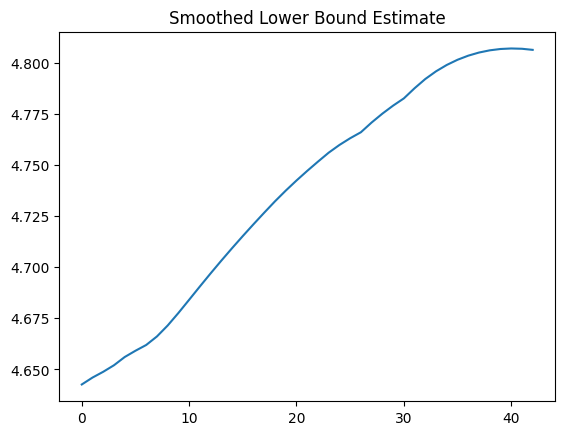

In [ ]:
lb_df = pd.DataFrame(np.array(LB_Smoothed[:43]))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

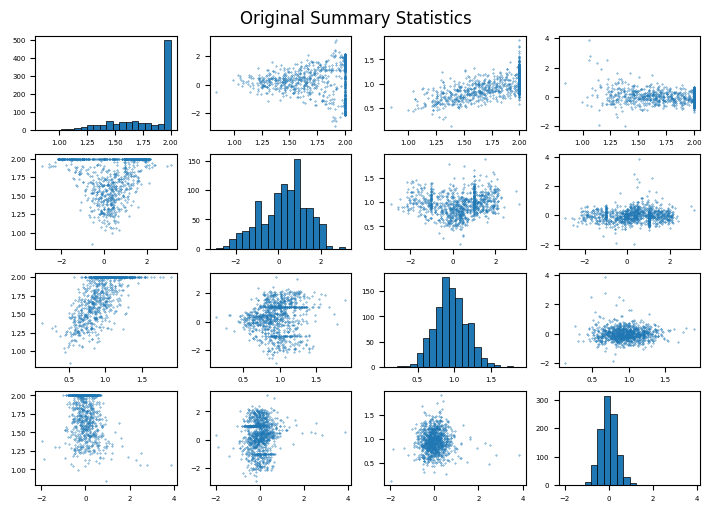

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


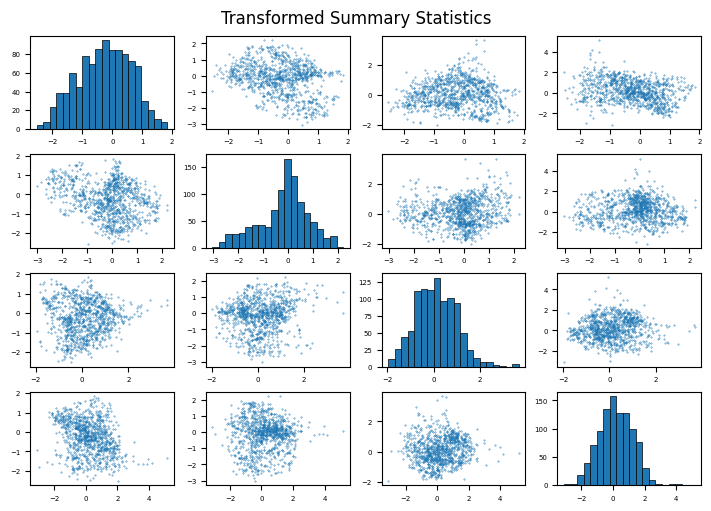

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

In [ ]:
# Save original data
np.save('alpha_original_without_tau.npy', val_n_summary_statistics)
np.save('alpha_transformed_without_tau.npy', wass_val_n_summary_statistics)
files.download('alpha_original_without_tau.npy')
files.download('alpha_transformed_without_tau.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the array from the file
val_n_summary_statistics = np.load('toad_original_with_tau.npy')
wass_val_n_summary_statistics = np.load('toad_transformed_with_tau.npy')

In [ ]:
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [ ]:
## Transform actual data
transformed_actual_summary_statistics = nf_transform(Lambda_list, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

Array([[-4.075626 , -1.8587439,  7.1461043, -0.8839911]], dtype=float32)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [ ]:
def summary_statistics(theta, n_samples, n_datasets): ## EQ 6
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = jnp.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    # cov = jnp.cov(transformed_summary_statistics.T)
    # sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)
    sample_precision = 1/eps_precision * jnp.eye(actual_summary_statistics.shape[0])
    for i in range(num_datasets): ## It will have i ranging from 0 to N-1
        diff = transformed_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * num_datasets ##### IS IT NEEDED??
    return sample_mean, sample_precision

In [ ]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_samples, n_datasets)
    # inverse_sample_precision = 1/n_datasets * eps_precision * jnp.eye(sample_variance.shape[0]) + sample_variance ############# USING EQ 4 to find inversion
    # adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(inverse_sample_precision)) * Gamma ## EQ 4
    # adjusted_sample_mean = sample_mean + ((jnp.diag(sample_precision))**(-1/2)) * Gamma ## EQ 4
    adjusted_sample_mean = sample_mean + (jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))) @ Gamma
    return adjusted_sample_mean, sample_precision

In [ ]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.identity(num_coeffs))
    return log_prior

In [ ]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_precision = mean_adjust_ss[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= inverse_sample_precision)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    u_est_log_likelihood = 1/2 * jnp.linalg.slogdet(sample_precision)[1] - 1/2 * part1
    return u_est_log_likelihood

In [ ]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [ ]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    # log_q = scipy.stats.multivariate_normal.logpdf(np.array(theta), mean = np.array(mu), cov= np.array(jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0]))), allow_singular = True)

    return log_q

In [ ]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [ ]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)
        alpha_q = (2 * jnp.exp(theta_tilde_q[0]) + 1.1) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (jnp.exp(theta_tilde_q[1]) - 1) / (jnp.exp(theta_tilde_q[1]) + 1)
        gamma_q = jnp.exp(theta_tilde_q[2])
        delta_q = theta_tilde_q[3]
        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_precision_q = ss_q[1]
        # sample_variance_q = ss_q[2]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision_q)].set(jnp.diag(sample_precision_q)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance_q = mean_nuissance_p1
        # print('var', variance_nuissance_q)
        # print('mean', mean_nuissance_q)

        # Generate Gamma

        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        h_lambda = prior(theta_tilde_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((1.8-1.1)/(2-1.8)),jnp.log((0.5+1)/(1-0.5)),jnp.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
vb = GVB(500, transformed_actual_summary_statistics[0], 0.0001, 2500, 100, 0.9, 0.9, 100, 20)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:19<21:17:11, 19.16s/it]

LB -16.823677


  0%|          | 2/4000 [00:35<19:41:54, 17.74s/it]

LB -16.980396


  0%|          | 3/4000 [00:52<19:15:24, 17.34s/it]

LB -16.949383


  0%|          | 4/4000 [01:09<19:05:17, 17.20s/it]

LB -16.918722


  0%|          | 5/4000 [01:26<19:05:29, 17.20s/it]

LB -16.87827


  0%|          | 6/4000 [01:43<18:56:30, 17.07s/it]

LB -16.925713


  0%|          | 7/4000 [02:00<18:50:00, 16.98s/it]

LB -16.94204


  0%|          | 8/4000 [02:17<18:56:01, 17.07s/it]

LB -16.939892


  0%|          | 9/4000 [02:34<18:50:03, 16.99s/it]

LB -16.8919


  0%|          | 10/4000 [02:51<18:47:23, 16.95s/it]

LB -16.975363


  0%|          | 11/4000 [03:08<18:43:02, 16.89s/it]

LB -16.990646


  0%|          | 12/4000 [03:25<18:42:56, 16.89s/it]

LB -16.976309


  0%|          | 13/4000 [03:41<18:40:09, 16.86s/it]

LB -16.8292


  0%|          | 14/4000 [03:58<18:37:43, 16.82s/it]

LB -16.992065


  0%|          | 15/4000 [04:16<18:48:48, 17.00s/it]

LB -16.834352


  0%|          | 16/4000 [04:33<18:47:06, 16.97s/it]

LB -16.819004


  0%|          | 17/4000 [04:49<18:43:38, 16.93s/it]

LB -16.950407


  0%|          | 18/4000 [05:07<18:50:30, 17.03s/it]

LB -16.911325


  0%|          | 19/4000 [05:24<18:53:10, 17.08s/it]

LB -17.027685


  0%|          | 20/4000 [05:41<18:49:43, 17.03s/it]

LB -16.912153


  1%|          | 21/4000 [05:57<18:43:35, 16.94s/it]

LB -16.97118


  1%|          | 22/4000 [06:14<18:41:38, 16.92s/it]

LB -16.982183


  1%|          | 23/4000 [06:31<18:36:29, 16.84s/it]

LB -16.969416


  1%|          | 24/4000 [06:48<18:35:39, 16.84s/it]

LB -16.782784


  1%|          | 25/4000 [07:04<18:30:10, 16.76s/it]

LB -16.923067


  1%|          | 26/4000 [07:21<18:26:50, 16.71s/it]

LB -16.99442


  1%|          | 27/4000 [07:38<18:29:51, 16.76s/it]

LB -16.948822


  1%|          | 28/4000 [07:55<18:31:44, 16.79s/it]

LB -16.875473


  1%|          | 29/4000 [08:12<18:33:20, 16.82s/it]

LB -16.887402


  1%|          | 30/4000 [08:28<18:30:35, 16.78s/it]

LB -16.806234


  1%|          | 31/4000 [08:45<18:28:33, 16.76s/it]

LB -17.028563


  1%|          | 32/4000 [09:02<18:31:32, 16.81s/it]

LB -16.933575


  1%|          | 33/4000 [09:19<18:28:42, 16.77s/it]

LB -16.985014


  1%|          | 34/4000 [09:36<18:33:20, 16.84s/it]

LB -16.997093


  1%|          | 35/4000 [09:52<18:29:45, 16.79s/it]

LB -16.96838


  1%|          | 36/4000 [10:09<18:30:02, 16.80s/it]

LB -16.930855


  1%|          | 37/4000 [10:26<18:33:56, 16.87s/it]

LB -16.802706


  1%|          | 38/4000 [10:43<18:32:55, 16.85s/it]

LB -16.855537


  1%|          | 39/4000 [11:00<18:31:23, 16.83s/it]

LB -16.951794


  1%|          | 40/4000 [11:16<18:29:03, 16.80s/it]

LB -16.994972


  1%|          | 41/4000 [11:33<18:31:55, 16.85s/it]

LB -17.035423


  1%|          | 42/4000 [11:50<18:30:18, 16.83s/it]

LB -16.966227


  1%|          | 43/4000 [12:07<18:28:58, 16.82s/it]

LB -16.920334


  1%|          | 44/4000 [12:24<18:26:14, 16.78s/it]

LB -16.985472


  1%|          | 45/4000 [12:40<18:23:19, 16.74s/it]

LB -16.972717


  1%|          | 46/4000 [12:57<18:29:07, 16.83s/it]

LB -16.904446


  1%|          | 47/4000 [13:14<18:27:14, 16.81s/it]

LB -16.80891


  1%|          | 48/4000 [13:31<18:24:34, 16.77s/it]

LB -16.974892


  1%|          | 49/4000 [13:48<18:23:34, 16.76s/it]

LB -17.00145


  1%|▏         | 50/4000 [14:04<18:18:58, 16.69s/it]

LB -16.948563


  1%|▏         | 51/4000 [14:21<18:19:01, 16.70s/it]

LB -16.889349


  1%|▏         | 52/4000 [14:38<18:19:14, 16.71s/it]

LB -16.891672


  1%|▏         | 53/4000 [14:54<18:16:39, 16.67s/it]

LB -16.98621


  1%|▏         | 54/4000 [15:11<18:17:40, 16.69s/it]

LB -16.99424


  1%|▏         | 55/4000 [15:28<18:21:26, 16.75s/it]

LB -17.067799


  1%|▏         | 56/4000 [15:45<18:21:47, 16.76s/it]

LB -16.914474


  1%|▏         | 57/4000 [16:01<18:20:56, 16.75s/it]

LB -16.794407


  1%|▏         | 58/4000 [16:18<18:20:13, 16.75s/it]

LB -16.974087


  1%|▏         | 59/4000 [16:35<18:21:11, 16.77s/it]

LB -16.973509


  2%|▏         | 60/4000 [16:52<18:20:48, 16.76s/it]

LB -16.95054


  2%|▏         | 61/4000 [17:08<18:18:06, 16.73s/it]

LB -17.077986


  2%|▏         | 62/4000 [17:25<18:18:32, 16.74s/it]

LB -16.89096


  2%|▏         | 63/4000 [17:42<18:18:50, 16.75s/it]

LB -16.97459


  2%|▏         | 64/4000 [17:58<18:17:11, 16.73s/it]

LB -16.920055


  2%|▏         | 65/4000 [18:15<18:17:42, 16.74s/it]

LB -16.951818


  2%|▏         | 66/4000 [18:32<18:13:57, 16.68s/it]

LB -16.850063


  2%|▏         | 67/4000 [18:49<18:16:00, 16.72s/it]

LB -16.979706


  2%|▏         | 68/4000 [19:06<18:20:45, 16.80s/it]

LB -17.008898


  2%|▏         | 69/4000 [19:22<18:21:16, 16.81s/it]

LB -16.843197


  2%|▏         | 70/4000 [19:39<18:20:13, 16.80s/it]

LB -16.84669


  2%|▏         | 71/4000 [19:56<18:24:08, 16.86s/it]

LB -16.939621


  2%|▏         | 72/4000 [20:13<18:26:21, 16.90s/it]

LB -16.862349


  2%|▏         | 73/4000 [20:30<18:34:30, 17.03s/it]

LB -16.965754


  2%|▏         | 74/4000 [20:48<18:38:04, 17.09s/it]

LB -16.877134


  2%|▏         | 75/4000 [21:05<18:40:04, 17.12s/it]

LB -16.943445


  2%|▏         | 76/4000 [21:22<18:42:40, 17.17s/it]

LB -16.862757


  2%|▏         | 77/4000 [21:39<18:37:00, 17.08s/it]

LB -17.081404


  2%|▏         | 78/4000 [21:56<18:36:43, 17.08s/it]

LB -16.93436


  2%|▏         | 79/4000 [22:13<18:33:34, 17.04s/it]

LB -16.918394


  2%|▏         | 80/4000 [22:30<18:32:35, 17.03s/it]

LB -16.70432


  2%|▏         | 81/4000 [22:47<18:35:11, 17.07s/it]

LB -16.937641


  2%|▏         | 82/4000 [23:05<18:40:14, 17.16s/it]

LB -16.923922


  2%|▏         | 83/4000 [23:22<18:36:44, 17.11s/it]

LB -16.937145


  2%|▏         | 84/4000 [23:39<18:35:30, 17.09s/it]

LB -17.060106


  2%|▏         | 85/4000 [23:56<18:37:45, 17.13s/it]

LB -16.971895


  2%|▏         | 86/4000 [24:13<18:38:10, 17.14s/it]

LB -16.937494


  2%|▏         | 87/4000 [24:30<18:42:26, 17.21s/it]

LB -16.956047


  2%|▏         | 88/4000 [24:48<18:42:41, 17.22s/it]

LB -16.921322


  2%|▏         | 89/4000 [25:05<18:43:27, 17.24s/it]

LB -16.898252


  2%|▏         | 90/4000 [25:22<18:44:25, 17.25s/it]

LB -16.859106


  2%|▏         | 91/4000 [25:40<18:46:54, 17.30s/it]

LB -16.956501


  2%|▏         | 92/4000 [25:57<18:49:41, 17.34s/it]

LB -16.89942


  2%|▏         | 93/4000 [26:14<18:43:26, 17.25s/it]

LB -17.06111


  2%|▏         | 94/4000 [26:31<18:44:33, 17.27s/it]

LB -16.942118


  2%|▏         | 95/4000 [26:48<18:35:25, 17.14s/it]

LB -16.91947


  2%|▏         | 96/4000 [27:05<18:32:32, 17.10s/it]

LB -16.941574


  2%|▏         | 97/4000 [27:22<18:22:30, 16.95s/it]

LB -16.96207


  2%|▏         | 98/4000 [27:39<18:21:10, 16.93s/it]

LB -16.976395


  2%|▏         | 99/4000 [27:56<18:22:11, 16.95s/it]

LB -16.962097


  2%|▎         | 100/4000 [28:13<18:22:27, 16.96s/it]

LB -16.922796


  3%|▎         | 101/4000 [28:30<18:23:23, 16.98s/it]

LB Smoothed -16.93504


  3%|▎         | 102/4000 [28:47<18:20:49, 16.94s/it]

LB Smoothed -16.93399


  3%|▎         | 103/4000 [29:03<18:17:36, 16.90s/it]

LB Smoothed -16.933432


  3%|▎         | 104/4000 [29:20<18:16:02, 16.88s/it]

LB Smoothed -16.933653


  3%|▎         | 105/4000 [29:37<18:16:47, 16.90s/it]

LB Smoothed -16.934294


  3%|▎         | 106/4000 [29:54<18:16:15, 16.89s/it]

LB Smoothed -16.934275


  3%|▎         | 107/4000 [30:11<18:17:45, 16.92s/it]

LB Smoothed -16.934175


  3%|▎         | 108/4000 [30:28<18:14:49, 16.88s/it]

LB Smoothed -16.9343


  3%|▎         | 109/4000 [30:45<18:26:32, 17.06s/it]

LB Smoothed -16.934269


  3%|▎         | 110/4000 [31:02<18:27:42, 17.09s/it]

LB Smoothed -16.932611


  3%|▎         | 111/4000 [31:20<18:27:00, 17.08s/it]

LB Smoothed -16.931213


  3%|▎         | 112/4000 [31:36<18:21:14, 16.99s/it]

LB Smoothed -16.92963


  3%|▎         | 113/4000 [31:53<18:20:34, 16.99s/it]

LB Smoothed -16.930368


  3%|▎         | 114/4000 [32:10<18:22:23, 17.02s/it]

LB Smoothed -16.92874


  3%|▎         | 115/4000 [32:28<18:23:51, 17.05s/it]

LB Smoothed -16.929132


  3%|▎         | 116/4000 [32:45<18:25:52, 17.08s/it]

LB Smoothed -16.930387


  3%|▎         | 117/4000 [33:02<18:21:35, 17.02s/it]

LB Smoothed -16.93035


  3%|▎         | 118/4000 [33:19<18:21:40, 17.03s/it]

LB Smoothed -16.930769


  3%|▎         | 119/4000 [33:36<18:20:30, 17.01s/it]

LB Smoothed -16.929941


  3%|▎         | 120/4000 [33:53<18:21:02, 17.03s/it]

LB Smoothed -16.9298


  3%|▎         | 121/4000 [34:10<18:21:44, 17.04s/it]

LB Smoothed -16.930275


  3%|▎         | 122/4000 [34:27<18:18:02, 16.99s/it]

LB Smoothed -16.928988


  3%|▎         | 123/4000 [34:43<18:16:04, 16.96s/it]

LB Smoothed -16.927473


  3%|▎         | 124/4000 [35:01<18:18:23, 17.00s/it]

LB Smoothed -16.930115


  3%|▎         | 125/4000 [35:18<18:27:26, 17.15s/it]

LB Smoothed -16.929537


  3%|▎         | 126/4000 [35:35<18:24:28, 17.11s/it]

LB Smoothed -16.929504


  3%|▎         | 127/4000 [35:52<18:23:47, 17.10s/it]

LB Smoothed -16.928923


  3%|▎         | 128/4000 [36:10<18:28:19, 17.17s/it]

LB Smoothed -16.930622


  3%|▎         | 129/4000 [36:27<18:26:36, 17.15s/it]

LB Smoothed -16.931227


  3%|▎         | 130/4000 [36:44<18:26:01, 17.15s/it]

LB Smoothed -16.932598


  3%|▎         | 131/4000 [37:01<18:24:36, 17.13s/it]

LB Smoothed -16.931099


  3%|▎         | 132/4000 [37:18<18:20:31, 17.07s/it]

LB Smoothed -16.930836


  3%|▎         | 133/4000 [37:35<18:17:55, 17.04s/it]

LB Smoothed -16.931263


  3%|▎         | 134/4000 [37:52<18:20:40, 17.08s/it]

LB Smoothed -16.93134


  3%|▎         | 135/4000 [38:09<18:18:24, 17.05s/it]

LB Smoothed -16.931389


  3%|▎         | 136/4000 [38:26<18:18:28, 17.06s/it]

LB Smoothed -16.931524


  3%|▎         | 137/4000 [38:43<18:16:15, 17.03s/it]

LB Smoothed -16.932636


  3%|▎         | 138/4000 [39:00<18:13:10, 16.98s/it]

LB Smoothed -16.932734


  3%|▎         | 139/4000 [39:17<18:09:37, 16.93s/it]

LB Smoothed -16.931768


  4%|▎         | 140/4000 [39:33<18:06:47, 16.89s/it]

LB Smoothed -16.930748


  4%|▎         | 141/4000 [39:50<18:07:25, 16.91s/it]

LB Smoothed -16.929445


  4%|▎         | 142/4000 [40:08<18:13:24, 17.00s/it]

LB Smoothed -16.930176


  4%|▎         | 143/4000 [40:25<18:18:02, 17.08s/it]

LB Smoothed -16.930058


  4%|▎         | 143/4000 [40:42<18:17:55, 17.08s/it]

LB Smoothed -16.93059
Stop at 143


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

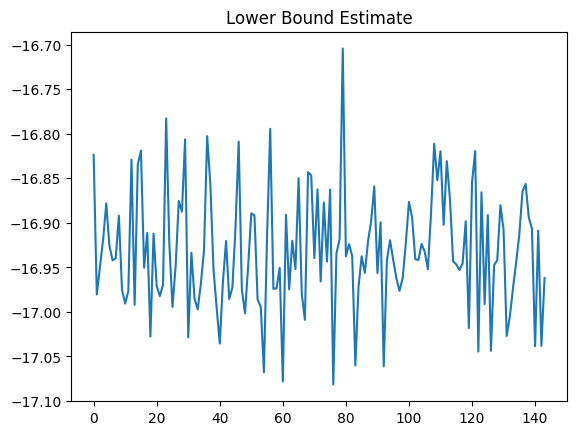

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

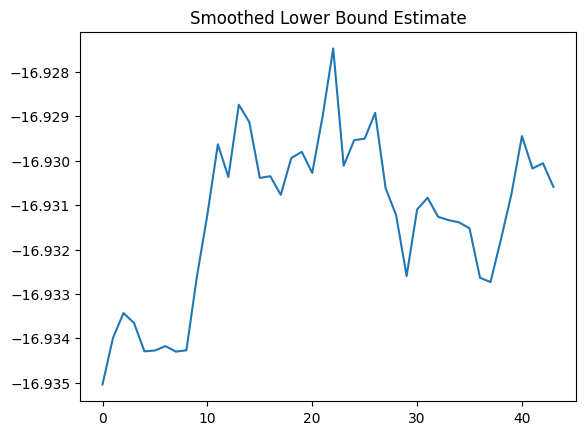

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_lambda_mu = jnp.array([1.2520645 ,  1.0964104 , -0.00194312, -0.001822])

In [ ]:
best_lambda_l = jnp.array([1.0000392e+01, -1.1230488e-03,  2.4190396e-03, -1.0683411e-03,
        9.9984140e+00, -3.6717164e-03,  1.7733632e-04,  1.0001250e+01,
       -2.2548139e-03,  1.0001479e+01])

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = ss_multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.79926592,  0.49691752,  1.00843163, -0.0024456 ])

In [ ]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.009333516

## Run MCMC

In [ ]:
num_samples = 3000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = jnp.array([jnp.log((1.8-1.1)/(2-1.8)),jnp.log((0.5+1)/(1-0.5)),jnp.log(1),0])

    alpha = (2 * jnp.exp(theta_tilde[0]) + 1.1) / (1 + jnp.exp(theta_tilde[0]))
    beta = (jnp.exp(theta_tilde[1]) - 1) / (1 + jnp.exp(theta_tilde[1]))
    gamma = jnp.exp(theta_tilde[2])
    delta = theta_tilde[3]

    theta = jnp.array([alpha, beta, gamma, delta])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_precision = ss[1]
    # sample_variance_q = ss_q[2]
    # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

    # Nuissance mean and variance: PAGE 9
    # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
    diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))
    # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
    mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision @ diag_precision
    mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
    # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_precision @ sample_precision @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
    variance_nuissance = mean_nuissance_p1
    # print(variance_nuissance_q)

    # Generate Gamma

    Gamma = ss_multivariate_normal.rvs(mean = mean_nuissance, cov = variance_nuissance)
    adjusted_theta = jnp.concatenate((theta, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, actual_summary_statistics, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)

    # ---------------------

    prior_current = prior(theta_tilde, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = jnp.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2/theta_size) * np.identity(theta_size)))
            else:
                theta_proposal_tilde = ss_multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)

        alpha_prop = (2 * jnp.exp(theta_proposal_tilde[0]) + 1.1) / (1 + jnp.exp(theta_proposal_tilde[0]))
        beta_prop = (jnp.exp(theta_proposal_tilde[1]) - 1) / (1 + jnp.exp(theta_proposal_tilde[1]))
        gamma_prop = jnp.exp(theta_proposal_tilde[2])
        delta_prop = theta_proposal_tilde[3]

        theta_proposal = jnp.array([alpha_prop, beta_prop, gamma_prop, delta_prop])

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_precision = ss[1]
        # sample_variance_q = ss_q[2]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_precision @ sample_precision @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance = mean_nuissance_p1
        # print(variance_nuissance_q)

        # Generate Gamma

        Gamma = ss_multivariate_normal.rvs(mean = mean_nuissance, cov = variance_nuissance)
        adjusted_theta_proposal = jnp.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # ---------------------

        prior_proposal = prior(theta_proposal_tilde, sigma_theta, num_coeffs)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [ ]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

  0%|          | 1/2999 [00:01<1:03:35,  1.27s/it]

0 [1.79618669 0.52125919 1.02365518 0.01237946]


  0%|          | 2/2999 [00:02<1:02:43,  1.26s/it]

1 [1.79789829 0.52003258 1.01990747 0.00801923]


  0%|          | 3/2999 [00:03<1:02:55,  1.26s/it]

2 [1.78588998 0.5274958  0.99979126 0.03652395]


  0%|          | 5/2999 [00:06<1:04:22,  1.29s/it]

4 [1.79063821 0.50802463 0.96397138 0.08791093]


  0%|          | 7/2999 [00:08<1:04:23,  1.29s/it]

6 [1.78715003 0.51942682 0.94176185 0.06224903]


  0%|          | 8/2999 [00:10<1:05:25,  1.31s/it]

7 [ 1.78826022e+00  5.04554570e-01  9.45579529e-01 -3.40915722e-04]


  0%|          | 9/2999 [00:11<1:04:14,  1.29s/it]

8 [1.78642201 0.51361555 0.9686926  0.00486277]


  0%|          | 10/2999 [00:12<1:04:13,  1.29s/it]

9 [1.78344774 0.49229383 0.97021335 0.04428935]


  0%|          | 11/2999 [00:14<1:05:45,  1.32s/it]

10 [1.78465116 0.47991344 0.90147936 0.0904844 ]


  0%|          | 12/2999 [00:15<1:03:56,  1.28s/it]

11 [1.78634405 0.49416971 0.91683811 0.11080097]


  0%|          | 13/2999 [00:16<1:02:58,  1.27s/it]

12 [1.78408921 0.48084554 0.90029192 0.15202561]


  0%|          | 14/2999 [00:18<1:04:05,  1.29s/it]

13 [1.78233576 0.46608311 0.88373196 0.16537578]


  1%|          | 15/2999 [00:19<1:03:46,  1.28s/it]

14 [1.77761197 0.46816269 0.90380591 0.18820107]


  1%|          | 18/2999 [00:23<1:04:35,  1.30s/it]

17 [1.7916702  0.4782795  0.93636823 0.19702654]


  1%|          | 19/2999 [00:24<1:05:13,  1.31s/it]

18 [1.80275023 0.49201393 0.90803885 0.24651521]


  1%|          | 20/2999 [00:25<1:03:57,  1.29s/it]

19 [1.80455613 0.48795128 0.97732794 0.3213858 ]


  1%|          | 21/2999 [00:27<1:03:05,  1.27s/it]

20 [1.80969119 0.47877732 0.96191674 0.29794496]


  1%|          | 22/2999 [00:28<1:02:14,  1.25s/it]

21 [1.81069028 0.46136975 0.94479859 0.24741513]


  1%|          | 24/2999 [00:30<1:03:18,  1.28s/it]

23 [1.81975627 0.44915321 0.91845053 0.19857258]


  1%|          | 26/2999 [00:33<1:03:39,  1.28s/it]

25 [1.82769811 0.4144327  0.85186386 0.23290658]


  1%|          | 31/2999 [00:39<1:03:40,  1.29s/it]

30 [1.8349359  0.39937484 0.86269444 0.18901722]


  1%|          | 34/2999 [00:43<1:02:31,  1.27s/it]

33 [1.83824432 0.40226284 0.85437298 0.1926682 ]


  1%|          | 37/2999 [00:47<1:02:07,  1.26s/it]

36 [1.83493304 0.40269849 0.7745223  0.19055359]


  1%|▏         | 38/2999 [00:48<1:01:23,  1.24s/it]

37 [1.84566164 0.39357376 0.82099777 0.24143176]


  1%|▏         | 39/2999 [00:49<1:01:11,  1.24s/it]

38 [1.85381973 0.38329577 0.83696741 0.27734762]


  1%|▏         | 40/2999 [00:51<1:02:13,  1.26s/it]

39 [1.84662604 0.36851147 0.9111954  0.25628254]


  1%|▏         | 41/2999 [00:52<1:02:57,  1.28s/it]

40 [1.851156   0.3623158  0.94432473 0.26792458]


  1%|▏         | 43/2999 [00:55<1:03:08,  1.28s/it]

42 [1.86145496 0.3845787  0.94777495 0.27250227]


  1%|▏         | 44/2999 [00:56<1:03:06,  1.28s/it]

43 [1.85747075 0.43515399 0.97431904 0.20144737]


  2%|▏         | 45/2999 [00:57<1:04:03,  1.30s/it]

44 [1.85342073 0.44944331 0.97220391 0.16664436]


  2%|▏         | 46/2999 [00:58<1:04:04,  1.30s/it]

45 [1.85173965 0.46496955 0.93915224 0.26623598]


  2%|▏         | 50/2999 [01:04<1:03:12,  1.29s/it]

49 [1.83428955 0.47400048 0.98023975 0.23959132]


  2%|▏         | 52/2999 [01:06<1:03:56,  1.30s/it]

51 [1.825387   0.48482624 0.90544814 0.22709823]


  2%|▏         | 57/2999 [01:13<1:04:01,  1.31s/it]

56 [1.81847584 0.4862465  0.89093238 0.18441173]


  2%|▏         | 58/2999 [01:14<1:03:20,  1.29s/it]

57 [1.81122684 0.50886047 0.92727888 0.26905322]


  2%|▏         | 59/2999 [01:15<1:04:40,  1.32s/it]

58 [1.80946946 0.52370077 0.87994242 0.25883794]


  2%|▏         | 60/2999 [01:17<1:03:19,  1.29s/it]

59 [1.80663919 0.55336857 0.94419891 0.22210018]


  2%|▏         | 61/2999 [01:18<1:02:59,  1.29s/it]

60 [1.80768597 0.55222768 0.9244836  0.24879223]


  2%|▏         | 62/2999 [01:19<1:01:51,  1.26s/it]

61 [1.81610322 0.58050561 0.93012798 0.22630686]


  2%|▏         | 63/2999 [01:20<1:03:05,  1.29s/it]

62 [1.80761564 0.57233828 0.94193572 0.30045485]


  2%|▏         | 65/2999 [01:23<1:04:53,  1.33s/it]

64 [1.81796658 0.56748277 0.87682408 0.24572685]


  2%|▏         | 66/2999 [01:24<1:04:24,  1.32s/it]

65 [1.81103337 0.57690448 0.87489134 0.21029395]


  2%|▏         | 72/2999 [01:32<1:03:49,  1.31s/it]

71 [1.80951703 0.56616271 0.94455647 0.15450451]


  2%|▏         | 74/2999 [01:35<1:03:19,  1.30s/it]

73 [1.80329347 0.55186379 0.98810166 0.08467849]


  3%|▎         | 75/2999 [01:36<1:02:32,  1.28s/it]

74 [1.80924094 0.5458976  0.97221756 0.06955381]


  3%|▎         | 76/2999 [01:37<1:03:25,  1.30s/it]

75 [ 1.81007802  0.54455876  1.02938831 -0.01520435]


  3%|▎         | 77/2999 [01:39<1:04:19,  1.32s/it]

76 [1.80308199 0.54183811 1.04042685 0.01629433]


  3%|▎         | 78/2999 [01:40<1:04:44,  1.33s/it]

77 [1.80147576 0.56829685 1.03694546 0.07396686]


  3%|▎         | 79/2999 [01:41<1:04:10,  1.32s/it]

78 [1.80483806 0.59457028 1.02804399 0.09980278]


  3%|▎         | 84/2999 [01:48<1:01:58,  1.28s/it]

83 [1.8047483  0.60231632 1.03520274 0.10012229]


  3%|▎         | 85/2999 [01:49<1:03:13,  1.30s/it]

84 [1.80439782 0.62677544 1.00954556 0.1190561 ]


  3%|▎         | 87/2999 [01:52<1:03:38,  1.31s/it]

86 [1.80569994 0.60854298 1.03014755 0.06093964]


  3%|▎         | 88/2999 [01:53<1:03:25,  1.31s/it]

87 [1.7952646  0.61741251 1.0577358  0.15238851]


  3%|▎         | 89/2999 [01:54<1:03:16,  1.30s/it]

88 [1.79106283 0.61501503 1.15041673 0.08297161]


  3%|▎         | 91/2999 [01:57<1:03:30,  1.31s/it]

90 [1.80459678 0.62367564 1.18747818 0.02437141]


  3%|▎         | 92/2999 [01:58<1:02:20,  1.29s/it]

91 [1.79560852 0.62537122 1.24328649 0.08445409]


  3%|▎         | 94/2999 [02:01<1:03:21,  1.31s/it]

93 [1.79584956 0.61064029 1.2346983  0.00223058]


  3%|▎         | 96/2999 [02:03<1:02:04,  1.28s/it]

95 [ 1.79609525  0.60075563  1.30026817 -0.11711407]


  3%|▎         | 97/2999 [02:05<1:02:01,  1.28s/it]

96 [ 1.80254114  0.59674752  1.22823274 -0.05345809]


  3%|▎         | 100/2999 [02:09<1:02:17,  1.29s/it]

99 [ 1.80322373  0.58606279  1.2644012  -0.02727696]


  3%|▎         | 101/2999 [02:10<1:02:41,  1.30s/it]

100 [ 1.79645729  0.55928808  1.29479194 -0.06950016]


  3%|▎         | 102/2999 [02:11<1:03:27,  1.31s/it]

101 [ 1.79977584  0.57392722  1.28620875 -0.05812786]


  3%|▎         | 103/2999 [02:13<1:03:05,  1.31s/it]

102 [1.7767086  0.5995664  1.35159492 0.00411646]


  4%|▎         | 107/2999 [02:18<1:01:47,  1.28s/it]

106 [1.76674676 0.59321362 1.16731119 0.00870083]


  4%|▍         | 113/2999 [02:25<1:02:40,  1.30s/it]

112 [ 1.75983799  0.59112513  1.08527386 -0.05622968]


  4%|▍         | 116/2999 [02:29<1:01:08,  1.27s/it]

115 [ 1.76132238  0.58831799  1.07505691 -0.04698675]


  4%|▍         | 117/2999 [02:31<1:01:23,  1.28s/it]

116 [ 1.75011814  0.61239636  1.10953295 -0.01164732]


  4%|▍         | 118/2999 [02:32<1:01:33,  1.28s/it]

117 [1.74957263 0.59367132 1.12181723 0.0185722 ]


  4%|▍         | 119/2999 [02:33<1:01:54,  1.29s/it]

118 [1.7527498  0.59747022 1.11424613 0.00619361]


  4%|▍         | 121/2999 [02:36<1:01:54,  1.29s/it]

120 [ 1.74096644  0.59714252  1.11837173 -0.08056373]


  4%|▍         | 122/2999 [02:37<1:00:43,  1.27s/it]

121 [ 1.7381568   0.6087389   1.16927576 -0.0381876 ]


  4%|▍         | 126/2999 [02:42<1:01:44,  1.29s/it]

125 [ 1.739115    0.61783868  1.18411839 -0.06256506]


  4%|▍         | 129/2999 [02:46<1:04:23,  1.35s/it]

128 [ 1.73414207  0.63041461  1.20750868 -0.00841097]


  4%|▍         | 130/2999 [02:48<1:04:35,  1.35s/it]

129 [ 1.73649836  0.61794943  1.24322391 -0.00591024]


  4%|▍         | 131/2999 [02:49<1:03:51,  1.34s/it]

130 [ 1.73909402  0.61316556  1.34925437 -0.00657756]


  4%|▍         | 132/2999 [02:50<1:02:51,  1.32s/it]

131 [ 1.72635746  0.6089803   1.38314879 -0.01192447]


  4%|▍         | 133/2999 [02:51<1:02:55,  1.32s/it]

132 [ 1.72264493  0.59900326  1.40924847 -0.05977695]


  4%|▍         | 134/2999 [02:53<1:03:05,  1.32s/it]

133 [ 1.71393454  0.59348279  1.42066562 -0.03606197]


  5%|▍         | 136/2999 [02:55<1:03:43,  1.34s/it]

135 [ 1.71349835  0.55645454  1.47747695 -0.08264491]


  5%|▍         | 137/2999 [02:57<1:04:00,  1.34s/it]

136 [ 1.71129811  0.57293701  1.37710047 -0.08682316]


  5%|▍         | 138/2999 [02:58<1:03:39,  1.33s/it]

137 [ 1.69612253  0.55618685  1.42463589 -0.09882422]


  5%|▍         | 141/2999 [03:02<1:02:02,  1.30s/it]

140 [ 1.69731224  0.59186637  1.58610368 -0.09591146]


  5%|▍         | 142/2999 [03:03<1:00:35,  1.27s/it]

141 [ 1.67633069  0.59350675  1.65264642 -0.0920116 ]


  5%|▍         | 143/2999 [03:04<1:00:28,  1.27s/it]

142 [ 1.68428564  0.57562202  1.73109829 -0.1050505 ]


  5%|▍         | 144/2999 [03:06<59:56,  1.26s/it]  

143 [ 1.68140137  0.56696159  1.73795891 -0.18979238]


  5%|▍         | 145/2999 [03:07<59:32,  1.25s/it]

144 [ 1.69088054  0.58699387  1.84466469 -0.21549226]


  5%|▍         | 146/2999 [03:08<1:00:18,  1.27s/it]

145 [ 1.7110064   0.58521318  2.01227331 -0.24976672]


  5%|▍         | 147/2999 [03:09<59:47,  1.26s/it]  

146 [ 1.71681321  0.56836563  2.05296254 -0.19541693]


  5%|▍         | 148/2999 [03:11<59:04,  1.24s/it]

147 [ 1.72840047  0.57517666  1.92076242 -0.27282602]


  5%|▌         | 150/2999 [03:13<1:00:37,  1.28s/it]

149 [ 1.73941541  0.56529498  1.8455615  -0.29858246]


  5%|▌         | 152/2999 [03:16<1:00:06,  1.27s/it]

151 [ 1.7589798   0.5944708   1.79983354 -0.37669107]


  5%|▌         | 153/2999 [03:17<1:00:14,  1.27s/it]

152 [ 1.76374459  0.56071985  2.00558639 -0.34387335]


  5%|▌         | 154/2999 [03:18<1:00:24,  1.27s/it]

153 [ 1.78036273  0.55704844  1.89713395 -0.34691623]


  5%|▌         | 156/2999 [03:21<1:02:23,  1.32s/it]

155 [ 1.78803754  0.56398261  1.87114871 -0.37255096]


  5%|▌         | 157/2999 [03:22<1:01:08,  1.29s/it]

156 [ 1.77047586  0.55056643  1.8774941  -0.30259365]


  5%|▌         | 158/2999 [03:24<1:01:49,  1.31s/it]

157 [ 1.76699519  0.58409399  1.80868423 -0.29326341]


  5%|▌         | 159/2999 [03:25<1:02:29,  1.32s/it]

158 [ 1.765239    0.57641631  1.78864729 -0.21962306]


  5%|▌         | 160/2999 [03:26<1:01:21,  1.30s/it]

159 [ 1.76677835  0.59399259  1.65927577 -0.39732775]


  5%|▌         | 161/2999 [03:27<1:01:18,  1.30s/it]

160 [ 1.77480161  0.58713782  1.78392804 -0.34622067]


  5%|▌         | 162/2999 [03:29<1:01:20,  1.30s/it]

161 [ 1.77992272  0.57686585  1.94069445 -0.35249555]


  5%|▌         | 163/2999 [03:30<1:02:12,  1.32s/it]

162 [ 1.7672646   0.58641303  2.06709409 -0.33375308]


  6%|▌         | 169/2999 [03:38<1:00:32,  1.28s/it]

168 [ 1.75332749  0.61544818  1.91226566 -0.32068676]


  6%|▌         | 171/2999 [03:41<1:00:37,  1.29s/it]

170 [ 1.74527311  0.60241663  1.97879744 -0.2420812 ]


  6%|▌         | 172/2999 [03:42<1:00:32,  1.29s/it]

171 [ 1.75507033  0.5862748   1.80275166 -0.24177121]


  6%|▌         | 174/2999 [03:44<1:00:12,  1.28s/it]

173 [ 1.75536466  0.59936583  1.68171585 -0.1749775 ]


  6%|▌         | 175/2999 [03:46<58:50,  1.25s/it]  

174 [ 1.76350987  0.58892357  1.85353696 -0.23567425]


  6%|▌         | 176/2999 [03:47<59:02,  1.25s/it]

175 [ 1.75603807  0.59927708  1.90512848 -0.21648711]


  6%|▌         | 177/2999 [03:48<58:55,  1.25s/it]

176 [ 1.75869238  0.60298526  1.86406553 -0.27163169]


  6%|▌         | 178/2999 [03:49<58:30,  1.24s/it]

177 [ 1.76150298  0.60707688  1.88720655 -0.29226238]


  6%|▌         | 180/2999 [03:52<59:30,  1.27s/it]

179 [ 1.77974141  0.58291221  1.92911863 -0.34649199]


  6%|▌         | 181/2999 [03:53<1:01:03,  1.30s/it]

180 [ 1.77643967  0.59771967  2.02840233 -0.2972973 ]


  6%|▌         | 182/2999 [03:55<1:01:16,  1.30s/it]

181 [ 1.77017891  0.60009354  2.05193686 -0.31079888]


  6%|▌         | 183/2999 [03:56<1:00:16,  1.28s/it]

182 [ 1.79099953  0.58314759  2.05398083 -0.35674956]


  6%|▌         | 186/2999 [04:00<1:00:21,  1.29s/it]

185 [ 1.80416512  0.60212821  2.2803483  -0.36923751]


  6%|▌         | 187/2999 [04:01<58:55,  1.26s/it]  

186 [ 1.80119777  0.59914851  2.19927907 -0.31199497]


  6%|▋         | 188/2999 [04:02<59:08,  1.26s/it]

187 [ 1.78939605  0.58565074  2.11782837 -0.35818404]


  6%|▋         | 189/2999 [04:03<59:58,  1.28s/it]

188 [ 1.77694714  0.5990985   1.97310269 -0.38575044]


  6%|▋         | 191/2999 [04:06<1:00:42,  1.30s/it]

190 [ 1.77467537  0.6013661   1.87153578 -0.34834808]


  6%|▋         | 192/2999 [04:07<1:00:38,  1.30s/it]

191 [ 1.77793396  0.61316645  1.99832487 -0.27529076]


  7%|▋         | 195/2999 [04:11<1:00:38,  1.30s/it]

194 [ 1.78160906  0.61803687  2.00741529 -0.25974458]


  7%|▋         | 198/2999 [04:15<58:46,  1.26s/it]  

197 [ 1.78135514  0.61008298  1.84606302 -0.28299841]


  7%|▋         | 199/2999 [04:16<58:57,  1.26s/it]

198 [ 1.76802135  0.65686512  1.93120122 -0.30160144]


  7%|▋         | 201/2999 [04:19<1:00:29,  1.30s/it]

200 [ 1.76646471  0.67091733  2.10137653 -0.26784217]


  7%|▋         | 203/2999 [04:21<1:00:02,  1.29s/it]

202 [ 1.75132072  0.66959137  2.04228997 -0.22788417]


  7%|▋         | 204/2999 [04:23<59:49,  1.28s/it]  

203 [ 1.75877786  0.67740172  1.90329039 -0.11262862]


  7%|▋         | 205/2999 [04:24<59:00,  1.27s/it]

204 [ 1.76850379  0.67004555  1.8939147  -0.04986889]


  7%|▋         | 206/2999 [04:25<58:19,  1.25s/it]

205 [ 1.7739898   0.69411814  2.10318065 -0.03722665]


  7%|▋         | 207/2999 [04:26<58:00,  1.25s/it]

206 [ 1.77965951  0.68851811  2.07540393 -0.09461432]


  7%|▋         | 209/2999 [04:29<58:25,  1.26s/it]

208 [ 1.7880888   0.69282281  2.09511495 -0.07038723]


  7%|▋         | 211/2999 [04:31<58:36,  1.26s/it]

210 [ 1.77912009  0.68606991  2.11742544 -0.0692529 ]


  7%|▋         | 213/2999 [04:34<58:51,  1.27s/it]

212 [ 1.77171397  0.68154651  1.96176791 -0.05503443]


  7%|▋         | 215/2999 [04:36<57:04,  1.23s/it]

214 [ 1.76651716  0.7031737   2.01432061 -0.0419211 ]


  7%|▋         | 216/2999 [04:38<57:15,  1.23s/it]

215 [ 1.76444697  0.69616675  2.0875535  -0.06204437]


  7%|▋         | 217/2999 [04:39<58:01,  1.25s/it]

216 [ 1.77005804  0.67935932  2.08691692 -0.04206714]


  7%|▋         | 218/2999 [04:40<59:33,  1.29s/it]

217 [ 1.76107264  0.68091172  1.96447396 -0.07753266]


  7%|▋         | 219/2999 [04:42<59:16,  1.28s/it]

218 [ 1.75899875  0.69593644  1.91717815 -0.22126231]


  7%|▋         | 221/2999 [04:44<1:00:54,  1.32s/it]

220 [ 1.76035094  0.7021963   1.95195365 -0.23633169]


  7%|▋         | 223/2999 [04:47<1:01:12,  1.32s/it]

222 [ 1.77207303  0.6999051   1.79682016 -0.15591355]


  7%|▋         | 224/2999 [04:48<1:00:28,  1.31s/it]

223 [ 1.76164854  0.71315163  1.83874667 -0.21229929]


  8%|▊         | 225/2999 [04:49<59:45,  1.29s/it]  

224 [ 1.75054407  0.70204943  1.93286932 -0.18111999]


  8%|▊         | 226/2999 [04:51<1:00:37,  1.31s/it]

225 [ 1.76156735  0.71574479  1.89558268 -0.16290984]


  8%|▊         | 227/2999 [04:52<1:00:01,  1.30s/it]

226 [ 1.75817633  0.72118926  1.96241462 -0.03731204]


  8%|▊         | 228/2999 [04:53<58:47,  1.27s/it]  

227 [ 1.76628923  0.70862573  2.03417945 -0.06376226]


  8%|▊         | 229/2999 [04:55<58:56,  1.28s/it]

228 [ 1.77584028  0.71534848  2.25241828 -0.0604693 ]


  8%|▊         | 230/2999 [04:56<58:59,  1.28s/it]

229 [ 1.77300704  0.70606112  2.18906283 -0.11544327]


  8%|▊         | 232/2999 [04:58<57:56,  1.26s/it]

231 [ 1.77562797  0.69635284  2.1159935  -0.0257054 ]


  8%|▊         | 234/2999 [05:01<57:43,  1.25s/it]

233 [ 1.75231397  0.7040453   2.06980681 -0.05869138]


  8%|▊         | 236/2999 [05:04<59:33,  1.29s/it]

235 [ 1.76288533  0.7094276   1.93900132 -0.06622877]


  8%|▊         | 238/2999 [05:06<1:00:13,  1.31s/it]

237 [ 1.77970064  0.71116346  1.97493792 -0.08853146]


  8%|▊         | 239/2999 [05:07<1:00:08,  1.31s/it]

238 [ 1.76708031  0.69618171  2.09440088 -0.0222531 ]


  8%|▊         | 240/2999 [05:09<59:55,  1.30s/it]  

239 [1.76150417 0.68264526 1.88115883 0.0308368 ]


  8%|▊         | 241/2999 [05:10<1:00:27,  1.32s/it]

240 [1.76255763 0.70135766 2.01298332 0.12196211]


  8%|▊         | 243/2999 [05:13<1:00:18,  1.31s/it]

242 [1.77758741 0.71244317 2.01355553 0.15213428]


  8%|▊         | 244/2999 [05:14<1:00:53,  1.33s/it]

243 [1.76909649 0.71377575 2.01328325 0.15768445]


  8%|▊         | 246/2999 [05:17<59:30,  1.30s/it]  

245 [1.76172566 0.71805978 2.0424912  0.17657916]


  8%|▊         | 247/2999 [05:18<59:04,  1.29s/it]

246 [1.76361191 0.70652223 1.93824351 0.23228966]


  8%|▊         | 249/2999 [05:20<59:16,  1.29s/it]

248 [1.76020837 0.70455843 1.94393229 0.25467473]


  8%|▊         | 251/2999 [05:23<1:00:44,  1.33s/it]

250 [1.73994362 0.7119301  1.99953413 0.22914299]


  8%|▊         | 254/2999 [05:27<1:00:05,  1.31s/it]

253 [1.73728573 0.71819758 2.08744717 0.16770832]


  9%|▊         | 255/2999 [05:28<1:00:25,  1.32s/it]

254 [1.7443825  0.72830081 1.9276371  0.21925154]


  9%|▊         | 258/2999 [05:32<59:52,  1.31s/it]

257 [1.72966313 0.72302359 1.92939746 0.22197053]


  9%|▊         | 259/2999 [05:34<1:00:03,  1.32s/it]

258 [1.72211564 0.7264514  2.04661751 0.31415612]


  9%|▊         | 260/2999 [05:35<59:01,  1.29s/it]  

259 [1.70683002 0.73631203 2.08470893 0.35901994]


  9%|▊         | 261/2999 [05:36<58:55,  1.29s/it]

260 [1.71044612 0.73878711 2.25182509 0.36593744]


  9%|▉         | 264/2999 [05:40<58:46,  1.29s/it]

263 [1.70357025 0.74911475 2.23695493 0.41808143]


  9%|▉         | 268/2999 [05:45<57:33,  1.26s/it]

267 [1.70113134 0.75315642 2.3315537  0.43942088]


  9%|▉         | 269/2999 [05:46<58:01,  1.28s/it]

268 [1.69869077 0.75245667 2.27465606 0.44951692]


  9%|▉         | 272/2999 [05:50<56:48,  1.25s/it]

271 [1.69279778 0.75453585 2.13768768 0.4494583 ]


  9%|▉         | 273/2999 [05:51<56:31,  1.24s/it]

272 [1.67544138 0.75208652 2.06002307 0.45803997]


  9%|▉         | 274/2999 [05:53<56:42,  1.25s/it]

273 [1.67106783 0.78345114 1.95576322 0.39810842]


  9%|▉         | 275/2999 [05:54<56:47,  1.25s/it]

274 [1.68640995 0.78400278 1.88622713 0.37154528]


  9%|▉         | 277/2999 [05:57<58:13,  1.28s/it]

276 [1.68442822 0.78522527 1.87125576 0.36870733]


  9%|▉         | 279/2999 [05:59<59:30,  1.31s/it]

278 [1.66594565 0.79741228 1.92038465 0.35930452]


  9%|▉         | 280/2999 [06:01<59:20,  1.31s/it]

279 [1.65694916 0.80375862 2.02536607 0.33936921]


  9%|▉         | 281/2999 [06:02<58:24,  1.29s/it]

280 [1.66550183 0.80405462 1.9940027  0.35012132]


  9%|▉         | 284/2999 [06:06<58:08,  1.28s/it]

283 [1.66799283 0.79892933 2.16218519 0.3519946 ]


 10%|▉         | 288/2999 [06:11<57:42,  1.28s/it]

287 [1.67032027 0.80215633 2.10898685 0.34870017]


 10%|▉         | 289/2999 [06:12<57:14,  1.27s/it]

288 [1.67464387 0.79714739 2.10896873 0.31082052]


 10%|▉         | 290/2999 [06:13<57:09,  1.27s/it]

289 [1.68151319 0.7869907  2.10529327 0.36839494]


 10%|▉         | 291/2999 [06:14<57:33,  1.28s/it]

290 [1.67394865 0.78933436 2.07686949 0.37475938]


 10%|▉         | 292/2999 [06:16<57:38,  1.28s/it]

291 [1.67461586 0.78787494 1.87571263 0.39503583]


 10%|▉         | 293/2999 [06:17<58:21,  1.29s/it]

292 [1.67206872 0.78643268 1.89974189 0.4134382 ]


 10%|▉         | 295/2999 [06:20<58:17,  1.29s/it]

294 [1.66140175 0.80257756 1.82516909 0.4694657 ]


 10%|▉         | 296/2999 [06:21<58:55,  1.31s/it]

295 [1.66204798 0.80627048 1.74708557 0.52197623]


 10%|▉         | 297/2999 [06:22<59:20,  1.32s/it]

296 [1.65846646 0.81325096 1.61214948 0.55742526]


 10%|▉         | 298/2999 [06:24<59:08,  1.31s/it]

297 [1.65908146 0.80555528 1.71458483 0.58532995]


 10%|▉         | 299/2999 [06:25<59:02,  1.31s/it]

298 [1.66835606 0.79741585 1.76493323 0.55330479]


 10%|█         | 302/2999 [06:29<57:44,  1.28s/it]

301 [1.67580986 0.79857695 1.67800272 0.56566709]


 10%|█         | 304/2999 [06:31<57:45,  1.29s/it]

303 [1.67981613 0.79105359 1.68492877 0.46089455]


 10%|█         | 306/2999 [06:34<59:07,  1.32s/it]

305 [1.68798244 0.78690618 1.74763012 0.51191109]


 10%|█         | 309/2999 [06:38<57:03,  1.27s/it]

308 [1.68368518 0.78921908 1.76340985 0.48568544]


 10%|█         | 310/2999 [06:39<58:13,  1.30s/it]

309 [1.67701852 0.79349041 1.79986441 0.48062348]


 10%|█         | 313/2999 [06:43<58:15,  1.30s/it]

312 [1.67786181 0.79585034 1.71248853 0.47379994]


 10%|█         | 314/2999 [06:44<57:42,  1.29s/it]

313 [1.65810251 0.78255492 1.79283428 0.45565853]


 11%|█         | 315/2999 [06:46<57:11,  1.28s/it]

314 [1.66291356 0.7805593  1.94441795 0.4469513 ]


 11%|█         | 316/2999 [06:47<57:35,  1.29s/it]

315 [1.66102219 0.76959932 1.95236337 0.50361419]


 11%|█         | 318/2999 [06:49<56:47,  1.27s/it]

317 [1.65634763 0.75732785 2.00269961 0.52548587]


 11%|█         | 319/2999 [06:51<56:01,  1.25s/it]

318 [1.65278471 0.77144992 1.93193781 0.54122669]


 11%|█         | 321/2999 [06:53<57:42,  1.29s/it]

320 [1.65251613 0.77898568 2.02119565 0.54923707]


 11%|█         | 322/2999 [06:55<57:37,  1.29s/it]

321 [1.64662266 0.78361899 2.06335235 0.54376131]


 11%|█         | 324/2999 [06:57<58:10,  1.30s/it]

323 [1.65465462 0.78738016 1.93317056 0.51305836]


 11%|█         | 325/2999 [06:59<58:30,  1.31s/it]

324 [1.67283642 0.79573572 1.85983455 0.44600433]


 11%|█         | 326/2999 [07:00<58:15,  1.31s/it]

325 [1.69129896 0.80639333 1.7699306  0.57330811]


 11%|█         | 327/2999 [07:01<58:01,  1.30s/it]

326 [1.68756866 0.81166446 1.778494   0.60664016]


 11%|█         | 328/2999 [07:02<57:40,  1.30s/it]

327 [1.67204714 0.80015206 1.82502306 0.54589009]


 11%|█         | 329/2999 [07:04<57:39,  1.30s/it]

328 [1.68398046 0.79685855 1.841272   0.54504049]


 11%|█         | 333/2999 [07:09<58:07,  1.31s/it]

332 [1.69202185 0.80267239 1.86128521 0.55281353]


 11%|█         | 334/2999 [07:10<56:27,  1.27s/it]

333 [1.678321   0.79659885 1.95212507 0.50387961]


 11%|█         | 335/2999 [07:11<56:12,  1.27s/it]

334 [1.69032156 0.79685557 2.01012588 0.44319105]


 11%|█▏        | 339/2999 [07:16<56:02,  1.26s/it]

338 [1.69631565 0.77991694 1.99108922 0.43974489]


 11%|█▏        | 341/2999 [07:19<57:19,  1.29s/it]

340 [1.70161116 0.776775   1.96264935 0.46188819]


 11%|█▏        | 342/2999 [07:20<56:20,  1.27s/it]

341 [1.68537033 0.77591884 1.69692147 0.44669396]


 11%|█▏        | 344/2999 [07:23<57:53,  1.31s/it]

343 [1.68611646 0.76915115 1.6861037  0.50797075]


 12%|█▏        | 345/2999 [07:24<57:43,  1.31s/it]

344 [1.69651937 0.75429803 1.70116365 0.56399441]


 12%|█▏        | 347/2999 [07:27<57:52,  1.31s/it]

346 [1.68998134 0.75081736 1.6472615  0.51866931]


 12%|█▏        | 348/2999 [07:28<57:03,  1.29s/it]

347 [1.69583333 0.74988222 1.65111971 0.54915172]


 12%|█▏        | 351/2999 [07:32<55:50,  1.27s/it]

350 [1.69019699 0.73830569 1.621768   0.59973413]


 12%|█▏        | 352/2999 [07:33<56:17,  1.28s/it]

351 [1.69042873 0.72936034 1.74110353 0.62360513]


 12%|█▏        | 353/2999 [07:34<55:54,  1.27s/it]

352 [1.6829747  0.72006565 1.69405341 0.65324926]


 12%|█▏        | 355/2999 [07:37<56:19,  1.28s/it]

354 [1.6789124  0.72096139 1.79541945 0.677396  ]


 12%|█▏        | 356/2999 [07:38<55:49,  1.27s/it]

355 [1.6871562  0.70995766 1.7439692  0.69086748]


 12%|█▏        | 357/2999 [07:39<55:23,  1.26s/it]

356 [1.68305373 0.70970619 1.64169097 0.69775748]


 12%|█▏        | 358/2999 [07:41<54:19,  1.23s/it]

357 [1.67611158 0.70996773 1.62882519 0.74362504]


 12%|█▏        | 359/2999 [07:42<55:08,  1.25s/it]

358 [1.67688835 0.70891958 1.60130918 0.79161793]


 12%|█▏        | 360/2999 [07:43<56:31,  1.29s/it]

359 [1.70159936 0.69851249 1.52709365 0.78767455]


 12%|█▏        | 362/2999 [07:46<56:18,  1.28s/it]

361 [1.69494689 0.70520937 1.4991138  0.77689791]


 12%|█▏        | 363/2999 [07:47<55:38,  1.27s/it]

362 [1.70018077 0.69824398 1.48730028 0.77877355]


 12%|█▏        | 364/2999 [07:48<55:39,  1.27s/it]

363 [1.69843423 0.7013548  1.57439673 0.78213656]


 12%|█▏        | 365/2999 [07:50<55:46,  1.27s/it]

364 [1.70340323 0.70254958 1.42413294 0.69321096]


 12%|█▏        | 366/2999 [07:51<56:48,  1.29s/it]

365 [1.69002211 0.68457973 1.45215416 0.74793416]


 12%|█▏        | 367/2999 [07:52<56:37,  1.29s/it]

366 [1.68017125 0.69171149 1.39373732 0.7495206 ]


 12%|█▏        | 369/2999 [07:55<57:40,  1.32s/it]

368 [1.67770505 0.7123192  1.3297323  0.72019529]


 12%|█▏        | 370/2999 [07:56<56:37,  1.29s/it]

369 [1.67794383 0.70832992 1.29324162 0.68574888]


 12%|█▏        | 373/2999 [08:00<56:45,  1.30s/it]

372 [1.67909956 0.70590228 1.28197968 0.69645697]


 12%|█▏        | 374/2999 [08:01<57:36,  1.32s/it]

373 [1.67359674 0.70073825 1.22123063 0.64342958]


 13%|█▎        | 375/2999 [08:03<56:32,  1.29s/it]

374 [1.66895318 0.70942032 1.26479113 0.51901317]


 13%|█▎        | 376/2999 [08:04<57:17,  1.31s/it]

375 [1.68750298 0.71189886 1.19049621 0.61134148]


 13%|█▎        | 377/2999 [08:05<57:23,  1.31s/it]

376 [1.69651282 0.72707212 1.19324601 0.66734821]


 13%|█▎        | 378/2999 [08:07<57:14,  1.31s/it]

377 [1.70244634 0.71327442 1.22329545 0.64711446]


 13%|█▎        | 379/2999 [08:08<57:52,  1.33s/it]

378 [1.68381226 0.72332752 1.1756413  0.66582417]


 13%|█▎        | 380/2999 [08:09<56:40,  1.30s/it]

379 [1.69005752 0.73689449 1.19209135 0.66412449]


 13%|█▎        | 382/2999 [08:12<57:14,  1.31s/it]

381 [1.6998558  0.74737728 1.18908453 0.70496875]


 13%|█▎        | 383/2999 [08:13<57:35,  1.32s/it]

382 [1.69763899 0.75951958 1.13507378 0.69351679]


 13%|█▎        | 384/2999 [08:15<58:20,  1.34s/it]

383 [1.70225453 0.76405406 1.17820787 0.69934064]


 13%|█▎        | 385/2999 [08:16<58:13,  1.34s/it]

384 [1.69224143 0.77480489 1.17997217 0.74336904]


 13%|█▎        | 386/2999 [08:17<56:42,  1.30s/it]

385 [1.66981745 0.77517718 1.23583198 0.72902256]


 13%|█▎        | 387/2999 [08:18<55:36,  1.28s/it]

386 [1.67301345 0.77759153 1.23962355 0.70172668]


 13%|█▎        | 388/2999 [08:20<55:27,  1.27s/it]

387 [1.6819948  0.77494687 1.24905169 0.67985862]


 13%|█▎        | 389/2999 [08:21<56:22,  1.30s/it]

388 [1.68214417 0.7883839  1.15857196 0.60139245]


 13%|█▎        | 390/2999 [08:22<55:58,  1.29s/it]

389 [1.67382181 0.78442836 1.13839614 0.52031046]


 13%|█▎        | 391/2999 [08:24<56:38,  1.30s/it]

390 [1.65638125 0.7893616  1.01457071 0.52574009]


 13%|█▎        | 392/2999 [08:25<56:22,  1.30s/it]

391 [1.66231775 0.77667576 1.00643384 0.58954793]


 13%|█▎        | 393/2999 [08:26<55:13,  1.27s/it]

392 [1.66292894 0.76583183 0.93409073 0.58530372]


 13%|█▎        | 394/2999 [08:27<56:02,  1.29s/it]

393 [1.6694932  0.76701015 0.90613526 0.65718281]


 13%|█▎        | 395/2999 [08:29<55:45,  1.28s/it]

394 [1.66074109 0.74997008 0.85750854 0.6671288 ]


 13%|█▎        | 396/2999 [08:30<55:51,  1.29s/it]

395 [1.66566396 0.75237572 0.9294343  0.684717  ]


 13%|█▎        | 397/2999 [08:31<56:07,  1.29s/it]

396 [1.66376209 0.77558643 0.89635563 0.66304839]


 13%|█▎        | 399/2999 [08:34<55:08,  1.27s/it]

398 [1.67406905 0.79961824 0.89572865 0.75869733]


 13%|█▎        | 400/2999 [08:35<54:57,  1.27s/it]

399 [1.64741647 0.78251272 0.87147355 0.84519523]


 13%|█▎        | 402/2999 [08:38<55:10,  1.27s/it]

401 [1.6371156  0.79357475 0.90500063 0.85317582]


 13%|█▎        | 404/2999 [08:40<56:07,  1.30s/it]

403 [1.63125145 0.7895804  0.80569106 0.91439205]


 14%|█▎        | 405/2999 [08:41<55:40,  1.29s/it]

404 [1.62964106 0.79505587 0.8037377  0.93964648]


 14%|█▎        | 406/2999 [08:43<55:38,  1.29s/it]

405 [1.63509166 0.77924502 0.79229945 0.86478335]


 14%|█▎        | 410/2999 [08:48<53:34,  1.24s/it]

409 [1.63329375 0.76967269 0.71258932 0.88509482]


 14%|█▎        | 412/2999 [08:50<55:22,  1.28s/it]

411 [1.64009404 0.78177035 0.69230622 0.92763156]


 14%|█▍        | 414/2999 [08:53<55:55,  1.30s/it]

413 [1.63198721 0.78476715 0.66111332 0.90565491]


 14%|█▍        | 415/2999 [08:54<55:48,  1.30s/it]

414 [1.63055563 0.7705617  0.7237848  0.92182815]


 14%|█▍        | 416/2999 [08:56<55:00,  1.28s/it]

415 [1.63099027 0.76553679 0.74812067 0.91642833]


 14%|█▍        | 417/2999 [08:57<55:29,  1.29s/it]

416 [1.63716352 0.77469307 0.76423353 0.88416415]


 14%|█▍        | 418/2999 [08:58<55:28,  1.29s/it]

417 [1.6427536  0.79170114 0.78990859 0.94432068]


 14%|█▍        | 422/2999 [09:03<53:35,  1.25s/it]

421 [1.65682065 0.79053736 0.76630265 0.97471392]


 14%|█▍        | 425/2999 [09:07<54:06,  1.26s/it]

424 [1.64586306 0.79713142 0.7516427  0.97505528]


 14%|█▍        | 428/2999 [09:11<56:18,  1.31s/it]

427 [1.65343511 0.80938566 0.74136668 1.00856435]


 14%|█▍        | 429/2999 [09:12<56:18,  1.31s/it]

428 [1.64980781 0.7938329  0.72110957 0.9024201 ]


 14%|█▍        | 430/2999 [09:14<55:52,  1.31s/it]

429 [1.63701046 0.79263592 0.69645888 0.89366227]


 14%|█▍        | 434/2999 [09:19<56:09,  1.31s/it]

433 [1.62285137 0.79388607 0.69017237 0.81599802]


 15%|█▍        | 435/2999 [09:20<54:39,  1.28s/it]

434 [1.63955665 0.78999221 0.65395862 0.89400405]


 15%|█▍        | 436/2999 [09:21<55:00,  1.29s/it]

435 [1.63831139 0.79768413 0.67809343 0.89041007]


 15%|█▍        | 437/2999 [09:23<54:32,  1.28s/it]

436 [1.62473905 0.78900063 0.64938217 0.88897276]


 15%|█▍        | 438/2999 [09:24<55:37,  1.30s/it]

437 [1.62184095 0.80769527 0.63512272 0.97802842]


 15%|█▍        | 439/2999 [09:25<55:25,  1.30s/it]

438 [1.61690629 0.81200194 0.68740183 0.98840553]


 15%|█▍        | 440/2999 [09:27<55:11,  1.29s/it]

439 [1.62906027 0.81502473 0.73577166 0.91084862]


 15%|█▍        | 442/2999 [09:29<54:50,  1.29s/it]

441 [1.61927581 0.80154264 0.75052416 0.98698407]


 15%|█▍        | 443/2999 [09:30<54:17,  1.27s/it]

442 [1.62561798 0.79205757 0.8591392  0.98678136]


 15%|█▍        | 446/2999 [09:34<54:38,  1.28s/it]

445 [1.62159085 0.79705375 0.86011654 1.09139144]


 15%|█▍        | 449/2999 [09:38<55:40,  1.31s/it]

448 [1.60709667 0.80293643 0.90115136 1.00761676]


 15%|█▌        | 450/2999 [09:39<55:22,  1.30s/it]

449 [1.60645819 0.80273575 0.93329418 1.02082157]


 15%|█▌        | 455/2999 [09:46<54:10,  1.28s/it]

454 [1.61675751 0.81876808 0.92154717 1.04578805]


 15%|█▌        | 456/2999 [09:47<54:25,  1.28s/it]

455 [1.59469593 0.80377436 0.86935455 1.10218   ]


 15%|█▌        | 458/2999 [09:49<52:42,  1.24s/it]

457 [1.58040726 0.79940915 0.83671033 1.08719265]


 15%|█▌        | 459/2999 [09:51<52:08,  1.23s/it]

458 [1.57648993 0.7960149  0.87675077 1.03896034]


 15%|█▌        | 460/2999 [09:52<51:40,  1.22s/it]

459 [1.58942449 0.79807085 0.92035663 1.08644104]


 15%|█▌        | 461/2999 [09:53<52:39,  1.25s/it]

460 [1.59866428 0.7914061  0.93752742 1.05556273]


 15%|█▌        | 463/2999 [09:56<53:12,  1.26s/it]

462 [1.61032879 0.79553306 0.90092909 1.01948631]


 16%|█▌        | 465/2999 [09:58<54:32,  1.29s/it]

464 [1.615821   0.79024565 0.82866257 0.95460588]


 16%|█▌        | 466/2999 [10:00<53:52,  1.28s/it]

465 [1.60683191 0.79753512 0.80177426 0.97303927]


 16%|█▌        | 468/2999 [10:02<53:51,  1.28s/it]

467 [1.59577405 0.80125999 0.76568383 0.95983613]


 16%|█▌        | 470/2999 [10:05<53:53,  1.28s/it]

469 [1.60137486 0.7828964  0.80044806 0.99750918]


 16%|█▌        | 471/2999 [10:06<53:44,  1.28s/it]

470 [1.57613313 0.78171039 0.77665395 1.0346235 ]


 16%|█▌        | 474/2999 [10:10<53:15,  1.27s/it]

473 [1.5912447  0.78341269 0.8010897  1.10864353]


 16%|█▌        | 476/2999 [10:12<51:13,  1.22s/it]

475 [1.57430112 0.77876014 0.85175097 1.04352129]


 16%|█▌        | 477/2999 [10:13<51:47,  1.23s/it]

476 [1.56888473 0.78646076 0.82821286 1.06484103]


 16%|█▌        | 480/2999 [10:17<53:55,  1.28s/it]

479 [1.57187474 0.78192037 0.80734247 1.0753715 ]


 16%|█▌        | 482/2999 [10:20<54:36,  1.30s/it]

481 [1.58567047 0.77176523 0.81497991 1.00829685]


 16%|█▌        | 483/2999 [10:21<54:57,  1.31s/it]

482 [1.58605468 0.78496534 0.78251737 1.04638326]


 16%|█▌        | 484/2999 [10:23<55:33,  1.33s/it]

483 [1.61021066 0.79359275 0.79560399 1.10877788]


 16%|█▌        | 485/2999 [10:24<54:41,  1.31s/it]

484 [1.61085689 0.7911399  0.72569335 1.11640894]


 16%|█▋        | 488/2999 [10:28<53:50,  1.29s/it]

487 [1.6024909  0.79765803 0.71724904 1.14925385]


 16%|█▋        | 490/2999 [10:30<52:19,  1.25s/it]

489 [1.61412036 0.80168802 0.74071836 1.14233029]


 16%|█▋        | 491/2999 [10:31<52:21,  1.25s/it]

490 [1.62572503 0.80799562 0.71731275 1.09188569]


 16%|█▋        | 494/2999 [10:35<53:09,  1.27s/it]

493 [1.62384987 0.82951093 0.73954254 1.0702368 ]


 17%|█▋        | 496/2999 [10:38<53:58,  1.29s/it]

495 [1.62199366 0.83402318 0.76118678 1.09882259]


 17%|█▋        | 497/2999 [10:39<53:04,  1.27s/it]

496 [1.61176658 0.82030892 0.80817205 1.08357787]


 17%|█▋        | 498/2999 [10:40<52:19,  1.26s/it]

497 [1.60828376 0.80830401 0.80735904 1.10967255]


 17%|█▋        | 500/2999 [10:43<52:37,  1.26s/it]

499 [1.6097368  0.8014456  0.86819279 1.14055037]


 17%|█▋        | 502/2999 [10:45<52:52,  1.27s/it]

501 [1.59079361 0.81888866 0.84558642 1.18611908]


 17%|█▋        | 503/2999 [10:47<52:08,  1.25s/it]

502 [1.59851491 0.81618273 0.86881924 1.10880101]


 17%|█▋        | 504/2999 [10:48<51:43,  1.24s/it]

503 [1.60237586 0.82752204 0.76325202 1.11259806]


 17%|█▋        | 505/2999 [10:49<51:48,  1.25s/it]

504 [1.60577714 0.83916199 0.72502875 1.09484339]


 17%|█▋        | 507/2999 [10:52<52:10,  1.26s/it]

506 [1.60943854 0.84987229 0.71894783 1.02245784]


 17%|█▋        | 508/2999 [10:53<52:02,  1.25s/it]

507 [1.6276865  0.8548432  0.70789647 0.93833125]


 17%|█▋        | 509/2999 [10:54<52:26,  1.26s/it]

508 [1.63487124 0.84986633 0.73836505 0.97655612]


 17%|█▋        | 510/2999 [10:55<53:12,  1.28s/it]

509 [1.62592244 0.86430293 0.83406609 0.93024915]


 17%|█▋        | 511/2999 [10:57<53:21,  1.29s/it]

510 [1.61351109 0.8619768  0.75244677 0.97662544]


 17%|█▋        | 512/2999 [10:58<52:40,  1.27s/it]

511 [1.61582088 0.85864639 0.72197247 0.97605574]


 17%|█▋        | 515/2999 [11:02<52:59,  1.28s/it]

514 [1.62073934 0.86091518 0.71999145 0.96033204]


 17%|█▋        | 516/2999 [11:03<52:58,  1.28s/it]

515 [1.61799407 0.84903932 0.72847444 1.0184902 ]


 17%|█▋        | 517/2999 [11:04<52:27,  1.27s/it]

516 [1.63712287 0.84945327 0.67196792 0.95922577]


 17%|█▋        | 518/2999 [11:06<53:18,  1.29s/it]

517 [1.64501524 0.85465699 0.73882473 0.95039511]


 17%|█▋        | 519/2999 [11:07<53:18,  1.29s/it]

518 [1.64946985 0.85873371 0.76942885 0.92821163]


 17%|█▋        | 520/2999 [11:08<52:13,  1.26s/it]

519 [1.64517915 0.85792631 0.83366722 0.9055053 ]


 17%|█▋        | 521/2999 [11:09<51:50,  1.26s/it]

520 [1.65278471 0.86666125 0.87768918 0.97239274]


 17%|█▋        | 522/2999 [11:11<51:09,  1.24s/it]

521 [1.67264652 0.86523163 0.90731966 1.02701283]


 17%|█▋        | 523/2999 [11:12<51:48,  1.26s/it]

522 [1.67244661 0.86872447 0.90242165 1.07719159]


 17%|█▋        | 524/2999 [11:13<51:53,  1.26s/it]

523 [1.6951381  0.86983806 0.93877339 1.14938581]


 18%|█▊        | 525/2999 [11:14<52:03,  1.26s/it]

524 [1.70248806 0.867854   1.00139141 1.21871734]


 18%|█▊        | 527/2999 [11:17<51:56,  1.26s/it]

526 [1.71095276 0.86838055 1.05856252 1.20936489]


 18%|█▊        | 529/2999 [11:20<54:30,  1.32s/it]

528 [1.70654035 0.86117369 1.05938828 1.20581353]


 18%|█▊        | 530/2999 [11:21<54:35,  1.33s/it]

529 [1.70137036 0.8511346  1.02758634 1.27475476]


 18%|█▊        | 531/2999 [11:22<53:48,  1.31s/it]

530 [1.71075451 0.84789491 0.90085143 1.20336485]


 18%|█▊        | 533/2999 [11:25<51:47,  1.26s/it]

532 [1.70142698 0.85372466 0.9203096  1.20717561]


 18%|█▊        | 534/2999 [11:26<50:59,  1.24s/it]

533 [1.69704247 0.85549426 0.8498072  1.15113401]


 18%|█▊        | 535/2999 [11:27<52:48,  1.29s/it]

534 [1.69422078 0.83846116 0.84973502 1.26757491]


 18%|█▊        | 536/2999 [11:29<52:45,  1.29s/it]

535 [1.69608736 0.83435756 0.8514545  1.2646693 ]


 18%|█▊        | 537/2999 [11:30<53:00,  1.29s/it]

536 [1.71779573 0.83660597 0.84313166 1.28452706]


 18%|█▊        | 538/2999 [11:31<53:45,  1.31s/it]

537 [1.72289038 0.84460819 0.8162154  1.32137501]


 18%|█▊        | 539/2999 [11:33<52:45,  1.29s/it]

538 [1.72904444 0.84089935 0.77963209 1.27936447]


 18%|█▊        | 540/2999 [11:34<52:00,  1.27s/it]

539 [1.72663796 0.83676332 0.74367559 1.30832779]


 18%|█▊        | 541/2999 [11:35<51:25,  1.26s/it]

540 [1.72763336 0.85927951 0.76513147 1.34446108]


 18%|█▊        | 543/2999 [11:37<50:36,  1.24s/it]

542 [1.72483754 0.85862911 0.67384905 1.27611864]


 18%|█▊        | 544/2999 [11:39<51:39,  1.26s/it]

543 [1.72380745 0.86500406 0.6441406  1.19804966]


 18%|█▊        | 547/2999 [11:43<52:48,  1.29s/it]

546 [1.72507429 0.86893684 0.64922595 1.17850542]


 18%|█▊        | 549/2999 [11:45<51:13,  1.25s/it]

548 [1.72415209 0.8540327  0.65763915 1.24921942]


 18%|█▊        | 550/2999 [11:46<51:38,  1.27s/it]

549 [1.73027098 0.8478232  0.63546747 1.2170409 ]


 18%|█▊        | 553/2999 [11:50<52:00,  1.28s/it]

552 [1.72203982 0.84077621 0.69351888 1.17133784]


 19%|█▊        | 555/2999 [11:53<53:04,  1.30s/it]

554 [1.71121788 0.83884323 0.69038969 1.20487309]


 19%|█▊        | 556/2999 [11:54<53:01,  1.30s/it]

555 [1.70425463 0.84741127 0.66861522 1.23504162]


 19%|█▊        | 557/2999 [11:55<52:00,  1.28s/it]

556 [1.68999243 0.85609353 0.71346438 1.26322222]


 19%|█▊        | 558/2999 [11:57<51:10,  1.26s/it]

557 [1.6841706  0.86712807 0.71335155 1.14624703]


 19%|█▊        | 559/2999 [11:58<51:14,  1.26s/it]

558 [1.684026   0.85997796 0.69253665 1.0423435 ]


 19%|█▊        | 560/2999 [11:59<51:56,  1.28s/it]

559 [1.68664253 0.86333054 0.70318329 0.99731934]


 19%|█▊        | 562/2999 [12:02<52:53,  1.30s/it]

561 [1.68747079 0.85159403 0.69067317 1.07844949]


 19%|█▉        | 563/2999 [12:03<53:20,  1.31s/it]

562 [1.69920433 0.83637261 0.74514616 1.08184934]


 19%|█▉        | 566/2999 [12:07<51:52,  1.28s/it]

565 [1.70808685 0.8519879  0.76259559 0.99562579]


 19%|█▉        | 567/2999 [12:08<51:33,  1.27s/it]

566 [1.71616626 0.85262185 0.81273198 0.95751899]


 19%|█▉        | 568/2999 [12:10<52:13,  1.29s/it]

567 [1.70124531 0.84352899 0.83180124 0.95621496]


 19%|█▉        | 569/2999 [12:11<51:57,  1.28s/it]

568 [1.7189151  0.85085702 0.74494022 0.97744393]


 19%|█▉        | 570/2999 [12:12<51:28,  1.27s/it]

569 [1.72726786 0.85905594 0.71196145 0.99134576]


 19%|█▉        | 571/2999 [12:13<50:54,  1.26s/it]

570 [1.72877288 0.85914624 0.69089377 0.99487388]


 19%|█▉        | 572/2999 [12:15<51:51,  1.28s/it]

571 [1.73790455 0.8617667  0.68716753 0.95998383]


 19%|█▉        | 574/2999 [12:17<52:47,  1.31s/it]

573 [1.73743081 0.87144142 0.63518924 0.96081638]


 19%|█▉        | 575/2999 [12:19<52:08,  1.29s/it]

574 [1.75360227 0.87107831 0.60661602 0.93278944]


 19%|█▉        | 576/2999 [12:20<51:38,  1.28s/it]

575 [1.75428343 0.87092608 0.61429727 0.88801676]


 19%|█▉        | 577/2999 [12:21<51:58,  1.29s/it]

576 [1.76516211 0.87807822 0.61086082 0.8955425 ]


 19%|█▉        | 578/2999 [12:22<52:44,  1.31s/it]

577 [1.75950229 0.87148124 0.65272766 0.9336974 ]


 19%|█▉        | 579/2999 [12:24<52:07,  1.29s/it]

578 [1.76783049 0.85549724 0.63504523 0.9218511 ]


 19%|█▉        | 580/2999 [12:25<52:18,  1.30s/it]

579 [1.76515973 0.86022353 0.64768553 0.91779935]


 19%|█▉        | 581/2999 [12:26<52:28,  1.30s/it]

580 [1.76246214 0.8515467  0.6321106  0.90671492]


 19%|█▉        | 582/2999 [12:28<52:13,  1.30s/it]

581 [1.75518942 0.85376245 0.62632316 0.82232511]


 19%|█▉        | 584/2999 [12:30<50:52,  1.26s/it]

583 [1.75648928 0.85441065 0.61609119 0.77411288]


 20%|█▉        | 586/2999 [12:33<50:00,  1.24s/it]

585 [1.76588953 0.86159521 0.6079421  0.75822353]


 20%|█▉        | 587/2999 [12:34<50:43,  1.26s/it]

586 [1.7451452  0.87457305 0.59890997 0.83509541]


 20%|█▉        | 589/2999 [12:36<51:11,  1.27s/it]

588 [1.74021673 0.868734   0.56242001 0.76661164]


 20%|█▉        | 590/2999 [12:38<51:52,  1.29s/it]

589 [1.73678064 0.86895365 0.54248857 0.82775426]


 20%|█▉        | 592/2999 [12:40<51:00,  1.27s/it]

591 [1.73230767 0.87504005 0.56301117 0.82482767]


 20%|█▉        | 593/2999 [12:42<51:27,  1.28s/it]

592 [1.73927033 0.87424707 0.52069074 0.78464556]


 20%|█▉        | 594/2999 [12:43<51:30,  1.28s/it]

593 [1.73264635 0.87769943 0.50646383 0.78426689]


 20%|█▉        | 595/2999 [12:44<52:31,  1.31s/it]

594 [1.73106217 0.88156521 0.49904034 0.86276275]


 20%|█▉        | 596/2999 [12:46<52:49,  1.32s/it]

595 [1.72650766 0.88272339 0.51974481 0.89985931]


 20%|█▉        | 598/2999 [12:48<52:21,  1.31s/it]

597 [1.71627808 0.87311572 0.54974651 0.97412395]


 20%|██        | 604/2999 [12:56<51:35,  1.29s/it]

603 [1.70689225 0.86410815 0.52618122 0.96000952]


 20%|██        | 605/2999 [12:57<52:00,  1.30s/it]

604 [1.70561266 0.86689836 0.52434313 0.88100314]


 20%|██        | 606/2999 [12:59<52:38,  1.32s/it]

605 [1.72252929 0.87575877 0.55193049 0.87956476]


 20%|██        | 607/2999 [13:00<52:44,  1.32s/it]

606 [1.71597314 0.87816113 0.55348194 0.80951428]


 20%|██        | 608/2999 [13:01<53:23,  1.34s/it]

607 [1.71288717 0.87818676 0.58348489 0.83653176]


 20%|██        | 609/2999 [13:03<52:29,  1.32s/it]

608 [1.70741224 0.87760669 0.57493633 0.75818342]


 20%|██        | 611/2999 [13:05<52:54,  1.33s/it]

610 [1.70627594 0.88247842 0.56668413 0.82962608]


 20%|██        | 612/2999 [13:07<53:28,  1.34s/it]

611 [1.70590353 0.88484299 0.57613516 0.82592815]


 20%|██        | 613/2999 [13:08<53:32,  1.35s/it]

612 [1.69979882 0.88140547 0.61835843 0.74411803]


 20%|██        | 614/2999 [13:09<53:18,  1.34s/it]

613 [1.70625007 0.88303035 0.60885608 0.66019553]


 21%|██        | 617/2999 [13:13<52:23,  1.32s/it]

616 [1.70121098 0.88578278 0.6515047  0.7071591 ]


 21%|██        | 618/2999 [13:15<51:22,  1.29s/it]

617 [1.70971406 0.88345444 0.63765663 0.67841566]


 21%|██        | 619/2999 [13:16<51:57,  1.31s/it]

618 [1.70358121 0.88479269 0.66486841 0.69598609]


 21%|██        | 620/2999 [13:17<51:22,  1.30s/it]

619 [1.70423841 0.88448864 0.66455328 0.65486163]


 21%|██        | 621/2999 [13:19<51:33,  1.30s/it]

620 [1.7117101  0.88602132 0.65474927 0.71312517]


 21%|██        | 624/2999 [13:22<52:09,  1.32s/it]

623 [1.71482861 0.89229333 0.62786168 0.72719532]


 21%|██        | 625/2999 [13:24<52:44,  1.33s/it]

624 [1.70791101 0.89026839 0.62956446 0.74200571]


 21%|██        | 626/2999 [13:25<52:28,  1.33s/it]

625 [1.72048795 0.88923609 0.6532622  0.76750642]


 21%|██        | 627/2999 [13:27<52:35,  1.33s/it]

626 [1.71079564 0.88565534 0.66284531 0.72618985]


 21%|██        | 628/2999 [13:28<51:45,  1.31s/it]

627 [1.73212743 0.89478517 0.67255026 0.67277139]


 21%|██        | 629/2999 [13:29<51:25,  1.30s/it]

628 [1.73833227 0.90430439 0.64455211 0.66755718]


 21%|██        | 630/2999 [13:30<51:41,  1.31s/it]

629 [1.7443254  0.89665121 0.62276727 0.66203701]


 21%|██        | 631/2999 [13:32<50:45,  1.29s/it]

630 [1.7434454  0.90099055 0.62506711 0.67271411]


 21%|██        | 633/2999 [13:34<51:00,  1.29s/it]

632 [1.73877895 0.90049851 0.60494965 0.65453798]


 21%|██        | 634/2999 [13:36<51:28,  1.31s/it]

633 [1.74360359 0.90034616 0.56797874 0.67089963]


 21%|██        | 635/2999 [13:37<50:51,  1.29s/it]

634 [1.7436204  0.89629149 0.63257599 0.74079484]


 21%|██▏       | 638/2999 [13:41<51:15,  1.30s/it]

637 [1.74260521 0.89822412 0.67393959 0.80371821]


 21%|██▏       | 639/2999 [13:42<51:26,  1.31s/it]

638 [1.75329721 0.90136164 0.66311258 0.80669338]


 21%|██▏       | 640/2999 [13:43<51:06,  1.30s/it]

639 [1.74381495 0.90314901 0.6813302  0.76331764]


 21%|██▏       | 641/2999 [13:45<50:42,  1.29s/it]

640 [1.76098967 0.90616316 0.62127262 0.71938586]


 21%|██▏       | 642/2999 [13:46<51:34,  1.31s/it]

641 [1.76721585 0.90909672 0.64237976 0.76078522]


 21%|██▏       | 643/2999 [13:47<52:00,  1.32s/it]

642 [1.76163769 0.91275913 0.60327494 0.76277232]


 21%|██▏       | 644/2999 [13:49<51:53,  1.32s/it]

643 [1.7715615  0.90427864 0.57554561 0.80640256]


 22%|██▏       | 645/2999 [13:50<50:08,  1.28s/it]

644 [1.78749728 0.90126854 0.57089496 0.82891887]


 22%|██▏       | 647/2999 [13:52<49:25,  1.26s/it]

646 [1.78716242 0.90173739 0.58845288 0.85371989]


 22%|██▏       | 649/2999 [13:55<49:21,  1.26s/it]

648 [1.78300655 0.89959425 0.64049059 0.84496921]


 22%|██▏       | 651/2999 [13:57<49:51,  1.27s/it]

650 [1.790748   0.90049839 0.6437524  0.86273229]


 22%|██▏       | 652/2999 [13:59<49:22,  1.26s/it]

651 [1.80004001 0.89307153 0.58287078 0.91947025]


 22%|██▏       | 653/2999 [14:00<49:05,  1.26s/it]

652 [1.7925123  0.89493561 0.583951   0.84041154]


 22%|██▏       | 654/2999 [14:01<49:12,  1.26s/it]

653 [1.80169952 0.89173239 0.638834   0.87837762]


 22%|██▏       | 655/2999 [14:02<49:07,  1.26s/it]

654 [1.80301285 0.89036924 0.67130077 0.84109992]


 22%|██▏       | 656/2999 [14:04<49:31,  1.27s/it]

655 [1.81586909 0.89142394 0.74395907 0.83251691]


 22%|██▏       | 657/2999 [14:05<49:16,  1.26s/it]

656 [1.81290567 0.8947171  0.75491989 0.80590802]


 22%|██▏       | 658/2999 [14:06<49:42,  1.27s/it]

657 [1.8293339  0.8948527  0.75837421 0.6898213 ]


 22%|██▏       | 659/2999 [14:07<49:35,  1.27s/it]

658 [1.81758106 0.89185232 0.75400555 0.6868723 ]


 22%|██▏       | 660/2999 [14:09<50:33,  1.30s/it]

659 [1.82697439 0.89021266 0.72234374 0.72427064]


 22%|██▏       | 664/2999 [14:14<49:55,  1.28s/it]

663 [1.83765268 0.89541471 0.72375578 0.77756667]


 22%|██▏       | 665/2999 [14:15<49:58,  1.28s/it]

664 [1.83838189 0.89380366 0.68184388 0.68824977]


 22%|██▏       | 666/2999 [14:17<50:57,  1.31s/it]

665 [1.84136546 0.89282948 0.74412185 0.73805779]


 22%|██▏       | 667/2999 [14:18<50:33,  1.30s/it]

666 [1.84639859 0.88530463 0.75298315 0.73101038]


 22%|██▏       | 668/2999 [14:19<50:57,  1.31s/it]

667 [1.85030866 0.87908739 0.69671112 0.81496865]


 22%|██▏       | 669/2999 [14:21<51:42,  1.33s/it]

668 [1.85059524 0.87519604 0.77304131 0.80688965]


 22%|██▏       | 670/2999 [14:22<51:31,  1.33s/it]

669 [1.85962534 0.85533774 0.73283297 0.76593798]


 22%|██▏       | 671/2999 [14:23<51:04,  1.32s/it]

670 [1.8528223  0.85439754 0.74557579 0.80919927]


 22%|██▏       | 672/2999 [14:24<51:09,  1.32s/it]

671 [1.84726346 0.84074128 0.72725284 0.8152889 ]


 22%|██▏       | 674/2999 [14:27<49:44,  1.28s/it]

673 [1.83367789 0.83234423 0.73969281 0.89279997]


 23%|██▎       | 675/2999 [14:28<50:11,  1.30s/it]

674 [1.82465351 0.8345468  0.72428834 0.87723327]


 23%|██▎       | 677/2999 [14:31<50:26,  1.30s/it]

676 [1.82404101 0.83402663 0.70734215 0.72234917]


 23%|██▎       | 678/2999 [14:32<51:05,  1.32s/it]

677 [1.82923341 0.82717413 0.78849679 0.64719152]


 23%|██▎       | 679/2999 [14:34<51:11,  1.32s/it]

678 [1.82945895 0.81421888 0.85987711 0.59560931]


 23%|██▎       | 682/2999 [14:37<50:04,  1.30s/it]

681 [1.82937253 0.80351365 0.85965919 0.56719989]


 23%|██▎       | 685/2999 [14:41<50:13,  1.30s/it]

684 [1.83715951 0.79108477 0.85636622 0.55783516]


 23%|██▎       | 686/2999 [14:43<50:40,  1.31s/it]

685 [1.83719265 0.80001825 0.78842556 0.52252007]


 23%|██▎       | 687/2999 [14:44<50:39,  1.31s/it]

686 [1.83667994 0.80454797 0.74167943 0.57757807]


 23%|██▎       | 688/2999 [14:45<51:40,  1.34s/it]

687 [1.83440363 0.81548876 0.82492208 0.56616944]


 23%|██▎       | 689/2999 [14:47<51:21,  1.33s/it]

688 [1.83539701 0.81249845 0.78060073 0.43137005]


 23%|██▎       | 690/2999 [14:48<50:53,  1.32s/it]

689 [1.82564342 0.81352472 0.83647704 0.45271361]


 23%|██▎       | 691/2999 [14:49<50:02,  1.30s/it]

690 [1.83160424 0.81552625 0.82730359 0.48433939]


 23%|██▎       | 692/2999 [14:51<49:30,  1.29s/it]

691 [1.83441699 0.8124609  0.86006838 0.44432083]


 23%|██▎       | 693/2999 [14:52<49:46,  1.30s/it]

692 [1.83719373 0.81622899 0.90575099 0.38904637]


 23%|██▎       | 694/2999 [14:53<49:17,  1.28s/it]

693 [1.83245838 0.81775045 0.90634251 0.38434824]


 23%|██▎       | 696/2999 [14:56<50:24,  1.31s/it]

695 [1.81759632 0.81764716 0.96035534 0.40235168]


 23%|██▎       | 697/2999 [14:57<50:06,  1.31s/it]

696 [1.81035352 0.82547462 0.8956992  0.40011412]


 23%|██▎       | 699/2999 [15:00<49:56,  1.30s/it]

698 [1.81600511 0.82774478 0.93018067 0.39829233]


 23%|██▎       | 700/2999 [15:01<49:47,  1.30s/it]

699 [1.81867647 0.8226642  1.00838912 0.47254047]


 23%|██▎       | 701/2999 [15:02<49:36,  1.30s/it]

700 [1.81729591 0.82329953 0.91105795 0.48987085]


 23%|██▎       | 702/2999 [15:04<48:54,  1.28s/it]

701 [1.80978215 0.82612807 0.92727727 0.47836611]


 23%|██▎       | 703/2999 [15:05<49:27,  1.29s/it]

702 [1.81413627 0.82264727 0.88223344 0.45522079]


 23%|██▎       | 704/2999 [15:06<49:27,  1.29s/it]

703 [1.81943393 0.82199711 0.85885358 0.48691335]


 24%|██▎       | 705/2999 [15:07<49:23,  1.29s/it]

704 [1.81595302 0.81230056 0.87998444 0.50131685]


 24%|██▎       | 706/2999 [15:09<49:51,  1.30s/it]

705 [1.82380342 0.81201172 0.85004508 0.47408405]


 24%|██▎       | 707/2999 [15:10<50:06,  1.31s/it]

706 [1.83880973 0.81417483 0.82928926 0.49948242]


 24%|██▎       | 708/2999 [15:11<49:10,  1.29s/it]

707 [1.84680867 0.79047394 0.90662932 0.41497716]


 24%|██▎       | 711/2999 [15:15<49:36,  1.30s/it]

710 [1.83460104 0.76842242 0.85519505 0.44656095]


 24%|██▍       | 713/2999 [15:18<49:06,  1.29s/it]

712 [1.82427835 0.75634938 0.84670341 0.44590092]


 24%|██▍       | 714/2999 [15:19<49:06,  1.29s/it]

713 [1.82913065 0.76176929 0.77612555 0.49103898]


 24%|██▍       | 715/2999 [15:20<49:26,  1.30s/it]

714 [1.8261224  0.7559731  0.83756053 0.46182033]


 24%|██▍       | 718/2999 [15:24<48:20,  1.27s/it]

717 [1.82103896 0.76565164 0.90365583 0.45954099]


 24%|██▍       | 719/2999 [15:26<49:18,  1.30s/it]

718 [1.82396889 0.75108624 0.9306705  0.48518822]


 24%|██▍       | 722/2999 [15:29<48:56,  1.29s/it]

721 [1.82546639 0.76042378 0.89670902 0.4637087 ]


 24%|██▍       | 723/2999 [15:31<49:35,  1.31s/it]

722 [1.83754814 0.77049488 0.88780749 0.46959004]


 24%|██▍       | 726/2999 [15:35<48:31,  1.28s/it]

725 [1.83269656 0.76199609 0.83079326 0.52260882]


 24%|██▍       | 727/2999 [15:36<49:02,  1.30s/it]

726 [1.8305068  0.75281525 0.88563168 0.4654623 ]


 24%|██▍       | 728/2999 [15:37<48:35,  1.28s/it]

727 [1.83235812 0.75942117 0.89882058 0.54464048]


 24%|██▍       | 729/2999 [15:38<48:22,  1.28s/it]

728 [1.82193768 0.76759446 0.85826802 0.51697707]


 24%|██▍       | 730/2999 [15:40<49:16,  1.30s/it]

729 [1.82061458 0.7697705  0.8421126  0.4700312 ]


 24%|██▍       | 733/2999 [15:44<48:29,  1.28s/it]

732 [1.82831514 0.76048261 0.89068407 0.42019966]


 24%|██▍       | 734/2999 [15:45<49:02,  1.30s/it]

733 [1.81471467 0.75758511 0.89803118 0.40876079]


 25%|██▍       | 735/2999 [15:46<49:15,  1.31s/it]

734 [1.82483399 0.76366311 0.9463917  0.46035424]


 25%|██▍       | 736/2999 [15:48<49:03,  1.30s/it]

735 [1.81980228 0.76492053 1.00456536 0.55053389]


 25%|██▍       | 739/2999 [15:51<48:40,  1.29s/it]

738 [1.83084631 0.77752173 1.01169145 0.64862841]


 25%|██▍       | 741/2999 [15:54<48:20,  1.28s/it]

740 [1.82674575 0.77159959 1.0360558  0.64916706]


 25%|██▍       | 742/2999 [15:55<48:18,  1.28s/it]

741 [1.82536006 0.78833139 1.09566689 0.55138338]


 25%|██▍       | 743/2999 [15:57<48:42,  1.30s/it]

742 [1.82145345 0.78433585 1.09768295 0.51221818]


 25%|██▍       | 744/2999 [15:58<48:43,  1.30s/it]

743 [1.82599759 0.78994232 1.07947659 0.40612748]


 25%|██▍       | 745/2999 [15:59<48:20,  1.29s/it]

744 [1.82079518 0.78901094 1.02727115 0.39247739]


 25%|██▍       | 746/2999 [16:00<47:41,  1.27s/it]

745 [1.81108713 0.79180497 1.07865882 0.42889154]


 25%|██▍       | 748/2999 [16:03<48:33,  1.29s/it]

747 [1.80131185 0.79180539 1.02974474 0.49921924]


 25%|██▍       | 749/2999 [16:04<48:19,  1.29s/it]

748 [1.80809414 0.80746877 1.00667274 0.50976139]


 25%|██▌       | 751/2999 [16:07<49:00,  1.31s/it]

750 [1.81810296 0.79597396 1.04992855 0.44075903]


 25%|██▌       | 752/2999 [16:08<49:12,  1.31s/it]

751 [1.81325221 0.79424274 1.04953849 0.46556529]


 25%|██▌       | 753/2999 [16:10<49:13,  1.32s/it]

752 [1.80229902 0.79718775 1.08222044 0.46367389]


 25%|██▌       | 754/2999 [16:11<48:29,  1.30s/it]

753 [1.79952896 0.78885972 1.06179905 0.46601418]


 25%|██▌       | 755/2999 [16:12<48:55,  1.31s/it]

754 [1.80391061 0.79908526 1.0827775  0.43693295]


 25%|██▌       | 756/2999 [16:13<48:50,  1.31s/it]

755 [1.80851817 0.79804361 1.04415381 0.40094808]


 25%|██▌       | 757/2999 [16:15<49:06,  1.31s/it]

756 [1.79971528 0.77949476 0.98758006 0.40910077]


 25%|██▌       | 758/2999 [16:16<48:08,  1.29s/it]

757 [1.7928679  0.76380682 0.98570114 0.41571635]


 25%|██▌       | 763/2999 [16:23<48:40,  1.31s/it]

762 [1.80310941 0.75741804 1.05909514 0.41189978]


 25%|██▌       | 764/2999 [16:24<48:26,  1.30s/it]

763 [1.7861408  0.75874221 0.96885806 0.29300258]


 26%|██▌       | 768/2999 [16:29<47:33,  1.28s/it]

767 [1.78927326 0.76149839 1.00365269 0.24455577]


 26%|██▌       | 769/2999 [16:30<47:14,  1.27s/it]

768 [1.7900759  0.77280807 1.00577521 0.24986573]


 26%|██▌       | 770/2999 [16:31<46:55,  1.26s/it]

769 [1.79892445 0.77405739 1.10696208 0.30746168]


 26%|██▌       | 771/2999 [16:33<46:39,  1.26s/it]

770 [1.80069709 0.77636063 1.07956517 0.28740996]


 26%|██▌       | 772/2999 [16:34<46:26,  1.25s/it]

771 [1.80361879 0.77609682 1.05479038 0.24211852]


 26%|██▌       | 773/2999 [16:35<46:07,  1.24s/it]

772 [1.80385089 0.78665203 0.99616957 0.20380506]


 26%|██▌       | 774/2999 [16:36<46:39,  1.26s/it]

773 [1.80626941 0.79379815 1.12871742 0.21931688]


 26%|██▌       | 775/2999 [16:38<46:58,  1.27s/it]

774 [1.80523145 0.81312996 1.08061147 0.20001684]


 26%|██▌       | 776/2999 [16:39<46:23,  1.25s/it]

775 [1.79875255 0.81023538 1.08433485 0.25598553]


 26%|██▌       | 777/2999 [16:40<46:52,  1.27s/it]

776 [1.80202019 0.8188594  1.07496977 0.22611591]


 26%|██▌       | 778/2999 [16:42<48:09,  1.30s/it]

777 [1.80781341 0.82799822 1.05500281 0.20206606]


 26%|██▌       | 779/2999 [16:43<48:15,  1.30s/it]

778 [1.80581737 0.81697345 0.96074164 0.21035279]


 26%|██▌       | 780/2999 [16:44<47:57,  1.30s/it]

779 [1.79707992 0.82793814 0.98857158 0.14163187]


 26%|██▌       | 782/2999 [16:47<47:01,  1.27s/it]

781 [1.79799676 0.83832866 0.9814831  0.15938835]


 26%|██▌       | 783/2999 [16:48<48:26,  1.31s/it]

782 [1.78912032 0.83516562 1.03072309 0.17643788]


 26%|██▌       | 786/2999 [16:52<47:17,  1.28s/it]

785 [1.78298926 0.83026195 0.99619138 0.15713643]


 26%|██▋       | 788/2999 [16:55<47:24,  1.29s/it]

787 [1.79096651 0.82516229 1.05029583 0.09471363]


 26%|██▋       | 791/2999 [16:58<47:34,  1.29s/it]

790 [1.79117751 0.83907098 1.06028235 0.03527142]


 26%|██▋       | 793/2999 [17:01<47:23,  1.29s/it]

792 [ 1.79045379  0.84981877  1.05180335 -0.05026956]


 26%|██▋       | 794/2999 [17:02<47:05,  1.28s/it]

793 [ 1.7866025   0.85505599  0.98752767 -0.02209601]


 27%|██▋       | 795/2999 [17:04<47:24,  1.29s/it]

794 [1.80973828 0.85185432 0.9353376  0.01742461]


 27%|██▋       | 796/2999 [17:05<47:23,  1.29s/it]

795 [ 1.81509578  0.84835458  0.93678349 -0.14837502]


 27%|██▋       | 797/2999 [17:06<46:47,  1.27s/it]

796 [ 1.81905103  0.84353709  0.87312615 -0.09994784]


 27%|██▋       | 798/2999 [17:07<46:53,  1.28s/it]

797 [ 1.803321    0.85336906  0.83264589 -0.04174984]


 27%|██▋       | 799/2999 [17:09<46:52,  1.28s/it]

798 [ 1.80457318  0.85138535  0.86117005 -0.0650354 ]


 27%|██▋       | 801/2999 [17:11<47:28,  1.30s/it]

800 [ 1.80262899  0.84936595  0.91402769 -0.05984399]


 27%|██▋       | 802/2999 [17:13<48:32,  1.33s/it]

801 [ 1.80445194  0.84298116  0.86904073 -0.0611199 ]


 27%|██▋       | 803/2999 [17:14<48:14,  1.32s/it]

802 [ 1.81182098  0.85199517  0.83902264 -0.14252245]


 27%|██▋       | 807/2999 [17:19<47:51,  1.31s/it]

806 [ 1.80038095  0.85718417  0.88393545 -0.17683718]


 27%|██▋       | 808/2999 [17:21<47:56,  1.31s/it]

807 [ 1.78727376  0.86066222  0.93064898 -0.15098663]


 27%|██▋       | 810/2999 [17:23<47:32,  1.30s/it]

809 [ 1.78032064  0.86185175  0.92143965 -0.1887264 ]


 27%|██▋       | 813/2999 [17:27<46:50,  1.29s/it]

812 [ 1.77694106  0.86102349  0.96913803 -0.16908084]


 27%|██▋       | 814/2999 [17:28<47:13,  1.30s/it]

813 [ 1.77403843  0.86008555  1.00508177 -0.17857203]


 27%|██▋       | 816/2999 [17:31<47:19,  1.30s/it]

815 [ 1.77745354  0.86829478  1.07175946 -0.20496574]


 27%|██▋       | 817/2999 [17:32<47:11,  1.30s/it]

816 [ 1.7903403   0.86700678  1.0074954  -0.25149462]


 27%|██▋       | 818/2999 [17:34<47:46,  1.31s/it]

817 [ 1.77249563  0.86342824  1.03621817 -0.27531254]


 27%|██▋       | 819/2999 [17:35<47:19,  1.30s/it]

818 [ 1.771649    0.86284     1.13268352 -0.28551951]


 27%|██▋       | 822/2999 [17:39<46:26,  1.28s/it]

821 [ 1.78570116  0.85919052  1.1230346  -0.32305872]


 28%|██▊       | 825/2999 [17:42<46:00,  1.27s/it]

824 [ 1.78261077  0.85807139  1.16689992 -0.36019734]


 28%|██▊       | 826/2999 [17:44<46:21,  1.28s/it]

825 [ 1.79782951  0.85680598  1.18331003 -0.3894805 ]


 28%|██▊       | 827/2999 [17:45<46:55,  1.30s/it]

826 [ 1.79848909  0.85451579  1.21579707 -0.43736064]


 28%|██▊       | 832/2999 [17:52<46:54,  1.30s/it]

831 [ 1.79722464  0.8499611   1.22934318 -0.45341623]


 28%|██▊       | 835/2999 [17:55<45:33,  1.26s/it]

834 [ 1.80377853  0.8508215   1.17052472 -0.4396466 ]


 28%|██▊       | 837/2999 [17:58<45:42,  1.27s/it]

836 [ 1.79695177  0.84931129  1.09351921 -0.4199926 ]


 28%|██▊       | 839/2999 [18:00<44:54,  1.25s/it]

838 [ 1.78758299  0.84619337  1.18513751 -0.41268304]


 28%|██▊       | 840/2999 [18:02<44:42,  1.24s/it]

839 [ 1.78429747  0.84283787  1.11428642 -0.39219013]


 28%|██▊       | 841/2999 [18:03<44:14,  1.23s/it]

840 [ 1.78218102  0.83912301  1.07301664 -0.41869015]


 28%|██▊       | 842/2999 [18:04<44:42,  1.24s/it]

841 [ 1.784006    0.8314445   1.14347935 -0.38892326]


 28%|██▊       | 843/2999 [18:05<45:01,  1.25s/it]

842 [ 1.78451061  0.82321429  1.17566419 -0.3913902 ]


 28%|██▊       | 844/2999 [18:07<45:39,  1.27s/it]

843 [ 1.78229654  0.82408398  1.08883059 -0.31533623]


 28%|██▊       | 845/2999 [18:08<46:14,  1.29s/it]

844 [ 1.77554929  0.82016397  1.08850288 -0.28227502]


 28%|██▊       | 846/2999 [18:09<46:29,  1.30s/it]

845 [ 1.78129387  0.82854986  1.02222157 -0.34597796]


 28%|██▊       | 848/2999 [18:12<46:52,  1.31s/it]

847 [ 1.77333558  0.83235598  0.97820377 -0.29947153]


 28%|██▊       | 849/2999 [18:13<45:57,  1.28s/it]

848 [ 1.76477671  0.84367734  0.96902376 -0.32264653]


 28%|██▊       | 850/2999 [18:14<46:23,  1.30s/it]

849 [ 1.77278662  0.83527052  1.04993927 -0.26890057]


 28%|██▊       | 851/2999 [18:16<46:55,  1.31s/it]

850 [ 1.77289069  0.83595037  0.97752315 -0.29350105]


 28%|██▊       | 852/2999 [18:17<46:37,  1.30s/it]

851 [ 1.7756443   0.82014441  0.9507637  -0.30186012]


 28%|██▊       | 854/2999 [18:20<47:30,  1.33s/it]

853 [ 1.76759088  0.81603116  0.96597856 -0.3347764 ]


 29%|██▊       | 856/2999 [18:23<47:53,  1.34s/it]

855 [ 1.75866032  0.80531216  0.92839456 -0.38107267]


 29%|██▊       | 858/2999 [18:25<47:28,  1.33s/it]

857 [ 1.76363611  0.79386389  0.88147336 -0.28021705]


 29%|██▊       | 859/2999 [18:26<47:01,  1.32s/it]

858 [ 1.76673293  0.78385329  0.86996698 -0.23171338]


 29%|██▊       | 861/2999 [18:29<46:09,  1.30s/it]

860 [ 1.76521873  0.77555174  0.86667204 -0.20586851]


 29%|██▊       | 862/2999 [18:30<46:55,  1.32s/it]

861 [ 1.74624968  0.78458011  0.89024758 -0.23444165]


 29%|██▉       | 863/2999 [18:32<47:15,  1.33s/it]

862 [ 1.75413585  0.7687754   0.93120962 -0.30326909]


 29%|██▉       | 864/2999 [18:33<46:35,  1.31s/it]

863 [ 1.75494516  0.7667191   1.00103092 -0.27389339]


 29%|██▉       | 865/2999 [18:34<46:18,  1.30s/it]

864 [ 1.76181269  0.77054226  1.09378636 -0.33271244]


 29%|██▉       | 866/2999 [18:36<46:07,  1.30s/it]

865 [ 1.74944949  0.76944232  0.99833101 -0.34748721]


 29%|██▉       | 867/2999 [18:37<46:38,  1.31s/it]

866 [ 1.74390197  0.77262282  0.8926698  -0.41363031]


 29%|██▉       | 868/2999 [18:38<46:43,  1.32s/it]

867 [ 1.7434622   0.75826222  0.91866505 -0.44000649]


 29%|██▉       | 869/2999 [18:40<46:50,  1.32s/it]

868 [ 1.75004983  0.77158928  0.91300201 -0.4500294 ]


 29%|██▉       | 870/2999 [18:41<46:42,  1.32s/it]

869 [ 1.74688232  0.76914042  0.91849184 -0.53221917]


 29%|██▉       | 872/2999 [18:44<47:36,  1.34s/it]

871 [ 1.74912     0.77576178  0.97007108 -0.532125  ]


 29%|██▉       | 874/2999 [18:46<47:12,  1.33s/it]

873 [ 1.75002277  0.7786926   0.91599584 -0.60577065]


 29%|██▉       | 880/2999 [18:54<46:01,  1.30s/it]

879 [ 1.7506125   0.76772207  0.97029626 -0.57019031]


 29%|██▉       | 882/2999 [18:57<45:35,  1.29s/it]

881 [ 1.75284457  0.76835835  0.92327523 -0.650612  ]


 29%|██▉       | 883/2999 [18:58<46:31,  1.32s/it]

882 [ 1.75406671  0.7700153   0.91735011 -0.66500372]


 29%|██▉       | 884/2999 [18:59<45:56,  1.30s/it]

883 [ 1.7547152   0.78607726  0.87716043 -0.69240093]


 30%|██▉       | 885/2999 [19:01<45:24,  1.29s/it]

884 [ 1.75671279  0.80211115  0.97550434 -0.7040028 ]


 30%|██▉       | 886/2999 [19:02<46:16,  1.31s/it]

885 [ 1.76114881  0.79307139  1.01477599 -0.6719417 ]


 30%|██▉       | 887/2999 [19:03<46:45,  1.33s/it]

886 [ 1.7711755   0.7799409   1.02166009 -0.77016377]


 30%|██▉       | 888/2999 [19:05<46:49,  1.33s/it]

887 [ 1.76551783  0.78406358  0.99437159 -0.83210135]


 30%|██▉       | 889/2999 [19:06<46:55,  1.33s/it]

888 [ 1.77421498  0.79155749  1.03041077 -0.87532377]


 30%|██▉       | 890/2999 [19:07<46:21,  1.32s/it]

889 [ 1.7783736   0.79400688  1.06962574 -0.89900124]


 30%|██▉       | 891/2999 [19:08<45:32,  1.30s/it]

890 [ 1.78551948  0.79989201  0.99721181 -0.91825235]


 30%|██▉       | 892/2999 [19:10<45:35,  1.30s/it]

891 [ 1.77113795  0.80345136  0.9474386  -0.95525587]


 30%|██▉       | 893/2999 [19:11<46:25,  1.32s/it]

892 [ 1.78646266  0.81318563  0.91557527 -0.92920679]


 30%|██▉       | 894/2999 [19:13<47:15,  1.35s/it]

893 [ 1.79912603  0.80731881  0.89140296 -0.90791196]


 30%|██▉       | 896/2999 [19:15<46:30,  1.33s/it]

895 [ 1.79688466  0.81263417  0.93686891 -0.83054709]


 30%|██▉       | 897/2999 [19:16<46:05,  1.32s/it]

896 [ 1.7912395   0.81147099  0.86072063 -0.71840185]


 30%|██▉       | 898/2999 [19:18<45:09,  1.29s/it]

897 [ 1.79325926  0.80945772  0.88386387 -0.651097  ]


 30%|██▉       | 899/2999 [19:19<45:08,  1.29s/it]

898 [ 1.79103374  0.80529088  0.90439475 -0.65932536]


 30%|███       | 904/2999 [19:25<45:30,  1.30s/it]

903 [ 1.79288626  0.78443813  0.93495613 -0.57769233]


 30%|███       | 905/2999 [19:27<46:13,  1.32s/it]

904 [ 1.79299998  0.77234781  1.01757479 -0.58221638]


 30%|███       | 906/2999 [19:28<46:08,  1.32s/it]

905 [ 1.78761637  0.77356303  0.95740426 -0.6235885 ]


 30%|███       | 907/2999 [19:29<44:31,  1.28s/it]

906 [ 1.7937094   0.75000238  0.97689211 -0.65855938]


 30%|███       | 908/2999 [19:31<44:23,  1.27s/it]

907 [ 1.78973281  0.75662202  0.88998467 -0.63200003]


 30%|███       | 909/2999 [19:32<44:48,  1.29s/it]

908 [ 1.78210497  0.76151788  0.85015982 -0.63513416]


 30%|███       | 910/2999 [19:33<44:22,  1.27s/it]

909 [ 1.78133285  0.75844187  0.78040409 -0.69700706]


 30%|███       | 911/2999 [19:34<44:38,  1.28s/it]

910 [ 1.79272854  0.75902867  0.74733895 -0.77510411]


 30%|███       | 912/2999 [19:36<44:02,  1.27s/it]

911 [ 1.78696513  0.76475722  0.72388738 -0.68638086]


 30%|███       | 913/2999 [19:37<45:26,  1.31s/it]

912 [ 1.79360902  0.78349942  0.71371293 -0.66120958]


 31%|███       | 915/2999 [19:40<46:31,  1.34s/it]

914 [ 1.7965883   0.78732151  0.71020514 -0.70755887]


 31%|███       | 916/2999 [19:41<45:51,  1.32s/it]

915 [ 1.78421676  0.78547859  0.71400934 -0.68306136]


 31%|███       | 917/2999 [19:42<45:36,  1.31s/it]

916 [ 1.79360628  0.79649836  0.72146744 -0.68032455]


 31%|███       | 919/2999 [19:45<44:25,  1.28s/it]

918 [ 1.78952944  0.80340558  0.72809333 -0.7558046 ]


 31%|███       | 920/2999 [19:46<44:04,  1.27s/it]

919 [ 1.78543448  0.79710215  0.75402087 -0.86787796]


 31%|███       | 921/2999 [19:47<43:51,  1.27s/it]

920 [ 1.78587389  0.7989639   0.7402339  -0.85413116]


 31%|███       | 922/2999 [19:49<43:52,  1.27s/it]

921 [ 1.79507601  0.80978858  0.6790641  -0.88805842]


 31%|███       | 924/2999 [19:51<44:50,  1.30s/it]

923 [ 1.78431273  0.79726994  0.68301845 -0.8485148 ]


 31%|███       | 927/2999 [19:55<45:36,  1.32s/it]

926 [ 1.77507865  0.78653282  0.72680604 -0.88956404]


 31%|███       | 928/2999 [19:57<45:19,  1.31s/it]

927 [ 1.77500653  0.7785452   0.75242567 -0.8648904 ]


 31%|███       | 929/2999 [19:58<44:31,  1.29s/it]

928 [ 1.76004946  0.7887395   0.79622161 -0.83655894]


 31%|███       | 930/2999 [19:59<44:55,  1.30s/it]

929 [ 1.75779569  0.78556341  0.78405809 -0.84218091]


 31%|███       | 931/2999 [20:01<45:29,  1.32s/it]

930 [ 1.75649214  0.76707405  0.78327376 -0.97140843]


 31%|███       | 933/2999 [20:03<45:44,  1.33s/it]

932 [ 1.76884294  0.78163975  0.82003427 -0.9832949 ]


 31%|███       | 934/2999 [20:05<45:22,  1.32s/it]

933 [ 1.76956832  0.77470595  0.83505028 -1.00077784]


 31%|███       | 935/2999 [20:06<45:01,  1.31s/it]

934 [ 1.75854158  0.78749001  0.85474312 -1.02608025]


 31%|███       | 936/2999 [20:07<44:21,  1.29s/it]

935 [ 1.75949609  0.78051168  0.94949889 -1.0457083 ]


 31%|███       | 937/2999 [20:08<44:32,  1.30s/it]

936 [ 1.77601409  0.80051887  0.98178518 -0.99225217]


 31%|███▏      | 938/2999 [20:10<44:51,  1.31s/it]

937 [ 1.76907384  0.80924213  0.95369816 -1.043015  ]


 31%|███▏      | 941/2999 [20:14<45:40,  1.33s/it]

940 [ 1.76396489  0.81402218  1.04085386 -1.08877063]


 31%|███▏      | 942/2999 [20:15<45:09,  1.32s/it]

941 [ 1.76761591  0.8104881   1.05291224 -1.07258868]


 31%|███▏      | 943/2999 [20:16<45:26,  1.33s/it]

942 [ 1.7788949   0.80990094  1.01999211 -1.06640577]


 31%|███▏      | 944/2999 [20:18<45:06,  1.32s/it]

943 [ 1.76938844  0.81455481  0.9833501  -1.08925724]


 32%|███▏      | 945/2999 [20:19<44:54,  1.31s/it]

944 [ 1.78851557  0.81598192  0.88594794 -1.05275226]


 32%|███▏      | 949/2999 [20:24<45:25,  1.33s/it]

948 [ 1.79508185  0.80700016  0.90810198 -1.05819273]


 32%|███▏      | 951/2999 [20:27<45:27,  1.33s/it]

950 [ 1.80242503  0.81011307  0.86999202 -1.0117408 ]


 32%|███▏      | 952/2999 [20:28<45:30,  1.33s/it]

951 [ 1.80413127  0.81810164  0.79366875 -0.97375208]


 32%|███▏      | 955/2999 [20:32<44:05,  1.29s/it]

954 [ 1.80939627  0.82618213  0.82309979 -0.92312813]


 32%|███▏      | 956/2999 [20:34<44:40,  1.31s/it]

955 [ 1.81311309  0.81466419  0.84779006 -0.92365855]


 32%|███▏      | 957/2999 [20:35<44:59,  1.32s/it]

956 [ 1.82057238  0.8099575   0.84989899 -0.94178212]


 32%|███▏      | 958/2999 [20:36<45:15,  1.33s/it]

957 [ 1.82062936  0.8111161   0.86311674 -0.87369156]


 32%|███▏      | 960/2999 [20:39<44:10,  1.30s/it]

959 [ 1.8183943   0.79764766  0.92922598 -0.77190578]


 32%|███▏      | 961/2999 [20:40<44:15,  1.30s/it]

960 [ 1.8170805   0.7942667   1.03122425 -0.76702565]


 32%|███▏      | 962/2999 [20:41<44:10,  1.30s/it]

961 [ 1.81501341  0.78853321  1.10027707 -0.72415674]


 32%|███▏      | 963/2999 [20:43<43:50,  1.29s/it]

962 [ 1.81769681  0.7843405   1.03698277 -0.6553148 ]


 32%|███▏      | 964/2999 [20:44<43:53,  1.29s/it]

963 [ 1.81716037  0.78615248  1.03557479 -0.56687641]


 32%|███▏      | 965/2999 [20:45<44:43,  1.32s/it]

964 [ 1.80399537  0.78682101  0.97536391 -0.54468644]


 32%|███▏      | 966/2999 [20:47<45:12,  1.33s/it]

965 [ 1.79901481  0.79901814  0.9619295  -0.5785622 ]


 32%|███▏      | 967/2999 [20:48<45:03,  1.33s/it]

966 [ 1.80004132  0.78670013  0.97775334 -0.62661368]


 32%|███▏      | 969/2999 [20:51<44:26,  1.31s/it]

968 [ 1.80346239  0.78094196  0.99542826 -0.57834488]


 32%|███▏      | 970/2999 [20:52<44:07,  1.30s/it]

969 [ 1.80471635  0.7898944   1.03956521 -0.58905923]


 32%|███▏      | 971/2999 [20:53<44:01,  1.30s/it]

970 [ 1.81104755  0.79934537  1.03702521 -0.61776   ]


 32%|███▏      | 972/2999 [20:54<44:10,  1.31s/it]

971 [ 1.82053649  0.81073236  1.02561307 -0.63000065]


 32%|███▏      | 973/2999 [20:56<43:44,  1.30s/it]

972 [ 1.81549251  0.81838834  1.02714503 -0.64932996]


 33%|███▎      | 976/2999 [21:00<43:52,  1.30s/it]

975 [ 1.81807292  0.82453257  1.05680645 -0.61835486]


 33%|███▎      | 978/2999 [21:02<43:53,  1.30s/it]

977 [ 1.82900488  0.81819504  1.06355357 -0.6202175 ]


 33%|███▎      | 980/2999 [21:05<43:24,  1.29s/it]

979 [ 1.82482576  0.81212085  0.99798369 -0.69069052]


 33%|███▎      | 982/2999 [21:08<43:53,  1.31s/it]

981 [ 1.83064437  0.81052619  0.9669826  -0.67669386]


 33%|███▎      | 983/2999 [21:09<44:17,  1.32s/it]

982 [ 1.82932651  0.80456811  0.95846343 -0.72403556]


 33%|███▎      | 984/2999 [21:10<44:00,  1.31s/it]

983 [ 1.81514835  0.81701386  0.87490427 -0.70710385]


 33%|███▎      | 985/2999 [21:11<43:45,  1.30s/it]

984 [ 1.81483448  0.80937821  0.8492015  -0.64785755]


 33%|███▎      | 986/2999 [21:13<43:36,  1.30s/it]

985 [ 1.80404317  0.82449126  0.77546054 -0.54653543]


 33%|███▎      | 987/2999 [21:14<43:58,  1.31s/it]

986 [ 1.79884636  0.83472908  0.7099703  -0.55989653]


 33%|███▎      | 988/2999 [21:15<43:11,  1.29s/it]

987 [ 1.79761672  0.84292865  0.71567065 -0.6156764 ]


 33%|███▎      | 989/2999 [21:17<43:28,  1.30s/it]

988 [ 1.79187202  0.83761483  0.73312348 -0.66282582]


 33%|███▎      | 994/2999 [21:23<43:20,  1.30s/it]

993 [ 1.8022697   0.8478775   0.76451182 -0.67719984]


 33%|███▎      | 995/2999 [21:24<43:15,  1.30s/it]

994 [ 1.80806923  0.85788196  0.67723465 -0.54782152]


 33%|███▎      | 996/2999 [21:26<43:54,  1.32s/it]

995 [ 1.80344164  0.85643268  0.64180118 -0.58097321]


 33%|███▎      | 997/2999 [21:27<43:19,  1.30s/it]

996 [ 1.81424725  0.86003929  0.64511377 -0.63204306]


 33%|███▎      | 998/2999 [21:28<44:02,  1.32s/it]

997 [ 1.81876063  0.8481037   0.63576835 -0.68483192]


 33%|███▎      | 999/2999 [21:30<43:27,  1.30s/it]

998 [ 1.81217396  0.83545673  0.63940829 -0.67383158]


 33%|███▎      | 1001/2999 [21:32<44:07,  1.32s/it]

1000 [ 1.82190454  0.83329618  0.5996362  -0.75428629]


 33%|███▎      | 1002/2999 [21:34<43:54,  1.32s/it]

1001 [ 1.8249011   0.82515556  0.6220395  -0.73507863]


 33%|███▎      | 1003/2999 [21:35<43:08,  1.30s/it]

1002 [ 1.83044934  0.82136393  0.64349788 -0.66932428]


 33%|███▎      | 1004/2999 [21:36<42:52,  1.29s/it]

1003 [ 1.83626521  0.81087178  0.6592809  -0.66252774]


 34%|███▎      | 1006/2999 [21:39<42:22,  1.28s/it]

1005 [ 1.83533525  0.81036478  0.64120334 -0.75720137]


 34%|███▎      | 1007/2999 [21:40<42:50,  1.29s/it]

1006 [ 1.83394694  0.81074244  0.66589445 -0.75976342]


 34%|███▎      | 1008/2999 [21:41<42:38,  1.29s/it]

1007 [ 1.84021389  0.80396366  0.66845793 -0.78201777]


 34%|███▍      | 1013/2999 [21:48<42:50,  1.29s/it]

1012 [ 1.8415401   0.796597    0.67200816 -0.68024278]


 34%|███▍      | 1015/2999 [21:50<42:25,  1.28s/it]

1014 [ 1.8437984   0.79873997  0.7166732  -0.61506814]


 34%|███▍      | 1016/2999 [21:52<42:53,  1.30s/it]

1015 [ 1.85684061  0.81109929  0.73668134 -0.6824683 ]


 34%|███▍      | 1017/2999 [21:53<42:11,  1.28s/it]

1016 [ 1.85345602  0.81512803  0.70261574 -0.64904183]


 34%|███▍      | 1018/2999 [21:54<42:19,  1.28s/it]

1017 [ 1.85186434  0.81225908  0.66580123 -0.64112777]


 34%|███▍      | 1019/2999 [21:56<43:09,  1.31s/it]

1018 [ 1.86474621  0.80429119  0.69565326 -0.65429389]


 34%|███▍      | 1021/2999 [21:58<42:00,  1.27s/it]

1020 [ 1.86148953  0.8095932   0.68103212 -0.7754494 ]


 34%|███▍      | 1022/2999 [21:59<42:34,  1.29s/it]

1021 [ 1.86931968  0.8080079   0.67208707 -0.64437348]


 34%|███▍      | 1023/2999 [22:01<42:30,  1.29s/it]

1022 [ 1.85675132  0.80887574  0.66678953 -0.65646803]


 34%|███▍      | 1024/2999 [22:02<41:52,  1.27s/it]

1023 [ 1.84925628  0.81064659  0.65122396 -0.68569738]


 34%|███▍      | 1026/2999 [22:04<41:32,  1.26s/it]

1025 [ 1.86100745  0.80071366  0.65503109 -0.7193262 ]


 34%|███▍      | 1027/2999 [22:06<42:31,  1.29s/it]

1026 [ 1.86496425  0.8000192   0.69342905 -0.67462003]


 34%|███▍      | 1029/2999 [22:08<43:19,  1.32s/it]

1028 [ 1.86418915  0.77865511  0.75800586 -0.62072933]


 34%|███▍      | 1030/2999 [22:10<42:21,  1.29s/it]

1029 [ 1.86589324  0.78514326  0.7720567  -0.68372893]


 34%|███▍      | 1031/2999 [22:11<42:13,  1.29s/it]

1030 [ 1.86781478  0.78430945  0.7539475  -0.66350543]


 35%|███▍      | 1035/2999 [22:16<42:14,  1.29s/it]

1034 [ 1.87019384  0.78495747  0.69615978 -0.67946476]


 35%|███▍      | 1036/2999 [22:17<42:08,  1.29s/it]

1035 [ 1.86235201  0.77381164  0.69713724 -0.66100496]


 35%|███▍      | 1037/2999 [22:19<42:54,  1.31s/it]

1036 [ 1.85785031  0.78392279  0.69841045 -0.63310218]


 35%|███▍      | 1043/2999 [22:27<43:12,  1.33s/it]

1042 [ 1.85213625  0.78819722  0.69388747 -0.63711149]


 35%|███▍      | 1044/2999 [22:28<43:23,  1.33s/it]

1043 [ 1.85987794  0.78077978  0.64760596 -0.71425772]


 35%|███▍      | 1045/2999 [22:29<43:32,  1.34s/it]

1044 [ 1.87087202  0.78124797  0.62179875 -0.73445493]


 35%|███▍      | 1046/2999 [22:31<43:44,  1.34s/it]

1045 [ 1.87541056  0.77410477  0.61545676 -0.7929346 ]


 35%|███▍      | 1047/2999 [22:32<44:05,  1.36s/it]

1046 [ 1.86648285  0.76845717  0.59682763 -0.89010042]


 35%|███▍      | 1048/2999 [22:33<43:41,  1.34s/it]

1047 [ 1.86270857  0.76073217  0.63685864 -0.93612146]


 35%|███▍      | 1049/2999 [22:35<42:10,  1.30s/it]

1048 [ 1.87265432  0.77009916  0.70728809 -0.91587836]


 35%|███▌      | 1050/2999 [22:36<42:10,  1.30s/it]

1049 [ 1.87077332  0.77820134  0.733639   -0.9279021 ]


 35%|███▌      | 1051/2999 [22:37<42:57,  1.32s/it]

1050 [ 1.86206949  0.79441941  0.74310571 -0.86147982]


 35%|███▌      | 1052/2999 [22:39<42:08,  1.30s/it]

1051 [ 1.85276878  0.7680788   0.79085964 -0.82047135]


 35%|███▌      | 1054/2999 [22:41<42:54,  1.32s/it]

1053 [ 1.85231483  0.75863826  0.72976893 -0.85153574]


 35%|███▌      | 1061/2999 [22:50<41:50,  1.30s/it]

1060 [ 1.84387791  0.75541687  0.72928512 -0.85106874]


 35%|███▌      | 1062/2999 [22:52<42:06,  1.30s/it]

1061 [ 1.85626125  0.75585765  0.73484635 -0.76858348]


 35%|███▌      | 1063/2999 [22:53<42:15,  1.31s/it]

1062 [ 1.84487617  0.74898684  0.70632726 -0.8313852 ]


 35%|███▌      | 1064/2999 [22:54<42:09,  1.31s/it]

1063 [ 1.85175133  0.75268632  0.69568574 -0.73271519]


 36%|███▌      | 1065/2999 [22:56<41:08,  1.28s/it]

1064 [ 1.86176312  0.74120426  0.65112394 -0.73225093]


 36%|███▌      | 1066/2999 [22:57<41:04,  1.28s/it]

1065 [ 1.85820115  0.74289018  0.68704557 -0.72310412]


 36%|███▌      | 1067/2999 [22:58<41:44,  1.30s/it]

1066 [ 1.84855092  0.74752915  0.69080842 -0.70044577]


 36%|███▌      | 1068/2999 [22:59<41:36,  1.29s/it]

1067 [ 1.84702969  0.76618409  0.70472318 -0.61197686]


 36%|███▌      | 1069/2999 [23:01<40:55,  1.27s/it]

1068 [ 1.84119689  0.7641266   0.70736384 -0.66334784]


 36%|███▌      | 1070/2999 [23:02<41:30,  1.29s/it]

1069 [ 1.82768583  0.76562297  0.67239279 -0.57061446]


 36%|███▌      | 1073/2999 [23:06<41:35,  1.30s/it]

1072 [ 1.83506429  0.76337922  0.68572903 -0.56845284]


 36%|███▌      | 1074/2999 [23:07<42:30,  1.32s/it]

1073 [ 1.82683969  0.76051748  0.64363801 -0.60594255]


 36%|███▌      | 1078/2999 [23:13<41:43,  1.30s/it]

1077 [ 1.82759976  0.76121038  0.66294408 -0.57956588]


 36%|███▌      | 1079/2999 [23:14<41:43,  1.30s/it]

1078 [ 1.83046079  0.76602024  0.65326685 -0.69361758]


 36%|███▌      | 1080/2999 [23:15<42:10,  1.32s/it]

1079 [ 1.83787227  0.77875131  0.63018721 -0.65236908]


 36%|███▌      | 1086/2999 [23:23<40:21,  1.27s/it]

1085 [ 1.83112144  0.77319759  0.642672   -0.67750448]


 36%|███▋      | 1093/2999 [23:32<41:49,  1.32s/it]

1092 [ 1.83356977  0.76674455  0.61969274 -0.62978113]


 37%|███▋      | 1095/2999 [23:35<42:15,  1.33s/it]

1094 [ 1.82738304  0.77769732  0.65250397 -0.67666823]


 37%|███▋      | 1096/2999 [23:36<42:02,  1.33s/it]

1095 [ 1.81994152  0.77844495  0.6198104  -0.69083744]


 37%|███▋      | 1097/2999 [23:37<42:16,  1.33s/it]

1096 [ 1.80994284  0.78456539  0.59198761 -0.72035569]


 37%|███▋      | 1098/2999 [23:39<42:39,  1.35s/it]

1097 [ 1.81578517  0.78957325  0.61112577 -0.72911906]


 37%|███▋      | 1099/2999 [23:40<41:23,  1.31s/it]

1098 [ 1.82188845  0.79568809  0.59519595 -0.68093061]


 37%|███▋      | 1100/2999 [23:41<41:22,  1.31s/it]

1099 [ 1.82328582  0.7933569   0.60531324 -0.58132654]


 37%|███▋      | 1105/2999 [23:48<40:46,  1.29s/it]

1104 [ 1.82573855  0.79744327  0.56142372 -0.61778313]


 37%|███▋      | 1107/2999 [23:50<40:42,  1.29s/it]

1106 [ 1.82360256  0.78775138  0.61727202 -0.64804846]


 37%|███▋      | 1108/2999 [23:52<40:18,  1.28s/it]

1107 [ 1.82150543  0.76737386  0.58739436 -0.6972127 ]


 37%|███▋      | 1109/2999 [23:53<40:48,  1.30s/it]

1108 [ 1.81771636  0.76410002  0.65016669 -0.70033729]


 37%|███▋      | 1110/2999 [23:54<40:58,  1.30s/it]

1109 [ 1.82978737  0.73317045  0.64963478 -0.67077011]


 37%|███▋      | 1111/2999 [23:55<40:29,  1.29s/it]

1110 [ 1.83204889  0.72744256  0.56140065 -0.66451675]


 37%|███▋      | 1112/2999 [23:57<40:19,  1.28s/it]

1111 [ 1.8361299   0.72315508  0.58149862 -0.66602951]


 37%|███▋      | 1113/2999 [23:58<40:14,  1.28s/it]

1112 [ 1.83608353  0.70094675  0.56313777 -0.66084868]


 37%|███▋      | 1114/2999 [23:59<40:29,  1.29s/it]

1113 [ 1.84594083  0.70638841  0.58600384 -0.69062704]


 37%|███▋      | 1115/2999 [24:01<40:55,  1.30s/it]

1114 [ 1.8510803   0.70071238  0.60758376 -0.7185809 ]


 37%|███▋      | 1116/2999 [24:02<40:59,  1.31s/it]

1115 [ 1.85206676  0.70031291  0.64308339 -0.68766278]


 37%|███▋      | 1117/2999 [24:03<40:24,  1.29s/it]

1116 [ 1.85774505  0.69838893  0.60126233 -0.79261327]


 37%|███▋      | 1118/2999 [24:04<40:40,  1.30s/it]

1117 [ 1.85117018  0.71370327  0.58036977 -0.77318537]


 37%|███▋      | 1120/2999 [24:07<40:24,  1.29s/it]

1119 [ 1.85717273  0.71444947  0.52977097 -0.71072525]


 37%|███▋      | 1121/2999 [24:08<40:42,  1.30s/it]

1120 [ 1.85524023  0.69999939  0.51794738 -0.61580521]


 37%|███▋      | 1123/2999 [24:11<40:41,  1.30s/it]

1122 [ 1.85232341  0.70145267  0.52974147 -0.5761252 ]


 37%|███▋      | 1124/2999 [24:12<40:44,  1.30s/it]

1123 [ 1.85755563  0.68789959  0.51173842 -0.613397  ]


 38%|███▊      | 1126/2999 [24:15<40:48,  1.31s/it]

1125 [ 1.8620553   0.6982072   0.54898959 -0.5978778 ]


 38%|███▊      | 1128/2999 [24:17<39:54,  1.28s/it]

1127 [ 1.85835838  0.7012527   0.56420875 -0.57670099]


 38%|███▊      | 1129/2999 [24:19<39:49,  1.28s/it]

1128 [ 1.85169113  0.71625662  0.54652065 -0.45357013]


 38%|███▊      | 1130/2999 [24:20<40:06,  1.29s/it]

1129 [ 1.85675514  0.72048247  0.53644592 -0.57210016]


 38%|███▊      | 1131/2999 [24:21<40:20,  1.30s/it]

1130 [ 1.86411321  0.71564406  0.54848444 -0.61518323]


 38%|███▊      | 1132/2999 [24:23<41:01,  1.32s/it]

1131 [ 1.86159432  0.72237235  0.55131418 -0.59278429]


 38%|███▊      | 1134/2999 [24:25<40:49,  1.31s/it]

1133 [ 1.85637748  0.72884947  0.58277982 -0.6583569 ]


 38%|███▊      | 1135/2999 [24:27<40:29,  1.30s/it]

1134 [ 1.85139012  0.72006238  0.56945372 -0.6228199 ]


 38%|███▊      | 1138/2999 [24:31<40:19,  1.30s/it]

1137 [ 1.84969878  0.7341463   0.56310761 -0.59680456]


 38%|███▊      | 1139/2999 [24:32<40:54,  1.32s/it]

1138 [ 1.84428227  0.73510444  0.57058489 -0.6597358 ]


 38%|███▊      | 1140/2999 [24:33<40:33,  1.31s/it]

1139 [ 1.84671497  0.71973705  0.58053344 -0.62501746]


 38%|███▊      | 1141/2999 [24:35<40:45,  1.32s/it]

1140 [ 1.83396971  0.70175016  0.50261319 -0.71231061]


 38%|███▊      | 1142/2999 [24:36<40:22,  1.30s/it]

1141 [ 1.82566476  0.71480507  0.50954533 -0.70014805]


 38%|███▊      | 1143/2999 [24:37<39:43,  1.28s/it]

1142 [ 1.79878545  0.71403915  0.47976932 -0.62392193]


 38%|███▊      | 1144/2999 [24:38<39:05,  1.26s/it]

1143 [ 1.80071998  0.70937079  0.48286605 -0.63418436]


 38%|███▊      | 1146/2999 [24:41<39:45,  1.29s/it]

1145 [ 1.7922641   0.70645332  0.49455523 -0.6407609 ]


 38%|███▊      | 1147/2999 [24:42<40:03,  1.30s/it]

1146 [ 1.80045033  0.71684384  0.49546862 -0.61947936]


 38%|███▊      | 1148/2999 [24:43<39:44,  1.29s/it]

1147 [ 1.81168747  0.71406364  0.47823429 -0.54886991]


 38%|███▊      | 1149/2999 [24:45<38:45,  1.26s/it]

1148 [ 1.81167197  0.71607476  0.482824   -0.4616223 ]


 38%|███▊      | 1150/2999 [24:46<39:27,  1.28s/it]

1149 [ 1.80718064  0.7138415   0.52513933 -0.3953355 ]


 38%|███▊      | 1151/2999 [24:47<39:18,  1.28s/it]

1150 [ 1.81436229  0.72860098  0.50265545 -0.38577211]


 38%|███▊      | 1152/2999 [24:49<39:41,  1.29s/it]

1151 [ 1.81855035  0.72726327  0.51262218 -0.36849391]


 39%|███▊      | 1157/2999 [24:55<38:50,  1.27s/it]

1156 [ 1.81298971  0.72927487  0.5380488  -0.39560401]


 39%|███▊      | 1159/2999 [24:58<40:02,  1.31s/it]

1158 [ 1.81051469  0.71720707  0.55234152 -0.32730407]


 39%|███▊      | 1161/2999 [25:00<39:20,  1.28s/it]

1160 [ 1.80337191  0.72459507  0.50230539 -0.29773918]


 39%|███▊      | 1162/2999 [25:01<39:31,  1.29s/it]

1161 [ 1.80970168  0.7288816   0.50041914 -0.19441277]


 39%|███▉      | 1163/2999 [25:03<39:35,  1.29s/it]

1162 [ 1.81818008  0.7207849   0.4949235  -0.18291542]


 39%|███▉      | 1164/2999 [25:04<39:39,  1.30s/it]

1163 [ 1.81635118  0.73070854  0.48683006 -0.18740097]


 39%|███▉      | 1165/2999 [25:05<39:41,  1.30s/it]

1164 [ 1.82296634  0.734312    0.48974651 -0.22069241]


 39%|███▉      | 1166/2999 [25:07<39:35,  1.30s/it]

1165 [ 1.82093501  0.74122328  0.51851964 -0.27540502]


 39%|███▉      | 1167/2999 [25:08<39:37,  1.30s/it]

1166 [ 1.83186591  0.74391204  0.51882088 -0.17800188]


 39%|███▉      | 1169/2999 [25:11<40:25,  1.33s/it]

1168 [ 1.83784842  0.75700349  0.49045938 -0.21793151]


 39%|███▉      | 1170/2999 [25:12<39:58,  1.31s/it]

1169 [ 1.82972312  0.76553309  0.55422258 -0.28316519]


 39%|███▉      | 1171/2999 [25:13<39:42,  1.30s/it]

1170 [ 1.83893967  0.74899328  0.50477135 -0.26083735]


 39%|███▉      | 1172/2999 [25:14<38:51,  1.28s/it]

1171 [ 1.84605432  0.74875653  0.53679264 -0.30634469]


 39%|███▉      | 1173/2999 [25:16<39:03,  1.28s/it]

1172 [ 1.83786643  0.74170399  0.54932535 -0.23961906]


 39%|███▉      | 1174/2999 [25:17<39:13,  1.29s/it]

1173 [ 1.84752607  0.74527347  0.57101899 -0.33394659]


 39%|███▉      | 1175/2999 [25:18<38:49,  1.28s/it]

1174 [ 1.85011542  0.73727632  0.54416943 -0.29080832]


 39%|███▉      | 1179/2999 [25:23<39:52,  1.31s/it]

1178 [ 1.85155034  0.73501992  0.49135825 -0.31553411]


 39%|███▉      | 1182/2999 [25:27<38:32,  1.27s/it]

1181 [ 1.84743023  0.72398782  0.53019822 -0.26781034]


 40%|███▉      | 1186/2999 [25:33<39:35,  1.31s/it]

1185 [ 1.84592998  0.70818293  0.53206307 -0.3303777 ]


 40%|███▉      | 1188/2999 [25:35<39:00,  1.29s/it]

1187 [ 1.83928859  0.68535954  0.51748711 -0.32588559]


 40%|███▉      | 1190/2999 [25:38<38:53,  1.29s/it]

1189 [ 1.83407283  0.67776328  0.52762258 -0.23445742]


 40%|███▉      | 1191/2999 [25:39<38:24,  1.27s/it]

1190 [ 1.83604419  0.68671042  0.56418353 -0.22722133]


 40%|███▉      | 1194/2999 [25:43<39:15,  1.31s/it]

1193 [ 1.83265138  0.66786766  0.59191513 -0.26224849]


 40%|███▉      | 1195/2999 [25:44<39:50,  1.33s/it]

1194 [ 1.84023297  0.68144733  0.53410727 -0.14643772]


 40%|███▉      | 1196/2999 [25:46<39:30,  1.31s/it]

1195 [ 1.85667276  0.67936414  0.50494063 -0.21854064]


 40%|███▉      | 1197/2999 [25:47<39:10,  1.30s/it]

1196 [ 1.85861623  0.67154521  0.46973783 -0.24519129]


 40%|███▉      | 1198/2999 [25:48<38:45,  1.29s/it]

1197 [ 1.85582483  0.67391181  0.46526128 -0.33860755]


 40%|███▉      | 1199/2999 [25:49<39:07,  1.30s/it]

1198 [ 1.86043966  0.68144107  0.51683515 -0.31884366]


 40%|████      | 1200/2999 [25:51<38:50,  1.30s/it]

1199 [ 1.86873317  0.68635565  0.52362072 -0.35103276]


 40%|████      | 1202/2999 [25:53<38:38,  1.29s/it]

1201 [ 1.87309635  0.68690747  0.51760828 -0.32828823]


 40%|████      | 1203/2999 [25:55<38:43,  1.29s/it]

1202 [ 1.87067163  0.68453175  0.52310795 -0.35334471]


 40%|████      | 1204/2999 [25:56<38:17,  1.28s/it]

1203 [ 1.87350452  0.688438    0.52827352 -0.34627149]


 40%|████      | 1205/2999 [25:57<38:58,  1.30s/it]

1204 [ 1.87673759  0.69559366  0.53699332 -0.32821941]


 40%|████      | 1206/2999 [25:58<38:08,  1.28s/it]

1205 [ 1.86999488  0.67596245  0.51898581 -0.31901029]


 40%|████      | 1209/2999 [26:02<37:38,  1.26s/it]

1208 [ 1.87410641  0.6759966   0.52213341 -0.29092541]


 40%|████      | 1210/2999 [26:03<36:45,  1.23s/it]

1209 [ 1.88024867  0.69795763  0.55299401 -0.2640304 ]


 40%|████      | 1212/2999 [26:06<37:38,  1.26s/it]

1211 [ 1.88132083  0.68844271  0.54931676 -0.23685764]


 40%|████      | 1213/2999 [26:07<37:25,  1.26s/it]

1212 [ 1.88715804  0.6733678   0.54803908 -0.23898204]


 41%|████      | 1215/2999 [26:10<37:22,  1.26s/it]

1214 [ 1.88246047  0.65932888  0.57505685 -0.2213026 ]


 41%|████      | 1217/2999 [26:12<37:35,  1.27s/it]

1216 [ 1.8833313   0.67658067  0.55995286 -0.28176686]


 41%|████      | 1218/2999 [26:13<37:08,  1.25s/it]

1217 [ 1.88348663  0.69690508  0.54892242 -0.32845044]


 41%|████      | 1219/2999 [26:15<37:22,  1.26s/it]

1218 [ 1.88751876  0.72469312  0.55275732 -0.29364142]


 41%|████      | 1220/2999 [26:16<37:20,  1.26s/it]

1219 [ 1.88870788  0.71856719  0.60590464 -0.2730349 ]


 41%|████      | 1221/2999 [26:17<38:08,  1.29s/it]

1220 [ 1.89200091  0.73301542  0.62349546 -0.22733618]


 41%|████      | 1222/2999 [26:19<38:43,  1.31s/it]

1221 [ 1.89325178  0.73263043  0.64478558 -0.15467341]


 41%|████      | 1223/2999 [26:20<39:11,  1.32s/it]

1222 [ 1.89973938  0.71611536  0.64942181 -0.21295221]


 41%|████      | 1224/2999 [26:21<38:45,  1.31s/it]

1223 [ 1.89831972  0.72063518  0.64636767 -0.27112687]


 41%|████      | 1225/2999 [26:23<38:53,  1.32s/it]

1224 [ 1.90113544  0.73589933  0.62404996 -0.34510726]


 41%|████      | 1229/2999 [26:28<38:45,  1.31s/it]

1228 [ 1.90346658  0.75395811  0.60954857 -0.34186798]


 41%|████      | 1230/2999 [26:29<39:29,  1.34s/it]

1229 [ 1.90883732  0.76501495  0.57832992 -0.33483353]


 41%|████      | 1231/2999 [26:30<38:29,  1.31s/it]

1230 [ 1.90216064  0.75538236  0.61478627 -0.39432421]


 41%|████      | 1232/2999 [26:32<38:22,  1.30s/it]

1231 [ 1.90375888  0.7611149   0.64856553 -0.39188883]


 41%|████      | 1233/2999 [26:33<39:16,  1.33s/it]

1232 [ 1.89830244  0.77139169  0.67281163 -0.44732708]


 41%|████      | 1234/2999 [26:34<39:13,  1.33s/it]

1233 [ 1.89969826  0.7672354   0.64299583 -0.39617789]


 41%|████      | 1236/2999 [26:37<38:27,  1.31s/it]

1235 [ 1.90098858  0.7602089   0.647654   -0.35064998]


 41%|████▏     | 1238/2999 [26:40<38:34,  1.31s/it]

1237 [ 1.90356266  0.76319987  0.62189829 -0.38427883]


 41%|████▏     | 1240/2999 [26:42<37:06,  1.27s/it]

1239 [ 1.9071213   0.76801461  0.65791708 -0.38977852]


 41%|████▏     | 1241/2999 [26:43<37:45,  1.29s/it]

1240 [ 1.90888739  0.77145416  0.62425005 -0.34987038]


 41%|████▏     | 1243/2999 [26:46<37:39,  1.29s/it]

1242 [ 1.90658629  0.77912527  0.64474946 -0.31943899]


 41%|████▏     | 1244/2999 [26:47<37:16,  1.27s/it]

1243 [ 1.91151607  0.78705281  0.68469292 -0.28180569]


 42%|████▏     | 1245/2999 [26:48<36:56,  1.26s/it]

1244 [ 1.91169465  0.78031886  0.63806301 -0.29722768]


 42%|████▏     | 1246/2999 [26:50<36:30,  1.25s/it]

1245 [ 1.91521227  0.77157587  0.67816716 -0.2536602 ]


 42%|████▏     | 1247/2999 [26:51<37:26,  1.28s/it]

1246 [ 1.91544187  0.76871574  0.69774729 -0.34724525]


 42%|████▏     | 1248/2999 [26:52<37:37,  1.29s/it]

1247 [ 1.91947317  0.75898015  0.76030529 -0.51388681]


 42%|████▏     | 1249/2999 [26:54<37:31,  1.29s/it]

1248 [ 1.92431843  0.76207733  0.77265817 -0.51789743]


 42%|████▏     | 1250/2999 [26:55<37:12,  1.28s/it]

1249 [ 1.92297244  0.75632036  0.73481584 -0.5190137 ]


 42%|████▏     | 1251/2999 [26:56<37:03,  1.27s/it]

1250 [ 1.92306817  0.76625603  0.65409923 -0.51194352]


 42%|████▏     | 1252/2999 [26:57<37:51,  1.30s/it]

1251 [ 1.92187905  0.76185668  0.70879114 -0.57772142]


 42%|████▏     | 1253/2999 [26:59<37:48,  1.30s/it]

1252 [ 1.91894162  0.76373237  0.7590124  -0.54064822]


 42%|████▏     | 1254/2999 [27:00<36:44,  1.26s/it]

1253 [ 1.91354299  0.75510651  0.72484958 -0.52369922]


 42%|████▏     | 1255/2999 [27:01<36:36,  1.26s/it]

1254 [ 1.91567707  0.77281082  0.73545152 -0.59569472]


 42%|████▏     | 1257/2999 [27:04<37:50,  1.30s/it]

1256 [ 1.91428435  0.77582091  0.77109718 -0.61519569]


 42%|████▏     | 1262/2999 [27:10<36:36,  1.26s/it]

1261 [ 1.91056883  0.77318925  0.74074441 -0.60313082]


 42%|████▏     | 1263/2999 [27:12<37:38,  1.30s/it]

1262 [ 1.91219342  0.76476473  0.72234941 -0.65523076]


 42%|████▏     | 1264/2999 [27:13<37:27,  1.30s/it]

1263 [ 1.91365838  0.76955581  0.72665542 -0.75157696]


 42%|████▏     | 1265/2999 [27:14<37:48,  1.31s/it]

1264 [ 1.91442752  0.78570038  0.77133846 -0.71287769]


 42%|████▏     | 1267/2999 [27:17<37:16,  1.29s/it]

1266 [ 1.92117763  0.77679127  0.77996612 -0.63483596]


 42%|████▏     | 1269/2999 [27:19<36:18,  1.26s/it]

1268 [ 1.92313993  0.78505707  0.82758063 -0.67533255]


 42%|████▏     | 1270/2999 [27:21<36:22,  1.26s/it]

1269 [ 1.91724765  0.78133219  0.85862637 -0.67604798]


 42%|████▏     | 1271/2999 [27:22<36:50,  1.28s/it]

1270 [ 1.9236486   0.79370666  0.83424097 -0.67611545]


 42%|████▏     | 1273/2999 [27:24<36:45,  1.28s/it]

1272 [ 1.93017185  0.79746413  0.82187778 -0.6850034 ]


 42%|████▏     | 1274/2999 [27:26<37:03,  1.29s/it]

1273 [ 1.93029952  0.81087965  0.81927294 -0.71785617]


 43%|████▎     | 1275/2999 [27:27<36:57,  1.29s/it]

1274 [ 1.92798638  0.82252115  0.85606486 -0.74591744]


 43%|████▎     | 1276/2999 [27:28<36:54,  1.29s/it]

1275 [ 1.92705679  0.82504016  0.85873753 -0.71568841]


 43%|████▎     | 1277/2999 [27:30<37:12,  1.30s/it]

1276 [ 1.92757988  0.82190776  0.8681069  -0.77583122]


 43%|████▎     | 1278/2999 [27:31<37:18,  1.30s/it]

1277 [ 1.92401123  0.81528264  0.96560276 -0.76906109]


 43%|████▎     | 1279/2999 [27:32<37:03,  1.29s/it]

1278 [ 1.92085993  0.80097497  0.94150454 -0.74821681]


 43%|████▎     | 1280/2999 [27:34<36:50,  1.29s/it]

1279 [ 1.91931057  0.79429853  0.91992569 -0.77016807]


 43%|████▎     | 1281/2999 [27:35<36:30,  1.27s/it]

1280 [ 1.91646218  0.77983785  0.87870252 -0.79250592]


 43%|████▎     | 1282/2999 [27:36<36:45,  1.28s/it]

1281 [ 1.91874301  0.78693789  0.91762578 -0.74249887]


 43%|████▎     | 1283/2999 [27:37<36:26,  1.27s/it]

1282 [ 1.91535759  0.78727758  0.89409053 -0.73077959]


 43%|████▎     | 1285/2999 [27:40<36:00,  1.26s/it]

1284 [ 1.91549087  0.778144    0.86116445 -0.6650753 ]


 43%|████▎     | 1286/2999 [27:41<35:56,  1.26s/it]

1285 [ 1.9113543   0.78565973  0.77136105 -0.72061521]


 43%|████▎     | 1287/2999 [27:42<36:14,  1.27s/it]

1286 [ 1.90892804  0.78525072  0.84331375 -0.71549141]


 43%|████▎     | 1289/2999 [27:45<36:46,  1.29s/it]

1288 [ 1.91023111  0.78429675  0.89522237 -0.76079601]


 43%|████▎     | 1290/2999 [27:46<36:01,  1.26s/it]

1289 [ 1.90687954  0.79157186  0.92405123 -0.66477656]


 43%|████▎     | 1293/2999 [27:50<37:04,  1.30s/it]

1292 [ 1.90905905  0.78232622  0.92287081 -0.71599644]


 43%|████▎     | 1294/2999 [27:52<37:22,  1.32s/it]

1293 [ 1.90798223  0.7901746   0.9276638  -0.7345596 ]


 43%|████▎     | 1295/2999 [27:53<37:17,  1.31s/it]

1294 [ 1.91184568  0.79811221  0.93522906 -0.67068201]


 43%|████▎     | 1296/2999 [27:54<37:19,  1.31s/it]

1295 [ 1.9090209   0.78581977  0.97163272 -0.66091138]


 43%|████▎     | 1298/2999 [27:57<37:26,  1.32s/it]

1297 [ 1.9115144   0.78376436  0.89333689 -0.74271876]


 43%|████▎     | 1299/2999 [27:58<36:56,  1.30s/it]

1298 [ 1.91247284  0.77168006  0.876122   -0.7551266 ]


 43%|████▎     | 1300/2999 [27:59<37:34,  1.33s/it]

1299 [ 1.91354287  0.77387464  0.8189832  -0.80979073]


 43%|████▎     | 1301/2999 [28:01<37:45,  1.33s/it]

1300 [ 1.92038345  0.79687989  0.78526407 -0.79637098]


 43%|████▎     | 1302/2999 [28:02<37:33,  1.33s/it]

1301 [ 1.91315937  0.77939945  0.72413498 -0.80334783]


 43%|████▎     | 1303/2999 [28:03<37:12,  1.32s/it]

1302 [ 1.91186643  0.79382366  0.78091902 -0.88804299]


 43%|████▎     | 1304/2999 [28:05<37:16,  1.32s/it]

1303 [ 1.91010332  0.79269695  0.84524035 -0.89620376]


 44%|████▎     | 1305/2999 [28:06<37:00,  1.31s/it]

1304 [ 1.91313469  0.7910611   0.87845445 -0.85156709]


 44%|████▎     | 1306/2999 [28:07<37:01,  1.31s/it]

1305 [ 1.90583789  0.80215394  0.86102968 -0.90008968]


 44%|████▎     | 1307/2999 [28:09<36:04,  1.28s/it]

1306 [ 1.90114725  0.78634429  0.79989702 -0.94217074]


 44%|████▎     | 1308/2999 [28:10<35:44,  1.27s/it]

1307 [ 1.90712929  0.78205502  0.8158384  -1.02097499]


 44%|████▎     | 1309/2999 [28:11<36:00,  1.28s/it]

1308 [ 1.90777695  0.77726519  0.84298289 -0.97207427]


 44%|████▎     | 1310/2999 [28:12<36:10,  1.29s/it]

1309 [ 1.90953994  0.78374004  0.8364436  -1.03143346]


 44%|████▎     | 1312/2999 [28:15<35:46,  1.27s/it]

1311 [ 1.91102731  0.78743809  0.86207592 -1.07640243]


 44%|████▍     | 1313/2999 [28:16<35:57,  1.28s/it]

1312 [ 1.90559173  0.79156685  0.92724323 -1.07335961]


 44%|████▍     | 1315/2999 [28:19<35:40,  1.27s/it]

1314 [ 1.90565968  0.78888488  1.01819849 -1.09418118]


 44%|████▍     | 1316/2999 [28:20<36:35,  1.30s/it]

1315 [ 1.90343833  0.77467364  1.05195737 -1.09048569]


 44%|████▍     | 1317/2999 [28:21<36:22,  1.30s/it]

1316 [ 1.89538717  0.76735061  0.90590161 -1.04071152]


 44%|████▍     | 1318/2999 [28:23<36:23,  1.30s/it]

1317 [ 1.89658201  0.7637229   0.85210925 -1.10214877]


 44%|████▍     | 1320/2999 [28:25<36:10,  1.29s/it]

1319 [ 1.89754653  0.75864667  0.92463422 -1.12494206]


 44%|████▍     | 1321/2999 [28:27<36:06,  1.29s/it]

1320 [ 1.89012253  0.75475073  0.93570465 -1.14918566]


 44%|████▍     | 1322/2999 [28:28<36:00,  1.29s/it]

1321 [ 1.89535499  0.77194679  0.93027198 -1.21514714]


 44%|████▍     | 1323/2999 [28:29<35:24,  1.27s/it]

1322 [ 1.88870382  0.76753104  0.97887987 -1.10117555]


 44%|████▍     | 1324/2999 [28:30<35:21,  1.27s/it]

1323 [ 1.89235473  0.75497049  0.96244103 -1.1039629 ]


 44%|████▍     | 1325/2999 [28:32<35:38,  1.28s/it]

1324 [ 1.88913107  0.72616732  1.01063395 -1.1058594 ]


 44%|████▍     | 1326/2999 [28:33<36:18,  1.30s/it]

1325 [ 1.88870561  0.70789802  0.94312721 -1.09467363]


 44%|████▍     | 1327/2999 [28:34<36:07,  1.30s/it]

1326 [ 1.88924432  0.68680573  0.87925816 -1.00384367]


 44%|████▍     | 1328/2999 [28:36<36:12,  1.30s/it]

1327 [ 1.89571714  0.67751014  0.92874593 -1.02431488]


 44%|████▍     | 1329/2999 [28:37<36:14,  1.30s/it]

1328 [ 1.8973639   0.66754627  0.99766821 -1.03081226]


 44%|████▍     | 1330/2999 [28:38<35:57,  1.29s/it]

1329 [ 1.8980298   0.65461761  0.99408567 -1.05857801]


 44%|████▍     | 1331/2999 [28:39<35:25,  1.27s/it]

1330 [ 1.8979466   0.66806477  0.93627167 -1.02012181]


 45%|████▍     | 1335/2999 [28:45<37:13,  1.34s/it]

1334 [ 1.90080023  0.6633811   0.90965915 -1.05249083]


 45%|████▍     | 1337/2999 [28:47<36:33,  1.32s/it]

1336 [ 1.90540397  0.6697861   0.92748743 -1.00807381]


 45%|████▍     | 1338/2999 [28:49<36:41,  1.33s/it]

1337 [ 1.90632641  0.67537528  0.92271358 -0.96155125]


 45%|████▍     | 1344/2999 [28:56<35:37,  1.29s/it]

1343 [ 1.90846336  0.67373794  0.85665041 -0.96615243]


 45%|████▍     | 1345/2999 [28:58<35:14,  1.28s/it]

1344 [ 1.90717912  0.68685269  0.93448508 -0.96375799]


 45%|████▍     | 1346/2999 [28:59<34:58,  1.27s/it]

1345 [ 1.90745389  0.69896764  0.90292376 -0.92958701]


 45%|████▍     | 1347/2999 [29:00<35:39,  1.30s/it]

1346 [ 1.91061413  0.69306976  0.88224638 -1.07894051]


 45%|████▍     | 1348/2999 [29:02<35:41,  1.30s/it]

1347 [ 1.91414988  0.68975103  0.89076751 -1.03729343]


 45%|████▌     | 1351/2999 [29:06<35:48,  1.30s/it]

1350 [ 1.9127686   0.68623149  0.82214004 -1.03963876]


 45%|████▌     | 1352/2999 [29:07<36:08,  1.32s/it]

1351 [ 1.90928113  0.64802301  0.82206678 -0.98428363]


 45%|████▌     | 1353/2999 [29:08<36:12,  1.32s/it]

1352 [ 1.91564345  0.63938445  0.82365692 -0.92686749]


 45%|████▌     | 1355/2999 [29:11<35:48,  1.31s/it]

1354 [ 1.91798949  0.63149744  0.85520118 -0.92285305]


 45%|████▌     | 1356/2999 [29:12<35:57,  1.31s/it]

1355 [ 1.91875768  0.63507032  0.86270386 -0.88637692]


 45%|████▌     | 1358/2999 [29:15<36:55,  1.35s/it]

1357 [ 1.92080295  0.6568892   0.84566128 -0.92137343]


 45%|████▌     | 1359/2999 [29:16<35:57,  1.32s/it]

1358 [ 1.91749227  0.6623702   0.93206954 -0.95173556]


 45%|████▌     | 1362/2999 [29:20<35:17,  1.29s/it]

1361 [ 1.91783404  0.67415392  0.90354222 -0.93495286]


 45%|████▌     | 1364/2999 [29:23<35:02,  1.29s/it]

1363 [ 1.92117918  0.67623264  0.88872713 -0.88374996]


 46%|████▌     | 1365/2999 [29:24<35:35,  1.31s/it]

1364 [ 1.92447281  0.69322777  0.83185661 -0.84941548]


 46%|████▌     | 1366/2999 [29:25<35:34,  1.31s/it]

1365 [ 1.9214648   0.71796882  0.86348921 -0.91318786]


 46%|████▌     | 1367/2999 [29:26<34:59,  1.29s/it]

1366 [ 1.92531204  0.72786427  0.87257028 -0.87405443]


 46%|████▌     | 1371/2999 [29:32<35:08,  1.30s/it]

1370 [ 1.91842377  0.73012429  0.96303397 -0.85507172]


 46%|████▌     | 1373/2999 [29:34<35:35,  1.31s/it]

1372 [ 1.91518891  0.72997689  1.00764704 -0.85094899]


 46%|████▌     | 1374/2999 [29:36<35:54,  1.33s/it]

1373 [ 1.91759098  0.73040575  0.91793728 -0.87031054]


 46%|████▌     | 1375/2999 [29:37<35:28,  1.31s/it]

1374 [ 1.91419971  0.74456072  0.97855687 -0.83860415]


 46%|████▌     | 1376/2999 [29:38<34:47,  1.29s/it]

1375 [ 1.9193368   0.75609797  1.04348195 -0.91123921]


 46%|████▌     | 1377/2999 [29:39<34:49,  1.29s/it]

1376 [ 1.91825068  0.7631591   1.01550019 -0.92863113]


 46%|████▌     | 1378/2999 [29:41<35:28,  1.31s/it]

1377 [ 1.92252719  0.75877994  1.06322563 -0.98323554]


 46%|████▌     | 1382/2999 [29:46<35:57,  1.33s/it]

1381 [ 1.92099094  0.7599237   1.04533958 -1.08784032]


 46%|████▌     | 1383/2999 [29:47<36:10,  1.34s/it]

1382 [ 1.91901731  0.76260275  1.12202823 -1.21433163]


 46%|████▌     | 1385/2999 [29:50<35:26,  1.32s/it]

1384 [ 1.92630887  0.77236652  1.1001482  -1.21952581]


 46%|████▋     | 1391/2999 [29:58<33:56,  1.27s/it]

1390 [ 1.92884946  0.7773785   1.07735276 -1.17281449]


 46%|████▋     | 1392/2999 [29:59<33:59,  1.27s/it]

1391 [ 1.92698157  0.77872795  1.10004497 -1.14715183]


 46%|████▋     | 1393/2999 [30:00<34:23,  1.28s/it]

1392 [ 1.93105018  0.78027022  1.12530482 -1.14381802]


 47%|████▋     | 1395/2999 [30:03<34:12,  1.28s/it]

1394 [ 1.93168855  0.77626067  1.01303387 -1.14293492]


 47%|████▋     | 1396/2999 [30:04<34:37,  1.30s/it]

1395 [ 1.93290126  0.76368695  1.01341391 -1.10733891]


 47%|████▋     | 1397/2999 [30:05<34:13,  1.28s/it]

1396 [ 1.93346238  0.74997216  1.12900043 -1.09651756]


 47%|████▋     | 1399/2999 [30:08<33:35,  1.26s/it]

1398 [ 1.92866278  0.76463968  1.07610703 -1.08716977]


 47%|████▋     | 1400/2999 [30:09<33:07,  1.24s/it]

1399 [ 1.92714715  0.7601909   1.03293192 -1.07957089]


 47%|████▋     | 1401/2999 [30:10<33:22,  1.25s/it]

1400 [ 1.9279623   0.74501693  1.06685209 -1.02096581]


 47%|████▋     | 1402/2999 [30:12<33:32,  1.26s/it]

1401 [ 1.93208933  0.74347466  1.05317485 -1.09232998]


 47%|████▋     | 1403/2999 [30:13<33:35,  1.26s/it]

1402 [ 1.93385482  0.74559879  1.09602356 -1.10578024]


 47%|████▋     | 1406/2999 [30:17<34:04,  1.28s/it]

1405 [ 1.92963362  0.74311131  1.12951565 -1.11974216]


 47%|████▋     | 1409/2999 [30:21<33:44,  1.27s/it]

1408 [ 1.93624008  0.7408759   1.21653306 -0.9863525 ]


 47%|████▋     | 1410/2999 [30:22<34:26,  1.30s/it]

1409 [ 1.93894684  0.73497576  1.21159244 -0.93769205]


 47%|████▋     | 1415/2999 [30:28<34:06,  1.29s/it]

1414 [ 1.93406081  0.72594345  1.29233479 -0.92390764]


 47%|████▋     | 1416/2999 [30:30<34:11,  1.30s/it]

1415 [ 1.93572128  0.69484216  1.22777987 -1.06204653]


 47%|████▋     | 1417/2999 [30:31<34:15,  1.30s/it]

1416 [ 1.93981588  0.70146161  1.29412353 -1.18725085]


 47%|████▋     | 1419/2999 [30:34<34:29,  1.31s/it]

1418 [ 1.94438767  0.69667077  1.28143966 -1.17277968]


 47%|████▋     | 1422/2999 [30:37<33:25,  1.27s/it]

1421 [ 1.94622386  0.70817751  1.27680826 -1.15423965]


 47%|████▋     | 1424/2999 [30:40<33:57,  1.29s/it]

1423 [ 1.94358814  0.70262057  1.23033512 -1.17253637]


 48%|████▊     | 1426/2999 [30:43<33:29,  1.28s/it]

1425 [ 1.94705093  0.67554569  1.28619444 -1.12679565]


 48%|████▊     | 1427/2999 [30:44<33:18,  1.27s/it]

1426 [ 1.94563675  0.67788535  1.31705046 -1.12698638]


 48%|████▊     | 1430/2999 [30:48<33:23,  1.28s/it]

1429 [ 1.9432472   0.70300806  1.27267873 -1.15792561]


 48%|████▊     | 1431/2999 [30:49<34:03,  1.30s/it]

1430 [ 1.94396043  0.67594254  1.36565006 -1.17386127]


 48%|████▊     | 1433/2999 [30:52<34:15,  1.31s/it]

1432 [ 1.94722748  0.68178713  1.37744892 -1.1134913 ]


 48%|████▊     | 1434/2999 [30:53<33:38,  1.29s/it]

1433 [ 1.94342351  0.67309415  1.32759655 -1.10807097]


 48%|████▊     | 1435/2999 [30:54<32:51,  1.26s/it]

1434 [ 1.94587219  0.65322226  1.35870302 -1.275581  ]


 48%|████▊     | 1436/2999 [30:55<32:39,  1.25s/it]

1435 [ 1.94885933  0.66819423  1.2927984  -1.39078796]


 48%|████▊     | 1437/2999 [30:57<32:11,  1.24s/it]

1436 [ 1.95130134  0.68056631  1.25500095 -1.34952784]


 48%|████▊     | 1438/2999 [30:58<32:46,  1.26s/it]

1437 [ 1.94981539  0.68344331  1.36780524 -1.3296231 ]


 48%|████▊     | 1439/2999 [30:59<32:30,  1.25s/it]

1438 [ 1.94975102  0.66179156  1.3857342  -1.27265978]


 48%|████▊     | 1440/2999 [31:00<32:33,  1.25s/it]

1439 [ 1.94658625  0.65059245  1.40765905 -1.17246914]


 48%|████▊     | 1442/2999 [31:03<33:11,  1.28s/it]

1441 [ 1.94576931  0.6540727   1.37838531 -1.20677447]


 48%|████▊     | 1449/2999 [31:12<32:28,  1.26s/it]

1448 [ 1.9450345   0.63767093  1.36486614 -1.2877351 ]


 48%|████▊     | 1450/2999 [31:13<33:34,  1.30s/it]

1449 [ 1.94243765  0.63594806  1.40252852 -1.26145101]


 48%|████▊     | 1451/2999 [31:14<32:59,  1.28s/it]

1450 [ 1.94429481  0.65148753  1.40247357 -1.31633866]


 48%|████▊     | 1454/2999 [31:18<34:20,  1.33s/it]

1453 [ 1.94563818  0.65130079  1.3226254  -1.35646081]


 49%|████▊     | 1455/2999 [31:20<34:12,  1.33s/it]

1454 [ 1.94570053  0.67193127  1.30561054 -1.37665641]


 49%|████▊     | 1457/2999 [31:22<33:27,  1.30s/it]

1456 [ 1.94749534  0.67807835  1.21344781 -1.3162626 ]


 49%|████▊     | 1458/2999 [31:24<33:53,  1.32s/it]

1457 [ 1.94390953  0.69657117  1.37785017 -1.37301934]


 49%|████▊     | 1459/2999 [31:25<33:06,  1.29s/it]

1458 [ 1.94833934  0.69492424  1.37369812 -1.30253959]


 49%|████▊     | 1461/2999 [31:28<33:07,  1.29s/it]

1460 [ 1.94483304  0.68207455  1.36844361 -1.26971912]


 49%|████▊     | 1462/2999 [31:29<32:47,  1.28s/it]

1461 [ 1.9442625   0.68642044  1.34154856 -1.32155192]


 49%|████▉     | 1463/2999 [31:30<33:09,  1.30s/it]

1462 [ 1.94356716  0.67401671  1.35305297 -1.35723639]


 49%|████▉     | 1464/2999 [31:31<32:51,  1.28s/it]

1463 [ 1.94660103  0.64392793  1.43737185 -1.25348389]


 49%|████▉     | 1466/2999 [31:34<32:51,  1.29s/it]

1465 [ 1.94874823  0.65561217  1.44570279 -1.27315283]


 49%|████▉     | 1467/2999 [31:35<32:48,  1.28s/it]

1466 [ 1.94652033  0.65407234  1.41587663 -1.396644  ]


 49%|████▉     | 1469/2999 [31:38<32:43,  1.28s/it]

1468 [ 1.94264519  0.66238803  1.46167707 -1.41445673]


 49%|████▉     | 1470/2999 [31:39<32:54,  1.29s/it]

1469 [ 1.94527972  0.665721    1.44802463 -1.38266957]


 49%|████▉     | 1471/2999 [31:40<33:14,  1.31s/it]

1470 [ 1.94319844  0.66173083  1.32592261 -1.40984285]


 49%|████▉     | 1475/2999 [31:45<31:24,  1.24s/it]

1474 [ 1.94249547  0.64922625  1.27092195 -1.34601939]


 49%|████▉     | 1476/2999 [31:47<31:47,  1.25s/it]

1475 [ 1.94135082  0.63067842  1.16119003 -1.32434511]


 49%|████▉     | 1477/2999 [31:48<31:52,  1.26s/it]

1476 [ 1.94225764  0.64065552  1.10058951 -1.34936535]


 49%|████▉     | 1479/2999 [31:50<32:07,  1.27s/it]

1478 [ 1.94003034  0.64697874  1.00654447 -1.298298  ]


 49%|████▉     | 1480/2999 [31:52<31:58,  1.26s/it]

1479 [ 1.94071627  0.64673585  1.1014204  -1.312783  ]


 49%|████▉     | 1482/2999 [31:54<31:35,  1.25s/it]

1481 [ 1.93950748  0.63881391  1.14616275 -1.41501558]


 49%|████▉     | 1483/2999 [31:55<31:42,  1.25s/it]

1482 [ 1.93857682  0.63190299  1.11784482 -1.36225951]


 50%|████▉     | 1486/2999 [31:59<32:11,  1.28s/it]

1485 [ 1.9402467   0.63351792  1.06843579 -1.32951367]


 50%|████▉     | 1487/2999 [32:01<32:32,  1.29s/it]

1486 [ 1.94045305  0.63137394  1.05963194 -1.37197173]


 50%|████▉     | 1488/2999 [32:02<32:55,  1.31s/it]

1487 [ 1.93870783  0.64971739  0.98350304 -1.42627752]


 50%|████▉     | 1489/2999 [32:03<32:35,  1.30s/it]

1488 [ 1.94335544  0.68285245  0.98474467 -1.48548293]


 50%|████▉     | 1490/2999 [32:04<32:03,  1.27s/it]

1489 [ 1.94659698  0.68991405  1.04960644 -1.5543443 ]


 50%|████▉     | 1491/2999 [32:06<32:45,  1.30s/it]

1490 [ 1.94798017  0.67697471  1.04916525 -1.53844774]


 50%|████▉     | 1494/2999 [32:10<33:31,  1.34s/it]

1493 [ 1.94772196  0.67763048  1.04053843 -1.501544  ]


 50%|█████     | 1500/2999 [32:18<32:25,  1.30s/it]

1499 [ 1.94751489  0.67446768  1.03859484 -1.49631608]


 50%|█████     | 1502/2999 [32:20<32:30,  1.30s/it]

1501 [ 1.94549322  0.66670191  1.02445364 -1.41990244]


 50%|█████     | 1503/2999 [32:22<33:12,  1.33s/it]

1502 [ 1.94589436  0.66586405  0.95386279 -1.37282908]


 50%|█████     | 1504/2999 [32:23<32:42,  1.31s/it]

1503 [ 1.94260955  0.68098414  0.89160258 -1.28475308]


 50%|█████     | 1505/2999 [32:24<32:32,  1.31s/it]

1504 [ 1.94431961  0.66410029  0.87796813 -1.30376244]


 50%|█████     | 1506/2999 [32:25<32:44,  1.32s/it]

1505 [ 1.94626153  0.65460157  0.89468604 -1.23765874]


 50%|█████     | 1507/2999 [32:27<32:05,  1.29s/it]

1506 [ 1.94824088  0.63918185  0.85738879 -1.20039642]


 50%|█████     | 1508/2999 [32:28<32:31,  1.31s/it]

1507 [ 1.94651163  0.63882643  0.8869347  -1.20703757]


 51%|█████     | 1515/2999 [32:37<32:52,  1.33s/it]

1514 [ 1.94213152  0.61326224  0.83268273 -1.17732668]


 51%|█████     | 1516/2999 [32:39<32:16,  1.31s/it]

1515 [ 1.94005692  0.59617043  0.84816545 -1.16108966]


 51%|█████     | 1521/2999 [32:45<32:00,  1.30s/it]

1520 [ 1.9428426   0.62609053  0.92235547 -1.237813  ]


 51%|█████     | 1522/2999 [32:46<31:43,  1.29s/it]

1521 [ 1.94225752  0.63107961  0.9432711  -1.22115123]


 51%|█████     | 1523/2999 [32:48<31:50,  1.29s/it]

1522 [ 1.94357181  0.61772549  1.00077486 -1.16905332]


 51%|█████     | 1524/2999 [32:49<31:29,  1.28s/it]

1523 [ 1.94097269  0.61800909  0.95115441 -1.21862507]


 51%|█████     | 1525/2999 [32:50<31:49,  1.30s/it]

1524 [ 1.93678331  0.61709595  1.04212308 -1.21412742]


 51%|█████     | 1526/2999 [32:52<32:00,  1.30s/it]

1525 [ 1.93847775  0.59395462  0.93072021 -1.16484106]


 51%|█████     | 1527/2999 [32:53<32:04,  1.31s/it]

1526 [ 1.93344426  0.58568305  0.84429789 -1.14807594]


 51%|█████     | 1528/2999 [32:54<32:19,  1.32s/it]

1527 [ 1.93482459  0.57868195  0.94060141 -1.15205383]


 51%|█████     | 1531/2999 [32:58<31:10,  1.27s/it]

1530 [ 1.93465185  0.57268649  0.91015577 -1.12409556]


 51%|█████     | 1532/2999 [32:59<31:43,  1.30s/it]

1531 [ 1.94075084  0.57410091  0.83472449 -1.06278229]


 51%|█████     | 1533/2999 [33:01<31:30,  1.29s/it]

1532 [ 1.94106114  0.59464926  0.87440306 -1.02046883]


 51%|█████     | 1534/2999 [33:02<31:57,  1.31s/it]

1533 [ 1.94030535  0.60012138  0.83786821 -1.07104003]


 51%|█████     | 1535/2999 [33:03<31:39,  1.30s/it]

1534 [ 1.94544637  0.58849597  0.82208526 -1.05892932]


 51%|█████▏    | 1538/2999 [33:07<31:40,  1.30s/it]

1537 [ 1.94539976  0.59290177  0.8689999  -0.96995568]


 51%|█████▏    | 1540/2999 [33:10<31:05,  1.28s/it]

1539 [ 1.94543231  0.59986091  0.84427834 -1.00829148]


 51%|█████▏    | 1541/2999 [33:11<31:21,  1.29s/it]

1540 [ 1.94371605  0.59424275  0.75929767 -1.0015502 ]


 52%|█████▏    | 1545/2999 [33:16<31:21,  1.29s/it]

1544 [ 1.94774115  0.59427029  0.71816123 -1.00610507]


 52%|█████▏    | 1550/2999 [33:23<31:08,  1.29s/it]

1549 [ 1.94350171  0.60892618  0.66560411 -0.89371938]


 52%|█████▏    | 1551/2999 [33:24<31:52,  1.32s/it]

1550 [ 1.94714546  0.60575193  0.71879554 -1.02995098]


 52%|█████▏    | 1552/2999 [33:25<31:51,  1.32s/it]

1551 [ 1.94736087  0.59162015  0.70131755 -1.10414433]


 52%|█████▏    | 1553/2999 [33:27<31:18,  1.30s/it]

1552 [ 1.94937778  0.6151576   0.74011493 -1.03967774]


 52%|█████▏    | 1554/2999 [33:28<30:46,  1.28s/it]

1553 [ 1.94886172  0.60336304  0.73576558 -1.08459437]


 52%|█████▏    | 1556/2999 [33:30<31:02,  1.29s/it]

1555 [ 1.94625139  0.60548258  0.77581364 -1.06062293]


 52%|█████▏    | 1557/2999 [33:32<30:46,  1.28s/it]

1556 [ 1.94574928  0.59467351  0.77413946 -0.97090238]


 52%|█████▏    | 1559/2999 [33:34<30:44,  1.28s/it]

1558 [ 1.95079827  0.5522753   0.81601375 -1.05201447]


 52%|█████▏    | 1561/2999 [33:37<30:57,  1.29s/it]

1560 [ 1.94983757  0.55350292  0.83580899 -1.09521508]


 52%|█████▏    | 1562/2999 [33:38<30:37,  1.28s/it]

1561 [ 1.94973326  0.54785651  0.88975579 -1.16698337]


 52%|█████▏    | 1563/2999 [33:39<30:05,  1.26s/it]

1562 [ 1.94884527  0.56033981  0.94966751 -1.11024845]


 52%|█████▏    | 1565/2999 [33:42<31:05,  1.30s/it]

1564 [ 1.94899595  0.55683488  0.93817377 -1.20139098]


 52%|█████▏    | 1566/2999 [33:43<30:53,  1.29s/it]

1565 [ 1.94423306  0.5764212   0.94956201 -1.16113245]


 52%|█████▏    | 1568/2999 [33:46<30:40,  1.29s/it]

1567 [ 1.9472034   0.598001    0.9629454  -1.14987457]


 52%|█████▏    | 1569/2999 [33:47<30:11,  1.27s/it]

1568 [ 1.94807673  0.60573322  0.9741745  -1.189556  ]


 52%|█████▏    | 1573/2999 [33:52<31:40,  1.33s/it]

1572 [ 1.94897842  0.61803234  1.04465389 -1.16100109]


 53%|█████▎    | 1575/2999 [33:55<31:49,  1.34s/it]

1574 [ 1.94869971  0.61444885  1.06699657 -1.23046732]


 53%|█████▎    | 1576/2999 [33:56<31:18,  1.32s/it]

1575 [ 1.95030677  0.59740049  1.09667838 -1.2651211 ]


 53%|█████▎    | 1579/2999 [34:00<30:45,  1.30s/it]

1578 [ 1.94982135  0.59028709  1.11664665 -1.24154758]


 53%|█████▎    | 1580/2999 [34:01<30:30,  1.29s/it]

1579 [ 1.95141494  0.58873653  1.08368421 -1.19910669]


 53%|█████▎    | 1581/2999 [34:03<30:27,  1.29s/it]

1580 [ 1.95156741  0.59208     1.11716354 -1.24616861]


 53%|█████▎    | 1586/2999 [34:09<30:01,  1.28s/it]

1585 [ 1.95042789  0.61787742  1.17848933 -1.3241961 ]


 53%|█████▎    | 1587/2999 [34:10<29:24,  1.25s/it]

1586 [ 1.94715703  0.62387478  1.13942707 -1.312379  ]


 53%|█████▎    | 1588/2999 [34:12<29:10,  1.24s/it]

1587 [ 1.94798815  0.61035895  1.18663216 -1.39842498]


 53%|█████▎    | 1589/2999 [34:13<29:13,  1.24s/it]

1588 [ 1.94874704  0.63295573  1.2517134  -1.43501472]


 53%|█████▎    | 1590/2999 [34:14<29:39,  1.26s/it]

1589 [ 1.94857442  0.65157074  1.27415645 -1.54066157]


 53%|█████▎    | 1591/2999 [34:15<30:05,  1.28s/it]

1590 [ 1.94357681  0.6560272   1.34853983 -1.55700672]


 53%|█████▎    | 1594/2999 [34:19<29:45,  1.27s/it]

1593 [ 1.94364369  0.62255317  1.39670765 -1.5893352 ]


 53%|█████▎    | 1595/2999 [34:21<30:40,  1.31s/it]

1594 [ 1.94535565  0.61861002  1.54052353 -1.59079266]


 53%|█████▎    | 1596/2999 [34:22<30:50,  1.32s/it]

1595 [ 1.94714749  0.65444797  1.65575469 -1.6010679 ]


 53%|█████▎    | 1597/2999 [34:23<30:37,  1.31s/it]

1596 [ 1.94435585  0.64975882  1.52176476 -1.6364547 ]


 53%|█████▎    | 1598/2999 [34:25<30:47,  1.32s/it]

1597 [ 1.94721425  0.63629997  1.63210404 -1.55395937]


 53%|█████▎    | 1599/2999 [34:26<30:33,  1.31s/it]

1598 [ 1.94444799  0.62387311  1.54035974 -1.50767624]


 53%|█████▎    | 1600/2999 [34:27<31:06,  1.33s/it]

1599 [ 1.94595563  0.63346773  1.57696652 -1.58347464]


 53%|█████▎    | 1601/2999 [34:29<31:21,  1.35s/it]

1600 [ 1.94638002  0.6265403   1.66976583 -1.61471319]


 53%|█████▎    | 1602/2999 [34:30<30:15,  1.30s/it]

1601 [ 1.94294584  0.60846233  1.57163286 -1.57088232]


 53%|█████▎    | 1603/2999 [34:31<30:07,  1.29s/it]

1602 [ 1.947227    0.58382136  1.59926403 -1.62992787]


 54%|█████▎    | 1605/2999 [34:34<29:45,  1.28s/it]

1604 [ 1.94634795  0.57008743  1.71656144 -1.61892343]


 54%|█████▎    | 1606/2999 [34:35<29:52,  1.29s/it]

1605 [ 1.94491208  0.5696187   1.74902678 -1.58653986]


 54%|█████▎    | 1607/2999 [34:36<29:36,  1.28s/it]

1606 [ 1.94607103  0.56169766  1.74765325 -1.54142833]


 54%|█████▎    | 1608/2999 [34:38<30:33,  1.32s/it]

1607 [ 1.95233881  0.56903064  1.63600767 -1.43500316]


 54%|█████▎    | 1609/2999 [34:39<29:38,  1.28s/it]

1608 [ 1.95433652  0.59944862  1.54737723 -1.42487335]


 54%|█████▎    | 1610/2999 [34:40<30:00,  1.30s/it]

1609 [ 1.95328474  0.60076636  1.4416151  -1.36996663]


 54%|█████▎    | 1611/2999 [34:41<30:22,  1.31s/it]

1610 [ 1.95549607  0.63678408  1.48172498 -1.3698324 ]


 54%|█████▍    | 1616/2999 [34:48<29:29,  1.28s/it]

1615 [ 1.95780051  0.64157569  1.39294517 -1.34941864]


 54%|█████▍    | 1618/2999 [34:50<29:22,  1.28s/it]

1617 [ 1.95577919  0.65321076  1.48942947 -1.33069086]


 54%|█████▍    | 1619/2999 [34:52<29:20,  1.28s/it]

1618 [ 1.94943988  0.65930295  1.63361537 -1.31520915]


 54%|█████▍    | 1620/2999 [34:53<29:53,  1.30s/it]

1619 [ 1.94988775  0.6613875   1.70683181 -1.35982406]


 54%|█████▍    | 1621/2999 [34:54<30:08,  1.31s/it]

1620 [ 1.9515605   0.69183618  1.7265135  -1.37413907]


 54%|█████▍    | 1622/2999 [34:56<29:31,  1.29s/it]

1621 [ 1.95154262  0.71066159  1.6788379  -1.36668956]


 54%|█████▍    | 1623/2999 [34:57<29:58,  1.31s/it]

1622 [ 1.95261228  0.72759664  1.76515567 -1.35457456]


 54%|█████▍    | 1624/2999 [34:58<29:12,  1.27s/it]

1623 [ 1.95146406  0.75330973  1.84318173 -1.47456527]


 54%|█████▍    | 1625/2999 [34:59<29:21,  1.28s/it]

1624 [ 1.95322573  0.7587896   1.98495662 -1.40539122]


 54%|█████▍    | 1626/2999 [35:01<30:06,  1.32s/it]

1625 [ 1.95607638  0.74757051  1.9265672  -1.38327253]


 54%|█████▍    | 1627/2999 [35:02<29:34,  1.29s/it]

1626 [ 1.95557392  0.74483216  1.94077969 -1.37132478]


 54%|█████▍    | 1628/2999 [35:03<28:58,  1.27s/it]

1627 [ 1.95736635  0.74996382  2.06034255 -1.39946592]


 54%|█████▍    | 1633/2999 [35:10<28:45,  1.26s/it]

1632 [ 1.95556021  0.74545968  2.0729444  -1.44091511]


 55%|█████▍    | 1636/2999 [35:14<29:55,  1.32s/it]

1635 [ 1.95676339  0.75653648  1.93239665 -1.49365091]


 55%|█████▍    | 1637/2999 [35:15<29:58,  1.32s/it]

1636 [ 1.95191741  0.76762885  1.87212241 -1.52551138]


 55%|█████▍    | 1639/2999 [35:18<29:50,  1.32s/it]

1638 [ 1.95028698  0.75948691  1.76613522 -1.50080538]


 55%|█████▍    | 1641/2999 [35:20<29:28,  1.30s/it]

1640 [ 1.94985259  0.75337827  1.72025323 -1.46876311]


 55%|█████▍    | 1642/2999 [35:22<29:08,  1.29s/it]

1641 [ 1.95153522  0.75351483  1.71824384 -1.52897382]


 55%|█████▍    | 1643/2999 [35:23<29:24,  1.30s/it]

1642 [ 1.94881296  0.75638175  1.72582102 -1.46941948]


 55%|█████▍    | 1644/2999 [35:24<28:55,  1.28s/it]

1643 [ 1.94708359  0.74618125  1.73661673 -1.51265395]


 55%|█████▍    | 1647/2999 [35:28<28:32,  1.27s/it]

1646 [ 1.94665992  0.74763244  1.67261708 -1.49402833]


 55%|█████▍    | 1648/2999 [35:29<28:24,  1.26s/it]

1647 [ 1.94265676  0.75955415  1.65429235 -1.41272759]


 55%|█████▍    | 1649/2999 [35:30<28:45,  1.28s/it]

1648 [ 1.93914282  0.7560752   1.58587134 -1.42160773]


 55%|█████▌    | 1651/2999 [35:33<29:37,  1.32s/it]

1650 [ 1.93778253  0.75115037  1.47618794 -1.41099453]


 55%|█████▌    | 1653/2999 [35:36<29:41,  1.32s/it]

1652 [ 1.94020689  0.75439286  1.52861333 -1.38457918]


 55%|█████▌    | 1654/2999 [35:37<29:37,  1.32s/it]

1653 [ 1.94810879  0.75371104  1.41445851 -1.34839833]


 55%|█████▌    | 1656/2999 [35:40<29:22,  1.31s/it]

1655 [ 1.94663095  0.7614435   1.45752144 -1.31267476]


 55%|█████▌    | 1657/2999 [35:41<29:02,  1.30s/it]

1656 [ 1.94500315  0.76843417  1.52449405 -1.31934452]


 55%|█████▌    | 1658/2999 [35:42<29:05,  1.30s/it]

1657 [ 1.94394398  0.75097793  1.52040529 -1.32722831]


 55%|█████▌    | 1659/2999 [35:44<28:54,  1.29s/it]

1658 [ 1.94342577  0.74100816  1.64494312 -1.23816502]


 55%|█████▌    | 1660/2999 [35:45<28:53,  1.29s/it]

1659 [ 1.94449639  0.73176169  1.72594655 -1.14054143]


 55%|█████▌    | 1661/2999 [35:46<29:10,  1.31s/it]

1660 [ 1.94205129  0.74683803  1.64621198 -1.13353264]


 55%|█████▌    | 1662/2999 [35:47<28:35,  1.28s/it]

1661 [ 1.93769109  0.75673848  1.57138443 -1.19319224]


 56%|█████▌    | 1666/2999 [35:53<29:07,  1.31s/it]

1665 [ 1.93625057  0.76378042  1.64490199 -1.15986121]


 56%|█████▌    | 1667/2999 [35:54<29:01,  1.31s/it]

1666 [ 1.93631268  0.75929987  1.64202213 -1.19280624]


 56%|█████▌    | 1668/2999 [35:55<29:05,  1.31s/it]

1667 [ 1.93320966  0.75856608  1.65093529 -1.24550903]


 56%|█████▌    | 1671/2999 [35:59<29:00,  1.31s/it]

1670 [ 1.93089283  0.75558144  1.70385563 -1.20855844]


 56%|█████▌    | 1673/2999 [36:02<28:12,  1.28s/it]

1672 [ 1.92756987  0.75674188  1.70398247 -1.18604159]


 56%|█████▌    | 1674/2999 [36:03<28:17,  1.28s/it]

1673 [ 1.93101931  0.75586295  1.68290913 -1.18914831]


 56%|█████▌    | 1675/2999 [36:04<27:52,  1.26s/it]

1674 [ 1.93485546  0.75576687  1.77074385 -1.27014279]


 56%|█████▌    | 1678/2999 [36:08<27:36,  1.25s/it]

1677 [ 1.94121146  0.75694013  1.74634767 -1.32247996]


 56%|█████▌    | 1680/2999 [36:11<28:24,  1.29s/it]

1679 [ 1.94048107  0.76068968  1.82202852 -1.23151267]


 56%|█████▌    | 1685/2999 [36:17<28:26,  1.30s/it]

1684 [ 1.94346702  0.76279682  1.79328585 -1.21100366]


 56%|█████▌    | 1686/2999 [36:19<28:19,  1.29s/it]

1685 [ 1.94134235  0.76668108  1.83921838 -1.17724836]


 56%|█████▋    | 1687/2999 [36:20<28:36,  1.31s/it]

1686 [ 1.94043505  0.76277858  1.94341528 -1.25384307]


 56%|█████▋    | 1693/2999 [36:28<28:29,  1.31s/it]

1692 [ 1.93887973  0.77362156  1.96726608 -1.26079452]


 56%|█████▋    | 1694/2999 [36:29<28:41,  1.32s/it]

1693 [ 1.94015729  0.77034855  1.93912184 -1.21952999]


 57%|█████▋    | 1695/2999 [36:30<28:28,  1.31s/it]

1694 [ 1.93901634  0.74447173  2.04896951 -1.1739924 ]


 57%|█████▋    | 1696/2999 [36:32<28:44,  1.32s/it]

1695 [ 1.93909085  0.75131518  2.11046052 -1.19521427]


 57%|█████▋    | 1699/2999 [36:36<28:29,  1.32s/it]

1698 [ 1.94090271  0.72357517  2.09446836 -1.24883997]


 57%|█████▋    | 1700/2999 [36:37<28:12,  1.30s/it]

1699 [ 1.93972349  0.70673537  2.22737098 -1.23596239]


 57%|█████▋    | 1701/2999 [36:38<28:44,  1.33s/it]

1700 [ 1.93737984  0.7062943   2.10433197 -1.25196218]


 57%|█████▋    | 1702/2999 [36:40<28:22,  1.31s/it]

1701 [ 1.93416405  0.70510167  2.01493645 -1.32758152]


 57%|█████▋    | 1703/2999 [36:41<28:04,  1.30s/it]

1702 [ 1.93539703  0.70884663  1.93765664 -1.39383078]


 57%|█████▋    | 1704/2999 [36:42<28:11,  1.31s/it]

1703 [ 1.93232024  0.7148869   2.06312919 -1.33175802]


 57%|█████▋    | 1705/2999 [36:44<28:00,  1.30s/it]

1704 [ 1.93026066  0.71262038  1.95832253 -1.32706642]


 57%|█████▋    | 1706/2999 [36:45<27:52,  1.29s/it]

1705 [ 1.93249285  0.72022992  2.05383468 -1.37324214]


 57%|█████▋    | 1707/2999 [36:46<27:19,  1.27s/it]

1706 [ 1.92830431  0.72044569  2.00969267 -1.36475313]


 57%|█████▋    | 1709/2999 [36:48<26:31,  1.23s/it]

1708 [ 1.9271301   0.7151373   2.00477123 -1.3619082 ]


 57%|█████▋    | 1714/2999 [36:55<27:05,  1.27s/it]

1713 [ 1.92319691  0.71341306  2.05815077 -1.33383346]


 57%|█████▋    | 1715/2999 [36:56<27:36,  1.29s/it]

1714 [ 1.92447746  0.71810532  1.98706651 -1.43523884]


 57%|█████▋    | 1716/2999 [36:57<27:20,  1.28s/it]

1715 [ 1.9212079   0.71327132  2.01374888 -1.42110407]


 57%|█████▋    | 1717/2999 [36:59<27:00,  1.26s/it]

1716 [ 1.92081225  0.69184166  1.87896872 -1.32914376]


 57%|█████▋    | 1719/2999 [37:01<26:41,  1.25s/it]

1718 [ 1.93086386  0.68721366  2.0461309  -1.2996757 ]


 57%|█████▋    | 1720/2999 [37:02<27:09,  1.27s/it]

1719 [ 1.93106174  0.68800235  2.04163194 -1.29825854]


 57%|█████▋    | 1721/2999 [37:04<26:58,  1.27s/it]

1720 [ 1.93497574  0.69438982  2.30001974 -1.25278151]


 57%|█████▋    | 1724/2999 [37:08<27:44,  1.31s/it]

1723 [ 1.93793023  0.69737738  2.07761669 -1.16738343]


 58%|█████▊    | 1725/2999 [37:09<27:58,  1.32s/it]

1724 [ 1.94129181  0.69765866  1.9814806  -1.23854768]


 58%|█████▊    | 1726/2999 [37:10<27:28,  1.29s/it]

1725 [ 1.94212782  0.6869325   1.95606804 -1.27841711]


 58%|█████▊    | 1727/2999 [37:11<27:33,  1.30s/it]

1726 [ 1.94024765  0.70277345  2.07967186 -1.32987213]


 58%|█████▊    | 1728/2999 [37:13<27:47,  1.31s/it]

1727 [ 1.93992472  0.72293276  2.20259953 -1.32165265]


 58%|█████▊    | 1729/2999 [37:14<27:41,  1.31s/it]

1728 [ 1.93750203  0.72219104  2.22641873 -1.37723196]


 58%|█████▊    | 1730/2999 [37:15<27:28,  1.30s/it]

1729 [ 1.93765128  0.71377188  2.13985348 -1.41353083]


 58%|█████▊    | 1734/2999 [37:21<27:15,  1.29s/it]

1733 [ 1.93893683  0.70446104  2.16539764 -1.39038348]


 58%|█████▊    | 1735/2999 [37:22<26:51,  1.28s/it]

1734 [ 1.94008791  0.70123237  2.11239505 -1.35890782]


 58%|█████▊    | 1736/2999 [37:23<27:15,  1.29s/it]

1735 [ 1.94012868  0.70502353  2.14582276 -1.34244847]


 58%|█████▊    | 1737/2999 [37:24<26:59,  1.28s/it]

1736 [ 1.94357908  0.67884821  2.10916996 -1.26347411]


 58%|█████▊    | 1739/2999 [37:27<26:35,  1.27s/it]

1738 [ 1.94400311  0.65578151  1.91554701 -1.29160488]


 58%|█████▊    | 1741/2999 [37:30<27:38,  1.32s/it]

1740 [ 1.94170129  0.66958022  1.79339468 -1.34457231]


 58%|█████▊    | 1743/2999 [37:32<27:43,  1.32s/it]

1742 [ 1.94189489  0.68194866  1.79266727 -1.34678268]


 58%|█████▊    | 1746/2999 [37:36<27:00,  1.29s/it]

1745 [ 1.9398675   0.69513309  1.76650369 -1.33750653]


 58%|█████▊    | 1749/2999 [37:40<27:21,  1.31s/it]

1748 [ 1.93934476  0.68421936  1.74244237 -1.36457229]


 58%|█████▊    | 1752/2999 [37:44<26:49,  1.29s/it]

1751 [ 1.94156384  0.68640298  1.58243477 -1.49717605]


 59%|█████▊    | 1755/2999 [37:48<26:15,  1.27s/it]

1754 [ 1.9399246   0.69234687  1.5584991  -1.41341233]


 59%|█████▊    | 1756/2999 [37:49<26:09,  1.26s/it]

1755 [ 1.93681967  0.71204436  1.55223989 -1.35490453]


 59%|█████▊    | 1757/2999 [37:50<26:32,  1.28s/it]

1756 [ 1.93559432  0.70023221  1.61581957 -1.25772405]


 59%|█████▊    | 1758/2999 [37:52<27:04,  1.31s/it]

1757 [ 1.93254995  0.70222926  1.71929717 -1.28207076]


 59%|█████▊    | 1759/2999 [37:53<26:59,  1.31s/it]

1758 [ 1.93072224  0.67359024  1.70908582 -1.28193271]


 59%|█████▊    | 1760/2999 [37:54<26:45,  1.30s/it]

1759 [ 1.92782152  0.67058194  1.72859991 -1.2812835 ]


 59%|█████▊    | 1761/2999 [37:55<26:56,  1.31s/it]

1760 [ 1.92974329  0.68646431  1.895046   -1.33901703]


 59%|█████▉    | 1763/2999 [37:58<26:42,  1.30s/it]

1762 [ 1.92750371  0.69638717  1.88381958 -1.329826  ]


 59%|█████▉    | 1764/2999 [37:59<26:38,  1.29s/it]

1763 [ 1.92604697  0.70002633  1.95419323 -1.35551071]


 59%|█████▉    | 1765/2999 [38:01<26:55,  1.31s/it]

1764 [ 1.93080831  0.71185148  1.96096849 -1.36684251]


 59%|█████▉    | 1767/2999 [38:03<27:00,  1.32s/it]

1766 [ 1.93494105  0.72497714  1.9161222  -1.29333627]


 59%|█████▉    | 1769/2999 [38:06<26:24,  1.29s/it]

1768 [ 1.93877804  0.73126578  2.05776668 -1.34024024]


 59%|█████▉    | 1770/2999 [38:07<26:00,  1.27s/it]

1769 [ 1.93727779  0.70898592  2.09522653 -1.35058689]


 59%|█████▉    | 1773/2999 [38:11<25:59,  1.27s/it]

1772 [ 1.93641865  0.70264226  2.1635704  -1.30071127]


 59%|█████▉    | 1778/2999 [38:17<25:43,  1.26s/it]

1777 [ 1.93375754  0.70270216  2.29073811 -1.35120225]


 59%|█████▉    | 1780/2999 [38:20<26:04,  1.28s/it]

1779 [ 1.9332844   0.69510978  2.1880157  -1.31428599]


 59%|█████▉    | 1781/2999 [38:21<25:44,  1.27s/it]

1780 [ 1.93560696  0.69024456  2.28684545 -1.25772512]


 59%|█████▉    | 1783/2999 [38:24<25:53,  1.28s/it]

1782 [ 1.9401449   0.69058597  2.15274739 -1.15289414]


 59%|█████▉    | 1784/2999 [38:25<25:46,  1.27s/it]

1783 [ 1.93614888  0.68915606  2.0833652  -1.20598519]


 60%|█████▉    | 1785/2999 [38:26<25:41,  1.27s/it]

1784 [ 1.93617201  0.71541178  2.13306355 -1.19202018]


 60%|█████▉    | 1788/2999 [38:30<25:50,  1.28s/it]

1787 [ 1.93949342  0.71161222  2.18181944 -1.11248612]


 60%|█████▉    | 1789/2999 [38:31<26:10,  1.30s/it]

1788 [ 1.94040728  0.71288925  2.17113733 -1.08341753]


 60%|█████▉    | 1790/2999 [38:33<25:47,  1.28s/it]

1789 [ 1.93923783  0.71280825  2.07290196 -1.08006525]


 60%|█████▉    | 1791/2999 [38:34<26:01,  1.29s/it]

1790 [ 1.93948448  0.70218295  1.92202413 -1.02073967]


 60%|█████▉    | 1792/2999 [38:35<25:38,  1.27s/it]

1791 [ 1.94335079  0.70525247  1.96456432 -1.09311378]


 60%|█████▉    | 1793/2999 [38:37<25:59,  1.29s/it]

1792 [ 1.9410907   0.68918133  2.00333881 -1.08583355]


 60%|█████▉    | 1794/2999 [38:38<26:00,  1.30s/it]

1793 [ 1.94277179  0.66743296  2.07775593 -1.12764132]


 60%|█████▉    | 1795/2999 [38:39<26:31,  1.32s/it]

1794 [ 1.94415462  0.68411773  2.03885889 -1.17992127]


 60%|█████▉    | 1797/2999 [38:42<26:00,  1.30s/it]

1796 [ 1.94361269  0.67764604  2.07548857 -1.26761913]


 60%|█████▉    | 1798/2999 [38:43<25:30,  1.27s/it]

1797 [ 1.94664025  0.68278104  2.30026007 -1.37386966]


 60%|██████    | 1800/2999 [38:46<25:20,  1.27s/it]

1799 [ 1.94758832  0.7002849   2.05871797 -1.36179113]


 60%|██████    | 1801/2999 [38:47<24:48,  1.24s/it]

1800 [ 1.94813538  0.72056264  2.05962467 -1.38776052]


 60%|██████    | 1802/2999 [38:48<25:53,  1.30s/it]

1801 [ 1.94874561  0.69240791  2.11066771 -1.38415909]


 60%|██████    | 1803/2999 [38:49<25:59,  1.30s/it]

1802 [ 1.94930267  0.69007641  1.93171465 -1.44621181]


 60%|██████    | 1804/2999 [38:51<26:04,  1.31s/it]

1803 [ 1.95133543  0.69756424  2.01408792 -1.40086901]


 60%|██████    | 1805/2999 [38:52<25:41,  1.29s/it]

1804 [ 1.95165265  0.68380111  2.08273005 -1.37204862]


 60%|██████    | 1806/2999 [38:53<25:24,  1.28s/it]

1805 [ 1.95520842  0.69509393  2.16715431 -1.30228627]


 60%|██████    | 1807/2999 [38:55<25:20,  1.28s/it]

1806 [ 1.95630908  0.67899042  1.94657004 -1.22584474]


 60%|██████    | 1808/2999 [38:56<25:32,  1.29s/it]

1807 [ 1.95460463  0.67534816  1.96380448 -1.19929349]


 60%|██████    | 1809/2999 [38:57<25:36,  1.29s/it]

1808 [ 1.95900512  0.69144362  1.88605881 -1.17788768]


 60%|██████    | 1812/2999 [39:01<25:44,  1.30s/it]

1811 [ 1.96061051  0.69773364  1.81766379 -1.18238032]


 60%|██████    | 1813/2999 [39:02<25:35,  1.30s/it]

1812 [ 1.95741248  0.70185935  2.02632165 -1.05302095]


 60%|██████    | 1814/2999 [39:04<25:07,  1.27s/it]

1813 [ 1.95626426  0.70705438  2.12045765 -1.09642756]


 61%|██████    | 1815/2999 [39:05<25:07,  1.27s/it]

1814 [ 1.95630443  0.71627963  2.07989359 -1.11130023]


 61%|██████    | 1816/2999 [39:06<25:26,  1.29s/it]

1815 [ 1.95626092  0.72654897  2.03240609 -1.05526853]


 61%|██████    | 1820/2999 [39:11<25:44,  1.31s/it]

1819 [ 1.95678031  0.73231763  1.89883244 -1.05582893]


 61%|██████    | 1821/2999 [39:13<25:20,  1.29s/it]

1820 [ 1.95664501  0.72447801  1.89442754 -1.07078755]


 61%|██████    | 1822/2999 [39:14<25:27,  1.30s/it]

1821 [ 1.9578675   0.70834303  1.69200373 -1.08510399]


 61%|██████    | 1823/2999 [39:15<25:21,  1.29s/it]

1822 [ 1.95652473  0.69773012  1.77548063 -1.14861286]


 61%|██████    | 1824/2999 [39:17<25:39,  1.31s/it]

1823 [ 1.95290053  0.67483962  1.76750958 -1.23410869]


 61%|██████    | 1825/2999 [39:18<25:22,  1.30s/it]

1824 [ 1.95493627  0.66129655  1.69725108 -1.28031981]


 61%|██████    | 1826/2999 [39:19<25:25,  1.30s/it]

1825 [ 1.9547447   0.66625279  1.72462034 -1.20096135]


 61%|██████    | 1827/2999 [39:21<25:41,  1.31s/it]

1826 [ 1.9592241   0.65081036  1.76823258 -1.16758084]


 61%|██████    | 1828/2999 [39:22<25:53,  1.33s/it]

1827 [ 1.95729434  0.64421237  1.90917242 -1.14653003]


 61%|██████    | 1829/2999 [39:23<25:36,  1.31s/it]

1828 [ 1.95757198  0.63801408  1.93116045 -1.1572094 ]


 61%|██████    | 1830/2999 [39:25<25:32,  1.31s/it]

1829 [ 1.95784676  0.6343863   1.82536757 -1.16120493]


 61%|██████    | 1831/2999 [39:26<25:18,  1.30s/it]

1830 [ 1.95768964  0.65914422  1.82638955 -1.15208936]


 61%|██████    | 1832/2999 [39:27<25:26,  1.31s/it]

1831 [ 1.96072698  0.65221947  1.83185101 -1.15691316]


 61%|██████    | 1834/2999 [39:30<25:06,  1.29s/it]

1833 [ 1.96165037  0.65295792  1.71820712 -1.14977455]


 61%|██████    | 1835/2999 [39:31<25:18,  1.30s/it]

1834 [ 1.96102679  0.65735126  1.71368563 -1.1709038 ]


 61%|██████    | 1836/2999 [39:32<25:02,  1.29s/it]

1835 [ 1.96071231  0.65019584  1.66765285 -1.12983036]


 61%|██████▏   | 1837/2999 [39:34<25:02,  1.29s/it]

1836 [ 1.96450305  0.64258921  1.68146741 -1.11527455]


 61%|██████▏   | 1838/2999 [39:35<24:50,  1.28s/it]

1837 [ 1.96757376  0.64858025  1.62098205 -1.15662837]


 61%|██████▏   | 1840/2999 [39:37<25:05,  1.30s/it]

1839 [ 1.96770215  0.65022826  1.51615214 -1.13341665]


 61%|██████▏   | 1841/2999 [39:39<24:54,  1.29s/it]

1840 [ 1.968274    0.65604997  1.52363455 -1.11514413]


 61%|██████▏   | 1842/2999 [39:40<25:42,  1.33s/it]

1841 [ 1.96731961  0.67396986  1.53505278 -1.06476665]


 61%|██████▏   | 1843/2999 [39:41<25:29,  1.32s/it]

1842 [ 1.96561599  0.6911754   1.5024792  -0.97310418]


 61%|██████▏   | 1844/2999 [39:43<25:22,  1.32s/it]

1843 [ 1.96764207  0.70044827  1.62501252 -0.94778579]


 62%|██████▏   | 1847/2999 [39:47<25:27,  1.33s/it]

1846 [ 1.96670699  0.70823002  1.61158431 -0.88867748]


 62%|██████▏   | 1849/2999 [39:49<24:49,  1.29s/it]

1848 [ 1.96703863  0.7103101   1.6493603  -0.84777522]


 62%|██████▏   | 1851/2999 [39:52<24:33,  1.28s/it]

1850 [ 1.9674623   0.70488489  1.67385828 -0.84712529]


 62%|██████▏   | 1852/2999 [39:53<24:25,  1.28s/it]

1851 [ 1.96773779  0.69486016  1.61462939 -0.79791868]


 62%|██████▏   | 1854/2999 [39:56<24:41,  1.29s/it]

1853 [ 1.96906626  0.6930024   1.6391995  -0.84568512]


 62%|██████▏   | 1855/2999 [39:57<24:47,  1.30s/it]

1854 [ 1.9695164   0.68517649  1.57264459 -0.88132614]


 62%|██████▏   | 1856/2999 [39:58<24:13,  1.27s/it]

1855 [ 1.96947432  0.71027958  1.53115177 -0.90419316]


 62%|██████▏   | 1859/2999 [40:02<24:19,  1.28s/it]

1858 [ 1.96772909  0.70688123  1.48860562 -0.91740644]


 62%|██████▏   | 1860/2999 [40:03<24:19,  1.28s/it]

1859 [ 1.9666698   0.70417958  1.4863466  -0.89245033]


 62%|██████▏   | 1863/2999 [40:07<24:32,  1.30s/it]

1862 [ 1.96648765  0.70872611  1.57274723 -0.8991456 ]


 62%|██████▏   | 1864/2999 [40:09<24:56,  1.32s/it]

1863 [ 1.96513927  0.72183216  1.55422246 -0.92406946]


 62%|██████▏   | 1865/2999 [40:10<25:04,  1.33s/it]

1864 [ 1.96669233  0.71029693  1.52303267 -0.9615519 ]


 62%|██████▏   | 1866/2999 [40:11<24:37,  1.30s/it]

1865 [ 1.96824563  0.72171021  1.42910957 -0.97762692]


 62%|██████▏   | 1867/2999 [40:13<24:36,  1.30s/it]

1866 [ 1.96874702  0.7133615   1.42356122 -0.98458451]


 62%|██████▏   | 1868/2999 [40:14<24:57,  1.32s/it]

1867 [ 1.96756852  0.71904922  1.38962746 -0.98546094]


 62%|██████▏   | 1869/2999 [40:15<24:22,  1.29s/it]

1868 [ 1.96802151  0.71216977  1.34129357 -0.92354447]


 62%|██████▏   | 1870/2999 [40:17<24:18,  1.29s/it]

1869 [ 1.96864724  0.72445548  1.38288176 -0.8664276 ]


 62%|██████▏   | 1873/2999 [40:20<24:14,  1.29s/it]

1872 [ 1.96734822  0.73638403  1.50417566 -0.84671134]


 62%|██████▏   | 1874/2999 [40:22<24:14,  1.29s/it]

1873 [ 1.96751547  0.73502356  1.56865108 -0.81660628]


 63%|██████▎   | 1878/2999 [40:27<23:33,  1.26s/it]

1877 [ 1.96759129  0.7540735   1.50594401 -0.86083364]


 63%|██████▎   | 1879/2999 [40:28<23:23,  1.25s/it]

1878 [ 1.96917033  0.74877375  1.51292348 -0.92423999]


 63%|██████▎   | 1880/2999 [40:29<23:45,  1.27s/it]

1879 [ 1.96652317  0.74300516  1.4936558  -0.95351386]


 63%|██████▎   | 1881/2999 [40:31<24:10,  1.30s/it]

1880 [ 1.96802652  0.73663771  1.55009866 -1.03607774]


 63%|██████▎   | 1882/2999 [40:32<24:24,  1.31s/it]

1881 [ 1.96850908  0.72975826  1.54041421 -1.10518861]


 63%|██████▎   | 1883/2999 [40:33<23:55,  1.29s/it]

1882 [ 1.97033548  0.72428375  1.58638895 -1.11887276]


 63%|██████▎   | 1884/2999 [40:35<24:20,  1.31s/it]

1883 [ 1.97099137  0.7098161   1.69568872 -1.01785684]


 63%|██████▎   | 1896/2999 [40:50<23:23,  1.27s/it]

1895 [ 1.97129345  0.73123419  1.77176154 -1.08019996]


 63%|██████▎   | 1898/2999 [40:52<22:32,  1.23s/it]

1897 [ 1.97325718  0.74404895  1.79959297 -1.13299394]


 63%|██████▎   | 1899/2999 [40:54<22:59,  1.25s/it]

1898 [ 1.97450316  0.7382533   1.85819077 -1.17532027]


 63%|██████▎   | 1900/2999 [40:55<22:29,  1.23s/it]

1899 [ 1.97427356  0.75975102  1.9265095  -1.17757523]


 63%|██████▎   | 1901/2999 [40:56<22:52,  1.25s/it]

1900 [ 1.9757942   0.76220381  2.00596237 -1.1918056 ]


 63%|██████▎   | 1902/2999 [40:58<23:18,  1.28s/it]

1901 [ 1.97504878  0.77771765  2.1433413  -1.18615711]


 63%|██████▎   | 1903/2999 [40:59<23:30,  1.29s/it]

1902 [ 1.9737035   0.77679116  2.06762791 -1.1993891 ]


 63%|██████▎   | 1904/2999 [41:00<23:17,  1.28s/it]

1903 [ 1.97407043  0.77726173  2.12332273 -1.17528665]


 64%|██████▎   | 1905/2999 [41:01<23:01,  1.26s/it]

1904 [ 1.97224116  0.77399421  2.01415229 -1.1989572 ]


 64%|██████▎   | 1907/2999 [41:04<23:40,  1.30s/it]

1906 [ 1.97295809  0.77085114  1.95365202 -1.11000526]


 64%|██████▎   | 1908/2999 [41:05<23:53,  1.31s/it]

1907 [ 1.97341478  0.77372986  2.10450172 -1.1399802 ]


 64%|██████▎   | 1909/2999 [41:07<23:32,  1.30s/it]

1908 [ 1.9724462   0.7763899   2.28189325 -1.0830586 ]


 64%|██████▎   | 1910/2999 [41:08<24:00,  1.32s/it]

1909 [ 1.97250426  0.75271177  2.3746016  -0.99276787]


 64%|██████▎   | 1911/2999 [41:09<23:31,  1.30s/it]

1910 [ 1.97281277  0.76314044  2.21116114 -0.91762817]


 64%|██████▍   | 1912/2999 [41:10<23:20,  1.29s/it]

1911 [ 1.97449219  0.75583124  2.13483858 -0.87050307]


 64%|██████▍   | 1913/2999 [41:12<23:00,  1.27s/it]

1912 [ 1.97401834  0.74726754  2.01628351 -0.9313246 ]


 64%|██████▍   | 1914/2999 [41:13<22:55,  1.27s/it]

1913 [ 1.97613108  0.74289     2.13387275 -0.89556444]


 64%|██████▍   | 1916/2999 [41:16<22:58,  1.27s/it]

1915 [ 1.97575355  0.72707498  2.17536259 -0.75673026]


 64%|██████▍   | 1917/2999 [41:17<23:36,  1.31s/it]

1916 [ 1.97693825  0.7225436   2.19979191 -0.72383791]


 64%|██████▍   | 1918/2999 [41:18<23:18,  1.29s/it]

1917 [ 1.97689509  0.731731    2.25084233 -0.75923258]


 64%|██████▍   | 1919/2999 [41:20<23:36,  1.31s/it]

1918 [ 1.97700775  0.71886551  2.17997193 -0.79135478]


 64%|██████▍   | 1920/2999 [41:21<23:38,  1.31s/it]

1919 [ 1.97651756  0.73225456  2.21337199 -0.89484733]


 64%|██████▍   | 1921/2999 [41:22<23:51,  1.33s/it]

1920 [ 1.97636294  0.730295    2.22144151 -0.88615191]


 64%|██████▍   | 1922/2999 [41:24<23:47,  1.32s/it]

1921 [ 1.97754323  0.71163285  2.13675928 -0.91047591]


 64%|██████▍   | 1923/2999 [41:25<23:05,  1.29s/it]

1922 [ 1.97682321  0.7136603   2.09376311 -0.88444436]


 64%|██████▍   | 1925/2999 [41:27<23:11,  1.30s/it]

1924 [ 1.97553456  0.7180689   2.31448364 -0.80944741]


 64%|██████▍   | 1927/2999 [41:30<22:57,  1.29s/it]

1926 [ 1.97538972  0.71756989  2.40162373 -0.78138685]


 64%|██████▍   | 1928/2999 [41:31<23:11,  1.30s/it]

1927 [ 1.97679937  0.71834153  2.39903688 -0.76176625]


 64%|██████▍   | 1930/2999 [41:34<23:06,  1.30s/it]

1929 [ 1.9756881   0.71444058  2.36557341 -0.81554747]


 64%|██████▍   | 1931/2999 [41:35<22:35,  1.27s/it]

1930 [ 1.97546756  0.71709329  2.61697435 -0.78040916]


 64%|██████▍   | 1932/2999 [41:36<22:53,  1.29s/it]

1931 [ 1.97438359  0.72085524  2.52187014 -0.79376519]


 64%|██████▍   | 1933/2999 [41:38<22:52,  1.29s/it]

1932 [ 1.97676623  0.70260441  2.44250441 -0.80124259]


 64%|██████▍   | 1934/2999 [41:39<23:22,  1.32s/it]

1933 [ 1.97596288  0.69365793  2.43472648 -0.85220969]


 65%|██████▍   | 1935/2999 [41:40<23:04,  1.30s/it]

1934 [ 1.97283268  0.69835943  2.51738286 -0.80543751]


 65%|██████▍   | 1936/2999 [41:42<22:39,  1.28s/it]

1935 [ 1.97177494  0.69067001  2.67034769 -0.77634823]


 65%|██████▍   | 1942/2999 [41:49<22:43,  1.29s/it]

1941 [ 1.97339809  0.68401772  2.80435967 -0.69484109]


 65%|██████▍   | 1944/2999 [41:52<23:13,  1.32s/it]

1943 [ 1.97361934  0.69185191  2.85055256 -0.65528232]


 65%|██████▍   | 1947/2999 [41:56<22:07,  1.26s/it]

1946 [ 1.97433496  0.70008826  2.91178417 -0.66178429]


 65%|██████▌   | 1955/2999 [42:06<22:55,  1.32s/it]

1954 [ 1.97523451  0.71306455  2.98997998 -0.66611171]


 65%|██████▌   | 1956/2999 [42:07<22:29,  1.29s/it]

1955 [ 1.97360981  0.71903497  2.98842835 -0.64115578]


 65%|██████▌   | 1958/2999 [42:10<22:13,  1.28s/it]

1957 [ 1.97448945  0.70383024  3.03322434 -0.59190059]


 65%|██████▌   | 1959/2999 [42:11<22:18,  1.29s/it]

1958 [ 1.97485292  0.69638324  3.08197498 -0.55689305]


 65%|██████▌   | 1960/2999 [42:12<22:20,  1.29s/it]

1959 [ 1.97426438  0.6882422   2.93659306 -0.64429271]


 65%|██████▌   | 1961/2999 [42:14<22:23,  1.29s/it]

1960 [ 1.97493374  0.71502507  2.90370774 -0.64818466]


 65%|██████▌   | 1962/2999 [42:15<21:56,  1.27s/it]

1961 [ 1.97769856  0.70415807  2.73934603 -0.7602939 ]


 65%|██████▌   | 1963/2999 [42:16<22:03,  1.28s/it]

1962 [ 1.97985911  0.68813968  2.76301217 -0.73562491]


 65%|██████▌   | 1964/2999 [42:18<21:45,  1.26s/it]

1963 [ 1.98036408  0.67482221  2.88535738 -0.81640089]


 66%|██████▌   | 1965/2999 [42:19<21:54,  1.27s/it]

1964 [ 1.97961724  0.66627496  2.50869012 -0.88371795]


 66%|██████▌   | 1966/2999 [42:20<21:53,  1.27s/it]

1965 [ 1.98052824  0.6872924   2.42004442 -0.79871196]


 66%|██████▌   | 1971/2999 [42:27<22:43,  1.33s/it]

1970 [ 1.98026502  0.68205279  2.47740602 -0.75013828]


 66%|██████▌   | 1975/2999 [42:32<21:58,  1.29s/it]

1974 [ 1.98110497  0.66749734  2.54392886 -0.7153585 ]


 66%|██████▌   | 1976/2999 [42:33<22:18,  1.31s/it]

1975 [ 1.98250604  0.66187811  2.61036253 -0.71026164]


 66%|██████▌   | 1977/2999 [42:34<22:22,  1.31s/it]

1976 [ 1.98218322  0.64728528  2.57540774 -0.76791471]


 66%|██████▌   | 1984/2999 [42:44<21:39,  1.28s/it]

1983 [ 1.98129821  0.63216525  2.55056071 -0.83537108]


 66%|██████▌   | 1985/2999 [42:45<21:33,  1.28s/it]

1984 [ 1.98207903  0.63944954  2.72881675 -0.88987315]


 66%|██████▋   | 1991/2999 [42:53<22:07,  1.32s/it]

1990 [ 1.98185122  0.64112675  2.72084665 -0.84881854]


 66%|██████▋   | 1992/2999 [42:54<22:16,  1.33s/it]

1991 [ 1.98203897  0.6197691   2.76241255 -0.84486502]


 66%|██████▋   | 1993/2999 [42:55<22:03,  1.32s/it]

1992 [ 1.98197138  0.62094885  2.72814226 -0.86457366]


 66%|██████▋   | 1994/2999 [42:57<22:01,  1.32s/it]

1993 [ 1.9821533   0.63523513  2.5123415  -0.81128228]


 67%|██████▋   | 1995/2999 [42:58<22:22,  1.34s/it]

1994 [ 1.98134732  0.64184213  2.51721573 -0.88743216]


 67%|██████▋   | 1996/2999 [42:59<22:38,  1.35s/it]

1995 [ 1.98118603  0.64167804  2.70174503 -0.86092812]


 67%|██████▋   | 1997/2999 [43:01<22:29,  1.35s/it]

1996 [ 1.98152685  0.62944031  3.04417109 -0.8428061 ]


 67%|██████▋   | 1998/2999 [43:02<22:08,  1.33s/it]

1997 [ 1.9812994   0.61986578  2.66408157 -0.80301452]


 67%|██████▋   | 2004/2999 [43:10<21:30,  1.30s/it]

2003 [ 1.95952082  0.70878905  1.24691308 -0.78933185]


 67%|██████▋   | 2006/2999 [43:12<20:57,  1.27s/it]

2005 [ 1.93190455  0.68451977  0.61116785 -0.24289525]


 67%|██████▋   | 2011/2999 [43:19<20:50,  1.27s/it]

2010 [ 1.86828518  0.54300719  1.06327605 -0.26288876]


 67%|██████▋   | 2013/2999 [43:21<21:41,  1.32s/it]

2012 [ 1.78989661  0.60973501  1.76545131 -0.50896633]


 67%|██████▋   | 2016/2999 [43:25<21:04,  1.29s/it]

2015 [ 1.74712288  0.62173206  1.25224686 -1.2345072 ]


 67%|██████▋   | 2017/2999 [43:26<20:49,  1.27s/it]

2016 [ 1.94341254  0.36469027  2.98290491 -2.80251312]


 67%|██████▋   | 2019/2999 [43:29<20:57,  1.28s/it]

2018 [ 1.84858322  0.59410274  1.3651464  -2.03400064]


 67%|██████▋   | 2022/2999 [43:33<21:12,  1.30s/it]

2021 [ 1.67256165  0.44504082  1.27535367 -0.92163342]


 67%|██████▋   | 2023/2999 [43:34<21:30,  1.32s/it]

2022 [ 1.75323713  0.23030965  1.0603708  -1.89789927]


 67%|██████▋   | 2024/2999 [43:36<21:10,  1.30s/it]

2023 [ 1.74088514  0.24169816  1.14244425 -1.92044032]


 68%|██████▊   | 2025/2999 [43:37<20:54,  1.29s/it]

2024 [ 1.79513562  0.15659989  1.99393964 -1.56626511]


 68%|██████▊   | 2026/2999 [43:38<20:52,  1.29s/it]

2025 [ 1.85966003  0.12506028  0.84823912 -1.25882554]


 68%|██████▊   | 2029/2999 [43:42<20:32,  1.27s/it]

2028 [ 1.77473497  0.03012477  0.75783038 -1.50906932]


 68%|██████▊   | 2030/2999 [43:43<21:05,  1.31s/it]

2029 [ 1.68983245  0.23134696  0.32411012 -1.25244284]


 68%|██████▊   | 2031/2999 [43:45<21:11,  1.31s/it]

2030 [ 1.67388582  0.22520822  0.32182145 -1.28463316]


 68%|██████▊   | 2034/2999 [43:49<21:00,  1.31s/it]

2033 [ 1.83298218 -0.05957017  0.68723196 -1.38622975]


 68%|██████▊   | 2035/2999 [43:50<21:21,  1.33s/it]

2034 [ 1.94057977  0.15666129  0.68331027 -1.31983221]


 68%|██████▊   | 2038/2999 [43:54<21:09,  1.32s/it]

2037 [ 1.90894175  0.26879004  0.53978723 -0.78222239]


 68%|██████▊   | 2039/2999 [43:55<21:15,  1.33s/it]

2038 [ 1.92227852 -0.16886829  1.96781504 -0.80409694]


 68%|██████▊   | 2041/2999 [43:58<20:22,  1.28s/it]

2040 [ 1.9097147  -0.54148328  2.14509225 -2.50224328]


 68%|██████▊   | 2043/2999 [44:00<20:16,  1.27s/it]

2042 [ 1.47033286 -0.31477755  1.11507404 -0.37476444]


 68%|██████▊   | 2044/2999 [44:01<19:52,  1.25s/it]

2043 [ 1.39540267 -0.60861546  0.3364141  -0.55299312]


 68%|██████▊   | 2046/2999 [44:04<20:04,  1.26s/it]

2045 [ 1.1979152  -0.48279169  0.17297904  0.04932081]


 68%|██████▊   | 2049/2999 [44:08<20:30,  1.29s/it]

2048 [ 1.20059848 -0.59438092  0.34353939 -0.24667005]


 68%|██████▊   | 2050/2999 [44:09<20:39,  1.31s/it]

2049 [ 1.20292723 -0.64998519  0.59490436 -0.06800782]


 68%|██████▊   | 2052/2999 [44:12<21:15,  1.35s/it]

2051 [ 1.24953783 -0.66929585  0.79581547 -0.99333793]


 68%|██████▊   | 2053/2999 [44:13<21:11,  1.34s/it]

2052 [ 1.70451689 -0.69680661  1.19758189 -1.95504642]


 68%|██████▊   | 2054/2999 [44:15<20:49,  1.32s/it]

2053 [ 1.98488569 -0.90241045  1.40522444 -3.58976841]


 69%|██████▊   | 2056/2999 [44:17<20:23,  1.30s/it]

2055 [ 1.94459116 -0.76953793  0.29783878 -1.95150483]


 69%|██████▊   | 2057/2999 [44:18<20:25,  1.30s/it]

2056 [ 1.96653414 -0.76212865  0.27689049 -1.93413043]


 69%|██████▊   | 2058/2999 [44:20<20:54,  1.33s/it]

2057 [ 1.88666904 -0.66381776  0.16931237 -2.14878869]


 69%|██████▊   | 2059/2999 [44:21<20:53,  1.33s/it]

2058 [ 1.41272533 -0.35172978  0.32346067 -0.48290804]


 69%|██████▊   | 2060/2999 [44:23<20:56,  1.34s/it]

2059 [ 1.47668219 -0.34737334  0.38519669 -0.86671209]


 69%|██████▉   | 2064/2999 [44:28<20:37,  1.32s/it]

2063 [ 1.19984317 -0.12837791  0.40296474 -0.70781887]


 69%|██████▉   | 2065/2999 [44:29<20:29,  1.32s/it]

2064 [ 1.23952496 -0.15657778  0.66011155 -1.95767033]


 69%|██████▉   | 2066/2999 [44:31<20:55,  1.35s/it]

2065 [1.12490737 0.11513494 0.65937376 0.11372227]


 69%|██████▉   | 2068/2999 [44:33<20:26,  1.32s/it]

2067 [1.11383116 0.12573533 1.03603721 0.61488163]


 69%|██████▉   | 2070/2999 [44:36<19:48,  1.28s/it]

2069 [1.11527312 0.04174082 0.73311126 0.95112622]


 69%|██████▉   | 2071/2999 [44:37<19:49,  1.28s/it]

2070 [ 1.29154527 -0.346688    1.97407186 -1.20559752]


 69%|██████▉   | 2073/2999 [44:40<19:59,  1.30s/it]

2072 [ 1.40074241 -0.55425656  2.27707529  0.1070549 ]


 69%|██████▉   | 2074/2999 [44:41<20:10,  1.31s/it]

2073 [ 1.16841555 -0.35516122  1.52920771  1.58454895]


 69%|██████▉   | 2077/2999 [44:45<20:26,  1.33s/it]

2076 [ 1.23063958 -0.39598477  0.77072293  1.2608614 ]


 69%|██████▉   | 2082/2999 [44:51<19:00,  1.24s/it]

2081 [ 1.23523736 -0.47263968  0.57675201  1.07377017]


 69%|██████▉   | 2084/2999 [44:54<19:20,  1.27s/it]

2083 [ 1.14393163 -0.08591671  0.48920003  1.17515743]


 70%|██████▉   | 2087/2999 [44:57<18:58,  1.25s/it]

2086 [ 1.13154411 -0.26358375  0.44315884  0.49153066]


 70%|██████▉   | 2088/2999 [44:59<19:05,  1.26s/it]

2087 [ 1.28809667 -0.60973155  0.66526836 -0.58094889]


 70%|██████▉   | 2093/2999 [45:05<19:08,  1.27s/it]

2092 [ 1.57479787 -0.22913864  0.5419696  -1.2052387 ]


 70%|██████▉   | 2094/2999 [45:06<19:06,  1.27s/it]

2093 [ 1.29000795 -0.44672957  0.47267139 -0.7909773 ]


 70%|██████▉   | 2095/2999 [45:08<19:05,  1.27s/it]

2094 [ 1.57808328 -0.54194272  0.43765715 -1.47146714]


 70%|██████▉   | 2098/2999 [45:11<19:13,  1.28s/it]

2097 [ 1.66970921 -0.32451189  0.24640262 -0.40474564]


 70%|██████▉   | 2099/2999 [45:13<19:14,  1.28s/it]

2098 [ 1.7239902  -0.30169794  0.19789222 -0.64900315]


 70%|███████   | 2101/2999 [45:16<19:54,  1.33s/it]

2100 [ 1.46263671 -0.43945047  0.25839633 -0.06115484]


 70%|███████   | 2102/2999 [45:17<20:13,  1.35s/it]

2101 [ 1.35968482 -0.67610252  0.1924153   0.41872737]


 70%|███████   | 2103/2999 [45:18<20:06,  1.35s/it]

2102 [ 1.21971929 -0.46173033  0.17689915  1.25376451]


 70%|███████   | 2105/2999 [45:21<19:37,  1.32s/it]

2104 [ 1.42596662 -0.4681235   0.12976494 -0.07507166]


 70%|███████   | 2107/2999 [45:24<19:44,  1.33s/it]

2106 [ 1.5549444  -0.55567962  0.11723347 -1.13794506]


 70%|███████   | 2111/2999 [45:29<19:35,  1.32s/it]

2110 [ 1.55270982 -0.59577751  0.0541724  -1.23080552]


 70%|███████   | 2112/2999 [45:30<19:36,  1.33s/it]

2111 [ 1.41105378 -0.52490813  0.08780634 -0.56020272]


 70%|███████   | 2113/2999 [45:32<19:33,  1.32s/it]

2112 [ 1.13760579 -0.50318593  0.07778855  0.65965438]


 71%|███████   | 2115/2999 [45:34<18:57,  1.29s/it]

2114 [ 1.10839033 -0.44563895  0.12899573  1.76839626]


 71%|███████   | 2117/2999 [45:37<19:20,  1.32s/it]

2116 [ 1.10912299 -0.38381734  0.16056845  1.7003752 ]


 71%|███████   | 2119/2999 [45:39<19:39,  1.34s/it]

2118 [ 1.10915518 -0.36372533  0.17165877  1.61809301]


 71%|███████   | 2120/2999 [45:41<19:18,  1.32s/it]

2119 [ 1.11248386 -0.51140112  0.40455383  0.83859527]


 71%|███████   | 2123/2999 [45:45<18:52,  1.29s/it]

2122 [ 1.16613436 -0.25071117  0.3423008  -0.07275586]


 71%|███████   | 2135/2999 [46:00<19:11,  1.33s/it]

2134 [ 1.14249873 -0.00952632  0.2105238  -0.05424042]


 71%|███████   | 2136/2999 [46:02<19:30,  1.36s/it]

2135 [1.10755408 0.27041957 0.06708967 1.34303606]


 71%|███████▏  | 2137/2999 [46:03<19:05,  1.33s/it]

2136 [1.10714662 0.25950694 0.06929535 1.32954431]


 71%|███████▏  | 2138/2999 [46:04<18:54,  1.32s/it]

2137 [ 1.10906994 -0.10027215  0.08505479  0.26488581]


 71%|███████▏  | 2139/2999 [46:06<18:40,  1.30s/it]

2138 [ 1.10919797 -0.09031613  0.08148064  0.30599305]


 71%|███████▏  | 2143/2999 [46:11<18:51,  1.32s/it]

2142 [ 1.14086413 -0.04999556  0.15103553 -0.37466168]


 72%|███████▏  | 2146/2999 [46:15<18:34,  1.31s/it]

2145 [ 1.16428959 -0.28551874  0.16022553  0.90757835]


 72%|███████▏  | 2148/2999 [46:17<17:55,  1.26s/it]

2147 [ 1.4413594  -0.55891919  0.62582922 -0.97762847]


 72%|███████▏  | 2149/2999 [46:19<17:32,  1.24s/it]

2148 [ 1.28091788 -0.74730301  0.73247463 -0.86014909]


 72%|███████▏  | 2150/2999 [46:20<17:39,  1.25s/it]

2149 [ 1.20871425 -0.68683386  0.40559635 -0.48378009]


 72%|███████▏  | 2151/2999 [46:21<17:59,  1.27s/it]

2150 [ 1.16074681 -0.74639648  0.43623504 -0.59740615]


 72%|███████▏  | 2152/2999 [46:23<18:17,  1.30s/it]

2151 [ 1.2731384  -0.84988773  0.20447922 -1.91291416]


 72%|███████▏  | 2153/2999 [46:24<18:31,  1.31s/it]

2152 [ 1.27411675 -0.86913604  0.07753688 -2.02968979]


 72%|███████▏  | 2159/2999 [46:32<17:51,  1.28s/it]

2158 [ 1.20767605 -0.89814329  0.0436602  -1.78990471]


 72%|███████▏  | 2160/2999 [46:33<18:05,  1.29s/it]

2159 [ 1.15528357 -0.82987499  0.05173613 -0.35840261]


 72%|███████▏  | 2161/2999 [46:34<18:16,  1.31s/it]

2160 [ 1.27044904 -0.92471856  0.14777909 -1.15322673]


 72%|███████▏  | 2165/2999 [46:39<17:49,  1.28s/it]

2164 [ 1.85256279 -0.95639426  0.32500198 -3.80407643]


 72%|███████▏  | 2173/2999 [46:50<17:40,  1.28s/it]

2172 [ 1.84953904 -0.95639956  0.31419849 -3.77148485]


 72%|███████▏  | 2174/2999 [46:51<17:41,  1.29s/it]

2173 [ 1.78174853 -0.98158801  0.35814869 -3.73805499]


 73%|███████▎  | 2175/2999 [46:52<17:31,  1.28s/it]

2174 [ 1.88044751 -0.97835898  0.37475422 -3.55782342]


 73%|███████▎  | 2177/2999 [46:55<17:43,  1.29s/it]

2176 [ 1.89496291 -0.97083271  0.68046963 -3.39893007]


 73%|███████▎  | 2178/2999 [46:56<17:15,  1.26s/it]

2177 [ 1.74540627 -0.95304579  0.77807873 -2.09652829]


 73%|███████▎  | 2179/2999 [46:57<17:36,  1.29s/it]

2178 [ 1.47622311 -0.91464287  0.80311841 -2.44843388]


 73%|███████▎  | 2180/2999 [46:59<17:40,  1.29s/it]

2179 [ 1.36140227 -0.91547227  0.73872375 -2.76476288]


 73%|███████▎  | 2183/2999 [47:03<17:44,  1.30s/it]

2182 [ 1.46572459 -0.95975733  1.08982646 -3.00323439]


 73%|███████▎  | 2184/2999 [47:04<17:34,  1.29s/it]

2183 [ 1.44487762 -0.95675308  1.04693854 -1.86799955]


 73%|███████▎  | 2185/2999 [47:05<17:21,  1.28s/it]

2184 [ 1.1348021  -0.81711024  0.55262268  0.05886708]


 73%|███████▎  | 2186/2999 [47:06<17:36,  1.30s/it]

2185 [ 1.14369082 -0.85529011  0.73466516  0.15542373]


 73%|███████▎  | 2187/2999 [47:08<17:17,  1.28s/it]

2186 [ 1.15696466 -0.83157903  0.72390097 -0.28869885]


 73%|███████▎  | 2189/2999 [47:10<17:48,  1.32s/it]

2188 [ 1.22633219 -0.85809255  0.66579908 -1.14290142]


 73%|███████▎  | 2191/2999 [47:13<17:47,  1.32s/it]

2190 [ 1.19661117 -0.84030193  0.45860553 -0.45959228]


 73%|███████▎  | 2193/2999 [47:16<17:42,  1.32s/it]

2192 [ 1.31466031 -0.79602641  0.54568595 -1.50854921]


 73%|███████▎  | 2194/2999 [47:17<17:31,  1.31s/it]

2193 [ 1.34653354 -0.62126136  0.24129112 -0.40850231]


 73%|███████▎  | 2195/2999 [47:18<17:19,  1.29s/it]

2194 [ 1.4059509  -0.62238431  0.22901136 -1.10858607]


 73%|███████▎  | 2196/2999 [47:19<17:20,  1.30s/it]

2195 [ 1.2033962  -0.73264968  0.19385189 -0.75836891]


 73%|███████▎  | 2197/2999 [47:21<17:41,  1.32s/it]

2196 [ 1.16597605 -0.3761026   0.16805077 -0.4371939 ]


 73%|███████▎  | 2198/2999 [47:22<17:24,  1.30s/it]

2197 [1.11001885 0.05899884 0.08908752 0.56076568]


 73%|███████▎  | 2199/2999 [47:23<17:19,  1.30s/it]

2198 [1.10406077 0.22907242 0.05523761 0.91555971]


 73%|███████▎  | 2200/2999 [47:25<17:18,  1.30s/it]

2199 [1.1030606  0.24200687 0.06348713 1.05553424]


 73%|███████▎  | 2202/2999 [47:27<16:57,  1.28s/it]

2201 [1.10297239 0.24534315 0.0644449  1.1042372 ]


 73%|███████▎  | 2204/2999 [47:30<16:21,  1.23s/it]

2203 [1.10568929 0.15566589 0.04075893 0.13754377]


 74%|███████▎  | 2205/2999 [47:31<16:38,  1.26s/it]

2204 [1.10334134 0.15010078 0.04588949 1.06497335]


 74%|███████▎  | 2209/2999 [47:36<16:48,  1.28s/it]

2208 [1.1037972  0.41240996 0.03475461 0.48297986]


 74%|███████▍  | 2214/2999 [47:42<16:33,  1.27s/it]

2213 [1.10176337 0.51945984 0.03962575 0.02440541]


 74%|███████▍  | 2215/2999 [47:44<16:44,  1.28s/it]

2214 [ 1.10362041  0.76209289  0.0517397  -0.1825899 ]


 74%|███████▍  | 2217/2999 [47:46<16:12,  1.24s/it]

2216 [ 1.11752701  0.75359213  0.08991085 -0.29987702]


 74%|███████▍  | 2218/2999 [47:47<16:42,  1.28s/it]

2217 [ 1.11687231  0.71743637  0.12351045 -0.88167363]


 74%|███████▍  | 2219/2999 [47:49<16:26,  1.27s/it]

2218 [ 1.10889518  0.8814317   0.03780818 -0.42426673]


 74%|███████▍  | 2220/2999 [47:50<16:32,  1.27s/it]

2219 [ 1.10319734  0.94768763  0.02231078 -0.7161079 ]


 74%|███████▍  | 2222/2999 [47:53<16:59,  1.31s/it]

2221 [ 1.10289598  0.93274206  0.02514554 -0.28925371]


 74%|███████▍  | 2223/2999 [47:54<16:43,  1.29s/it]

2222 [ 1.10336375  0.9453547   0.04058925 -0.52470654]


 74%|███████▍  | 2224/2999 [47:55<16:55,  1.31s/it]

2223 [ 1.12792146  0.88055241  0.0420364  -1.98836601]


 74%|███████▍  | 2225/2999 [47:57<17:06,  1.33s/it]

2224 [ 1.10934627  0.81229186  0.03399268 -1.15893924]


 74%|███████▍  | 2227/2999 [47:59<16:39,  1.29s/it]

2226 [ 1.10723031  0.78143084  0.04839756 -1.12871695]


 74%|███████▍  | 2231/2999 [48:04<16:21,  1.28s/it]

2230 [ 1.13890266  0.74158269  0.08938228 -2.99033689]


 74%|███████▍  | 2233/2999 [48:07<16:21,  1.28s/it]

2232 [ 1.10887647  0.81357372  0.13295764 -2.51197267]


 75%|███████▍  | 2237/2999 [48:12<16:04,  1.27s/it]

2236 [ 1.11310101  0.70463789  0.09371006 -2.85380387]


 75%|███████▍  | 2238/2999 [48:13<16:05,  1.27s/it]

2237 [ 1.1450175   0.5761041   0.17795619 -3.48598933]


 75%|███████▍  | 2239/2999 [48:14<16:11,  1.28s/it]

2238 [ 1.18005967  0.54034227  0.24265866 -4.24607468]


 75%|███████▍  | 2240/2999 [48:16<16:12,  1.28s/it]

2239 [ 1.1387639   0.47041461  0.28680992 -3.83585954]


 75%|███████▍  | 2245/2999 [48:22<16:45,  1.33s/it]

2244 [ 1.11064124  0.56433886  0.10471767 -3.09091783]


 75%|███████▍  | 2248/2999 [48:26<16:04,  1.28s/it]

2247 [ 1.19804525  0.35868216  0.20252091 -4.57390499]


 75%|███████▍  | 2249/2999 [48:27<16:11,  1.30s/it]

2248 [ 1.57434642 -0.09144925  0.64872199 -5.86483717]


 75%|███████▌  | 2251/2999 [48:30<16:21,  1.31s/it]

2250 [ 1.28984225e+00  4.00192896e-03  2.91766435e-01 -4.59743547e+00]


 75%|███████▌  | 2253/2999 [48:33<16:23,  1.32s/it]

2252 [ 1.2115742   0.18878983  0.19436254 -4.85096502]


 75%|███████▌  | 2254/2999 [48:34<16:13,  1.31s/it]

2253 [ 1.14060807 -0.13635564  0.11390664 -4.23858547]


 75%|███████▌  | 2256/2999 [48:37<16:21,  1.32s/it]

2255 [ 1.12338758 -0.22550189  0.13789056 -4.09947157]


 76%|███████▌  | 2269/2999 [48:54<15:20,  1.26s/it]

2268 [ 1.17495322 -0.68501705  0.33085957 -4.89575863]


 76%|███████▌  | 2270/2999 [48:55<15:18,  1.26s/it]

2269 [ 1.28902304 -0.75916517  0.25690466 -5.23431396]


 76%|███████▌  | 2272/2999 [48:57<14:49,  1.22s/it]

2271 [ 1.18946755 -0.85721147  0.21433532 -4.59675741]


 76%|███████▌  | 2273/2999 [48:58<14:39,  1.21s/it]

2272 [ 1.16334224 -0.69356447  0.2521452  -3.77545547]


 76%|███████▌  | 2276/2999 [49:02<15:02,  1.25s/it]

2275 [ 1.32189381 -0.77678406  0.3017025  -4.40649843]


 76%|███████▌  | 2277/2999 [49:03<15:24,  1.28s/it]

2276 [ 1.35832798 -0.66246009  0.26052484 -5.6234045 ]


 76%|███████▌  | 2278/2999 [49:05<15:39,  1.30s/it]

2277 [ 1.35893381 -0.64003682  0.2318489  -5.61058569]


 76%|███████▌  | 2280/2999 [49:07<15:05,  1.26s/it]

2279 [ 1.76076579 -0.82043123  0.286338   -6.9647665 ]


 76%|███████▋  | 2293/2999 [49:25<15:47,  1.34s/it]

2292 [ 1.75826812 -0.82903111  0.266693   -6.97800493]


 77%|███████▋  | 2297/2999 [49:30<15:28,  1.32s/it]

2296 [ 1.80289531 -0.85006994  0.33160239 -6.42812395]


 77%|███████▋  | 2299/2999 [49:32<15:19,  1.31s/it]

2298 [ 1.68948996 -0.86688977  0.20425269 -6.19342279]


 77%|███████▋  | 2300/2999 [49:34<14:57,  1.28s/it]

2299 [ 1.74566174 -0.86695528  0.20390996 -6.48029184]


 77%|███████▋  | 2302/2999 [49:36<15:07,  1.30s/it]

2301 [ 1.8429476  -0.8305161   0.27932245 -6.44197226]


 77%|███████▋  | 2303/2999 [49:38<15:14,  1.31s/it]

2302 [ 1.63146567 -0.76534414  0.22034444 -5.0785594 ]


 77%|███████▋  | 2304/2999 [49:39<15:02,  1.30s/it]

2303 [ 1.47135389 -0.88115811  0.51924556 -4.35790348]


 77%|███████▋  | 2306/2999 [49:41<14:54,  1.29s/it]

2305 [ 1.45536113 -0.81469613  0.40923885 -4.35797167]


 77%|███████▋  | 2309/2999 [49:45<14:43,  1.28s/it]

2308 [ 1.45779872 -0.82132196  0.41620773 -4.35339689]


 77%|███████▋  | 2313/2999 [49:50<14:33,  1.27s/it]

2312 [ 1.17910886 -0.71199435  0.18995446 -2.14404416]


 77%|███████▋  | 2314/2999 [49:52<14:34,  1.28s/it]

2313 [ 1.11682725 -0.78679359  0.21380877 -0.88656437]


 77%|███████▋  | 2317/2999 [49:56<15:10,  1.33s/it]

2316 [ 1.11095703 -0.81449932  0.19815166 -0.42684868]


 77%|███████▋  | 2318/2999 [49:57<14:54,  1.31s/it]

2317 [ 1.15850389 -0.91134226  0.20554155 -1.82682002]


 77%|███████▋  | 2319/2999 [49:58<15:07,  1.33s/it]

2318 [ 1.17268598 -0.87040168  0.13805793 -1.62820852]


 77%|███████▋  | 2320/2999 [50:00<15:10,  1.34s/it]

2319 [ 1.1201793  -0.85803336  0.0715812  -0.26240301]


 77%|███████▋  | 2322/2999 [50:02<15:00,  1.33s/it]

2321 [ 1.11309528 -0.86271799  0.11888792 -1.48501921]


 77%|███████▋  | 2323/2999 [50:04<14:32,  1.29s/it]

2322 [ 1.1039772  -0.80226088  0.07189881 -2.02481031]


 78%|███████▊  | 2326/2999 [50:07<14:04,  1.26s/it]

2325 [ 1.10472202 -0.67937195  0.02896925 -1.8922379 ]


 78%|███████▊  | 2328/2999 [50:10<14:22,  1.29s/it]

2327 [ 1.10107183 -0.53120095  0.01603396 -0.89616239]


 78%|███████▊  | 2331/2999 [50:14<14:06,  1.27s/it]

2330 [ 1.1010381  -0.54450381  0.01606137 -0.82831377]


 78%|███████▊  | 2334/2999 [50:18<14:17,  1.29s/it]

2333 [ 1.10231805 -0.53410733  0.01430419 -1.03431332]


 78%|███████▊  | 2335/2999 [50:19<14:07,  1.28s/it]

2334 [ 1.10203958 -0.5423826   0.00479783 -0.66330642]


 78%|███████▊  | 2337/2999 [50:21<14:01,  1.27s/it]

2336 [ 1.10432065 -0.63903868  0.00214227 -1.83292508]


 78%|███████▊  | 2339/2999 [50:24<14:01,  1.28s/it]

2338 [ 1.10684776e+00 -7.36187935e-01  1.37378427e-03 -1.95489347e+00]


 78%|███████▊  | 2344/2999 [50:31<14:19,  1.31s/it]

2343 [ 1.11663437e+00 -5.11291385e-01  1.59794954e-03 -1.99651492e+00]


 78%|███████▊  | 2345/2999 [50:32<14:31,  1.33s/it]

2344 [ 1.11482441e+00 -7.19540417e-01  8.91825010e-04 -1.72317481e+00]


 78%|███████▊  | 2347/2999 [50:35<14:50,  1.37s/it]

2346 [ 1.10107732e+00 -4.64465648e-01  1.09701999e-03  2.16758251e-01]


 78%|███████▊  | 2348/2999 [50:36<14:34,  1.34s/it]

2347 [ 1.10081327 -0.46081078  0.00127239 -0.04808037]


 78%|███████▊  | 2349/2999 [50:37<14:25,  1.33s/it]

2348 [ 1.10432005 -0.46291864  0.00206617 -0.87637979]


 78%|███████▊  | 2350/2999 [50:39<14:00,  1.30s/it]

2349 [ 1.10246098 -0.4840861   0.00147474 -1.19035566]


 78%|███████▊  | 2351/2999 [50:40<13:54,  1.29s/it]

2350 [ 1.10481465 -0.39032054  0.00464664 -1.38488281]


 78%|███████▊  | 2352/2999 [50:41<13:57,  1.29s/it]

2351 [ 1.11182797 -0.54208231  0.00315713 -2.53409171]


 78%|███████▊  | 2353/2999 [50:42<13:47,  1.28s/it]

2352 [ 1.12570608e+00 -2.66366214e-01  1.35684200e-03 -2.22969580e+00]


 79%|███████▊  | 2355/2999 [50:45<13:57,  1.30s/it]

2354 [ 1.11200571e+00 -6.40765309e-01  9.34972253e-04 -2.47646928e+00]


 79%|███████▊  | 2356/2999 [50:46<13:59,  1.31s/it]

2355 [ 1.10450649e+00 -6.20835662e-01  6.43499719e-04 -1.51789367e+00]


 79%|███████▉  | 2364/2999 [50:57<13:58,  1.32s/it]

2363 [ 1.10391033e+00 -5.99368215e-01  4.24152648e-04 -1.21399736e+00]


 79%|███████▉  | 2368/2999 [51:02<13:21,  1.27s/it]

2367 [ 1.10388768e+00 -6.19218290e-01  4.22039157e-04 -1.17352283e+00]


 79%|███████▉  | 2369/2999 [51:03<13:12,  1.26s/it]

2368 [ 1.10094786e+00 -5.78535497e-01  4.57924383e-04  1.93386242e-01]


 79%|███████▉  | 2371/2999 [51:05<13:08,  1.26s/it]

2370 [ 1.10058141e+00 -4.92552847e-01  3.26714013e-04  9.74705756e-01]


 79%|███████▉  | 2372/2999 [51:07<13:13,  1.27s/it]

2371 [ 1.10445285e+00 -5.65806985e-01  9.79188597e-04  2.91317582e-01]


 79%|███████▉  | 2373/2999 [51:08<13:23,  1.28s/it]

2372 [ 1.10051262e+00 -4.72107083e-01  6.19051862e-04  7.88684070e-01]


 79%|███████▉  | 2374/2999 [51:09<13:09,  1.26s/it]

2373 [ 1.10010505e+00 -2.30114847e-01  2.06038458e-04  1.86276007e+00]


 79%|███████▉  | 2375/2999 [51:11<13:21,  1.28s/it]

2374 [ 1.10016096e+00 -3.02085113e-02  5.16279426e-04  1.53033018e+00]


 79%|███████▉  | 2377/2999 [51:13<13:21,  1.29s/it]

2376 [ 1.10049260e+00 -2.61174887e-01  1.06287084e-03  1.13147296e-01]


 79%|███████▉  | 2378/2999 [51:15<13:28,  1.30s/it]

2377 [ 1.10098934e+00  2.00067228e-03  1.07656582e-03 -4.39710706e-01]


 79%|███████▉  | 2379/2999 [51:16<13:06,  1.27s/it]

2378 [1.10028875e+00 2.01953650e-01 6.44811022e-04 3.66783440e-01]


 79%|███████▉  | 2382/2999 [51:20<13:18,  1.29s/it]

2381 [ 1.10102999 -0.03738704  0.0021492   0.46486261]


 79%|███████▉  | 2383/2999 [51:21<13:11,  1.28s/it]

2382 [ 1.10479593 -0.6016857   0.00442023 -0.95399082]


 80%|███████▉  | 2385/2999 [51:24<13:38,  1.33s/it]

2384 [ 1.10554302 -0.74462247  0.00239078 -1.51028895]


 80%|███████▉  | 2388/2999 [51:27<13:18,  1.31s/it]

2387 [ 1.11779225 -0.79113865  0.00235822 -2.1329639 ]


 80%|███████▉  | 2389/2999 [51:29<13:19,  1.31s/it]

2388 [ 1.10163307 -0.79222924  0.00300904 -0.42936409]


 80%|███████▉  | 2390/2999 [51:30<13:19,  1.31s/it]

2389 [ 1.10191357 -0.75187731  0.0043284  -1.04318309]


 80%|███████▉  | 2392/2999 [51:33<12:56,  1.28s/it]

2391 [ 1.1010201  -0.70136338  0.00360854 -0.43423459]


 80%|███████▉  | 2393/2999 [51:34<12:40,  1.26s/it]

2392 [ 1.10036421 -0.60870707  0.00562294  0.50151306]


 80%|███████▉  | 2396/2999 [51:38<12:51,  1.28s/it]

2395 [ 1.10162544 -0.63732922  0.00424343 -1.29646909]


 80%|███████▉  | 2397/2999 [51:39<12:44,  1.27s/it]

2396 [ 1.1007787  -0.63534367  0.0106459  -0.28435361]


 80%|███████▉  | 2398/2999 [51:40<12:51,  1.28s/it]

2397 [ 1.10073376 -0.32053134  0.01088046  0.4393754 ]


 80%|████████  | 2400/2999 [51:43<12:53,  1.29s/it]

2399 [ 1.10063255 -0.47056994  0.01544636  1.03081739]


 80%|████████  | 2402/2999 [51:45<12:40,  1.27s/it]

2401 [ 1.10152972 -0.47363624  0.01367728  0.06239057]


 80%|████████  | 2403/2999 [51:47<12:46,  1.29s/it]

2402 [ 1.10740471 -0.67140269  0.01017968 -0.89918345]


 80%|████████  | 2404/2999 [51:48<12:52,  1.30s/it]

2403 [ 1.10641515 -0.71255028  0.01360559 -0.84506905]


 80%|████████  | 2405/2999 [51:49<12:59,  1.31s/it]

2404 [ 1.10789919 -0.73388106  0.01137463 -0.81041217]


 80%|████████  | 2406/2999 [51:51<12:58,  1.31s/it]

2405 [ 1.24226415 -0.87342334  0.03371182 -4.02395201]


 80%|████████  | 2407/2999 [51:52<12:50,  1.30s/it]

2406 [ 1.16564465 -0.75282264  0.01412292 -2.67386317]


 80%|████████  | 2408/2999 [51:53<12:56,  1.31s/it]

2407 [ 1.12475204 -0.77600235  0.0115273  -1.74629796]


 80%|████████  | 2410/2999 [51:56<12:50,  1.31s/it]

2409 [ 1.15648806 -0.73502517  0.0150058  -2.3361454 ]


 80%|████████  | 2412/2999 [51:59<13:01,  1.33s/it]

2411 [ 1.15329862 -0.73840404  0.01385587 -2.2781527 ]


 80%|████████  | 2413/2999 [52:00<12:52,  1.32s/it]

2412 [ 1.13540316 -0.84645629  0.0168118  -2.94558597]


 80%|████████  | 2414/2999 [52:01<12:51,  1.32s/it]

2413 [ 1.15030932 -0.7724967   0.01825244 -2.96422648]


 81%|████████  | 2415/2999 [52:02<12:42,  1.31s/it]

2414 [ 1.121225   -0.89737684  0.01987221 -2.66687083]


 81%|████████  | 2419/2999 [52:08<12:45,  1.32s/it]

2418 [ 1.14527261 -0.93439537  0.02453539 -2.37535405]


 81%|████████  | 2420/2999 [52:09<12:33,  1.30s/it]

2419 [ 1.41918564 -0.96947867  0.02404971 -3.3323884 ]


 81%|████████  | 2423/2999 [52:13<12:27,  1.30s/it]

2422 [ 1.16136467 -0.97328401  0.03225029 -1.83493805]


 81%|████████  | 2427/2999 [52:18<12:07,  1.27s/it]

2426 [ 1.4208529  -0.97164857  0.02766349 -2.40065551]


 81%|████████  | 2429/2999 [52:21<12:05,  1.27s/it]

2428 [ 1.43625152 -0.97487283  0.05135995 -3.23312807]


 81%|████████  | 2430/2999 [52:22<12:09,  1.28s/it]

2429 [ 1.40525115 -0.9899199   0.02773743 -4.59743309]


 81%|████████  | 2431/2999 [52:23<12:15,  1.29s/it]

2430 [ 1.64253092 -0.99050868  0.04022915 -5.73157167]


 81%|████████  | 2432/2999 [52:24<12:06,  1.28s/it]

2431 [ 1.25029218 -0.98657948  0.05279671 -3.23597169]


 81%|████████  | 2433/2999 [52:26<12:08,  1.29s/it]

2432 [ 1.12607801 -0.96874481  0.02132254 -2.26639748]


 81%|████████  | 2435/2999 [52:28<12:22,  1.32s/it]

2434 [ 1.17431903 -0.97620112  0.01667237 -2.15240073]


 81%|████████  | 2436/2999 [52:30<12:28,  1.33s/it]

2435 [ 1.27762973 -0.9725734   0.01747009 -2.61708665]


 81%|████████▏ | 2438/2999 [52:32<12:13,  1.31s/it]

2437 [ 1.21163082 -0.92598182  0.01972154 -2.68693519]


 81%|████████▏ | 2442/2999 [52:37<11:48,  1.27s/it]

2441 [ 1.11709428 -0.92485183  0.02988261 -2.19999552]


 81%|████████▏ | 2444/2999 [52:40<12:11,  1.32s/it]

2443 [ 1.12962198 -0.97012132  0.07226517 -2.10278201]


 82%|████████▏ | 2445/2999 [52:41<12:10,  1.32s/it]

2444 [ 1.36598933 -0.96911955  0.05322224 -3.70974064]


 82%|████████▏ | 2446/2999 [52:43<12:08,  1.32s/it]

2445 [ 1.33626759 -0.94272661  0.09391349 -2.28256321]


 82%|████████▏ | 2447/2999 [52:44<12:02,  1.31s/it]

2446 [ 1.59795403 -0.96368796  0.06331874 -3.78389788]


 82%|████████▏ | 2448/2999 [52:45<12:01,  1.31s/it]

2447 [ 1.59563518 -0.96155989  0.06279699 -3.76525664]


 82%|████████▏ | 2450/2999 [52:48<11:43,  1.28s/it]

2449 [ 1.5188936  -0.98047853  0.06855284 -4.34480762]


 82%|████████▏ | 2453/2999 [52:52<11:57,  1.31s/it]

2452 [ 1.46372616 -0.98084146  0.03493215 -4.37610197]


 82%|████████▏ | 2459/2999 [52:59<11:09,  1.24s/it]

2458 [ 1.39807844 -0.97580367  0.02484345 -4.20858908]


 82%|████████▏ | 2466/2999 [53:09<11:42,  1.32s/it]

2465 [ 1.44050133 -0.97735023  0.02295487 -3.57120442]


 82%|████████▏ | 2469/2999 [53:12<11:22,  1.29s/it]

2468 [ 1.67056918 -0.98995793  0.01543727 -4.51800442]


 82%|████████▏ | 2471/2999 [53:15<11:12,  1.27s/it]

2470 [ 1.8124088  -0.99655414  0.03176762 -4.80628395]


 82%|████████▏ | 2472/2999 [53:16<11:16,  1.28s/it]

2471 [ 1.94974792 -0.99899203  0.07433506 -5.6658473 ]


 82%|████████▏ | 2473/2999 [53:18<11:22,  1.30s/it]

2472 [ 1.93087685 -0.99920952  0.08113653 -5.97194338]


 83%|████████▎ | 2475/2999 [53:20<11:12,  1.28s/it]

2474 [ 1.87559712 -0.99903345  0.10415351 -4.75547981]


 83%|████████▎ | 2477/2999 [53:23<11:15,  1.29s/it]

2476 [ 1.41411245 -0.99805838  0.10152327 -2.92265821]


 83%|████████▎ | 2479/2999 [53:25<11:18,  1.30s/it]

2478 [ 1.27393365 -0.99878287  0.03967629 -1.37554038]


 83%|████████▎ | 2480/2999 [53:27<11:26,  1.32s/it]

2479 [ 1.25377512 -0.99855214  0.03616732 -1.45824707]


 83%|████████▎ | 2481/2999 [53:28<11:12,  1.30s/it]

2480 [ 1.19799137 -0.99627995  0.05110693  0.18436861]


 83%|████████▎ | 2485/2999 [53:33<11:03,  1.29s/it]

2484 [ 1.20550597 -0.99689013  0.05324646 -0.24371125]


 83%|████████▎ | 2486/2999 [53:34<11:04,  1.29s/it]

2485 [ 1.20111656 -0.99572289  0.03747692  0.01777732]


 83%|████████▎ | 2489/2999 [53:38<10:47,  1.27s/it]

2488 [ 1.16719651 -0.99672401  0.02854841  0.51537597]


 83%|████████▎ | 2490/2999 [53:40<10:57,  1.29s/it]

2489 [ 1.25633574 -0.99604243  0.02149696  0.53837305]


 83%|████████▎ | 2494/2999 [53:45<10:49,  1.29s/it]

2493 [ 1.15419817 -0.99429476  0.01579811  2.43830919]


 83%|████████▎ | 2495/2999 [53:46<10:51,  1.29s/it]

2494 [ 1.15904891 -0.99599302  0.03814606  2.09666586]


 83%|████████▎ | 2496/2999 [53:47<10:51,  1.30s/it]

2495 [ 1.16027665 -0.9957853   0.04178949  2.00191617]


 83%|████████▎ | 2497/2999 [53:49<10:52,  1.30s/it]

2496 [ 1.24964118 -0.99703085  0.05007834  2.12748122]


 83%|████████▎ | 2499/2999 [53:51<10:38,  1.28s/it]

2498 [ 1.23725295 -0.99808973  0.05141653  2.36628962]


 83%|████████▎ | 2500/2999 [53:52<10:38,  1.28s/it]

2499 [ 1.39955294 -0.99735796  0.07223555  0.84989846]


 83%|████████▎ | 2501/2999 [53:54<10:41,  1.29s/it]

2500 [ 1.69337332 -0.85467893  0.09145427  2.9685545 ]


 83%|████████▎ | 2503/2999 [53:56<10:27,  1.27s/it]

2502 [ 1.24780202 -0.26980546  0.05940494  4.96424532]


 83%|████████▎ | 2504/2999 [53:58<10:37,  1.29s/it]

2503 [1.21217072 0.73466021 0.01844043 4.55331516]


 84%|████████▍ | 2518/2999 [54:16<09:53,  1.23s/it]

2517 [1.68796742 0.73495102 0.02530582 2.28721642]


 84%|████████▍ | 2520/2999 [54:18<09:55,  1.24s/it]

2519 [1.29061723 0.75356823 0.01566915 3.32046747]


 84%|████████▍ | 2521/2999 [54:19<09:54,  1.24s/it]

2520 [1.91307867 0.6891942  0.03506782 2.41475677]


 84%|████████▍ | 2523/2999 [54:22<10:03,  1.27s/it]

2522 [1.98880339 0.98869717 0.29885545 3.62196112]


 84%|████████▍ | 2524/2999 [54:23<10:04,  1.27s/it]

2523 [1.95096099 0.96787351 0.09300983 1.90633905]


 84%|████████▍ | 2526/2999 [54:26<10:20,  1.31s/it]

2525 [1.98048162 0.95331526 1.35017598 2.92910624]


 84%|████████▍ | 2527/2999 [54:27<10:20,  1.31s/it]

2526 [1.97714472 0.8253904  1.83312404 2.8367455 ]


 84%|████████▍ | 2529/2999 [54:30<10:12,  1.30s/it]

2528 [1.9779408  0.93087548 1.69284296 1.07261765]


 84%|████████▍ | 2530/2999 [54:31<10:16,  1.31s/it]

2529 [1.91743207 0.9499824  1.11637735 1.04716647]


 84%|████████▍ | 2533/2999 [54:35<10:24,  1.34s/it]

2532 [1.91678572 0.9489255  1.11188459 1.04971743]


 84%|████████▍ | 2534/2999 [54:37<10:28,  1.35s/it]

2533 [1.75019741 0.98279387 0.98552644 1.14104044]


 85%|████████▍ | 2535/2999 [54:38<10:16,  1.33s/it]

2534 [ 1.7863102   0.9368099   0.46248627 -0.3552551 ]


 85%|████████▍ | 2539/2999 [54:43<10:13,  1.33s/it]

2538 [ 1.88935328  0.97367626  0.93595088 -1.23992038]


 85%|████████▍ | 2542/2999 [54:47<10:10,  1.34s/it]

2541 [ 1.31435895  0.92584234  0.25686446 -2.43171716]


 85%|████████▍ | 2547/2999 [54:54<09:39,  1.28s/it]

2546 [ 1.455724    0.55347818  0.17335616 -3.92040157]


 85%|████████▍ | 2548/2999 [54:55<09:42,  1.29s/it]

2547 [ 1.48289943  0.97805065  2.10233498 -2.43837428]


 85%|████████▌ | 2550/2999 [54:58<09:46,  1.31s/it]

2549 [ 1.27217734  0.98531651  1.90504229 -1.45295084]


 85%|████████▌ | 2551/2999 [54:59<09:40,  1.30s/it]

2550 [ 1.12411118  0.75563037  0.41321832 -1.55052292]


 85%|████████▌ | 2552/2999 [55:00<09:32,  1.28s/it]

2551 [ 1.12436986  0.76585197  0.39440343 -1.50258124]


 85%|████████▌ | 2553/2999 [55:01<09:34,  1.29s/it]

2552 [ 1.14065647  0.88805914  0.33140463 -3.30750251]


 85%|████████▌ | 2554/2999 [55:03<09:37,  1.30s/it]

2553 [ 1.40788853  0.88203806  1.06875265 -1.648646  ]


 85%|████████▌ | 2555/2999 [55:04<09:31,  1.29s/it]

2554 [ 1.46579397  0.86882746  0.41988266 -1.59003615]


 85%|████████▌ | 2556/2999 [55:05<09:34,  1.30s/it]

2555 [ 1.15178084  0.96878844  0.10687547 -0.12154336]


 85%|████████▌ | 2561/2999 [55:12<09:11,  1.26s/it]

2560 [ 1.16131592  0.83469129  0.12257894 -0.42660338]


 85%|████████▌ | 2562/2999 [55:13<09:25,  1.29s/it]

2561 [ 1.72937214  0.84065515  0.26382956 -1.20948195]


 86%|████████▌ | 2567/2999 [55:20<09:29,  1.32s/it]

2566 [ 1.91703498  0.78492039  0.21415381 -1.3098321 ]


 86%|████████▌ | 2570/2999 [55:24<09:34,  1.34s/it]

2569 [ 1.81148708  0.83899695  0.12219367 -1.26672876]


 86%|████████▌ | 2572/2999 [55:26<09:24,  1.32s/it]

2571 [ 1.7520436   0.97798169  0.05289242 -0.62308574]


 86%|████████▌ | 2577/2999 [55:33<09:01,  1.28s/it]

2576 [ 1.97635925  0.98988938  1.13310409 -0.90704191]


 86%|████████▌ | 2579/2999 [55:35<09:08,  1.31s/it]

2578 [1.81500518 0.99537718 0.18257593 0.62898982]


 86%|████████▌ | 2580/2999 [55:37<09:00,  1.29s/it]

2579 [ 1.38960052  0.94237381  0.06520879 -1.22227418]


 86%|████████▌ | 2585/2999 [55:43<08:46,  1.27s/it]

2584 [ 1.91053939  0.78907418  0.15275209 -2.41430163]


 86%|████████▌ | 2586/2999 [55:44<08:41,  1.26s/it]

2585 [1.70974302 0.97015196 0.10360751 0.03816482]


 86%|████████▋ | 2594/2999 [55:54<08:36,  1.28s/it]

2593 [ 1.71369958  0.73566848  0.05006915 -0.89008975]


 87%|████████▋ | 2597/2999 [55:58<08:49,  1.32s/it]

2596 [ 1.92565525  0.41024423  0.0599769  -0.46156093]


 87%|████████▋ | 2599/2999 [56:01<08:37,  1.29s/it]

2598 [1.98354781 0.4652054  0.27483734 0.7613433 ]


 87%|████████▋ | 2600/2999 [56:02<08:29,  1.28s/it]

2599 [ 1.97414994  0.35424185  0.16690917 -0.7380861 ]


 87%|████████▋ | 2601/2999 [56:03<08:28,  1.28s/it]

2600 [ 1.62924421 -0.42535844  0.00988112 -1.12484956]


 87%|████████▋ | 2607/2999 [56:11<08:27,  1.30s/it]

2606 [1.93432069 0.38967732 0.11510085 0.18430397]


 87%|████████▋ | 2609/2999 [56:13<08:11,  1.26s/it]

2608 [1.86333323 0.94590616 0.05227809 1.70918214]


 87%|████████▋ | 2611/2999 [56:16<08:20,  1.29s/it]

2610 [1.84003735 0.68002737 0.0074138  1.90696371]


 87%|████████▋ | 2614/2999 [56:20<08:08,  1.27s/it]

2613 [1.82731926 0.95383197 0.01924597 2.59819031]


 87%|████████▋ | 2615/2999 [56:21<08:05,  1.26s/it]

2614 [ 1.99302864  0.836294    0.1382125  -1.49195957]


 87%|████████▋ | 2616/2999 [56:22<08:13,  1.29s/it]

2615 [ 1.9997983   0.94322747  1.09232032 -1.00959587]


 87%|████████▋ | 2620/2999 [56:28<08:22,  1.33s/it]

2619 [ 1.99969554  0.44666973  0.63709617 -1.79372239]


 87%|████████▋ | 2622/2999 [56:30<07:58,  1.27s/it]

2621 [ 1.99807262  0.74218756  1.44071507 -2.25960827]


 87%|████████▋ | 2623/2999 [56:32<07:57,  1.27s/it]

2622 [ 1.99282551  0.69722521  1.01705074 -1.14639127]


 88%|████████▊ | 2625/2999 [56:34<07:43,  1.24s/it]

2624 [ 1.99529433  0.89968878  1.31936347 -0.91015172]


 88%|████████▊ | 2626/2999 [56:35<07:53,  1.27s/it]

2625 [ 1.95104778  0.8932296   0.69933122 -1.259516  ]


 88%|████████▊ | 2627/2999 [56:37<07:48,  1.26s/it]

2626 [ 1.9233886   0.92261112  0.40395069 -0.65171087]


 88%|████████▊ | 2628/2999 [56:38<07:47,  1.26s/it]

2627 [ 1.83744276  0.82262105  0.06731015 -2.63584399]


 88%|████████▊ | 2629/2999 [56:39<07:44,  1.26s/it]

2628 [ 1.92798245  0.75666231  0.05851914 -4.11904287]


 88%|████████▊ | 2633/2999 [56:44<07:48,  1.28s/it]

2632 [ 1.97322476  0.96521807  0.27530697 -3.24840236]


 88%|████████▊ | 2634/2999 [56:45<07:48,  1.28s/it]

2633 [ 1.98188531  0.21390033  0.04294771 -5.6890049 ]


 88%|████████▊ | 2635/2999 [56:47<07:44,  1.27s/it]

2634 [ 1.97379506  0.53256679  0.02014183 -5.33587885]


 88%|████████▊ | 2636/2999 [56:48<07:43,  1.28s/it]

2635 [ 1.72828972e+00 -5.86781740e-01  3.51709896e-03 -4.68933153e+00]


 88%|████████▊ | 2638/2999 [56:51<07:52,  1.31s/it]

2637 [ 1.18791938e+00 -7.91339457e-01  4.24761325e-03 -4.27590036e+00]


 88%|████████▊ | 2641/2999 [56:55<07:58,  1.34s/it]

2640 [ 1.4298563  -0.64582098  0.05968353 -4.13658524]


 88%|████████▊ | 2647/2999 [57:02<07:32,  1.29s/it]

2646 [ 1.9196068  -0.38764894  0.13969983 -3.77875829]


 88%|████████▊ | 2648/2999 [57:04<07:25,  1.27s/it]

2647 [ 1.60048449 -0.56919277  0.19559424 -1.72353256]


 88%|████████▊ | 2654/2999 [57:11<07:17,  1.27s/it]

2653 [ 1.61214077 -0.56856179  0.18254068 -1.69605207]


 89%|████████▊ | 2655/2999 [57:13<07:25,  1.29s/it]

2654 [ 1.7956388  -0.26285905  0.4384889  -2.58305168]


 89%|████████▊ | 2656/2999 [57:14<07:33,  1.32s/it]

2655 [ 1.13892651  0.33012608  0.047406   -0.61213976]


 89%|████████▉ | 2662/2999 [57:22<07:14,  1.29s/it]

2661 [ 1.13636649  0.33755332  0.04862015 -0.61223799]


 89%|████████▉ | 2663/2999 [57:23<07:15,  1.29s/it]

2662 [ 1.12671208 -0.02077556  0.04788091 -0.18084301]


 89%|████████▉ | 2666/2999 [57:27<07:06,  1.28s/it]

2665 [ 1.58740127  0.84347105  0.31954712 -1.49449229]


 89%|████████▉ | 2667/2999 [57:28<07:03,  1.27s/it]

2666 [ 1.95113313  0.9669857   0.6587885  -3.1374495 ]


 89%|████████▉ | 2674/2999 [57:37<06:59,  1.29s/it]

2673 [ 1.90148807  0.96950471  0.54037219 -3.38486981]


 89%|████████▉ | 2677/2999 [57:41<06:54,  1.29s/it]

2676 [ 1.93127859  0.99018592  0.32179159 -3.955796  ]


 89%|████████▉ | 2678/2999 [57:42<06:50,  1.28s/it]

2677 [ 1.92956805  0.99008709  0.30455843 -3.90002298]


 89%|████████▉ | 2680/2999 [57:45<06:36,  1.24s/it]

2679 [ 1.78715289  0.99273854  0.04648876 -2.19243813]


 90%|████████▉ | 2686/2999 [57:52<06:34,  1.26s/it]

2685 [ 1.78104186  0.99257833  0.04831333 -2.21541786]


 90%|████████▉ | 2688/2999 [57:55<06:38,  1.28s/it]

2687 [ 1.73159111  0.99214441  0.06873112 -0.98528016]


 90%|████████▉ | 2690/2999 [57:58<06:42,  1.30s/it]

2689 [1.49781895 0.99377263 0.02826831 0.82596916]


 90%|████████▉ | 2691/2999 [57:59<06:44,  1.31s/it]

2690 [1.81238914 0.99513704 0.15261067 1.19153976]


 90%|████████▉ | 2699/2999 [58:09<06:26,  1.29s/it]

2698 [1.82045186 0.98683566 0.18265599 1.43837273]


 90%|█████████ | 2700/2999 [58:10<06:22,  1.28s/it]

2699 [1.94299424 0.99793798 0.68205816 3.52408719]


 90%|█████████ | 2713/2999 [58:27<06:03,  1.27s/it]

2712 [1.37030602 0.97816837 0.07391864 1.31196237]


 91%|█████████ | 2715/2999 [58:29<06:03,  1.28s/it]

2714 [1.28421319 0.96578342 0.1040476  4.33178425]


 91%|█████████ | 2719/2999 [58:34<05:59,  1.28s/it]

2718 [1.33194065 0.97457725 0.43040746 3.76521373]


 91%|█████████ | 2722/2999 [58:38<05:53,  1.28s/it]

2721 [1.10119891 0.00236606 0.01315273 1.69353545]


 91%|█████████ | 2725/2999 [58:42<05:47,  1.27s/it]

2724 [ 1.10081446 -0.8579998   0.02554887  0.84149647]


 91%|█████████ | 2727/2999 [58:45<05:47,  1.28s/it]

2726 [ 1.23681557 -0.28389621  0.72403526  1.6524812 ]


 91%|█████████▏| 2742/2999 [59:04<05:26,  1.27s/it]

2741 [ 1.2707957  -0.74193192  0.41150144  1.68687832]


 92%|█████████▏| 2745/2999 [59:08<05:28,  1.29s/it]

2744 [ 1.45563734 -0.89681101  0.21897896 -0.20881428]


 92%|█████████▏| 2747/2999 [59:10<05:20,  1.27s/it]

2746 [ 1.36713028 -0.97388607  0.26898292 -0.29678521]


 92%|█████████▏| 2749/2999 [59:13<05:17,  1.27s/it]

2748 [ 1.38221276 -0.86152977  0.38327217 -0.82476121]


 92%|█████████▏| 2750/2999 [59:14<05:15,  1.27s/it]

2749 [ 1.14266384 -0.98904443  0.0952807  -3.48896837]


 92%|█████████▏| 2751/2999 [59:15<05:14,  1.27s/it]

2750 [ 1.57233381 -0.99301988  0.4615266  -2.59576583]


 92%|█████████▏| 2754/2999 [59:19<05:08,  1.26s/it]

2753 [ 1.96399593 -0.9836421   4.14551783 -2.62692595]


 92%|█████████▏| 2755/2999 [59:21<05:05,  1.25s/it]

2754 [ 1.58369434 -0.99485844  0.80973953 -3.37374806]


 92%|█████████▏| 2760/2999 [59:27<05:03,  1.27s/it]

2759 [ 1.98889565 -0.93655944  1.40858936 -3.26622009]


 92%|█████████▏| 2766/2999 [59:35<05:06,  1.32s/it]

2765 [ 1.63451934 -0.9629758   0.26245904 -2.08402801]


 92%|█████████▏| 2768/2999 [59:37<04:58,  1.29s/it]

2767 [ 1.85581183 -0.99675614  0.90231329 -3.27428222]


 92%|█████████▏| 2771/2999 [59:41<04:59,  1.31s/it]

2770 [ 1.86356485 -0.98571372  1.31064427 -3.74745536]


 92%|█████████▏| 2773/2999 [59:44<04:59,  1.33s/it]

2772 [ 1.87124455 -0.93673599  3.93821383 -3.39543676]


 92%|█████████▏| 2774/2999 [59:45<04:55,  1.31s/it]

2773 [ 1.3851881  -0.98896635  1.73626173 -1.5342114 ]


 93%|█████████▎| 2775/2999 [59:47<04:54,  1.31s/it]

2774 [ 1.49456728 -0.98914397  1.03599191 -3.52402234]


 93%|█████████▎| 2776/2999 [59:48<04:53,  1.32s/it]

2775 [ 1.13515556 -0.99752897  0.87587482 -3.1039629 ]


 93%|█████████▎| 2779/2999 [59:52<04:53,  1.33s/it]

2778 [ 1.11042297 -0.9893201   0.77037746 -4.18097878]


 93%|█████████▎| 2780/2999 [59:53<04:47,  1.31s/it]

2779 [ 1.32647049 -0.98250967  4.16391182 -2.63598919]


 93%|█████████▎| 2782/2999 [59:56<04:41,  1.30s/it]

2781 [ 1.2210921  -0.96659756  2.17146444 -2.35237503]


 93%|█████████▎| 2788/2999 [1:00:04<04:34,  1.30s/it]

2787 [ 1.18675923 -0.99349552  1.19499075 -2.61932421]


 93%|█████████▎| 2790/2999 [1:00:06<04:33,  1.31s/it]

2789 [ 1.18622661 -0.99348152  1.1512748  -2.69736075]


 93%|█████████▎| 2792/2999 [1:00:09<04:32,  1.32s/it]

2791 [ 1.80674732 -0.9918943   1.94427443 -3.99134064]


 93%|█████████▎| 2799/2999 [1:00:18<04:21,  1.31s/it]

2798 [ 1.95970988 -0.97000349  2.3299427  -2.31457233]


 93%|█████████▎| 2801/2999 [1:00:21<04:16,  1.30s/it]

2800 [ 1.928213   -0.90591246  1.5456059  -1.38145256]


 93%|█████████▎| 2804/2999 [1:00:25<04:17,  1.32s/it]

2803 [ 1.44350874 -0.87764704  0.46679166 -1.459288  ]


 94%|█████████▍| 2812/2999 [1:00:35<03:58,  1.28s/it]

2811 [ 1.86581767  0.02947586  1.03467095 -0.09312133]


 94%|█████████▍| 2814/2999 [1:00:38<04:02,  1.31s/it]

2813 [1.65913737 0.03336755 0.38132569 1.52186239]


 94%|█████████▍| 2817/2999 [1:00:41<03:59,  1.31s/it]

2816 [ 1.67621624 -0.15206032  1.15617347  1.79524255]


 94%|█████████▍| 2819/2999 [1:00:44<03:56,  1.31s/it]

2818 [ 1.21215963 -0.31385323  1.33520532  4.13334608]


 94%|█████████▍| 2824/2999 [1:00:51<03:52,  1.33s/it]

2823 [ 1.4096595  -0.10721789  4.6805234   3.92052197]


 94%|█████████▍| 2825/2999 [1:00:52<03:48,  1.31s/it]

2824 [ 1.15552962 -0.98973662  1.37326896  1.4421041 ]


 94%|█████████▍| 2829/2999 [1:00:57<03:41,  1.30s/it]

2828 [ 1.11120355 -0.99338275  0.88480711 -0.62533909]


 94%|█████████▍| 2830/2999 [1:00:59<03:43,  1.33s/it]

2829 [ 1.10771048 -0.99450099  0.59892696  0.62443006]


 94%|█████████▍| 2831/2999 [1:01:00<03:43,  1.33s/it]

2830 [ 1.12982976 -0.98889095  0.31001145  1.28126395]


 94%|█████████▍| 2832/2999 [1:01:01<03:38,  1.31s/it]

2831 [ 1.18798578 -0.88643694  0.23188588  1.36216462]


 95%|█████████▍| 2835/2999 [1:01:05<03:30,  1.28s/it]

2834 [ 1.40463865 -0.08371373  1.23519385  2.41481352]


 95%|█████████▍| 2836/2999 [1:01:06<03:26,  1.27s/it]

2835 [ 1.54457855 -0.41735369  3.43981886  2.49096417]


 95%|█████████▍| 2838/2999 [1:01:09<03:20,  1.24s/it]

2837 [ 1.54276824 -0.40966269  3.19749713  2.51293039]


 95%|█████████▍| 2841/2999 [1:01:13<03:25,  1.30s/it]

2840 [ 1.29432571 -0.59912658  1.15914571  3.70823503]


 95%|█████████▍| 2849/2999 [1:01:23<03:18,  1.32s/it]

2848 [ 1.40527105 -0.7504133   0.95175993  2.85298419]


 95%|█████████▌| 2855/2999 [1:01:31<03:01,  1.26s/it]

2854 [ 1.16119766 -0.59285283  0.39011818  4.55366802]


 95%|█████████▌| 2862/2999 [1:01:40<02:54,  1.28s/it]

2861 [ 1.17389059 -0.91969013  1.0529989   4.19869471]


 96%|█████████▌| 2868/2999 [1:01:47<02:49,  1.30s/it]

2867 [ 1.22718239 -0.29162502  1.08298945  5.38500738]


 96%|█████████▌| 2872/2999 [1:01:52<02:42,  1.28s/it]

2871 [ 1.2356751  -0.26985729  1.15026188  5.36365604]


 96%|█████████▌| 2876/2999 [1:01:58<02:36,  1.28s/it]

2875 [ 1.22688901 -0.61970806  1.8314954   5.25427675]


 96%|█████████▌| 2879/2999 [1:02:01<02:35,  1.30s/it]

2878 [ 1.11770999 -0.67011923  0.49473631  6.54558372]


 96%|█████████▌| 2880/2999 [1:02:03<02:32,  1.28s/it]

2879 [ 1.15589547 -0.89928544  1.71859908  3.47159863]


 96%|█████████▌| 2881/2999 [1:02:04<02:33,  1.30s/it]

2880 [ 1.50929701 -0.99398607  4.03089619  0.85348547]


 96%|█████████▌| 2883/2999 [1:02:07<02:32,  1.31s/it]

2882 [ 1.85335147 -0.99791735  4.83268547  0.22898731]


 96%|█████████▌| 2885/2999 [1:02:10<02:34,  1.36s/it]

2884 [ 1.33363891 -0.99978584  0.42281088 -2.49742246]


 96%|█████████▋| 2887/2999 [1:02:12<02:29,  1.33s/it]

2886 [ 1.32835305 -0.99726361  1.33054399 -2.58684397]


 96%|█████████▋| 2892/2999 [1:02:19<02:21,  1.33s/it]

2891 [ 1.19715416 -0.99923879  0.5486244  -3.54398894]


 97%|█████████▋| 2895/2999 [1:02:23<02:13,  1.29s/it]

2894 [ 1.33854222 -0.99929619  0.63140154 -2.93829012]


 97%|█████████▋| 2905/2999 [1:02:35<02:02,  1.30s/it]

2904 [ 1.10630715 -0.99985737  0.01231049 -1.82789576]


 97%|█████████▋| 2906/2999 [1:02:37<02:02,  1.32s/it]

2905 [ 1.10583961 -0.99958116  0.02170978 -1.51136661]


 97%|█████████▋| 2908/2999 [1:02:39<01:58,  1.30s/it]

2907 [ 1.26662195 -0.96023518  0.11730922 -0.89065623]


 97%|█████████▋| 2909/2999 [1:02:41<01:56,  1.30s/it]

2908 [ 1.71559083 -0.53445196  0.32924017 -0.11598033]


 97%|█████████▋| 2910/2999 [1:02:42<01:58,  1.33s/it]

2909 [1.92178524 0.57341754 0.59465778 1.02316976]


 97%|█████████▋| 2911/2999 [1:02:43<01:55,  1.32s/it]

2910 [ 1.16794705 -0.06298826  0.17676543 -2.72142839]


 97%|█████████▋| 2912/2999 [1:02:45<01:53,  1.30s/it]

2911 [ 1.46607602  0.90466809  0.30271569 -1.40811372]


 97%|█████████▋| 2914/2999 [1:02:47<01:51,  1.32s/it]

2913 [ 1.49657869  0.41424927  0.23602493 -1.49199033]


 97%|█████████▋| 2915/2999 [1:02:48<01:48,  1.29s/it]

2914 [ 1.7814039   0.92406934  0.99770963 -1.80251193]


 97%|█████████▋| 2916/2999 [1:02:50<01:45,  1.27s/it]

2915 [ 1.36364055  0.85288709  0.36430246 -0.18035579]


 97%|█████████▋| 2921/2999 [1:02:56<01:41,  1.29s/it]

2920 [ 1.19247985 -0.33669466  0.07097971 -0.76414859]


 98%|█████████▊| 2925/2999 [1:03:01<01:35,  1.29s/it]

2924 [ 1.19631231 -0.37902507  0.06844237 -0.75188422]


 98%|█████████▊| 2926/2999 [1:03:03<01:33,  1.28s/it]

2925 [ 1.17799544 -0.59570658  0.03051042 -0.11926064]


 98%|█████████▊| 2927/2999 [1:03:04<01:32,  1.28s/it]

2926 [1.7564981  0.05415512 0.04761633 1.62445354]


 98%|█████████▊| 2928/2999 [1:03:05<01:32,  1.30s/it]

2927 [1.75088644 0.0746022  0.04550866 1.62087452]


 98%|█████████▊| 2930/2999 [1:03:08<01:27,  1.27s/it]

2929 [1.96019602 0.2692534  0.43333828 3.1315794 ]


 98%|█████████▊| 2932/2999 [1:03:10<01:26,  1.29s/it]

2931 [ 1.93475616 -0.5118897   0.62237036  2.56380105]


 98%|█████████▊| 2933/2999 [1:03:12<01:24,  1.28s/it]

2932 [ 1.99404609 -0.25627565  1.33357501  2.35697651]


 98%|█████████▊| 2938/2999 [1:03:18<01:19,  1.30s/it]

2937 [1.91799498 0.1840339  0.87570107 4.66099405]


 98%|█████████▊| 2939/2999 [1:03:19<01:16,  1.28s/it]

2938 [1.92388463 0.85453117 0.87148309 5.71339083]


 98%|█████████▊| 2940/2999 [1:03:21<01:17,  1.31s/it]

2939 [1.50066805 0.48376951 0.12909304 4.71843004]


 98%|█████████▊| 2943/2999 [1:03:25<01:12,  1.30s/it]

2942 [1.48566544 0.42441899 0.08148723 4.31893253]


 98%|█████████▊| 2945/2999 [1:03:27<01:12,  1.33s/it]

2944 [ 1.39190376 -0.0442074   0.06311741  1.31157649]


 98%|█████████▊| 2947/2999 [1:03:30<01:09,  1.34s/it]

2946 [ 1.28143406 -0.28617007  0.02096136  0.87924868]


 98%|█████████▊| 2950/2999 [1:03:34<01:03,  1.30s/it]

2949 [1.95568001 0.95731336 1.3174572  1.49504328]


 98%|█████████▊| 2952/2999 [1:03:36<01:01,  1.30s/it]

2951 [1.86383879 0.9898048  0.58819962 3.38532591]


 98%|█████████▊| 2953/2999 [1:03:38<00:59,  1.30s/it]

2952 [1.64983988 0.92757547 0.1691957  1.45527661]


 98%|█████████▊| 2954/2999 [1:03:39<00:58,  1.31s/it]

2953 [1.73165333 0.97827053 0.70031661 1.82231104]


 99%|█████████▉| 2962/2999 [1:03:49<00:46,  1.27s/it]

2961 [ 1.91410983 -0.10415038  0.43969816 -1.68231308]


 99%|█████████▉| 2966/2999 [1:03:54<00:41,  1.27s/it]

2965 [ 1.86218834 -0.27702799  0.18220448 -2.57362652]


 99%|█████████▉| 2967/2999 [1:03:56<00:41,  1.29s/it]

2966 [ 1.31682599  0.38545355  0.05167412 -0.20454267]


 99%|█████████▉| 2968/2999 [1:03:57<00:39,  1.28s/it]

2967 [ 1.97926295  0.92691725  2.89544892 -2.00591683]


 99%|█████████▉| 2970/2999 [1:04:00<00:37,  1.28s/it]

2969 [ 1.64899778  0.40812328  0.20975789 -2.90763831]


 99%|█████████▉| 2971/2999 [1:04:01<00:35,  1.28s/it]

2970 [ 1.95417023  0.58150178  0.35960588 -4.39041996]


 99%|█████████▉| 2972/2999 [1:04:02<00:34,  1.29s/it]

2971 [ 1.43506563  0.52346504  0.05629155 -4.38204479]


 99%|█████████▉| 2973/2999 [1:04:03<00:34,  1.31s/it]

2972 [ 1.29539955 -0.49407712  0.06403289 -3.60088468]


 99%|█████████▉| 2975/2999 [1:04:06<00:30,  1.27s/it]

2974 [ 1.40412211  0.83971751  0.28411683 -1.7596544 ]


 99%|█████████▉| 2976/2999 [1:04:07<00:29,  1.28s/it]

2975 [ 1.87642753  0.77296913  3.51820803 -2.47205114]


 99%|█████████▉| 2978/2999 [1:04:10<00:27,  1.31s/it]

2977 [ 1.86495686  0.71770257  2.47395563 -2.78059292]


100%|█████████▉| 2991/2999 [1:04:27<00:10,  1.32s/it]

2990 [ 1.92294276 -0.01551047  4.17308664 -2.63767242]


100%|█████████▉| 2992/2999 [1:04:28<00:09,  1.31s/it]

2991 [ 1.247666   -0.93416566  0.76931536 -2.61509252]


100%|█████████▉| 2993/2999 [1:04:30<00:07,  1.30s/it]

2992 [ 1.32699108 -0.96035957  0.11669114 -1.76028383]


100%|█████████▉| 2994/2999 [1:04:31<00:06,  1.30s/it]

2993 [ 1.22654355 -0.97859907  0.08183438 -1.93119061]


100%|█████████▉| 2995/2999 [1:04:32<00:05,  1.27s/it]

2994 [ 1.10831892  0.17037995  0.03031365 -0.10061565]


100%|█████████▉| 2996/2999 [1:04:33<00:03,  1.29s/it]

2995 [1.13786006 0.17160425 0.11777809 0.15721373]


100%|█████████▉| 2997/2999 [1:04:35<00:02,  1.30s/it]

2996 [1.13849628 0.14467256 0.11983425 0.10494566]


100%|██████████| 2999/2999 [1:04:37<00:00,  1.29s/it]

1740  num accepted
57.99999999999999 % was accepted


In [ ]:
w_df = pd.DataFrame(pos_w[int(num_burnin):,:])
w_df

In [ ]:
w_df.to_csv('mcmc_nuissance_alpha.csv', header = None)

In [ ]:
mcmc_nuissance_mean = np.mean(pos_w[int(num_burnin):,:], axis = 0)
mcmc_nuissance_mean

array([ 1.7006675 ,  0.35620434,  0.90933366, -0.78042333])

In [ ]:
mcmc_nuissance_std = np.std(pos_w[int(num_burnin):,:], axis = 0)
mcmc_nuissance_std

array([0.30103614, 0.6536234 , 0.7314515 , 1.73241927])

In [ ]:
best_theta = ss_multivariate_normal.rvs(mean = mcmc_nuissance_mean, cov = mcmc_nuissance_std, size = 1000)
posterior_mean_estimate_mcmc = np.mean(best_theta, axis = 0)
posterior_mean_estimate_mcmc

array([ 1.69166578,  0.3734029 ,  0.94128373, -0.77835528])

In [ ]:
np.linalg.norm(posterior_mean_estimate_mcmc - true_theta)

0.7981527

Text(0.5, 1.0, 'Posterior density of alpha')

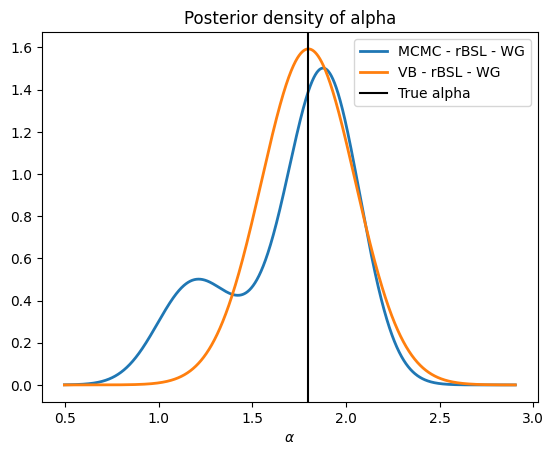

In [ ]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-4*pos_alpha_std,np.mean(best_alpha)-4*np.std(best_alpha)), max(pos_alpha_mean+4*pos_alpha_std, np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.175, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL - WG')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL - WG')

plt.axvline(x = 1.8, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

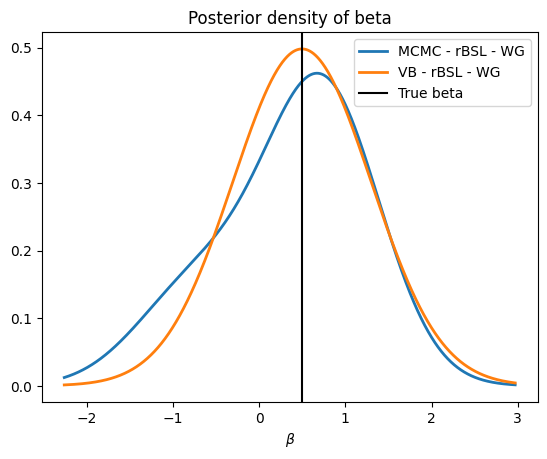

In [ ]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.65, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.8, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL - WG')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL - WG')

plt.axvline(x = 0.5, ymin = 0, color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

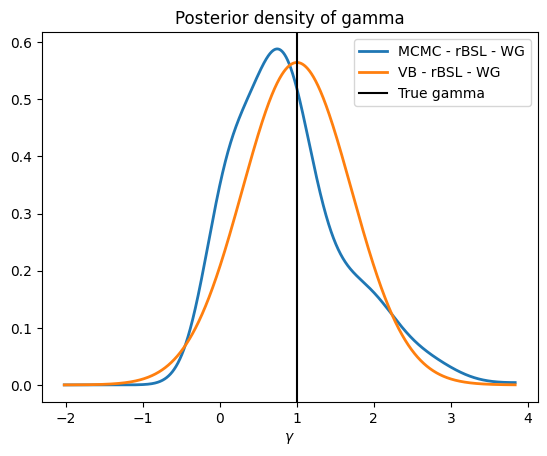

In [ ]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-4*pos_gamma_std,np.mean(best_gamma)-4*np.std(best_gamma)), max(pos_gamma_mean+4*pos_gamma_std, np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.3, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL - WG')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL - WG')

plt.axvline(x = 1, ymin = 0, color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')


Text(0.5, 1.0, 'Posterior density of delta')

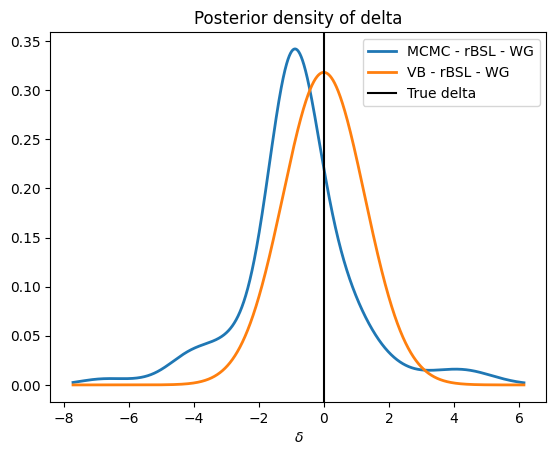

In [ ]:
plt.figure()
pos_delta_mean = np.mean(pos_w[int(num_burnin):,3])
pos_delta_std = np.std(pos_w[int(num_burnin):,3])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_delta_mean-4*pos_delta_std,np.mean(best_delta)-4*np.std(best_delta)), max(pos_delta_mean+4*pos_delta_std, np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.65, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,3].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=1.25, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL - WG')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL - WG')

plt.axvline(x = 0, ymin = 0, color = 'black', label = 'True delta')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')
